<a href="https://colab.research.google.com/github/dwgb93/TEI_WildfireSpread/blob/main/notebooks/UNET_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Mahogany

We're using data from [this paper](https://arxiv.org/pdf/2112.02447.pdf) to predict where wildfires spread based on 12 features including wind, temperature, humidity, vegetation, and elevation.

This code does the following:


*   Downloads the data from Google Drive
*   Parses and normalizes the data into training, validation, and test sets.
*   Trains a U-Net shaped convolutional neural network until it stops improving
*   Measures the Precision, Recall, and AUC (PR) on new data
*   Plots the metrics and visualizes predictions



Licensed under the Apache License, Version 2.0
# 1. Imports

Import the required libraries.

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np
import pandas as pd

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Common functions

These come from the original paper's [GitHub](https://github.com/google-research/google-research/tree/master/simulation_research/next_day_wildfire_spread), and have been modified slightly.

Run the following three cells to define the required library functions for loading the data.

In [ ]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the training set only (uncropped)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [ ]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

_parse_fn was modified to include sample_weights in addition to the inputs and labels.

This is a mask with 0's where the data is unknown (label: -1 No Data) and 1's where the data is known (label: 0 No Fire or 1: Fire)

This tells the neural network to ignore the missing data when calculating loss functions and training

In [ ]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))

# Modified 

def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
    
  weights = tf.cast(tf.greater_equal(output_img, tf.zeros_like(output_img)), tf.int32)

  return input_img, output_img, weights


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

Depending on the cutoff, we could report ~100% precision or 100% accuracy, trading one off for the other. 

This function returns the precision and recall that maximize the F1-score, for consistency.

For certain cutoffs, the precision is undefined, so it is recorded as 0.

In [ ]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

Define the features in the dataset

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# 3. Load the dataset

Enter the file pattern of the dataset.

If you are running this notebook locally, and your data is not stored in Google Drive, change the file_pattern below to where your data is stored locally.

In [ ]:
file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_train*'
#Location within MY GDrive. Might not be the same for you. I don't know if you can link to my drive this way...
val_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_eval*'

test_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_test*'

Get the training, validation, and testing datasets


We randomly crop the training data, so each epoch of the neural network gets a new set of 15,000 fire images to train off of.

We center crop the images for validation and testing.

In [ ]:
one_batch = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32, #We don't go through the whole dataset at once. It takes 468 loops to do the whole thing.
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

# 4. UNET-Style Convolutional Neural Network

More imports! Fun!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

We double the number of filters each layer of the encoder, and halve them for the decoder.
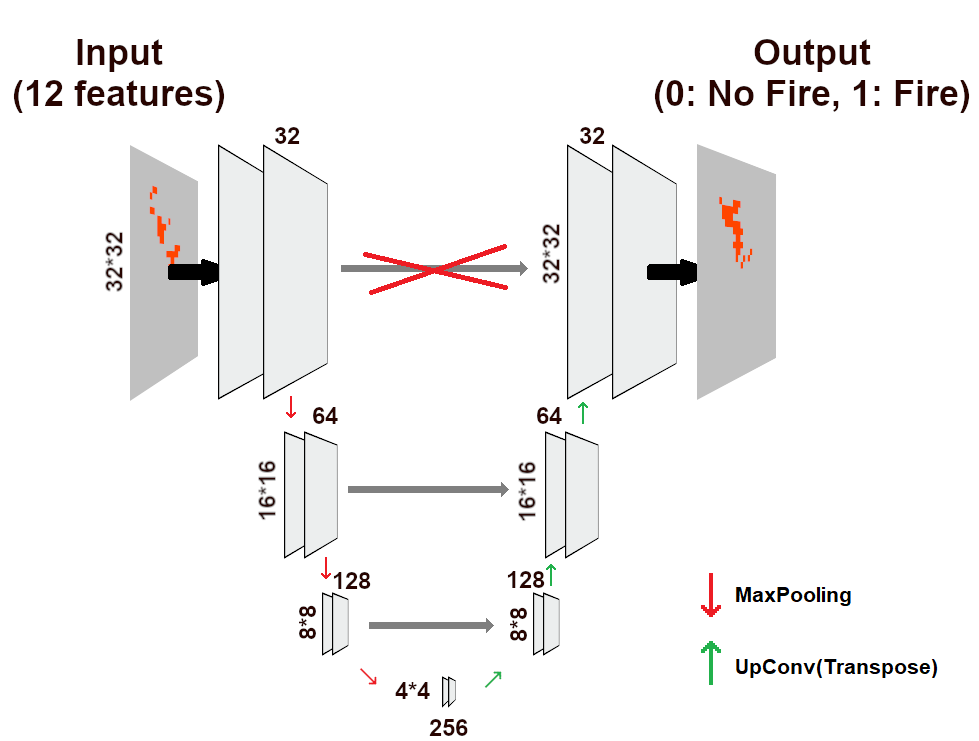

In [ ]:
def conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output) 
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

In [ ]:
def up_conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output) 
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters//2, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

In [ ]:
sample_size = dataset.element_spec[0].shape[1]

# Create UNET style model - This first one is the same as the paper
model_input = keras.Input(shape=(sample_size, sample_size, 12), name="original_img") # input is 32*32

#Downsample
block_1_output = conv_block(model_input, 32, 3) 
x = MaxPooling2D(2)(block_1_output) #output is 16 * 16
block_2_output = conv_block(x, 64, 3) 
x = MaxPooling2D(2)(block_2_output) #output is 8*8
block_3_output = conv_block(x, 128, 3) 
x = MaxPooling2D(2)(block_3_output) #output is 4*4

#bottom layer bottleneck
x = conv_block(x, 256, 3) # still 4x4

#upsample
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(128, 3, strides = 2, padding = "same")(x) # output is 8*8
x = layers.BatchNormalization()(x)
first_up_layer = layers.add([block_3_output, x]) 
x = up_conv_block(first_up_layer, 256, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(64, 3, strides = 2, padding = "same")(x) # output is 16*16
x = layers.BatchNormalization()(x)
second_up_layer = layers.add([block_2_output, x]) 
x = up_conv_block(second_up_layer, 128, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(32, 3, strides = 2, padding = "same")(x) # output is 32*32
x = layers.BatchNormalization()(x)
# Eliminating the skip connection from the input results in increased performance.
# This is reflected by a red X in the diagram above
# x = layers.add([block_1_output, x]) # Third_up_layer
x = up_conv_block(x, 64, 3)

predictions = Conv2D(1, 3, activation = "sigmoid", padding="same")(x) #Force output to be 0,1

# this is the model we will train
model = Model(inputs=model_input, outputs=predictions)

model.summary() # It's not as deep as Inception, but it'll do



# compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC()])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_default_model.hdf5', monitor='val_loss', save_best_only=True, save_freq=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 original_img (InputLayer)      [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 32, 32, 32)   3488        ['original_img[0][0]']           
                                                                                                  
 batch_normalization_34 (BatchN  (None, 32, 32, 32)  128         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
# Uncomment and turn sideways to see the beautiful U-shaped architecture.
# keras.utils.plot_model(model, "UNet.png", show_shapes=True)

This randomly crops new 32*32 squares from the data and runs 1 epoch. Then it does it again.

We could have done model.fit with (inputs, labels) representing inputs and outputs to fit, but it would pick the SAME 15,000 inputs and outputs instead of taking advantage of the random cropping.

It shows a lot more data to the model, improving performance

Sometimes this doesn't run. This is a known bug. To fix, restart kernel and run fresh.

Alternatively, you can just use the same 15,000 fires over and over again without random cropping running the code chunk below

In [ ]:
# train the model on the new data for a few epochs
print("Model has started training")
EPOCHS = 25


history = model.fit(one_batch, #tf.data.dataset takes full advantage of the data generator above
          epochs = EPOCHS,
          validation_data = valset,
          callbacks = CALLBACKS)

# If the above code doesn't run, get a batch of inputs and labels, then run the below code:
# inputs, labels, weights = next(iter(dataset))
# history = model.fit(inputs, labels, 
#                     sample_weight = sample_weight,
#                     epochs = EPOCHS,
#                     batch_size = 64,
#                     validation_data = (inputs_val, labels_val))

Model has started training
Epoch 1/25


      1/Unknown - 2s 2s/step - loss: 0.6846 - auc_5: 0.4614

      3/Unknown - 2s 44ms/step - loss: 0.6683 - auc_5: 0.4469

      4/Unknown - 2s 48ms/step - loss: 0.6532 - auc_5: 0.4585

      5/Unknown - 2s 49ms/step - loss: 0.6207 - auc_5: 0.4609

      7/Unknown - 2s 45ms/step - loss: 0.6083 - auc_5: 0.4746

      9/Unknown - 2s 44ms/step - loss: 0.6014 - auc_5: 0.4809

     11/Unknown - 3s 42ms/step - loss: 0.5963 - auc_5: 0.4886

     13/Unknown - 3s 41ms/step - loss: 0.5867 - auc_5: 0.4944

     15/Unknown - 3s 40ms/step - loss: 0.5797 - auc_5: 0.4993

     17/Unknown - 3s 39ms/step - loss: 0.5736 - auc_5: 0.4985

     19/Unknown - 3s 40ms/step - loss: 0.5667 - auc_5: 0.5039

     21/Unknown - 3s 39ms/step - loss: 0.5566 - auc_5: 0.5063

     23/Unknown - 3s 39ms/step - loss: 0.5433 - auc_5: 0.4841

     25/Unknown - 3s 38ms/step - loss: 0.5384 - auc_5: 0.4854

     27/Unknown - 3s 37ms/step - loss: 0.5353 - auc_5: 0.4850

     29/Unknown - 3s 37ms/step - loss: 0.5299 - auc_5: 0.4901

     31/Unknown - 3s 38ms/step - loss: 0.5241 - auc_5: 0.4954

     33/Unknown - 3s 38ms/step - loss: 0.5174 - auc_5: 0.4982

     35/Unknown - 3s 38ms/step - loss: 0.5109 - auc_5: 0.5045

     37/Unknown - 3s 38ms/step - loss: 0.5047 - auc_5: 0.5108

     38/Unknown - 4s 39ms/step - loss: 0.5008 - auc_5: 0.5131

     40/Unknown - 4s 39ms/step - loss: 0.4946 - auc_5: 0.5195

     42/Unknown - 4s 39ms/step - loss: 0.4890 - auc_5: 0.5239

     44/Unknown - 4s 39ms/step - loss: 0.4831 - auc_5: 0.5297

     46/Unknown - 4s 39ms/step - loss: 0.4782 - auc_5: 0.5339

     48/Unknown - 4s 39ms/step - loss: 0.4710 - auc_5: 0.5331

     50/Unknown - 4s 39ms/step - loss: 0.4627 - auc_5: 0.5076

     51/Unknown - 4s 40ms/step - loss: 0.4605 - auc_5: 0.5101

     53/Unknown - 4s 40ms/step - loss: 0.4560 - auc_5: 0.5134

     55/Unknown - 4s 40ms/step - loss: 0.4514 - auc_5: 0.5186

     56/Unknown - 4s 40ms/step - loss: 0.4494 - auc_5: 0.5206

     58/Unknown - 4s 40ms/step - loss: 0.4451 - auc_5: 0.5263

     60/Unknown - 4s 40ms/step - loss: 0.4418 - auc_5: 0.5293

     62/Unknown - 5s 40ms/step - loss: 0.4379 - auc_5: 0.5348

     64/Unknown - 5s 40ms/step - loss: 0.4344 - auc_5: 0.5347

     66/Unknown - 5s 40ms/step - loss: 0.4311 - auc_5: 0.5386

     68/Unknown - 5s 40ms/step - loss: 0.4284 - auc_5: 0.5411

     70/Unknown - 5s 39ms/step - loss: 0.4233 - auc_5: 0.5346

     72/Unknown - 5s 39ms/step - loss: 0.4184 - auc_5: 0.5280

     74/Unknown - 5s 39ms/step - loss: 0.4160 - auc_5: 0.5299

     75/Unknown - 5s 39ms/step - loss: 0.4151 - auc_5: 0.5313

     77/Unknown - 5s 40ms/step - loss: 0.4124 - auc_5: 0.5356

     79/Unknown - 5s 40ms/step - loss: 0.4096 - auc_5: 0.5395

     81/Unknown - 5s 39ms/step - loss: 0.4071 - auc_5: 0.5426

     83/Unknown - 5s 39ms/step - loss: 0.4052 - auc_5: 0.5454

     84/Unknown - 5s 39ms/step - loss: 0.4040 - auc_5: 0.5470

     86/Unknown - 5s 39ms/step - loss: 0.4019 - auc_5: 0.5499

     88/Unknown - 6s 39ms/step - loss: 0.3993 - auc_5: 0.5540

     90/Unknown - 6s 39ms/step - loss: 0.3965 - auc_5: 0.5575

     92/Unknown - 6s 39ms/step - loss: 0.3919 - auc_5: 0.5466

     94/Unknown - 6s 39ms/step - loss: 0.3889 - auc_5: 0.5454

     96/Unknown - 6s 39ms/step - loss: 0.3871 - auc_5: 0.5461

     98/Unknown - 6s 39ms/step - loss: 0.3849 - auc_5: 0.5477

    100/Unknown - 6s 39ms/step - loss: 0.3834 - auc_5: 0.5492

    102/Unknown - 6s 39ms/step - loss: 0.3811 - auc_5: 0.5521

    104/Unknown - 6s 39ms/step - loss: 0.3801 - auc_5: 0.5523

    106/Unknown - 6s 39ms/step - loss: 0.3784 - auc_5: 0.5542

    108/Unknown - 6s 39ms/step - loss: 0.3765 - auc_5: 0.5580

    110/Unknown - 6s 39ms/step - loss: 0.3735 - auc_5: 0.5537

    112/Unknown - 6s 39ms/step - loss: 0.3713 - auc_5: 0.5568

    114/Unknown - 7s 39ms/step - loss: 0.3695 - auc_5: 0.5605

    115/Unknown - 7s 39ms/step - loss: 0.3682 - auc_5: 0.5618

    117/Unknown - 7s 39ms/step - loss: 0.3664 - auc_5: 0.5656

    119/Unknown - 7s 39ms/step - loss: 0.3639 - auc_5: 0.5695

    121/Unknown - 7s 39ms/step - loss: 0.3617 - auc_5: 0.5652

    123/Unknown - 7s 39ms/step - loss: 0.3599 - auc_5: 0.5635

    125/Unknown - 7s 39ms/step - loss: 0.3581 - auc_5: 0.5666

    127/Unknown - 7s 39ms/step - loss: 0.3560 - auc_5: 0.5671

    129/Unknown - 7s 39ms/step - loss: 0.3542 - auc_5: 0.5703

    131/Unknown - 7s 39ms/step - loss: 0.3523 - auc_5: 0.5729

    132/Unknown - 7s 39ms/step - loss: 0.3514 - auc_5: 0.5747

    134/Unknown - 7s 39ms/step - loss: 0.3494 - auc_5: 0.5690

    136/Unknown - 7s 39ms/step - loss: 0.3473 - auc_5: 0.5722

    137/Unknown - 7s 40ms/step - loss: 0.3465 - auc_5: 0.5737

    139/Unknown - 8s 40ms/step - loss: 0.3446 - auc_5: 0.5762

    141/Unknown - 8s 40ms/step - loss: 0.3428 - auc_5: 0.5790

    143/Unknown - 8s 40ms/step - loss: 0.3404 - auc_5: 0.5752

    145/Unknown - 8s 40ms/step - loss: 0.3382 - auc_5: 0.5767

    147/Unknown - 8s 40ms/step - loss: 0.3367 - auc_5: 0.5792

    149/Unknown - 8s 40ms/step - loss: 0.3353 - auc_5: 0.5811

    151/Unknown - 8s 40ms/step - loss: 0.3332 - auc_5: 0.5792

    153/Unknown - 8s 40ms/step - loss: 0.3310 - auc_5: 0.5809

    155/Unknown - 8s 40ms/step - loss: 0.3293 - auc_5: 0.5840

    157/Unknown - 8s 40ms/step - loss: 0.3275 - auc_5: 0.5857

    159/Unknown - 8s 40ms/step - loss: 0.3251 - auc_5: 0.5803

    161/Unknown - 9s 40ms/step - loss: 0.3234 - auc_5: 0.5781

    163/Unknown - 9s 40ms/step - loss: 0.3217 - auc_5: 0.5809

    165/Unknown - 9s 40ms/step - loss: 0.3203 - auc_5: 0.5827

    167/Unknown - 9s 40ms/step - loss: 0.3188 - auc_5: 0.5851

    169/Unknown - 9s 40ms/step - loss: 0.3175 - auc_5: 0.5868

    171/Unknown - 9s 40ms/step - loss: 0.3163 - auc_5: 0.5883

    173/Unknown - 9s 40ms/step - loss: 0.3152 - auc_5: 0.5896

    175/Unknown - 9s 40ms/step - loss: 0.3140 - auc_5: 0.5920

    177/Unknown - 9s 40ms/step - loss: 0.3119 - auc_5: 0.5855

    179/Unknown - 9s 40ms/step - loss: 0.3098 - auc_5: 0.5779

    181/Unknown - 9s 40ms/step - loss: 0.3089 - auc_5: 0.5801

    182/Unknown - 9s 40ms/step - loss: 0.3082 - auc_5: 0.5812

    184/Unknown - 9s 40ms/step - loss: 0.3074 - auc_5: 0.5827

    186/Unknown - 9s 40ms/step - loss: 0.3063 - auc_5: 0.5850

    188/Unknown - 10s 40ms/step - loss: 0.3049 - auc_5: 0.5855

    190/Unknown - 10s 40ms/step - loss: 0.3033 - auc_5: 0.5772

    192/Unknown - 10s 40ms/step - loss: 0.3020 - auc_5: 0.5798

    194/Unknown - 10s 40ms/step - loss: 0.3007 - auc_5: 0.5818

    196/Unknown - 10s 40ms/step - loss: 0.2990 - auc_5: 0.5811

    198/Unknown - 10s 40ms/step - loss: 0.2979 - auc_5: 0.5815

    200/Unknown - 10s 40ms/step - loss: 0.2966 - auc_5: 0.5830

    202/Unknown - 10s 40ms/step - loss: 0.2952 - auc_5: 0.5844

    204/Unknown - 10s 40ms/step - loss: 0.2936 - auc_5: 0.5825

    206/Unknown - 10s 40ms/step - loss: 0.2926 - auc_5: 0.5844

    208/Unknown - 10s 40ms/step - loss: 0.2914 - auc_5: 0.5862

    209/Unknown - 10s 40ms/step - loss: 0.2908 - auc_5: 0.5873

    210/Unknown - 10s 40ms/step - loss: 0.2904 - auc_5: 0.5882

    212/Unknown - 10s 40ms/step - loss: 0.2889 - auc_5: 0.5848

    213/Unknown - 11s 40ms/step - loss: 0.2884 - auc_5: 0.5852

    215/Unknown - 11s 40ms/step - loss: 0.2873 - auc_5: 0.5842

    217/Unknown - 11s 40ms/step - loss: 0.2862 - auc_5: 0.5853

    218/Unknown - 11s 40ms/step - loss: 0.2858 - auc_5: 0.5863

    219/Unknown - 11s 40ms/step - loss: 0.2853 - auc_5: 0.5860

    221/Unknown - 11s 40ms/step - loss: 0.2844 - auc_5: 0.5875

    223/Unknown - 11s 40ms/step - loss: 0.2837 - auc_5: 0.5897

    225/Unknown - 11s 40ms/step - loss: 0.2827 - auc_5: 0.5916

    226/Unknown - 11s 40ms/step - loss: 0.2822 - auc_5: 0.5926

    228/Unknown - 11s 40ms/step - loss: 0.2812 - auc_5: 0.5940

    230/Unknown - 11s 40ms/step - loss: 0.2795 - auc_5: 0.5912

    232/Unknown - 11s 40ms/step - loss: 0.2782 - auc_5: 0.5911

    234/Unknown - 11s 40ms/step - loss: 0.2773 - auc_5: 0.5933

    236/Unknown - 12s 40ms/step - loss: 0.2767 - auc_5: 0.5954

    238/Unknown - 12s 40ms/step - loss: 0.2757 - auc_5: 0.5974

    240/Unknown - 12s 40ms/step - loss: 0.2751 - auc_5: 0.5978

    241/Unknown - 12s 40ms/step - loss: 0.2748 - auc_5: 0.5989

    242/Unknown - 12s 40ms/step - loss: 0.2743 - auc_5: 0.6000

    244/Unknown - 12s 40ms/step - loss: 0.2734 - auc_5: 0.6020

    246/Unknown - 12s 40ms/step - loss: 0.2725 - auc_5: 0.6042

    247/Unknown - 12s 41ms/step - loss: 0.2717 - auc_5: 0.5982

    248/Unknown - 12s 41ms/step - loss: 0.2710 - auc_5: 0.5964

    250/Unknown - 12s 41ms/step - loss: 0.2696 - auc_5: 0.5891

    251/Unknown - 12s 41ms/step - loss: 0.2688 - auc_5: 0.5893

    253/Unknown - 12s 41ms/step - loss: 0.2676 - auc_5: 0.5857

    255/Unknown - 12s 41ms/step - loss: 0.2671 - auc_5: 0.5875

    256/Unknown - 12s 41ms/step - loss: 0.2670 - auc_5: 0.5884

    258/Unknown - 13s 41ms/step - loss: 0.2664 - auc_5: 0.5883

    259/Unknown - 13s 41ms/step - loss: 0.2663 - auc_5: 0.5891

    261/Unknown - 13s 41ms/step - loss: 0.2658 - auc_5: 0.5911

    263/Unknown - 13s 41ms/step - loss: 0.2652 - auc_5: 0.5923

    265/Unknown - 13s 41ms/step - loss: 0.2646 - auc_5: 0.5943

    266/Unknown - 13s 41ms/step - loss: 0.2643 - auc_5: 0.5951

    268/Unknown - 13s 41ms/step - loss: 0.2638 - auc_5: 0.5966

    270/Unknown - 13s 41ms/step - loss: 0.2634 - auc_5: 0.5986

    272/Unknown - 13s 41ms/step - loss: 0.2623 - auc_5: 0.5946

    274/Unknown - 13s 41ms/step - loss: 0.2611 - auc_5: 0.5897

    275/Unknown - 13s 41ms/step - loss: 0.2608 - auc_5: 0.5903

    276/Unknown - 13s 41ms/step - loss: 0.2606 - auc_5: 0.5910

    278/Unknown - 13s 41ms/step - loss: 0.2599 - auc_5: 0.5925

    279/Unknown - 14s 41ms/step - loss: 0.2596 - auc_5: 0.5937

    280/Unknown - 14s 41ms/step - loss: 0.2593 - auc_5: 0.5945

    281/Unknown - 14s 41ms/step - loss: 0.2591 - auc_5: 0.5951

    282/Unknown - 14s 41ms/step - loss: 0.2589 - auc_5: 0.5959

    283/Unknown - 14s 41ms/step - loss: 0.2584 - auc_5: 0.5923

    284/Unknown - 14s 41ms/step - loss: 0.2578 - auc_5: 0.5905

    285/Unknown - 14s 41ms/step - loss: 0.2575 - auc_5: 0.5909

    286/Unknown - 14s 41ms/step - loss: 0.2574 - auc_5: 0.5919

    288/Unknown - 14s 41ms/step - loss: 0.2571 - auc_5: 0.5922

    290/Unknown - 14s 41ms/step - loss: 0.2569 - auc_5: 0.5927

    291/Unknown - 14s 41ms/step - loss: 0.2567 - auc_5: 0.5937

    292/Unknown - 14s 42ms/step - loss: 0.2563 - auc_5: 0.5944

    293/Unknown - 14s 42ms/step - loss: 0.2557 - auc_5: 0.5924

    294/Unknown - 14s 42ms/step - loss: 0.2556 - auc_5: 0.5924

    295/Unknown - 14s 42ms/step - loss: 0.2554 - auc_5: 0.5935

    297/Unknown - 14s 42ms/step - loss: 0.2552 - auc_5: 0.5951

    298/Unknown - 15s 42ms/step - loss: 0.2550 - auc_5: 0.5961

    299/Unknown - 15s 42ms/step - loss: 0.2548 - auc_5: 0.5969

    301/Unknown - 15s 42ms/step - loss: 0.2548 - auc_5: 0.5983

    303/Unknown - 15s 42ms/step - loss: 0.2537 - auc_5: 0.5972

    304/Unknown - 15s 42ms/step - loss: 0.2534 - auc_5: 0.5982

    306/Unknown - 15s 42ms/step - loss: 0.2529 - auc_5: 0.5993

    307/Unknown - 15s 42ms/step - loss: 0.2527 - auc_5: 0.5993

    308/Unknown - 15s 42ms/step - loss: 0.2525 - auc_5: 0.6001

    309/Unknown - 15s 42ms/step - loss: 0.2523 - auc_5: 0.6009

    310/Unknown - 15s 42ms/step - loss: 0.2522 - auc_5: 0.6018

    312/Unknown - 15s 42ms/step - loss: 0.2515 - auc_5: 0.6021

    314/Unknown - 15s 42ms/step - loss: 0.2506 - auc_5: 0.6018

    315/Unknown - 15s 42ms/step - loss: 0.2501 - auc_5: 0.5996

    317/Unknown - 15s 42ms/step - loss: 0.2494 - auc_5: 0.6008

    319/Unknown - 16s 42ms/step - loss: 0.2489 - auc_5: 0.6030

    321/Unknown - 16s 42ms/step - loss: 0.2482 - auc_5: 0.6045

    323/Unknown - 16s 42ms/step - loss: 0.2473 - auc_5: 0.6019

    324/Unknown - 16s 42ms/step - loss: 0.2469 - auc_5: 0.6015

    325/Unknown - 16s 42ms/step - loss: 0.2466 - auc_5: 0.6021

    326/Unknown - 16s 43ms/step - loss: 0.2463 - auc_5: 0.6029

    327/Unknown - 16s 43ms/step - loss: 0.2460 - auc_5: 0.6035

    329/Unknown - 16s 43ms/step - loss: 0.2453 - auc_5: 0.6054

    330/Unknown - 16s 43ms/step - loss: 0.2448 - auc_5: 0.6044

    332/Unknown - 16s 43ms/step - loss: 0.2441 - auc_5: 0.6053

    333/Unknown - 16s 43ms/step - loss: 0.2438 - auc_5: 0.6062

    334/Unknown - 16s 43ms/step - loss: 0.2436 - auc_5: 0.6071

    336/Unknown - 16s 43ms/step - loss: 0.2432 - auc_5: 0.6079

    337/Unknown - 17s 43ms/step - loss: 0.2430 - auc_5: 0.6086

    338/Unknown - 17s 43ms/step - loss: 0.2425 - auc_5: 0.6068

    339/Unknown - 17s 43ms/step - loss: 0.2422 - auc_5: 0.6077

    340/Unknown - 17s 43ms/step - loss: 0.2421 - auc_5: 0.6085

    341/Unknown - 17s 43ms/step - loss: 0.2418 - auc_5: 0.6094

    343/Unknown - 17s 43ms/step - loss: 0.2413 - auc_5: 0.6110

    344/Unknown - 17s 43ms/step - loss: 0.2411 - auc_5: 0.6120

    345/Unknown - 17s 43ms/step - loss: 0.2409 - auc_5: 0.6115

    346/Unknown - 17s 43ms/step - loss: 0.2405 - auc_5: 0.6110

    348/Unknown - 17s 43ms/step - loss: 0.2400 - auc_5: 0.6116

    349/Unknown - 17s 43ms/step - loss: 0.2398 - auc_5: 0.6122

    351/Unknown - 17s 43ms/step - loss: 0.2395 - auc_5: 0.6138

    352/Unknown - 17s 43ms/step - loss: 0.2394 - auc_5: 0.6145

    353/Unknown - 17s 43ms/step - loss: 0.2392 - auc_5: 0.6153

    355/Unknown - 17s 43ms/step - loss: 0.2388 - auc_5: 0.6167

    357/Unknown - 18s 43ms/step - loss: 0.2383 - auc_5: 0.6156

    358/Unknown - 18s 43ms/step - loss: 0.2378 - auc_5: 0.6137

    360/Unknown - 18s 43ms/step - loss: 0.2368 - auc_5: 0.6074

    361/Unknown - 18s 43ms/step - loss: 0.2367 - auc_5: 0.6076

    363/Unknown - 18s 43ms/step - loss: 0.2363 - auc_5: 0.6082

    364/Unknown - 18s 43ms/step - loss: 0.2361 - auc_5: 0.6088

    366/Unknown - 18s 43ms/step - loss: 0.2360 - auc_5: 0.6098

    368/Unknown - 18s 43ms/step - loss: 0.2356 - auc_5: 0.6103

    370/Unknown - 18s 43ms/step - loss: 0.2352 - auc_5: 0.6108

    372/Unknown - 18s 43ms/step - loss: 0.2348 - auc_5: 0.6112

    374/Unknown - 18s 43ms/step - loss: 0.2345 - auc_5: 0.6122

    375/Unknown - 18s 43ms/step - loss: 0.2344 - auc_5: 0.6122

    377/Unknown - 18s 43ms/step - loss: 0.2342 - auc_5: 0.6136

    379/Unknown - 18s 43ms/step - loss: 0.2340 - auc_5: 0.6148

    380/Unknown - 19s 43ms/step - loss: 0.2338 - auc_5: 0.6152

    382/Unknown - 19s 43ms/step - loss: 0.2329 - auc_5: 0.6108

    384/Unknown - 19s 43ms/step - loss: 0.2322 - auc_5: 0.6054

    385/Unknown - 19s 43ms/step - loss: 0.2320 - auc_5: 0.6060

    387/Unknown - 19s 43ms/step - loss: 0.2317 - auc_5: 0.6073

    388/Unknown - 19s 43ms/step - loss: 0.2315 - auc_5: 0.6077

    390/Unknown - 19s 43ms/step - loss: 0.2313 - auc_5: 0.6091

    392/Unknown - 19s 43ms/step - loss: 0.2311 - auc_5: 0.6103

    394/Unknown - 19s 43ms/step - loss: 0.2308 - auc_5: 0.6110

    396/Unknown - 19s 43ms/step - loss: 0.2306 - auc_5: 0.6126

    398/Unknown - 19s 43ms/step - loss: 0.2304 - auc_5: 0.6130

    400/Unknown - 19s 43ms/step - loss: 0.2301 - auc_5: 0.6143

    402/Unknown - 20s 43ms/step - loss: 0.2294 - auc_5: 0.6131

    403/Unknown - 20s 43ms/step - loss: 0.2290 - auc_5: 0.6122

    405/Unknown - 20s 43ms/step - loss: 0.2285 - auc_5: 0.6113

    407/Unknown - 20s 43ms/step - loss: 0.2282 - auc_5: 0.6129

    408/Unknown - 20s 43ms/step - loss: 0.2282 - auc_5: 0.6135

    409/Unknown - 20s 43ms/step - loss: 0.2280 - auc_5: 0.6139

    410/Unknown - 20s 43ms/step - loss: 0.2278 - auc_5: 0.6145

    412/Unknown - 20s 43ms/step - loss: 0.2275 - auc_5: 0.6156

    414/Unknown - 20s 43ms/step - loss: 0.2273 - auc_5: 0.6165

    415/Unknown - 20s 44ms/step - loss: 0.2271 - auc_5: 0.6172

    416/Unknown - 20s 44ms/step - loss: 0.2270 - auc_5: 0.6178

    418/Unknown - 20s 44ms/step - loss: 0.2263 - auc_5: 0.6143

    419/Unknown - 20s 44ms/step - loss: 0.2258 - auc_5: 0.6125

    421/Unknown - 20s 44ms/step - loss: 0.2256 - auc_5: 0.6136

    422/Unknown - 20s 44ms/step - loss: 0.2254 - auc_5: 0.6141

    424/Unknown - 21s 44ms/step - loss: 0.2253 - auc_5: 0.6151

    425/Unknown - 21s 44ms/step - loss: 0.2252 - auc_5: 0.6151

    426/Unknown - 21s 44ms/step - loss: 0.2250 - auc_5: 0.6155

    427/Unknown - 21s 44ms/step - loss: 0.2249 - auc_5: 0.6158

    429/Unknown - 21s 44ms/step - loss: 0.2247 - auc_5: 0.6169

    431/Unknown - 21s 44ms/step - loss: 0.2245 - auc_5: 0.6172

    433/Unknown - 21s 44ms/step - loss: 0.2242 - auc_5: 0.6176

    434/Unknown - 21s 44ms/step - loss: 0.2240 - auc_5: 0.6183

    436/Unknown - 21s 44ms/step - loss: 0.2238 - auc_5: 0.6191

    437/Unknown - 21s 44ms/step - loss: 0.2236 - auc_5: 0.6196

    439/Unknown - 21s 44ms/step - loss: 0.2233 - auc_5: 0.6203

    440/Unknown - 21s 44ms/step - loss: 0.2229 - auc_5: 0.6201

    441/Unknown - 21s 44ms/step - loss: 0.2226 - auc_5: 0.6194

    443/Unknown - 21s 44ms/step - loss: 0.2221 - auc_5: 0.6196

    444/Unknown - 22s 44ms/step - loss: 0.2219 - auc_5: 0.6201

    446/Unknown - 22s 44ms/step - loss: 0.2216 - auc_5: 0.6207

    448/Unknown - 22s 44ms/step - loss: 0.2213 - auc_5: 0.6217

    449/Unknown - 22s 44ms/step - loss: 0.2212 - auc_5: 0.6214

    450/Unknown - 22s 44ms/step - loss: 0.2210 - auc_5: 0.6219

    451/Unknown - 22s 44ms/step - loss: 0.2209 - auc_5: 0.6223

    453/Unknown - 22s 44ms/step - loss: 0.2206 - auc_5: 0.6234

    455/Unknown - 22s 44ms/step - loss: 0.2202 - auc_5: 0.6243

    456/Unknown - 22s 44ms/step - loss: 0.2202 - auc_5: 0.6248

    458/Unknown - 22s 44ms/step - loss: 0.2199 - auc_5: 0.6258

    459/Unknown - 22s 44ms/step - loss: 0.2195 - auc_5: 0.6240

    460/Unknown - 22s 44ms/step - loss: 0.2191 - auc_5: 0.6227

    462/Unknown - 22s 44ms/step - loss: 0.2185 - auc_5: 0.6207

    464/Unknown - 22s 44ms/step - loss: 0.2181 - auc_5: 0.6217

    466/Unknown - 22s 44ms/step - loss: 0.2179 - auc_5: 0.6221

    468/Unknown - 23s 44ms/step - loss: 0.2177 - auc_5: 0.6231

469/469 [==============================] - 26s 51ms/step - loss: 0.2177 - auc_5: 0.6231 - val_loss: 0.2306 - val_auc_5: 0.6356
Epoch 2/25


  1/469 [..............................] - ETA: 43s - loss: 0.1911 - auc_5: 0.7268

  2/469 [..............................] - ETA: 36s - loss: 0.1981 - auc_5: 0.7347

  4/469 [..............................] - ETA: 25s - loss: 0.1857 - auc_5: 0.7527

  5/469 [..............................] - ETA: 26s - loss: 0.1920 - auc_5: 0.7641

  6/469 [..............................] - ETA: 26s - loss: 0.1955 - auc_5: 0.7822

  7/469 [..............................] - ETA: 26s - loss: 0.1909 - auc_5: 0.7837

  9/469 [..............................] - ETA: 23s - loss: 0.1914 - auc_5: 0.7805

 10/469 [..............................] - ETA: 23s - loss: 0.1925 - auc_5: 0.7854

 11/469 [..............................] - ETA: 23s - loss: 0.1938 - auc_5: 0.7753

 13/469 [..............................] - ETA: 23s - loss: 0.1922 - auc_5: 0.7751

 15/469 [..............................] - ETA: 23s - loss: 0.1902 - auc_5: 0.7843

 17/469 [>.............................] - ETA: 22s - loss: 0.1770 - auc_5: 0.7406

 19/469 [>.............................] - ETA: 22s - loss: 0.1776 - auc_5: 0.7490

 20/469 [>.............................] - ETA: 22s - loss: 0.1783 - auc_5: 0.7486

 22/469 [>.............................] - ETA: 22s - loss: 0.1767 - auc_5: 0.7508

 23/469 [>.............................] - ETA: 22s - loss: 0.1755 - auc_5: 0.7517

 24/469 [>.............................] - ETA: 22s - loss: 0.1765 - auc_5: 0.7536

 25/469 [>.............................] - ETA: 23s - loss: 0.1734 - auc_5: 0.7540

 27/469 [>.............................] - ETA: 22s - loss: 0.1708 - auc_5: 0.7095

 28/469 [>.............................] - ETA: 23s - loss: 0.1709 - auc_5: 0.7081

 30/469 [>.............................] - ETA: 22s - loss: 0.1722 - auc_5: 0.7097

 32/469 [=>............................] - ETA: 22s - loss: 0.1726 - auc_5: 0.7125

 33/469 [=>............................] - ETA: 23s - loss: 0.1732 - auc_5: 0.7161

 35/469 [=>............................] - ETA: 22s - loss: 0.1678 - auc_5: 0.6963

 36/469 [=>............................] - ETA: 22s - loss: 0.1693 - auc_5: 0.7011

 38/469 [=>............................] - ETA: 22s - loss: 0.1693 - auc_5: 0.7040

 39/469 [=>............................] - ETA: 22s - loss: 0.1703 - auc_5: 0.7052

 40/469 [=>............................] - ETA: 22s - loss: 0.1708 - auc_5: 0.7091

 41/469 [=>............................] - ETA: 22s - loss: 0.1725 - auc_5: 0.7115

 42/469 [=>............................] - ETA: 22s - loss: 0.1732 - auc_5: 0.7155

 43/469 [=>............................] - ETA: 22s - loss: 0.1706 - auc_5: 0.7095

 44/469 [=>............................] - ETA: 22s - loss: 0.1700 - auc_5: 0.7054

 46/469 [=>............................] - ETA: 22s - loss: 0.1720 - auc_5: 0.7115

 47/469 [==>...........................] - ETA: 22s - loss: 0.1722 - auc_5: 0.7128

 49/469 [==>...........................] - ETA: 22s - loss: 0.1733 - auc_5: 0.7168

 50/469 [==>...........................] - ETA: 22s - loss: 0.1750 - auc_5: 0.7180

 51/469 [==>...........................] - ETA: 22s - loss: 0.1768 - auc_5: 0.7216

 53/469 [==>...........................] - ETA: 21s - loss: 0.1741 - auc_5: 0.7182

 54/469 [==>...........................] - ETA: 21s - loss: 0.1727 - auc_5: 0.7134

 55/469 [==>...........................] - ETA: 21s - loss: 0.1724 - auc_5: 0.7146

 56/469 [==>...........................] - ETA: 22s - loss: 0.1723 - auc_5: 0.7143

 58/469 [==>...........................] - ETA: 21s - loss: 0.1729 - auc_5: 0.7139

 60/469 [==>...........................] - ETA: 21s - loss: 0.1739 - auc_5: 0.7157

 62/469 [==>...........................] - ETA: 21s - loss: 0.1733 - auc_5: 0.7160

 63/469 [===>..........................] - ETA: 21s - loss: 0.1728 - auc_5: 0.7167

 65/469 [===>..........................] - ETA: 21s - loss: 0.1736 - auc_5: 0.7182

 67/469 [===>..........................] - ETA: 20s - loss: 0.1729 - auc_5: 0.7196

 69/469 [===>..........................] - ETA: 20s - loss: 0.1723 - auc_5: 0.7219

 71/469 [===>..........................] - ETA: 20s - loss: 0.1724 - auc_5: 0.7218

 72/469 [===>..........................] - ETA: 20s - loss: 0.1720 - auc_5: 0.7222

 74/469 [===>..........................] - ETA: 20s - loss: 0.1705 - auc_5: 0.7152

 75/469 [===>..........................] - ETA: 20s - loss: 0.1688 - auc_5: 0.7100

 77/469 [===>..........................] - ETA: 20s - loss: 0.1676 - auc_5: 0.7050

 78/469 [===>..........................] - ETA: 20s - loss: 0.1675 - auc_5: 0.7056

 79/469 [====>.........................] - ETA: 20s - loss: 0.1675 - auc_5: 0.7065

 80/469 [====>.........................] - ETA: 20s - loss: 0.1678 - auc_5: 0.7072

 81/469 [====>.........................] - ETA: 20s - loss: 0.1673 - auc_5: 0.7074

 82/469 [====>.........................] - ETA: 20s - loss: 0.1671 - auc_5: 0.7078

 83/469 [====>.........................] - ETA: 20s - loss: 0.1667 - auc_5: 0.7085

 84/469 [====>.........................] - ETA: 20s - loss: 0.1665 - auc_5: 0.7087

 85/469 [====>.........................] - ETA: 20s - loss: 0.1664 - auc_5: 0.7098

 86/469 [====>.........................] - ETA: 20s - loss: 0.1665 - auc_5: 0.7108

 88/469 [====>.........................] - ETA: 20s - loss: 0.1664 - auc_5: 0.7122

 89/469 [====>.........................] - ETA: 20s - loss: 0.1663 - auc_5: 0.7122

 91/469 [====>.........................] - ETA: 20s - loss: 0.1660 - auc_5: 0.7143

 92/469 [====>.........................] - ETA: 20s - loss: 0.1660 - auc_5: 0.7151

 93/469 [====>.........................] - ETA: 20s - loss: 0.1660 - auc_5: 0.7155

 94/469 [=====>........................] - ETA: 20s - loss: 0.1662 - auc_5: 0.7153

 95/469 [=====>........................] - ETA: 20s - loss: 0.1661 - auc_5: 0.7160

 96/469 [=====>........................] - ETA: 20s - loss: 0.1667 - auc_5: 0.7166

 97/469 [=====>........................] - ETA: 19s - loss: 0.1669 - auc_5: 0.7174

 98/469 [=====>........................] - ETA: 19s - loss: 0.1672 - auc_5: 0.7189

 99/469 [=====>........................] - ETA: 19s - loss: 0.1670 - auc_5: 0.7193

100/469 [=====>........................] - ETA: 19s - loss: 0.1669 - auc_5: 0.7185

101/469 [=====>........................] - ETA: 19s - loss: 0.1656 - auc_5: 0.7119

102/469 [=====>........................] - ETA: 19s - loss: 0.1644 - auc_5: 0.7070

103/469 [=====>........................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7063

104/469 [=====>........................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7054

106/469 [=====>........................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7067

107/469 [=====>........................] - ETA: 19s - loss: 0.1633 - auc_5: 0.7070

108/469 [=====>........................] - ETA: 19s - loss: 0.1636 - auc_5: 0.7078

109/469 [=====>........................] - ETA: 19s - loss: 0.1633 - auc_5: 0.7086

110/469 [======>.......................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7095

111/469 [======>.......................] - ETA: 19s - loss: 0.1635 - auc_5: 0.7103

112/469 [======>.......................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7116

113/469 [======>.......................] - ETA: 19s - loss: 0.1632 - auc_5: 0.7116

114/469 [======>.......................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7127

115/469 [======>.......................] - ETA: 19s - loss: 0.1635 - auc_5: 0.7139

116/469 [======>.......................] - ETA: 19s - loss: 0.1635 - auc_5: 0.7148

117/469 [======>.......................] - ETA: 19s - loss: 0.1633 - auc_5: 0.7130

118/469 [======>.......................] - ETA: 19s - loss: 0.1634 - auc_5: 0.7143

120/469 [======>.......................] - ETA: 19s - loss: 0.1638 - auc_5: 0.7171

121/469 [======>.......................] - ETA: 19s - loss: 0.1630 - auc_5: 0.7110

122/469 [======>.......................] - ETA: 19s - loss: 0.1621 - auc_5: 0.7088

123/469 [======>.......................] - ETA: 19s - loss: 0.1612 - auc_5: 0.7076

124/469 [======>.......................] - ETA: 19s - loss: 0.1610 - auc_5: 0.7075

125/469 [======>.......................] - ETA: 19s - loss: 0.1610 - auc_5: 0.7086

126/469 [=======>......................] - ETA: 19s - loss: 0.1609 - auc_5: 0.7091

127/469 [=======>......................] - ETA: 19s - loss: 0.1608 - auc_5: 0.7099

128/469 [=======>......................] - ETA: 19s - loss: 0.1599 - auc_5: 0.7091

129/469 [=======>......................] - ETA: 19s - loss: 0.1590 - auc_5: 0.7073

130/469 [=======>......................] - ETA: 19s - loss: 0.1581 - auc_5: 0.7051

131/469 [=======>......................] - ETA: 19s - loss: 0.1582 - auc_5: 0.7057

132/469 [=======>......................] - ETA: 19s - loss: 0.1580 - auc_5: 0.7059

133/469 [=======>......................] - ETA: 19s - loss: 0.1581 - auc_5: 0.7057

134/469 [=======>......................] - ETA: 19s - loss: 0.1578 - auc_5: 0.7056

136/469 [=======>......................] - ETA: 18s - loss: 0.1578 - auc_5: 0.7063

138/469 [=======>......................] - ETA: 18s - loss: 0.1574 - auc_5: 0.7047

140/469 [=======>......................] - ETA: 18s - loss: 0.1575 - auc_5: 0.7057

141/469 [========>.....................] - ETA: 18s - loss: 0.1572 - auc_5: 0.7062

142/469 [========>.....................] - ETA: 18s - loss: 0.1569 - auc_5: 0.7056

143/469 [========>.....................] - ETA: 18s - loss: 0.1567 - auc_5: 0.7061

144/469 [========>.....................] - ETA: 18s - loss: 0.1566 - auc_5: 0.7066

145/469 [========>.....................] - ETA: 18s - loss: 0.1566 - auc_5: 0.7074

146/469 [========>.....................] - ETA: 18s - loss: 0.1565 - auc_5: 0.7080

147/469 [========>.....................] - ETA: 18s - loss: 0.1559 - auc_5: 0.7033

148/469 [========>.....................] - ETA: 18s - loss: 0.1550 - auc_5: 0.7015

149/469 [========>.....................] - ETA: 18s - loss: 0.1543 - auc_5: 0.7000

150/469 [========>.....................] - ETA: 18s - loss: 0.1537 - auc_5: 0.6973

151/469 [========>.....................] - ETA: 18s - loss: 0.1536 - auc_5: 0.6980

153/469 [========>.....................] - ETA: 18s - loss: 0.1535 - auc_5: 0.6992

155/469 [========>.....................] - ETA: 18s - loss: 0.1535 - auc_5: 0.6991

157/469 [=========>....................] - ETA: 17s - loss: 0.1536 - auc_5: 0.7004

159/469 [=========>....................] - ETA: 17s - loss: 0.1538 - auc_5: 0.7020

161/469 [=========>....................] - ETA: 17s - loss: 0.1542 - auc_5: 0.7034

163/469 [=========>....................] - ETA: 17s - loss: 0.1540 - auc_5: 0.7029

164/469 [=========>....................] - ETA: 17s - loss: 0.1533 - auc_5: 0.6990

165/469 [=========>....................] - ETA: 17s - loss: 0.1526 - auc_5: 0.6945

166/469 [=========>....................] - ETA: 17s - loss: 0.1526 - auc_5: 0.6949

167/469 [=========>....................] - ETA: 17s - loss: 0.1532 - auc_5: 0.6952

168/469 [=========>....................] - ETA: 17s - loss: 0.1531 - auc_5: 0.6957

169/469 [=========>....................] - ETA: 17s - loss: 0.1532 - auc_5: 0.6964

170/469 [=========>....................] - ETA: 17s - loss: 0.1536 - auc_5: 0.6968

171/469 [=========>....................] - ETA: 17s - loss: 0.1541 - auc_5: 0.6974

172/469 [==========>...................] - ETA: 17s - loss: 0.1541 - auc_5: 0.6981

173/469 [==========>...................] - ETA: 17s - loss: 0.1542 - auc_5: 0.6986

174/469 [==========>...................] - ETA: 16s - loss: 0.1544 - auc_5: 0.6991

175/469 [==========>...................] - ETA: 16s - loss: 0.1546 - auc_5: 0.6997

177/469 [==========>...................] - ETA: 16s - loss: 0.1551 - auc_5: 0.7012

178/469 [==========>...................] - ETA: 16s - loss: 0.1553 - auc_5: 0.7022

179/469 [==========>...................] - ETA: 16s - loss: 0.1556 - auc_5: 0.7028

180/469 [==========>...................] - ETA: 16s - loss: 0.1559 - auc_5: 0.7037

181/469 [==========>...................] - ETA: 16s - loss: 0.1563 - auc_5: 0.7047

182/469 [==========>...................] - ETA: 16s - loss: 0.1564 - auc_5: 0.7049

184/469 [==========>...................] - ETA: 16s - loss: 0.1561 - auc_5: 0.7020

185/469 [==========>...................] - ETA: 16s - loss: 0.1556 - auc_5: 0.7011

186/469 [==========>...................] - ETA: 16s - loss: 0.1550 - auc_5: 0.6999

188/469 [===========>..................] - ETA: 16s - loss: 0.1548 - auc_5: 0.7006

189/469 [===========>..................] - ETA: 16s - loss: 0.1552 - auc_5: 0.7013

190/469 [===========>..................] - ETA: 16s - loss: 0.1550 - auc_5: 0.7015

192/469 [===========>..................] - ETA: 15s - loss: 0.1544 - auc_5: 0.6993

194/469 [===========>..................] - ETA: 15s - loss: 0.1533 - auc_5: 0.6961

196/469 [===========>..................] - ETA: 15s - loss: 0.1531 - auc_5: 0.6957

197/469 [===========>..................] - ETA: 15s - loss: 0.1533 - auc_5: 0.6961

198/469 [===========>..................] - ETA: 15s - loss: 0.1533 - auc_5: 0.6962

199/469 [===========>..................] - ETA: 15s - loss: 0.1534 - auc_5: 0.6965

200/469 [===========>..................] - ETA: 15s - loss: 0.1532 - auc_5: 0.6963

201/469 [===========>..................] - ETA: 15s - loss: 0.1532 - auc_5: 0.6964

203/469 [===========>..................] - ETA: 15s - loss: 0.1530 - auc_5: 0.6971

205/469 [============>.................] - ETA: 14s - loss: 0.1529 - auc_5: 0.6980

206/469 [============>.................] - ETA: 14s - loss: 0.1531 - auc_5: 0.6987

207/469 [============>.................] - ETA: 14s - loss: 0.1531 - auc_5: 0.6991

209/469 [============>.................] - ETA: 14s - loss: 0.1524 - auc_5: 0.6970

210/469 [============>.................] - ETA: 14s - loss: 0.1518 - auc_5: 0.6945

212/469 [============>.................] - ETA: 14s - loss: 0.1518 - auc_5: 0.6937

213/469 [============>.................] - ETA: 14s - loss: 0.1518 - auc_5: 0.6940

215/469 [============>.................] - ETA: 14s - loss: 0.1523 - auc_5: 0.6952

217/469 [============>.................] - ETA: 14s - loss: 0.1526 - auc_5: 0.6964

218/469 [============>.................] - ETA: 14s - loss: 0.1526 - auc_5: 0.6971

219/469 [=============>................] - ETA: 14s - loss: 0.1528 - auc_5: 0.6971

220/469 [=============>................] - ETA: 14s - loss: 0.1529 - auc_5: 0.6976

221/469 [=============>................] - ETA: 13s - loss: 0.1528 - auc_5: 0.6981

222/469 [=============>................] - ETA: 13s - loss: 0.1527 - auc_5: 0.6978

224/469 [=============>................] - ETA: 13s - loss: 0.1527 - auc_5: 0.6985

225/469 [=============>................] - ETA: 13s - loss: 0.1527 - auc_5: 0.6992

226/469 [=============>................] - ETA: 13s - loss: 0.1529 - auc_5: 0.6994

227/469 [=============>................] - ETA: 13s - loss: 0.1531 - auc_5: 0.7003

228/469 [=============>................] - ETA: 13s - loss: 0.1531 - auc_5: 0.7009

229/469 [=============>................] - ETA: 13s - loss: 0.1533 - auc_5: 0.7015

230/469 [=============>................] - ETA: 13s - loss: 0.1533 - auc_5: 0.7018

232/469 [=============>................] - ETA: 13s - loss: 0.1532 - auc_5: 0.7025

234/469 [=============>................] - ETA: 13s - loss: 0.1524 - auc_5: 0.6991

235/469 [==============>...............] - ETA: 13s - loss: 0.1519 - auc_5: 0.6967

237/469 [==============>...............] - ETA: 12s - loss: 0.1517 - auc_5: 0.6949

239/469 [==============>...............] - ETA: 12s - loss: 0.1518 - auc_5: 0.6951

241/469 [==============>...............] - ETA: 12s - loss: 0.1522 - auc_5: 0.6961

242/469 [==============>...............] - ETA: 12s - loss: 0.1523 - auc_5: 0.6962

243/469 [==============>...............] - ETA: 12s - loss: 0.1525 - auc_5: 0.6954

245/469 [==============>...............] - ETA: 12s - loss: 0.1524 - auc_5: 0.6959

246/469 [==============>...............] - ETA: 12s - loss: 0.1525 - auc_5: 0.6961

247/469 [==============>...............] - ETA: 12s - loss: 0.1524 - auc_5: 0.6955

249/469 [==============>...............] - ETA: 12s - loss: 0.1525 - auc_5: 0.6961

250/469 [==============>...............] - ETA: 12s - loss: 0.1526 - auc_5: 0.6967

252/469 [===============>..............] - ETA: 12s - loss: 0.1521 - auc_5: 0.6923

253/469 [===============>..............] - ETA: 11s - loss: 0.1520 - auc_5: 0.6919

255/469 [===============>..............] - ETA: 11s - loss: 0.1517 - auc_5: 0.6925

256/469 [===============>..............] - ETA: 11s - loss: 0.1517 - auc_5: 0.6927

258/469 [===============>..............] - ETA: 11s - loss: 0.1513 - auc_5: 0.6920

260/469 [===============>..............] - ETA: 11s - loss: 0.1512 - auc_5: 0.6913

262/469 [===============>..............] - ETA: 11s - loss: 0.1510 - auc_5: 0.6918

263/469 [===============>..............] - ETA: 11s - loss: 0.1509 - auc_5: 0.6921

264/469 [===============>..............] - ETA: 11s - loss: 0.1508 - auc_5: 0.6924

265/469 [===============>..............] - ETA: 11s - loss: 0.1506 - auc_5: 0.6921

267/469 [================>.............] - ETA: 11s - loss: 0.1501 - auc_5: 0.6894

268/469 [================>.............] - ETA: 11s - loss: 0.1502 - auc_5: 0.6897

270/469 [================>.............] - ETA: 10s - loss: 0.1501 - auc_5: 0.6904

272/469 [================>.............] - ETA: 10s - loss: 0.1501 - auc_5: 0.6911

274/469 [================>.............] - ETA: 10s - loss: 0.1497 - auc_5: 0.6891

275/469 [================>.............] - ETA: 10s - loss: 0.1495 - auc_5: 0.6877

276/469 [================>.............] - ETA: 10s - loss: 0.1495 - auc_5: 0.6877

277/469 [================>.............] - ETA: 10s - loss: 0.1494 - auc_5: 0.6878

278/469 [================>.............] - ETA: 10s - loss: 0.1492 - auc_5: 0.6874

279/469 [================>.............] - ETA: 10s - loss: 0.1493 - auc_5: 0.6880

280/469 [================>.............] - ETA: 10s - loss: 0.1492 - auc_5: 0.6883

281/469 [================>.............] - ETA: 10s - loss: 0.1490 - auc_5: 0.6872

283/469 [=================>............] - ETA: 10s - loss: 0.1485 - auc_5: 0.6864

284/469 [=================>............] - ETA: 10s - loss: 0.1482 - auc_5: 0.6849

286/469 [=================>............] - ETA: 10s - loss: 0.1482 - auc_5: 0.6853

287/469 [=================>............] - ETA: 9s - loss: 0.1482 - auc_5: 0.6860 

288/469 [=================>............] - ETA: 9s - loss: 0.1481 - auc_5: 0.6865

289/469 [=================>............] - ETA: 9s - loss: 0.1480 - auc_5: 0.6869

290/469 [=================>............] - ETA: 9s - loss: 0.1479 - auc_5: 0.6873

291/469 [=================>............] - ETA: 9s - loss: 0.1476 - auc_5: 0.6857

293/469 [=================>............] - ETA: 9s - loss: 0.1471 - auc_5: 0.6837

294/469 [=================>............] - ETA: 9s - loss: 0.1472 - auc_5: 0.6840

295/469 [=================>............] - ETA: 9s - loss: 0.1472 - auc_5: 0.6845

297/469 [=================>............] - ETA: 9s - loss: 0.1471 - auc_5: 0.6855

299/469 [==================>...........] - ETA: 9s - loss: 0.1465 - auc_5: 0.6840

300/469 [==================>...........] - ETA: 9s - loss: 0.1464 - auc_5: 0.6844

301/469 [==================>...........] - ETA: 9s - loss: 0.1464 - auc_5: 0.6847

302/469 [==================>...........] - ETA: 9s - loss: 0.1463 - auc_5: 0.6851

303/469 [==================>...........] - ETA: 9s - loss: 0.1463 - auc_5: 0.6854

304/469 [==================>...........] - ETA: 9s - loss: 0.1463 - auc_5: 0.6858

305/469 [==================>...........] - ETA: 8s - loss: 0.1462 - auc_5: 0.6859

307/469 [==================>...........] - ETA: 8s - loss: 0.1459 - auc_5: 0.6855

308/469 [==================>...........] - ETA: 8s - loss: 0.1458 - auc_5: 0.6860

309/469 [==================>...........] - ETA: 8s - loss: 0.1459 - auc_5: 0.6867

311/469 [==================>...........] - ETA: 8s - loss: 0.1457 - auc_5: 0.6875

312/469 [==================>...........] - ETA: 8s - loss: 0.1457 - auc_5: 0.6880

313/469 [===================>..........] - ETA: 8s - loss: 0.1456 - auc_5: 0.6877

314/469 [===================>..........] - ETA: 8s - loss: 0.1455 - auc_5: 0.6879

315/469 [===================>..........] - ETA: 8s - loss: 0.1455 - auc_5: 0.6884

316/469 [===================>..........] - ETA: 8s - loss: 0.1454 - auc_5: 0.6888

318/469 [===================>..........] - ETA: 8s - loss: 0.1452 - auc_5: 0.6887

319/469 [===================>..........] - ETA: 8s - loss: 0.1451 - auc_5: 0.6891

321/469 [===================>..........] - ETA: 8s - loss: 0.1450 - auc_5: 0.6892

322/469 [===================>..........] - ETA: 8s - loss: 0.1449 - auc_5: 0.6896

324/469 [===================>..........] - ETA: 7s - loss: 0.1447 - auc_5: 0.6902

326/469 [===================>..........] - ETA: 7s - loss: 0.1447 - auc_5: 0.6908

328/469 [===================>..........] - ETA: 7s - loss: 0.1445 - auc_5: 0.6910

330/469 [====================>.........] - ETA: 7s - loss: 0.1438 - auc_5: 0.6873

331/469 [====================>.........] - ETA: 7s - loss: 0.1437 - auc_5: 0.6872

333/469 [====================>.........] - ETA: 7s - loss: 0.1436 - auc_5: 0.6878

335/469 [====================>.........] - ETA: 7s - loss: 0.1435 - auc_5: 0.6882

337/469 [====================>.........] - ETA: 7s - loss: 0.1433 - auc_5: 0.6890

338/469 [====================>.........] - ETA: 7s - loss: 0.1432 - auc_5: 0.6893

340/469 [====================>.........] - ETA: 6s - loss: 0.1432 - auc_5: 0.6902

341/469 [====================>.........] - ETA: 6s - loss: 0.1432 - auc_5: 0.6904

343/469 [====================>.........] - ETA: 6s - loss: 0.1430 - auc_5: 0.6908

344/469 [=====================>........] - ETA: 6s - loss: 0.1428 - auc_5: 0.6902

346/469 [=====================>........] - ETA: 6s - loss: 0.1431 - auc_5: 0.6908

348/469 [=====================>........] - ETA: 6s - loss: 0.1430 - auc_5: 0.6908

350/469 [=====================>........] - ETA: 6s - loss: 0.1430 - auc_5: 0.6919

352/469 [=====================>........] - ETA: 6s - loss: 0.1429 - auc_5: 0.6895

354/469 [=====================>........] - ETA: 6s - loss: 0.1426 - auc_5: 0.6901

356/469 [=====================>........] - ETA: 6s - loss: 0.1428 - auc_5: 0.6909

358/469 [=====================>........] - ETA: 5s - loss: 0.1428 - auc_5: 0.6914

359/469 [=====================>........] - ETA: 5s - loss: 0.1428 - auc_5: 0.6917

361/469 [======================>.......] - ETA: 5s - loss: 0.1426 - auc_5: 0.6894

363/469 [======================>.......] - ETA: 5s - loss: 0.1424 - auc_5: 0.6890

365/469 [======================>.......] - ETA: 5s - loss: 0.1424 - auc_5: 0.6899

366/469 [======================>.......] - ETA: 5s - loss: 0.1424 - auc_5: 0.6901

368/469 [======================>.......] - ETA: 5s - loss: 0.1425 - auc_5: 0.6906

370/469 [======================>.......] - ETA: 5s - loss: 0.1421 - auc_5: 0.6903

371/469 [======================>.......] - ETA: 5s - loss: 0.1420 - auc_5: 0.6905

372/469 [======================>.......] - ETA: 5s - loss: 0.1421 - auc_5: 0.6909

373/469 [======================>.......] - ETA: 5s - loss: 0.1420 - auc_5: 0.6911

374/469 [======================>.......] - ETA: 5s - loss: 0.1419 - auc_5: 0.6907

376/469 [=======================>......] - ETA: 5s - loss: 0.1419 - auc_5: 0.6913

378/469 [=======================>......] - ETA: 4s - loss: 0.1419 - auc_5: 0.6921

379/469 [=======================>......] - ETA: 4s - loss: 0.1420 - auc_5: 0.6923

380/469 [=======================>......] - ETA: 4s - loss: 0.1419 - auc_5: 0.6926

382/469 [=======================>......] - ETA: 4s - loss: 0.1418 - auc_5: 0.6933

383/469 [=======================>......] - ETA: 4s - loss: 0.1419 - auc_5: 0.6936

384/469 [=======================>......] - ETA: 4s - loss: 0.1418 - auc_5: 0.6938

385/469 [=======================>......] - ETA: 4s - loss: 0.1415 - auc_5: 0.6935

386/469 [=======================>......] - ETA: 4s - loss: 0.1412 - auc_5: 0.6919

387/469 [=======================>......] - ETA: 4s - loss: 0.1410 - auc_5: 0.6907

388/469 [=======================>......] - ETA: 4s - loss: 0.1410 - auc_5: 0.6911

389/469 [=======================>......] - ETA: 4s - loss: 0.1409 - auc_5: 0.6915

390/469 [=======================>......] - ETA: 4s - loss: 0.1409 - auc_5: 0.6917

391/469 [========================>.....] - ETA: 4s - loss: 0.1409 - auc_5: 0.6921

392/469 [========================>.....] - ETA: 4s - loss: 0.1409 - auc_5: 0.6924

393/469 [========================>.....] - ETA: 4s - loss: 0.1410 - auc_5: 0.6926

395/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6935

396/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6940

397/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6941

398/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6946

399/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6949

400/469 [========================>.....] - ETA: 3s - loss: 0.1410 - auc_5: 0.6951

402/469 [========================>.....] - ETA: 3s - loss: 0.1409 - auc_5: 0.6959

404/469 [========================>.....] - ETA: 3s - loss: 0.1404 - auc_5: 0.6915

405/469 [========================>.....] - ETA: 3s - loss: 0.1401 - auc_5: 0.6903

407/469 [=========================>....] - ETA: 3s - loss: 0.1398 - auc_5: 0.6896

409/469 [=========================>....] - ETA: 3s - loss: 0.1393 - auc_5: 0.6876

410/469 [=========================>....] - ETA: 3s - loss: 0.1395 - auc_5: 0.6880

411/469 [=========================>....] - ETA: 3s - loss: 0.1396 - auc_5: 0.6884

413/469 [=========================>....] - ETA: 3s - loss: 0.1399 - auc_5: 0.6893

415/469 [=========================>....] - ETA: 2s - loss: 0.1401 - auc_5: 0.6898

416/469 [=========================>....] - ETA: 2s - loss: 0.1402 - auc_5: 0.6903

417/469 [=========================>....] - ETA: 2s - loss: 0.1403 - auc_5: 0.6907

419/469 [=========================>....] - ETA: 2s - loss: 0.1405 - auc_5: 0.6912

420/469 [=========================>....] - ETA: 2s - loss: 0.1405 - auc_5: 0.6916

421/469 [=========================>....] - ETA: 2s - loss: 0.1406 - auc_5: 0.6918

422/469 [=========================>....] - ETA: 2s - loss: 0.1406 - auc_5: 0.6922

423/469 [==========================>...] - ETA: 2s - loss: 0.1406 - auc_5: 0.6925

424/469 [==========================>...] - ETA: 2s - loss: 0.1407 - auc_5: 0.6926

425/469 [==========================>...] - ETA: 2s - loss: 0.1408 - auc_5: 0.6927

427/469 [==========================>...] - ETA: 2s - loss: 0.1410 - auc_5: 0.6932

428/469 [==========================>...] - ETA: 2s - loss: 0.1407 - auc_5: 0.6915

429/469 [==========================>...] - ETA: 2s - loss: 0.1405 - auc_5: 0.6903

430/469 [==========================>...] - ETA: 2s - loss: 0.1402 - auc_5: 0.6890

431/469 [==========================>...] - ETA: 2s - loss: 0.1404 - auc_5: 0.6890

433/469 [==========================>...] - ETA: 1s - loss: 0.1405 - auc_5: 0.6896

434/469 [==========================>...] - ETA: 1s - loss: 0.1405 - auc_5: 0.6898

436/469 [==========================>...] - ETA: 1s - loss: 0.1405 - auc_5: 0.6905

437/469 [==========================>...] - ETA: 1s - loss: 0.1405 - auc_5: 0.6909

439/469 [===========================>..] - ETA: 1s - loss: 0.1401 - auc_5: 0.6892

440/469 [===========================>..] - ETA: 1s - loss: 0.1399 - auc_5: 0.6886

441/469 [===========================>..] - ETA: 1s - loss: 0.1399 - auc_5: 0.6889

442/469 [===========================>..] - ETA: 1s - loss: 0.1399 - auc_5: 0.6890

444/469 [===========================>..] - ETA: 1s - loss: 0.1398 - auc_5: 0.6896

445/469 [===========================>..] - ETA: 1s - loss: 0.1399 - auc_5: 0.6897

447/469 [===========================>..] - ETA: 1s - loss: 0.1399 - auc_5: 0.6901

449/469 [===========================>..] - ETA: 1s - loss: 0.1400 - auc_5: 0.6906

450/469 [===========================>..] - ETA: 1s - loss: 0.1400 - auc_5: 0.6908

452/469 [===========================>..] - ETA: 0s - loss: 0.1400 - auc_5: 0.6915

454/469 [============================>.] - ETA: 0s - loss: 0.1400 - auc_5: 0.6911

456/469 [============================>.] - ETA: 0s - loss: 0.1400 - auc_5: 0.6910

458/469 [============================>.] - ETA: 0s - loss: 0.1396 - auc_5: 0.6883

460/469 [============================>.] - ETA: 0s - loss: 0.1393 - auc_5: 0.6872

462/469 [============================>.] - ETA: 0s - loss: 0.1395 - auc_5: 0.6877

464/469 [============================>.] - ETA: 0s - loss: 0.1396 - auc_5: 0.6881

466/469 [============================>.] - ETA: 0s - loss: 0.1396 - auc_5: 0.6885

468/469 [============================>.] - ETA: 0s - loss: 0.1397 - auc_5: 0.6889

469/469 [==============================] - 27s 58ms/step - loss: 0.1397 - auc_5: 0.6889 - val_loss: 0.2218 - val_auc_5: 0.6686
Epoch 3/25


  1/469 [..............................] - ETA: 1:14 - loss: 0.0340 - auc_5: 0.4788

  2/469 [..............................] - ETA: 33s - loss: 0.0324 - auc_5: 0.5086 

  3/469 [..............................] - ETA: 38s - loss: 0.0295 - auc_5: 0.5267

  4/469 [..............................] - ETA: 37s - loss: 0.0616 - auc_5: 0.6045

  5/469 [..............................] - ETA: 39s - loss: 0.0848 - auc_5: 0.6546

  7/469 [..............................] - ETA: 31s - loss: 0.1160 - auc_5: 0.7137

  8/469 [..............................] - ETA: 31s - loss: 0.1193 - auc_5: 0.6896

  9/469 [..............................] - ETA: 32s - loss: 0.1231 - auc_5: 0.7025

 11/469 [..............................] - ETA: 30s - loss: 0.1377 - auc_5: 0.7282

 12/469 [..............................] - ETA: 29s - loss: 0.1413 - auc_5: 0.7264

 13/469 [..............................] - ETA: 29s - loss: 0.1417 - auc_5: 0.7340

 14/469 [..............................] - ETA: 28s - loss: 0.1406 - auc_5: 0.7383

 15/469 [..............................] - ETA: 28s - loss: 0.1419 - auc_5: 0.7356

 16/469 [>.............................] - ETA: 27s - loss: 0.1429 - auc_5: 0.7403

 18/469 [>.............................] - ETA: 27s - loss: 0.1456 - auc_5: 0.7421

 19/469 [>.............................] - ETA: 27s - loss: 0.1475 - auc_5: 0.7351

 20/469 [>.............................] - ETA: 27s - loss: 0.1478 - auc_5: 0.7375

 21/469 [>.............................] - ETA: 27s - loss: 0.1504 - auc_5: 0.7395

 22/469 [>.............................] - ETA: 27s - loss: 0.1466 - auc_5: 0.7172

 23/469 [>.............................] - ETA: 27s - loss: 0.1414 - auc_5: 0.6975

 24/469 [>.............................] - ETA: 27s - loss: 0.1367 - auc_5: 0.6765

 25/469 [>.............................] - ETA: 27s - loss: 0.1377 - auc_5: 0.6805

 26/469 [>.............................] - ETA: 27s - loss: 0.1378 - auc_5: 0.6826

 27/469 [>.............................] - ETA: 28s - loss: 0.1401 - auc_5: 0.6876

 28/469 [>.............................] - ETA: 27s - loss: 0.1398 - auc_5: 0.6903

 29/469 [>.............................] - ETA: 27s - loss: 0.1391 - auc_5: 0.6926

 30/469 [>.............................] - ETA: 27s - loss: 0.1398 - auc_5: 0.6954

 32/469 [=>............................] - ETA: 27s - loss: 0.1396 - auc_5: 0.6987

 33/469 [=>............................] - ETA: 27s - loss: 0.1383 - auc_5: 0.6947

 34/469 [=>............................] - ETA: 27s - loss: 0.1353 - auc_5: 0.6851

 36/469 [=>............................] - ETA: 27s - loss: 0.1330 - auc_5: 0.6855

 37/469 [=>............................] - ETA: 27s - loss: 0.1340 - auc_5: 0.6873

 38/469 [=>............................] - ETA: 27s - loss: 0.1338 - auc_5: 0.6895

 39/469 [=>............................] - ETA: 27s - loss: 0.1335 - auc_5: 0.6917

 40/469 [=>............................] - ETA: 27s - loss: 0.1332 - auc_5: 0.6930

 41/469 [=>............................] - ETA: 27s - loss: 0.1328 - auc_5: 0.6945

 42/469 [=>............................] - ETA: 27s - loss: 0.1303 - auc_5: 0.6900

 43/469 [=>............................] - ETA: 27s - loss: 0.1292 - auc_5: 0.6827

 44/469 [=>............................] - ETA: 27s - loss: 0.1283 - auc_5: 0.6831

 46/469 [=>............................] - ETA: 26s - loss: 0.1287 - auc_5: 0.6825

 47/469 [==>...........................] - ETA: 27s - loss: 0.1286 - auc_5: 0.6845

 48/469 [==>...........................] - ETA: 26s - loss: 0.1293 - auc_5: 0.6876

 49/469 [==>...........................] - ETA: 26s - loss: 0.1272 - auc_5: 0.6833

 50/469 [==>...........................] - ETA: 26s - loss: 0.1260 - auc_5: 0.6833

 51/469 [==>...........................] - ETA: 26s - loss: 0.1262 - auc_5: 0.6845

 52/469 [==>...........................] - ETA: 26s - loss: 0.1264 - auc_5: 0.6856

 53/469 [==>...........................] - ETA: 26s - loss: 0.1262 - auc_5: 0.6873

 54/469 [==>...........................] - ETA: 26s - loss: 0.1264 - auc_5: 0.6897

 55/469 [==>...........................] - ETA: 26s - loss: 0.1271 - auc_5: 0.6911

 56/469 [==>...........................] - ETA: 26s - loss: 0.1270 - auc_5: 0.6917

 57/469 [==>...........................] - ETA: 26s - loss: 0.1259 - auc_5: 0.6911

 58/469 [==>...........................] - ETA: 26s - loss: 0.1253 - auc_5: 0.6935

 59/469 [==>...........................] - ETA: 26s - loss: 0.1256 - auc_5: 0.6954

 60/469 [==>...........................] - ETA: 26s - loss: 0.1261 - auc_5: 0.6981

 61/469 [==>...........................] - ETA: 26s - loss: 0.1262 - auc_5: 0.7000

 62/469 [==>...........................] - ETA: 26s - loss: 0.1261 - auc_5: 0.7008

 63/469 [===>..........................] - ETA: 26s - loss: 0.1262 - auc_5: 0.7007

 64/469 [===>..........................] - ETA: 26s - loss: 0.1270 - auc_5: 0.7015

 65/469 [===>..........................] - ETA: 26s - loss: 0.1258 - auc_5: 0.6902

 66/469 [===>..........................] - ETA: 26s - loss: 0.1249 - auc_5: 0.6862

 67/469 [===>..........................] - ETA: 26s - loss: 0.1257 - auc_5: 0.6857

 68/469 [===>..........................] - ETA: 26s - loss: 0.1263 - auc_5: 0.6877

 69/469 [===>..........................] - ETA: 26s - loss: 0.1270 - auc_5: 0.6879

 70/469 [===>..........................] - ETA: 26s - loss: 0.1282 - auc_5: 0.6899

 71/469 [===>..........................] - ETA: 25s - loss: 0.1291 - auc_5: 0.6915

 72/469 [===>..........................] - ETA: 25s - loss: 0.1299 - auc_5: 0.6934

 73/469 [===>..........................] - ETA: 25s - loss: 0.1307 - auc_5: 0.6958

 74/469 [===>..........................] - ETA: 25s - loss: 0.1301 - auc_5: 0.6971

 75/469 [===>..........................] - ETA: 25s - loss: 0.1295 - auc_5: 0.6933

 76/469 [===>..........................] - ETA: 25s - loss: 0.1305 - auc_5: 0.6949

 77/469 [===>..........................] - ETA: 25s - loss: 0.1327 - auc_5: 0.6986

 78/469 [===>..........................] - ETA: 25s - loss: 0.1329 - auc_5: 0.6994

 80/469 [====>.........................] - ETA: 25s - loss: 0.1336 - auc_5: 0.7035

 81/469 [====>.........................] - ETA: 25s - loss: 0.1345 - auc_5: 0.7059

 82/469 [====>.........................] - ETA: 25s - loss: 0.1359 - auc_5: 0.7092

 84/469 [====>.........................] - ETA: 24s - loss: 0.1357 - auc_5: 0.7077

 86/469 [====>.........................] - ETA: 24s - loss: 0.1353 - auc_5: 0.7052

 87/469 [====>.........................] - ETA: 24s - loss: 0.1362 - auc_5: 0.7058

 88/469 [====>.........................] - ETA: 24s - loss: 0.1368 - auc_5: 0.7057

 89/469 [====>.........................] - ETA: 24s - loss: 0.1371 - auc_5: 0.7065

 90/469 [====>.........................] - ETA: 24s - loss: 0.1371 - auc_5: 0.7073

 91/469 [====>.........................] - ETA: 24s - loss: 0.1379 - auc_5: 0.7085

 92/469 [====>.........................] - ETA: 23s - loss: 0.1384 - auc_5: 0.7105

 94/469 [=====>........................] - ETA: 23s - loss: 0.1373 - auc_5: 0.7106

 95/469 [=====>........................] - ETA: 23s - loss: 0.1378 - auc_5: 0.7112

 96/469 [=====>........................] - ETA: 23s - loss: 0.1377 - auc_5: 0.7092

 98/469 [=====>........................] - ETA: 23s - loss: 0.1354 - auc_5: 0.7045

 99/469 [=====>........................] - ETA: 23s - loss: 0.1347 - auc_5: 0.7048

100/469 [=====>........................] - ETA: 23s - loss: 0.1348 - auc_5: 0.7053

101/469 [=====>........................] - ETA: 23s - loss: 0.1350 - auc_5: 0.7050

102/469 [=====>........................] - ETA: 23s - loss: 0.1353 - auc_5: 0.7048

103/469 [=====>........................] - ETA: 23s - loss: 0.1353 - auc_5: 0.7045

104/469 [=====>........................] - ETA: 22s - loss: 0.1351 - auc_5: 0.7051

105/469 [=====>........................] - ETA: 22s - loss: 0.1350 - auc_5: 0.7048

106/469 [=====>........................] - ETA: 22s - loss: 0.1352 - auc_5: 0.7044

107/469 [=====>........................] - ETA: 22s - loss: 0.1350 - auc_5: 0.7041

109/469 [=====>........................] - ETA: 22s - loss: 0.1351 - auc_5: 0.7050

110/469 [======>.......................] - ETA: 22s - loss: 0.1353 - auc_5: 0.7056

112/469 [======>.......................] - ETA: 22s - loss: 0.1352 - auc_5: 0.7065

114/469 [======>.......................] - ETA: 21s - loss: 0.1353 - auc_5: 0.7078

116/469 [======>.......................] - ETA: 21s - loss: 0.1352 - auc_5: 0.7025

117/469 [======>.......................] - ETA: 21s - loss: 0.1343 - auc_5: 0.7003

118/469 [======>.......................] - ETA: 21s - loss: 0.1333 - auc_5: 0.6972

120/469 [======>.......................] - ETA: 21s - loss: 0.1333 - auc_5: 0.6966

121/469 [======>.......................] - ETA: 21s - loss: 0.1330 - auc_5: 0.6970

122/469 [======>.......................] - ETA: 21s - loss: 0.1334 - auc_5: 0.6969

123/469 [======>.......................] - ETA: 21s - loss: 0.1333 - auc_5: 0.6974

124/469 [======>.......................] - ETA: 21s - loss: 0.1335 - auc_5: 0.6982

125/469 [======>.......................] - ETA: 21s - loss: 0.1336 - auc_5: 0.6985

127/469 [=======>......................] - ETA: 20s - loss: 0.1332 - auc_5: 0.6983

129/469 [=======>......................] - ETA: 20s - loss: 0.1337 - auc_5: 0.6985

130/469 [=======>......................] - ETA: 20s - loss: 0.1338 - auc_5: 0.6990

131/469 [=======>......................] - ETA: 20s - loss: 0.1340 - auc_5: 0.6999

132/469 [=======>......................] - ETA: 20s - loss: 0.1343 - auc_5: 0.7012

133/469 [=======>......................] - ETA: 20s - loss: 0.1347 - auc_5: 0.7015

135/469 [=======>......................] - ETA: 20s - loss: 0.1338 - auc_5: 0.6972

136/469 [=======>......................] - ETA: 20s - loss: 0.1336 - auc_5: 0.6974

137/469 [=======>......................] - ETA: 20s - loss: 0.1337 - auc_5: 0.6980

138/469 [=======>......................] - ETA: 20s - loss: 0.1336 - auc_5: 0.6986

139/469 [=======>......................] - ETA: 20s - loss: 0.1338 - auc_5: 0.6992

140/469 [=======>......................] - ETA: 19s - loss: 0.1339 - auc_5: 0.6998

141/469 [========>.....................] - ETA: 19s - loss: 0.1342 - auc_5: 0.7003

143/469 [========>.....................] - ETA: 19s - loss: 0.1336 - auc_5: 0.6954

144/469 [========>.....................] - ETA: 19s - loss: 0.1330 - auc_5: 0.6943

146/469 [========>.....................] - ETA: 19s - loss: 0.1333 - auc_5: 0.6952

147/469 [========>.....................] - ETA: 19s - loss: 0.1334 - auc_5: 0.6961

148/469 [========>.....................] - ETA: 19s - loss: 0.1337 - auc_5: 0.6967

150/469 [========>.....................] - ETA: 19s - loss: 0.1341 - auc_5: 0.6978

151/469 [========>.....................] - ETA: 19s - loss: 0.1336 - auc_5: 0.6965

152/469 [========>.....................] - ETA: 19s - loss: 0.1331 - auc_5: 0.6966

153/469 [========>.....................] - ETA: 19s - loss: 0.1330 - auc_5: 0.6968

154/469 [========>.....................] - ETA: 18s - loss: 0.1330 - auc_5: 0.6974

155/469 [========>.....................] - ETA: 18s - loss: 0.1328 - auc_5: 0.6978

156/469 [========>.....................] - ETA: 18s - loss: 0.1328 - auc_5: 0.6975

158/469 [=========>....................] - ETA: 18s - loss: 0.1327 - auc_5: 0.6973

159/469 [=========>....................] - ETA: 18s - loss: 0.1328 - auc_5: 0.6979

160/469 [=========>....................] - ETA: 18s - loss: 0.1327 - auc_5: 0.6983

162/469 [=========>....................] - ETA: 18s - loss: 0.1324 - auc_5: 0.6989

163/469 [=========>....................] - ETA: 18s - loss: 0.1323 - auc_5: 0.6982

165/469 [=========>....................] - ETA: 18s - loss: 0.1320 - auc_5: 0.6987

166/469 [=========>....................] - ETA: 18s - loss: 0.1318 - auc_5: 0.6990

167/469 [=========>....................] - ETA: 18s - loss: 0.1319 - auc_5: 0.6996

169/469 [=========>....................] - ETA: 17s - loss: 0.1317 - auc_5: 0.7001

171/469 [=========>....................] - ETA: 17s - loss: 0.1320 - auc_5: 0.7014

172/469 [==========>...................] - ETA: 17s - loss: 0.1319 - auc_5: 0.7013

173/469 [==========>...................] - ETA: 17s - loss: 0.1313 - auc_5: 0.7011

174/469 [==========>...................] - ETA: 17s - loss: 0.1308 - auc_5: 0.6963

175/469 [==========>...................] - ETA: 17s - loss: 0.1302 - auc_5: 0.6946

177/469 [==========>...................] - ETA: 17s - loss: 0.1303 - auc_5: 0.6958

178/469 [==========>...................] - ETA: 17s - loss: 0.1304 - auc_5: 0.6966

179/469 [==========>...................] - ETA: 17s - loss: 0.1303 - auc_5: 0.6971

181/469 [==========>...................] - ETA: 17s - loss: 0.1304 - auc_5: 0.6982

183/469 [==========>...................] - ETA: 16s - loss: 0.1302 - auc_5: 0.6991

185/469 [==========>...................] - ETA: 16s - loss: 0.1306 - auc_5: 0.7007

186/469 [==========>...................] - ETA: 16s - loss: 0.1305 - auc_5: 0.7013

187/469 [==========>...................] - ETA: 16s - loss: 0.1305 - auc_5: 0.7018

188/469 [===========>..................] - ETA: 16s - loss: 0.1305 - auc_5: 0.7020

190/469 [===========>..................] - ETA: 16s - loss: 0.1308 - auc_5: 0.7031

192/469 [===========>..................] - ETA: 16s - loss: 0.1308 - auc_5: 0.7034

193/469 [===========>..................] - ETA: 16s - loss: 0.1310 - auc_5: 0.7042

195/469 [===========>..................] - ETA: 16s - loss: 0.1313 - auc_5: 0.7049

196/469 [===========>..................] - ETA: 16s - loss: 0.1314 - auc_5: 0.7058

197/469 [===========>..................] - ETA: 15s - loss: 0.1316 - auc_5: 0.7063

198/469 [===========>..................] - ETA: 15s - loss: 0.1319 - auc_5: 0.7070

199/469 [===========>..................] - ETA: 15s - loss: 0.1320 - auc_5: 0.7076

201/469 [===========>..................] - ETA: 15s - loss: 0.1321 - auc_5: 0.7086

202/469 [===========>..................] - ETA: 15s - loss: 0.1316 - auc_5: 0.7068

204/469 [============>.................] - ETA: 15s - loss: 0.1306 - auc_5: 0.7028

206/469 [============>.................] - ETA: 15s - loss: 0.1307 - auc_5: 0.7007

208/469 [============>.................] - ETA: 15s - loss: 0.1310 - auc_5: 0.7010

209/469 [============>.................] - ETA: 15s - loss: 0.1311 - auc_5: 0.7017

210/469 [============>.................] - ETA: 15s - loss: 0.1311 - auc_5: 0.7020

211/469 [============>.................] - ETA: 15s - loss: 0.1312 - auc_5: 0.7027

212/469 [============>.................] - ETA: 15s - loss: 0.1314 - auc_5: 0.7026

213/469 [============>.................] - ETA: 15s - loss: 0.1314 - auc_5: 0.7029

214/469 [============>.................] - ETA: 15s - loss: 0.1315 - auc_5: 0.7025

215/469 [============>.................] - ETA: 14s - loss: 0.1316 - auc_5: 0.7030

216/469 [============>.................] - ETA: 14s - loss: 0.1316 - auc_5: 0.7016

217/469 [============>.................] - ETA: 14s - loss: 0.1318 - auc_5: 0.7022

218/469 [============>.................] - ETA: 14s - loss: 0.1318 - auc_5: 0.7022

219/469 [=============>................] - ETA: 14s - loss: 0.1318 - auc_5: 0.7026

221/469 [=============>................] - ETA: 14s - loss: 0.1323 - auc_5: 0.7032

222/469 [=============>................] - ETA: 14s - loss: 0.1325 - auc_5: 0.7036

224/469 [=============>................] - ETA: 14s - loss: 0.1329 - auc_5: 0.7044

225/469 [=============>................] - ETA: 14s - loss: 0.1330 - auc_5: 0.7035

226/469 [=============>................] - ETA: 14s - loss: 0.1325 - auc_5: 0.7002

227/469 [=============>................] - ETA: 14s - loss: 0.1320 - auc_5: 0.6982

228/469 [=============>................] - ETA: 14s - loss: 0.1317 - auc_5: 0.6971

229/469 [=============>................] - ETA: 14s - loss: 0.1319 - auc_5: 0.6970

230/469 [=============>................] - ETA: 14s - loss: 0.1321 - auc_5: 0.6975

231/469 [=============>................] - ETA: 14s - loss: 0.1321 - auc_5: 0.6978

232/469 [=============>................] - ETA: 14s - loss: 0.1321 - auc_5: 0.6983

233/469 [=============>................] - ETA: 13s - loss: 0.1323 - auc_5: 0.6985

234/469 [=============>................] - ETA: 13s - loss: 0.1325 - auc_5: 0.6989

235/469 [==============>...............] - ETA: 13s - loss: 0.1326 - auc_5: 0.6996

236/469 [==============>...............] - ETA: 13s - loss: 0.1327 - auc_5: 0.6999

237/469 [==============>...............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7008

238/469 [==============>...............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7005

239/469 [==============>...............] - ETA: 13s - loss: 0.1330 - auc_5: 0.7014

241/469 [==============>...............] - ETA: 13s - loss: 0.1332 - auc_5: 0.7029

242/469 [==============>...............] - ETA: 13s - loss: 0.1334 - auc_5: 0.7023

243/469 [==============>...............] - ETA: 13s - loss: 0.1335 - auc_5: 0.7030

244/469 [==============>...............] - ETA: 13s - loss: 0.1337 - auc_5: 0.7035

245/469 [==============>...............] - ETA: 13s - loss: 0.1339 - auc_5: 0.7044

246/469 [==============>...............] - ETA: 13s - loss: 0.1336 - auc_5: 0.7021

247/469 [==============>...............] - ETA: 13s - loss: 0.1332 - auc_5: 0.7010

248/469 [==============>...............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7003

250/469 [==============>...............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7002

252/469 [===============>..............] - ETA: 12s - loss: 0.1332 - auc_5: 0.7016

253/469 [===============>..............] - ETA: 12s - loss: 0.1333 - auc_5: 0.7024

254/469 [===============>..............] - ETA: 12s - loss: 0.1335 - auc_5: 0.7026

256/469 [===============>..............] - ETA: 12s - loss: 0.1336 - auc_5: 0.7032

257/469 [===============>..............] - ETA: 12s - loss: 0.1338 - auc_5: 0.7034

259/469 [===============>..............] - ETA: 12s - loss: 0.1339 - auc_5: 0.7040

261/469 [===============>..............] - ETA: 12s - loss: 0.1338 - auc_5: 0.7042

262/469 [===============>..............] - ETA: 12s - loss: 0.1334 - auc_5: 0.7020

263/469 [===============>..............] - ETA: 12s - loss: 0.1330 - auc_5: 0.7012

264/469 [===============>..............] - ETA: 12s - loss: 0.1330 - auc_5: 0.7004

266/469 [================>.............] - ETA: 12s - loss: 0.1334 - auc_5: 0.7013

267/469 [================>.............] - ETA: 11s - loss: 0.1334 - auc_5: 0.7010

269/469 [================>.............] - ETA: 11s - loss: 0.1335 - auc_5: 0.7013

271/469 [================>.............] - ETA: 11s - loss: 0.1337 - auc_5: 0.7013

273/469 [================>.............] - ETA: 11s - loss: 0.1338 - auc_5: 0.7023

274/469 [================>.............] - ETA: 11s - loss: 0.1340 - auc_5: 0.7021

275/469 [================>.............] - ETA: 11s - loss: 0.1341 - auc_5: 0.7025

277/469 [================>.............] - ETA: 11s - loss: 0.1341 - auc_5: 0.7026

278/469 [================>.............] - ETA: 11s - loss: 0.1342 - auc_5: 0.7028

279/469 [================>.............] - ETA: 11s - loss: 0.1342 - auc_5: 0.7033

280/469 [================>.............] - ETA: 11s - loss: 0.1342 - auc_5: 0.7033

281/469 [================>.............] - ETA: 11s - loss: 0.1343 - auc_5: 0.7033

282/469 [=================>............] - ETA: 11s - loss: 0.1343 - auc_5: 0.7037

284/469 [=================>............] - ETA: 10s - loss: 0.1336 - auc_5: 0.7026

285/469 [=================>............] - ETA: 10s - loss: 0.1335 - auc_5: 0.7023

286/469 [=================>............] - ETA: 10s - loss: 0.1335 - auc_5: 0.7023

287/469 [=================>............] - ETA: 10s - loss: 0.1334 - auc_5: 0.7025

288/469 [=================>............] - ETA: 10s - loss: 0.1334 - auc_5: 0.7029

289/469 [=================>............] - ETA: 10s - loss: 0.1335 - auc_5: 0.7032

291/469 [=================>............] - ETA: 10s - loss: 0.1336 - auc_5: 0.7037

293/469 [=================>............] - ETA: 10s - loss: 0.1336 - auc_5: 0.7042

294/469 [=================>............] - ETA: 10s - loss: 0.1337 - auc_5: 0.7046

295/469 [=================>............] - ETA: 10s - loss: 0.1337 - auc_5: 0.7049

297/469 [=================>............] - ETA: 10s - loss: 0.1338 - auc_5: 0.7051

298/469 [==================>...........] - ETA: 10s - loss: 0.1337 - auc_5: 0.7055

300/469 [==================>...........] - ETA: 9s - loss: 0.1338 - auc_5: 0.7063 

302/469 [==================>...........] - ETA: 9s - loss: 0.1333 - auc_5: 0.7050

303/469 [==================>...........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7029

304/469 [==================>...........] - ETA: 9s - loss: 0.1328 - auc_5: 0.7023

305/469 [==================>...........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7025

306/469 [==================>...........] - ETA: 9s - loss: 0.1332 - auc_5: 0.7028

307/469 [==================>...........] - ETA: 9s - loss: 0.1331 - auc_5: 0.7028

308/469 [==================>...........] - ETA: 9s - loss: 0.1333 - auc_5: 0.7029

310/469 [==================>...........] - ETA: 9s - loss: 0.1336 - auc_5: 0.7039

311/469 [==================>...........] - ETA: 9s - loss: 0.1336 - auc_5: 0.7043

313/469 [===================>..........] - ETA: 9s - loss: 0.1338 - auc_5: 0.7051

314/469 [===================>..........] - ETA: 9s - loss: 0.1341 - auc_5: 0.7055

316/469 [===================>..........] - ETA: 8s - loss: 0.1340 - auc_5: 0.7054

318/469 [===================>..........] - ETA: 8s - loss: 0.1334 - auc_5: 0.7023

319/469 [===================>..........] - ETA: 8s - loss: 0.1332 - auc_5: 0.7016

321/469 [===================>..........] - ETA: 8s - loss: 0.1331 - auc_5: 0.7020

322/469 [===================>..........] - ETA: 8s - loss: 0.1332 - auc_5: 0.7023

323/469 [===================>..........] - ETA: 8s - loss: 0.1332 - auc_5: 0.7026

324/469 [===================>..........] - ETA: 8s - loss: 0.1334 - auc_5: 0.7028

325/469 [===================>..........] - ETA: 8s - loss: 0.1333 - auc_5: 0.7026

327/469 [===================>..........] - ETA: 8s - loss: 0.1336 - auc_5: 0.7030

328/469 [===================>..........] - ETA: 8s - loss: 0.1336 - auc_5: 0.7028

329/469 [====================>.........] - ETA: 8s - loss: 0.1336 - auc_5: 0.7033

330/469 [====================>.........] - ETA: 8s - loss: 0.1337 - auc_5: 0.7037

331/469 [====================>.........] - ETA: 8s - loss: 0.1338 - auc_5: 0.7040

332/469 [====================>.........] - ETA: 8s - loss: 0.1339 - auc_5: 0.7043

333/469 [====================>.........] - ETA: 8s - loss: 0.1337 - auc_5: 0.7038

334/469 [====================>.........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7028

335/469 [====================>.........] - ETA: 7s - loss: 0.1331 - auc_5: 0.7014

336/469 [====================>.........] - ETA: 7s - loss: 0.1333 - auc_5: 0.7002

337/469 [====================>.........] - ETA: 7s - loss: 0.1333 - auc_5: 0.7006

338/469 [====================>.........] - ETA: 7s - loss: 0.1334 - auc_5: 0.7007

339/469 [====================>.........] - ETA: 7s - loss: 0.1336 - auc_5: 0.7011

340/469 [====================>.........] - ETA: 7s - loss: 0.1339 - auc_5: 0.7013

342/469 [====================>.........] - ETA: 7s - loss: 0.1342 - auc_5: 0.7022

343/469 [====================>.........] - ETA: 7s - loss: 0.1343 - auc_5: 0.7026

344/469 [=====================>........] - ETA: 7s - loss: 0.1347 - auc_5: 0.7031

345/469 [=====================>........] - ETA: 7s - loss: 0.1344 - auc_5: 0.7012

346/469 [=====================>........] - ETA: 7s - loss: 0.1343 - auc_5: 0.7009

347/469 [=====================>........] - ETA: 7s - loss: 0.1342 - auc_5: 0.7004

348/469 [=====================>........] - ETA: 7s - loss: 0.1342 - auc_5: 0.7005

350/469 [=====================>........] - ETA: 7s - loss: 0.1341 - auc_5: 0.7007

351/469 [=====================>........] - ETA: 6s - loss: 0.1340 - auc_5: 0.7007

352/469 [=====================>........] - ETA: 6s - loss: 0.1338 - auc_5: 0.7001

353/469 [=====================>........] - ETA: 6s - loss: 0.1337 - auc_5: 0.6992

354/469 [=====================>........] - ETA: 6s - loss: 0.1337 - auc_5: 0.6993

355/469 [=====================>........] - ETA: 6s - loss: 0.1338 - auc_5: 0.6996

357/469 [=====================>........] - ETA: 6s - loss: 0.1336 - auc_5: 0.6992

359/469 [=====================>........] - ETA: 6s - loss: 0.1334 - auc_5: 0.6989

360/469 [======================>.......] - ETA: 6s - loss: 0.1332 - auc_5: 0.6979

361/469 [======================>.......] - ETA: 6s - loss: 0.1331 - auc_5: 0.6975

362/469 [======================>.......] - ETA: 6s - loss: 0.1332 - auc_5: 0.6976

363/469 [======================>.......] - ETA: 6s - loss: 0.1332 - auc_5: 0.6979

365/469 [======================>.......] - ETA: 6s - loss: 0.1331 - auc_5: 0.6983

366/469 [======================>.......] - ETA: 6s - loss: 0.1332 - auc_5: 0.6984

367/469 [======================>.......] - ETA: 6s - loss: 0.1332 - auc_5: 0.6982

368/469 [======================>.......] - ETA: 5s - loss: 0.1329 - auc_5: 0.6968

369/469 [======================>.......] - ETA: 5s - loss: 0.1328 - auc_5: 0.6970

370/469 [======================>.......] - ETA: 5s - loss: 0.1328 - auc_5: 0.6968

372/469 [======================>.......] - ETA: 5s - loss: 0.1328 - auc_5: 0.6967

373/469 [======================>.......] - ETA: 5s - loss: 0.1328 - auc_5: 0.6969

375/469 [======================>.......] - ETA: 5s - loss: 0.1328 - auc_5: 0.6969

376/469 [=======================>......] - ETA: 5s - loss: 0.1329 - auc_5: 0.6975

377/469 [=======================>......] - ETA: 5s - loss: 0.1330 - auc_5: 0.6978

378/469 [=======================>......] - ETA: 5s - loss: 0.1331 - auc_5: 0.6982

379/469 [=======================>......] - ETA: 5s - loss: 0.1332 - auc_5: 0.6987

380/469 [=======================>......] - ETA: 5s - loss: 0.1333 - auc_5: 0.6991

381/469 [=======================>......] - ETA: 5s - loss: 0.1332 - auc_5: 0.6990

382/469 [=======================>......] - ETA: 5s - loss: 0.1329 - auc_5: 0.6978

383/469 [=======================>......] - ETA: 5s - loss: 0.1327 - auc_5: 0.6965

384/469 [=======================>......] - ETA: 5s - loss: 0.1326 - auc_5: 0.6967

385/469 [=======================>......] - ETA: 4s - loss: 0.1332 - auc_5: 0.6967

386/469 [=======================>......] - ETA: 4s - loss: 0.1333 - auc_5: 0.6970

387/469 [=======================>......] - ETA: 4s - loss: 0.1335 - auc_5: 0.6975

389/469 [=======================>......] - ETA: 4s - loss: 0.1337 - auc_5: 0.6982

391/469 [========================>.....] - ETA: 4s - loss: 0.1339 - auc_5: 0.6986

393/469 [========================>.....] - ETA: 4s - loss: 0.1342 - auc_5: 0.6992

395/469 [========================>.....] - ETA: 4s - loss: 0.1347 - auc_5: 0.6999

396/469 [========================>.....] - ETA: 4s - loss: 0.1347 - auc_5: 0.7002

397/469 [========================>.....] - ETA: 4s - loss: 0.1348 - auc_5: 0.7006

398/469 [========================>.....] - ETA: 4s - loss: 0.1349 - auc_5: 0.7010

399/469 [========================>.....] - ETA: 4s - loss: 0.1351 - auc_5: 0.7015

400/469 [========================>.....] - ETA: 4s - loss: 0.1352 - auc_5: 0.7017

401/469 [========================>.....] - ETA: 4s - loss: 0.1352 - auc_5: 0.7018

403/469 [========================>.....] - ETA: 3s - loss: 0.1349 - auc_5: 0.7011

405/469 [========================>.....] - ETA: 3s - loss: 0.1348 - auc_5: 0.7008

406/469 [========================>.....] - ETA: 3s - loss: 0.1348 - auc_5: 0.7010

407/469 [=========================>....] - ETA: 3s - loss: 0.1351 - auc_5: 0.7011

408/469 [=========================>....] - ETA: 3s - loss: 0.1353 - auc_5: 0.7015

409/469 [=========================>....] - ETA: 3s - loss: 0.1354 - auc_5: 0.7017

410/469 [=========================>....] - ETA: 3s - loss: 0.1354 - auc_5: 0.7020

412/469 [=========================>....] - ETA: 3s - loss: 0.1358 - auc_5: 0.7027

414/469 [=========================>....] - ETA: 3s - loss: 0.1359 - auc_5: 0.7030

416/469 [=========================>....] - ETA: 3s - loss: 0.1364 - auc_5: 0.7037

417/469 [=========================>....] - ETA: 3s - loss: 0.1364 - auc_5: 0.7039

419/469 [=========================>....] - ETA: 2s - loss: 0.1366 - auc_5: 0.7046

420/469 [=========================>....] - ETA: 2s - loss: 0.1367 - auc_5: 0.7050

421/469 [=========================>....] - ETA: 2s - loss: 0.1368 - auc_5: 0.7049

422/469 [=========================>....] - ETA: 2s - loss: 0.1365 - auc_5: 0.7035

423/469 [==========================>...] - ETA: 2s - loss: 0.1365 - auc_5: 0.7037

424/469 [==========================>...] - ETA: 2s - loss: 0.1366 - auc_5: 0.7042

426/469 [==========================>...] - ETA: 2s - loss: 0.1367 - auc_5: 0.7047

427/469 [==========================>...] - ETA: 2s - loss: 0.1367 - auc_5: 0.7048

428/469 [==========================>...] - ETA: 2s - loss: 0.1368 - auc_5: 0.7052

429/469 [==========================>...] - ETA: 2s - loss: 0.1369 - auc_5: 0.7054

431/469 [==========================>...] - ETA: 2s - loss: 0.1368 - auc_5: 0.7052

433/469 [==========================>...] - ETA: 2s - loss: 0.1368 - auc_5: 0.7041

435/469 [==========================>...] - ETA: 1s - loss: 0.1370 - auc_5: 0.7038

436/469 [==========================>...] - ETA: 1s - loss: 0.1370 - auc_5: 0.7040

437/469 [==========================>...] - ETA: 1s - loss: 0.1370 - auc_5: 0.7042

439/469 [===========================>..] - ETA: 1s - loss: 0.1371 - auc_5: 0.7046

440/469 [===========================>..] - ETA: 1s - loss: 0.1372 - auc_5: 0.7049

441/469 [===========================>..] - ETA: 1s - loss: 0.1372 - auc_5: 0.7050

442/469 [===========================>..] - ETA: 1s - loss: 0.1371 - auc_5: 0.7051

443/469 [===========================>..] - ETA: 1s - loss: 0.1372 - auc_5: 0.7052

445/469 [===========================>..] - ETA: 1s - loss: 0.1372 - auc_5: 0.7055

446/469 [===========================>..] - ETA: 1s - loss: 0.1372 - auc_5: 0.7056

447/469 [===========================>..] - ETA: 1s - loss: 0.1370 - auc_5: 0.7056

448/469 [===========================>..] - ETA: 1s - loss: 0.1368 - auc_5: 0.7051

449/469 [===========================>..] - ETA: 1s - loss: 0.1365 - auc_5: 0.7042

450/469 [===========================>..] - ETA: 1s - loss: 0.1363 - auc_5: 0.7042

451/469 [===========================>..] - ETA: 1s - loss: 0.1364 - auc_5: 0.7044

452/469 [===========================>..] - ETA: 1s - loss: 0.1363 - auc_5: 0.7047

453/469 [===========================>..] - ETA: 0s - loss: 0.1363 - auc_5: 0.7048

454/469 [============================>.] - ETA: 0s - loss: 0.1363 - auc_5: 0.7050

455/469 [============================>.] - ETA: 0s - loss: 0.1364 - auc_5: 0.7052

457/469 [============================>.] - ETA: 0s - loss: 0.1364 - auc_5: 0.7053

459/469 [============================>.] - ETA: 0s - loss: 0.1365 - auc_5: 0.7057

461/469 [============================>.] - ETA: 0s - loss: 0.1365 - auc_5: 0.7063

463/469 [============================>.] - ETA: 0s - loss: 0.1365 - auc_5: 0.7066

465/469 [============================>.] - ETA: 0s - loss: 0.1363 - auc_5: 0.7066

468/469 [============================>.] - ETA: 0s - loss: 0.1357 - auc_5: 0.7027

469/469 [==============================] - 29s 62ms/step - loss: 0.1357 - auc_5: 0.7027 - val_loss: 0.2249 - val_auc_5: 0.6655
Epoch 4/25


  1/469 [..............................] - ETA: 52s - loss: 0.1223 - auc_5: 0.7252

  2/469 [..............................] - ETA: 33s - loss: 0.1229 - auc_5: 0.6154

  3/469 [..............................] - ETA: 30s - loss: 0.1299 - auc_5: 0.7012

  4/469 [..............................] - ETA: 28s - loss: 0.1219 - auc_5: 0.7230

  5/469 [..............................] - ETA: 28s - loss: 0.1231 - auc_5: 0.7182

  6/469 [..............................] - ETA: 30s - loss: 0.1228 - auc_5: 0.6950

  7/469 [..............................] - ETA: 29s - loss: 0.1220 - auc_5: 0.7101

  8/469 [..............................] - ETA: 28s - loss: 0.1214 - auc_5: 0.7127

  9/469 [..............................] - ETA: 28s - loss: 0.1206 - auc_5: 0.7202

 10/469 [..............................] - ETA: 29s - loss: 0.1197 - auc_5: 0.7342

 11/469 [..............................] - ETA: 29s - loss: 0.1203 - auc_5: 0.7402

 13/469 [..............................] - ETA: 28s - loss: 0.1198 - auc_5: 0.7500

 14/469 [..............................] - ETA: 28s - loss: 0.1202 - auc_5: 0.7537

 15/469 [..............................] - ETA: 28s - loss: 0.1230 - auc_5: 0.7643

 16/469 [>.............................] - ETA: 28s - loss: 0.1195 - auc_5: 0.7443

 17/469 [>.............................] - ETA: 28s - loss: 0.1141 - auc_5: 0.6981

 18/469 [>.............................] - ETA: 28s - loss: 0.1090 - auc_5: 0.6488

 19/469 [>.............................] - ETA: 28s - loss: 0.1090 - auc_5: 0.6408

 21/469 [>.............................] - ETA: 28s - loss: 0.1095 - auc_5: 0.6539

 22/469 [>.............................] - ETA: 28s - loss: 0.1125 - auc_5: 0.6639

 23/469 [>.............................] - ETA: 28s - loss: 0.1124 - auc_5: 0.6682

 25/469 [>.............................] - ETA: 27s - loss: 0.1128 - auc_5: 0.6797

 26/469 [>.............................] - ETA: 27s - loss: 0.1115 - auc_5: 0.6817

 27/469 [>.............................] - ETA: 27s - loss: 0.1126 - auc_5: 0.6879

 29/469 [>.............................] - ETA: 27s - loss: 0.1148 - auc_5: 0.6947

 30/469 [>.............................] - ETA: 27s - loss: 0.1151 - auc_5: 0.6990

 32/469 [=>............................] - ETA: 27s - loss: 0.1155 - auc_5: 0.7000

 34/469 [=>............................] - ETA: 26s - loss: 0.1231 - auc_5: 0.7104

 36/469 [=>............................] - ETA: 26s - loss: 0.1247 - auc_5: 0.7129

 38/469 [=>............................] - ETA: 25s - loss: 0.1261 - auc_5: 0.7229

 39/469 [=>............................] - ETA: 25s - loss: 0.1272 - auc_5: 0.7274

 40/469 [=>............................] - ETA: 25s - loss: 0.1280 - auc_5: 0.7306

 41/469 [=>............................] - ETA: 25s - loss: 0.1308 - auc_5: 0.7372

 42/469 [=>............................] - ETA: 25s - loss: 0.1322 - auc_5: 0.7402

 43/469 [=>............................] - ETA: 25s - loss: 0.1337 - auc_5: 0.7449

 44/469 [=>............................] - ETA: 25s - loss: 0.1347 - auc_5: 0.7471

 45/469 [=>............................] - ETA: 25s - loss: 0.1361 - auc_5: 0.7497

 46/469 [=>............................] - ETA: 25s - loss: 0.1375 - auc_5: 0.7534

 47/469 [==>...........................] - ETA: 25s - loss: 0.1362 - auc_5: 0.7452

 49/469 [==>...........................] - ETA: 24s - loss: 0.1352 - auc_5: 0.7361

 51/469 [==>...........................] - ETA: 24s - loss: 0.1374 - auc_5: 0.7410

 53/469 [==>...........................] - ETA: 24s - loss: 0.1376 - auc_5: 0.7439

 54/469 [==>...........................] - ETA: 24s - loss: 0.1379 - auc_5: 0.7456

 55/469 [==>...........................] - ETA: 24s - loss: 0.1383 - auc_5: 0.7475

 56/469 [==>...........................] - ETA: 23s - loss: 0.1380 - auc_5: 0.7477

 57/469 [==>...........................] - ETA: 23s - loss: 0.1364 - auc_5: 0.7409

 58/469 [==>...........................] - ETA: 23s - loss: 0.1364 - auc_5: 0.7386

 59/469 [==>...........................] - ETA: 23s - loss: 0.1364 - auc_5: 0.7356

 61/469 [==>...........................] - ETA: 23s - loss: 0.1378 - auc_5: 0.7310

 62/469 [==>...........................] - ETA: 23s - loss: 0.1384 - auc_5: 0.7312

 63/469 [===>..........................] - ETA: 23s - loss: 0.1385 - auc_5: 0.7335

 64/469 [===>..........................] - ETA: 23s - loss: 0.1388 - auc_5: 0.7299

 65/469 [===>..........................] - ETA: 23s - loss: 0.1389 - auc_5: 0.7249

 67/469 [===>..........................] - ETA: 23s - loss: 0.1388 - auc_5: 0.7237

 68/469 [===>..........................] - ETA: 23s - loss: 0.1396 - auc_5: 0.7248

 69/469 [===>..........................] - ETA: 23s - loss: 0.1398 - auc_5: 0.7235

 70/469 [===>..........................] - ETA: 23s - loss: 0.1403 - auc_5: 0.7264

 71/469 [===>..........................] - ETA: 23s - loss: 0.1409 - auc_5: 0.7286

 72/469 [===>..........................] - ETA: 23s - loss: 0.1412 - auc_5: 0.7277

 74/469 [===>..........................] - ETA: 23s - loss: 0.1414 - auc_5: 0.7292

 75/469 [===>..........................] - ETA: 23s - loss: 0.1416 - auc_5: 0.7305

 77/469 [===>..........................] - ETA: 23s - loss: 0.1404 - auc_5: 0.7225

 79/469 [====>.........................] - ETA: 22s - loss: 0.1375 - auc_5: 0.7085

 80/469 [====>.........................] - ETA: 22s - loss: 0.1372 - auc_5: 0.7016

 82/469 [====>.........................] - ETA: 22s - loss: 0.1379 - auc_5: 0.7040

 83/469 [====>.........................] - ETA: 22s - loss: 0.1379 - auc_5: 0.7045

 84/469 [====>.........................] - ETA: 22s - loss: 0.1384 - auc_5: 0.7062

 85/469 [====>.........................] - ETA: 22s - loss: 0.1384 - auc_5: 0.7066

 86/469 [====>.........................] - ETA: 22s - loss: 0.1386 - auc_5: 0.7077

 87/469 [====>.........................] - ETA: 22s - loss: 0.1392 - auc_5: 0.7086

 88/469 [====>.........................] - ETA: 22s - loss: 0.1392 - auc_5: 0.7094

 89/469 [====>.........................] - ETA: 22s - loss: 0.1392 - auc_5: 0.7094

 91/469 [====>.........................] - ETA: 22s - loss: 0.1400 - auc_5: 0.7060

 93/469 [====>.........................] - ETA: 21s - loss: 0.1402 - auc_5: 0.7071

 95/469 [=====>........................] - ETA: 21s - loss: 0.1399 - auc_5: 0.7091

 97/469 [=====>........................] - ETA: 21s - loss: 0.1377 - auc_5: 0.7026

 98/469 [=====>........................] - ETA: 21s - loss: 0.1379 - auc_5: 0.7034

 99/469 [=====>........................] - ETA: 21s - loss: 0.1377 - auc_5: 0.7037

100/469 [=====>........................] - ETA: 21s - loss: 0.1378 - auc_5: 0.7044

101/469 [=====>........................] - ETA: 21s - loss: 0.1377 - auc_5: 0.7052

102/469 [=====>........................] - ETA: 21s - loss: 0.1379 - auc_5: 0.7052

103/469 [=====>........................] - ETA: 21s - loss: 0.1380 - auc_5: 0.7057

104/469 [=====>........................] - ETA: 21s - loss: 0.1382 - auc_5: 0.7060

105/469 [=====>........................] - ETA: 21s - loss: 0.1385 - auc_5: 0.7072

106/469 [=====>........................] - ETA: 21s - loss: 0.1383 - auc_5: 0.7073

107/469 [=====>........................] - ETA: 21s - loss: 0.1385 - auc_5: 0.7083

109/469 [=====>........................] - ETA: 21s - loss: 0.1384 - auc_5: 0.7100

111/469 [======>.......................] - ETA: 21s - loss: 0.1387 - auc_5: 0.7089

112/469 [======>.......................] - ETA: 21s - loss: 0.1386 - auc_5: 0.7099

114/469 [======>.......................] - ETA: 20s - loss: 0.1376 - auc_5: 0.7090

115/469 [======>.......................] - ETA: 20s - loss: 0.1366 - auc_5: 0.7075

116/469 [======>.......................] - ETA: 21s - loss: 0.1357 - auc_5: 0.7036

118/469 [======>.......................] - ETA: 20s - loss: 0.1361 - auc_5: 0.7053

119/469 [======>.......................] - ETA: 20s - loss: 0.1362 - auc_5: 0.7057

120/469 [======>.......................] - ETA: 20s - loss: 0.1363 - auc_5: 0.7061

121/469 [======>.......................] - ETA: 20s - loss: 0.1366 - auc_5: 0.7075

122/469 [======>.......................] - ETA: 20s - loss: 0.1367 - auc_5: 0.7085

123/469 [======>.......................] - ETA: 20s - loss: 0.1366 - auc_5: 0.7096

124/469 [======>.......................] - ETA: 20s - loss: 0.1366 - auc_5: 0.7098

125/469 [======>.......................] - ETA: 20s - loss: 0.1370 - auc_5: 0.7109

126/469 [=======>......................] - ETA: 20s - loss: 0.1363 - auc_5: 0.7064

127/469 [=======>......................] - ETA: 20s - loss: 0.1360 - auc_5: 0.7019

128/469 [=======>......................] - ETA: 20s - loss: 0.1359 - auc_5: 0.7004

129/469 [=======>......................] - ETA: 20s - loss: 0.1359 - auc_5: 0.7008

130/469 [=======>......................] - ETA: 20s - loss: 0.1356 - auc_5: 0.7013

132/469 [=======>......................] - ETA: 20s - loss: 0.1355 - auc_5: 0.7013

133/469 [=======>......................] - ETA: 20s - loss: 0.1348 - auc_5: 0.6992

134/469 [=======>......................] - ETA: 20s - loss: 0.1345 - auc_5: 0.6954

135/469 [=======>......................] - ETA: 20s - loss: 0.1345 - auc_5: 0.6958

137/469 [=======>......................] - ETA: 20s - loss: 0.1347 - auc_5: 0.6966

138/469 [=======>......................] - ETA: 20s - loss: 0.1343 - auc_5: 0.6967

140/469 [=======>......................] - ETA: 19s - loss: 0.1340 - auc_5: 0.6961

141/469 [========>.....................] - ETA: 19s - loss: 0.1335 - auc_5: 0.6949

142/469 [========>.....................] - ETA: 19s - loss: 0.1331 - auc_5: 0.6920

143/469 [========>.....................] - ETA: 19s - loss: 0.1334 - auc_5: 0.6925

144/469 [========>.....................] - ETA: 19s - loss: 0.1334 - auc_5: 0.6933

145/469 [========>.....................] - ETA: 19s - loss: 0.1333 - auc_5: 0.6937

146/469 [========>.....................] - ETA: 19s - loss: 0.1334 - auc_5: 0.6941

147/469 [========>.....................] - ETA: 19s - loss: 0.1334 - auc_5: 0.6946

148/469 [========>.....................] - ETA: 19s - loss: 0.1336 - auc_5: 0.6952

149/469 [========>.....................] - ETA: 19s - loss: 0.1329 - auc_5: 0.6922

150/469 [========>.....................] - ETA: 19s - loss: 0.1325 - auc_5: 0.6899

152/469 [========>.....................] - ETA: 19s - loss: 0.1322 - auc_5: 0.6892

153/469 [========>.....................] - ETA: 19s - loss: 0.1321 - auc_5: 0.6886

154/469 [========>.....................] - ETA: 19s - loss: 0.1322 - auc_5: 0.6895

155/469 [========>.....................] - ETA: 19s - loss: 0.1321 - auc_5: 0.6900

156/469 [========>.....................] - ETA: 19s - loss: 0.1321 - auc_5: 0.6892

157/469 [=========>....................] - ETA: 19s - loss: 0.1320 - auc_5: 0.6897

159/469 [=========>....................] - ETA: 19s - loss: 0.1322 - auc_5: 0.6915

160/469 [=========>....................] - ETA: 19s - loss: 0.1324 - auc_5: 0.6919

161/469 [=========>....................] - ETA: 19s - loss: 0.1325 - auc_5: 0.6927

162/469 [=========>....................] - ETA: 19s - loss: 0.1324 - auc_5: 0.6932

163/469 [=========>....................] - ETA: 19s - loss: 0.1324 - auc_5: 0.6940

164/469 [=========>....................] - ETA: 19s - loss: 0.1325 - auc_5: 0.6947

165/469 [=========>....................] - ETA: 19s - loss: 0.1325 - auc_5: 0.6951

166/469 [=========>....................] - ETA: 18s - loss: 0.1320 - auc_5: 0.6949

167/469 [=========>....................] - ETA: 18s - loss: 0.1313 - auc_5: 0.6939

168/469 [=========>....................] - ETA: 18s - loss: 0.1306 - auc_5: 0.6929

169/469 [=========>....................] - ETA: 18s - loss: 0.1305 - auc_5: 0.6925

170/469 [=========>....................] - ETA: 18s - loss: 0.1303 - auc_5: 0.6930

171/469 [=========>....................] - ETA: 18s - loss: 0.1304 - auc_5: 0.6940

172/469 [==========>...................] - ETA: 18s - loss: 0.1303 - auc_5: 0.6944

173/469 [==========>...................] - ETA: 18s - loss: 0.1304 - auc_5: 0.6954

174/469 [==========>...................] - ETA: 18s - loss: 0.1305 - auc_5: 0.6957

175/469 [==========>...................] - ETA: 18s - loss: 0.1304 - auc_5: 0.6961

176/469 [==========>...................] - ETA: 18s - loss: 0.1306 - auc_5: 0.6966

177/469 [==========>...................] - ETA: 18s - loss: 0.1306 - auc_5: 0.6976

178/469 [==========>...................] - ETA: 18s - loss: 0.1309 - auc_5: 0.6980

179/469 [==========>...................] - ETA: 18s - loss: 0.1309 - auc_5: 0.6988

180/469 [==========>...................] - ETA: 18s - loss: 0.1309 - auc_5: 0.6996

181/469 [==========>...................] - ETA: 18s - loss: 0.1309 - auc_5: 0.7000

182/469 [==========>...................] - ETA: 18s - loss: 0.1310 - auc_5: 0.7006

183/469 [==========>...................] - ETA: 18s - loss: 0.1310 - auc_5: 0.7011

184/469 [==========>...................] - ETA: 18s - loss: 0.1305 - auc_5: 0.6998

185/469 [==========>...................] - ETA: 18s - loss: 0.1299 - auc_5: 0.6957

186/469 [==========>...................] - ETA: 18s - loss: 0.1293 - auc_5: 0.6925

187/469 [==========>...................] - ETA: 18s - loss: 0.1291 - auc_5: 0.6913

188/469 [===========>..................] - ETA: 18s - loss: 0.1293 - auc_5: 0.6915

189/469 [===========>..................] - ETA: 17s - loss: 0.1295 - auc_5: 0.6924

190/469 [===========>..................] - ETA: 17s - loss: 0.1296 - auc_5: 0.6930

191/469 [===========>..................] - ETA: 17s - loss: 0.1296 - auc_5: 0.6934

192/469 [===========>..................] - ETA: 17s - loss: 0.1296 - auc_5: 0.6939

193/469 [===========>..................] - ETA: 17s - loss: 0.1297 - auc_5: 0.6937

194/469 [===========>..................] - ETA: 17s - loss: 0.1299 - auc_5: 0.6940

195/469 [===========>..................] - ETA: 17s - loss: 0.1301 - auc_5: 0.6949

196/469 [===========>..................] - ETA: 17s - loss: 0.1300 - auc_5: 0.6951

197/469 [===========>..................] - ETA: 17s - loss: 0.1301 - auc_5: 0.6959

198/469 [===========>..................] - ETA: 17s - loss: 0.1299 - auc_5: 0.6947

200/469 [===========>..................] - ETA: 17s - loss: 0.1288 - auc_5: 0.6912

201/469 [===========>..................] - ETA: 17s - loss: 0.1289 - auc_5: 0.6906

202/469 [===========>..................] - ETA: 17s - loss: 0.1290 - auc_5: 0.6914

203/469 [===========>..................] - ETA: 17s - loss: 0.1292 - auc_5: 0.6919

204/469 [============>.................] - ETA: 17s - loss: 0.1293 - auc_5: 0.6924

205/469 [============>.................] - ETA: 17s - loss: 0.1296 - auc_5: 0.6933

206/469 [============>.................] - ETA: 17s - loss: 0.1296 - auc_5: 0.6925

207/469 [============>.................] - ETA: 17s - loss: 0.1298 - auc_5: 0.6925

208/469 [============>.................] - ETA: 17s - loss: 0.1299 - auc_5: 0.6926

209/469 [============>.................] - ETA: 17s - loss: 0.1301 - auc_5: 0.6933

210/469 [============>.................] - ETA: 17s - loss: 0.1303 - auc_5: 0.6935

211/469 [============>.................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6942

212/469 [============>.................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6949

213/469 [============>.................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6950

214/469 [============>.................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6954

215/469 [============>.................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6960

216/469 [============>.................] - ETA: 16s - loss: 0.1309 - auc_5: 0.6967

217/469 [============>.................] - ETA: 16s - loss: 0.1310 - auc_5: 0.6971

219/469 [=============>................] - ETA: 16s - loss: 0.1307 - auc_5: 0.6969

220/469 [=============>................] - ETA: 16s - loss: 0.1303 - auc_5: 0.6962

222/469 [=============>................] - ETA: 16s - loss: 0.1298 - auc_5: 0.6949

224/469 [=============>................] - ETA: 16s - loss: 0.1303 - auc_5: 0.6964

225/469 [=============>................] - ETA: 15s - loss: 0.1307 - auc_5: 0.6972

226/469 [=============>................] - ETA: 15s - loss: 0.1308 - auc_5: 0.6964

227/469 [=============>................] - ETA: 15s - loss: 0.1309 - auc_5: 0.6971

228/469 [=============>................] - ETA: 15s - loss: 0.1312 - auc_5: 0.6979

229/469 [=============>................] - ETA: 15s - loss: 0.1314 - auc_5: 0.6984

230/469 [=============>................] - ETA: 15s - loss: 0.1315 - auc_5: 0.6990

231/469 [=============>................] - ETA: 15s - loss: 0.1316 - auc_5: 0.6994

232/469 [=============>................] - ETA: 15s - loss: 0.1316 - auc_5: 0.6998

233/469 [=============>................] - ETA: 15s - loss: 0.1317 - auc_5: 0.7001

234/469 [=============>................] - ETA: 15s - loss: 0.1318 - auc_5: 0.7011

235/469 [==============>...............] - ETA: 15s - loss: 0.1317 - auc_5: 0.7012

236/469 [==============>...............] - ETA: 15s - loss: 0.1319 - auc_5: 0.7016

237/469 [==============>...............] - ETA: 15s - loss: 0.1320 - auc_5: 0.7013

238/469 [==============>...............] - ETA: 15s - loss: 0.1321 - auc_5: 0.7020

240/469 [==============>...............] - ETA: 14s - loss: 0.1322 - auc_5: 0.7015

241/469 [==============>...............] - ETA: 14s - loss: 0.1318 - auc_5: 0.6996

242/469 [==============>...............] - ETA: 14s - loss: 0.1313 - auc_5: 0.6985

243/469 [==============>...............] - ETA: 14s - loss: 0.1313 - auc_5: 0.6987

245/469 [==============>...............] - ETA: 14s - loss: 0.1316 - auc_5: 0.6990

246/469 [==============>...............] - ETA: 14s - loss: 0.1316 - auc_5: 0.6993

247/469 [==============>...............] - ETA: 14s - loss: 0.1315 - auc_5: 0.6997

248/469 [==============>...............] - ETA: 14s - loss: 0.1315 - auc_5: 0.7001

250/469 [==============>...............] - ETA: 14s - loss: 0.1317 - auc_5: 0.7010

251/469 [===============>..............] - ETA: 14s - loss: 0.1319 - auc_5: 0.7008

252/469 [===============>..............] - ETA: 13s - loss: 0.1315 - auc_5: 0.7006

253/469 [===============>..............] - ETA: 13s - loss: 0.1311 - auc_5: 0.7005

254/469 [===============>..............] - ETA: 13s - loss: 0.1306 - auc_5: 0.6988

255/469 [===============>..............] - ETA: 13s - loss: 0.1306 - auc_5: 0.6990

256/469 [===============>..............] - ETA: 13s - loss: 0.1306 - auc_5: 0.6994

258/469 [===============>..............] - ETA: 13s - loss: 0.1306 - auc_5: 0.6997

259/469 [===============>..............] - ETA: 13s - loss: 0.1306 - auc_5: 0.7001

260/469 [===============>..............] - ETA: 13s - loss: 0.1307 - auc_5: 0.7004

261/469 [===============>..............] - ETA: 13s - loss: 0.1307 - auc_5: 0.7009

262/469 [===============>..............] - ETA: 13s - loss: 0.1307 - auc_5: 0.7007

263/469 [===============>..............] - ETA: 13s - loss: 0.1308 - auc_5: 0.7009

265/469 [===============>..............] - ETA: 13s - loss: 0.1309 - auc_5: 0.7014

266/469 [================>.............] - ETA: 13s - loss: 0.1309 - auc_5: 0.7018

267/469 [================>.............] - ETA: 13s - loss: 0.1309 - auc_5: 0.7019

268/469 [================>.............] - ETA: 13s - loss: 0.1310 - auc_5: 0.7022

269/469 [================>.............] - ETA: 12s - loss: 0.1312 - auc_5: 0.7028

270/469 [================>.............] - ETA: 12s - loss: 0.1312 - auc_5: 0.7033

271/469 [================>.............] - ETA: 12s - loss: 0.1309 - auc_5: 0.7024

272/469 [================>.............] - ETA: 12s - loss: 0.1305 - auc_5: 0.7001

274/469 [================>.............] - ETA: 12s - loss: 0.1298 - auc_5: 0.6975

275/469 [================>.............] - ETA: 12s - loss: 0.1299 - auc_5: 0.6981

277/469 [================>.............] - ETA: 12s - loss: 0.1299 - auc_5: 0.6988

278/469 [================>.............] - ETA: 12s - loss: 0.1299 - auc_5: 0.6983

279/469 [================>.............] - ETA: 12s - loss: 0.1300 - auc_5: 0.6987

280/469 [================>.............] - ETA: 12s - loss: 0.1300 - auc_5: 0.6990

281/469 [================>.............] - ETA: 12s - loss: 0.1302 - auc_5: 0.6994

282/469 [=================>............] - ETA: 12s - loss: 0.1303 - auc_5: 0.6998

284/469 [=================>............] - ETA: 11s - loss: 0.1306 - auc_5: 0.7004

285/469 [=================>............] - ETA: 11s - loss: 0.1307 - auc_5: 0.7009

286/469 [=================>............] - ETA: 11s - loss: 0.1308 - auc_5: 0.7012

288/469 [=================>............] - ETA: 11s - loss: 0.1303 - auc_5: 0.6967

290/469 [=================>............] - ETA: 11s - loss: 0.1298 - auc_5: 0.6926

291/469 [=================>............] - ETA: 11s - loss: 0.1299 - auc_5: 0.6929

292/469 [=================>............] - ETA: 11s - loss: 0.1301 - auc_5: 0.6933

293/469 [=================>............] - ETA: 11s - loss: 0.1301 - auc_5: 0.6934

294/469 [=================>............] - ETA: 11s - loss: 0.1302 - auc_5: 0.6939

295/469 [=================>............] - ETA: 11s - loss: 0.1304 - auc_5: 0.6944

296/469 [=================>............] - ETA: 11s - loss: 0.1304 - auc_5: 0.6947

297/469 [=================>............] - ETA: 11s - loss: 0.1304 - auc_5: 0.6951

298/469 [==================>...........] - ETA: 10s - loss: 0.1306 - auc_5: 0.6954

299/469 [==================>...........] - ETA: 10s - loss: 0.1306 - auc_5: 0.6956

300/469 [==================>...........] - ETA: 10s - loss: 0.1307 - auc_5: 0.6961

301/469 [==================>...........] - ETA: 10s - loss: 0.1308 - auc_5: 0.6966

302/469 [==================>...........] - ETA: 10s - loss: 0.1310 - auc_5: 0.6974

303/469 [==================>...........] - ETA: 10s - loss: 0.1310 - auc_5: 0.6977

304/469 [==================>...........] - ETA: 10s - loss: 0.1311 - auc_5: 0.6976

305/469 [==================>...........] - ETA: 10s - loss: 0.1313 - auc_5: 0.6980

307/469 [==================>...........] - ETA: 10s - loss: 0.1315 - auc_5: 0.6991

309/469 [==================>...........] - ETA: 10s - loss: 0.1308 - auc_5: 0.6972

310/469 [==================>...........] - ETA: 10s - loss: 0.1305 - auc_5: 0.6965

311/469 [==================>...........] - ETA: 10s - loss: 0.1305 - auc_5: 0.6963

312/469 [==================>...........] - ETA: 10s - loss: 0.1305 - auc_5: 0.6965

313/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.6956 

314/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.6957

315/469 [===================>..........] - ETA: 9s - loss: 0.1305 - auc_5: 0.6962

317/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.6963

318/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.6968

319/469 [===================>..........] - ETA: 9s - loss: 0.1305 - auc_5: 0.6974

320/469 [===================>..........] - ETA: 9s - loss: 0.1307 - auc_5: 0.6976

321/469 [===================>..........] - ETA: 9s - loss: 0.1305 - auc_5: 0.6965

322/469 [===================>..........] - ETA: 9s - loss: 0.1302 - auc_5: 0.6967

323/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.6969

324/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.6971

325/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.6974

326/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.6974

327/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.6978

328/469 [===================>..........] - ETA: 8s - loss: 0.1306 - auc_5: 0.6973

330/469 [====================>.........] - ETA: 8s - loss: 0.1302 - auc_5: 0.6960

331/469 [====================>.........] - ETA: 8s - loss: 0.1300 - auc_5: 0.6961

332/469 [====================>.........] - ETA: 8s - loss: 0.1301 - auc_5: 0.6964

333/469 [====================>.........] - ETA: 8s - loss: 0.1301 - auc_5: 0.6967

334/469 [====================>.........] - ETA: 8s - loss: 0.1302 - auc_5: 0.6969

335/469 [====================>.........] - ETA: 8s - loss: 0.1303 - auc_5: 0.6970

337/469 [====================>.........] - ETA: 8s - loss: 0.1303 - auc_5: 0.6975

338/469 [====================>.........] - ETA: 8s - loss: 0.1301 - auc_5: 0.6970

339/469 [====================>.........] - ETA: 8s - loss: 0.1299 - auc_5: 0.6970

340/469 [====================>.........] - ETA: 8s - loss: 0.1298 - auc_5: 0.6972

341/469 [====================>.........] - ETA: 8s - loss: 0.1298 - auc_5: 0.6975

342/469 [====================>.........] - ETA: 8s - loss: 0.1298 - auc_5: 0.6978

343/469 [====================>.........] - ETA: 8s - loss: 0.1297 - auc_5: 0.6976

344/469 [=====================>........] - ETA: 7s - loss: 0.1298 - auc_5: 0.6977

345/469 [=====================>........] - ETA: 7s - loss: 0.1299 - auc_5: 0.6973

347/469 [=====================>........] - ETA: 7s - loss: 0.1296 - auc_5: 0.6941

349/469 [=====================>........] - ETA: 7s - loss: 0.1300 - auc_5: 0.6953

350/469 [=====================>........] - ETA: 7s - loss: 0.1300 - auc_5: 0.6952

351/469 [=====================>........] - ETA: 7s - loss: 0.1304 - auc_5: 0.6962

352/469 [=====================>........] - ETA: 7s - loss: 0.1306 - auc_5: 0.6968

353/469 [=====================>........] - ETA: 7s - loss: 0.1308 - auc_5: 0.6974

354/469 [=====================>........] - ETA: 7s - loss: 0.1309 - auc_5: 0.6982

356/469 [=====================>........] - ETA: 7s - loss: 0.1307 - auc_5: 0.6976

357/469 [=====================>........] - ETA: 7s - loss: 0.1310 - auc_5: 0.6980

358/469 [=====================>........] - ETA: 7s - loss: 0.1312 - auc_5: 0.6986

359/469 [=====================>........] - ETA: 6s - loss: 0.1313 - auc_5: 0.6989

360/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.6996

361/469 [======================>.......] - ETA: 6s - loss: 0.1316 - auc_5: 0.7000

362/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7004

363/469 [======================>.......] - ETA: 6s - loss: 0.1323 - auc_5: 0.7014

364/469 [======================>.......] - ETA: 6s - loss: 0.1321 - auc_5: 0.7009

365/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7009

366/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7007

367/469 [======================>.......] - ETA: 6s - loss: 0.1320 - auc_5: 0.7010

368/469 [======================>.......] - ETA: 6s - loss: 0.1320 - auc_5: 0.7010

369/469 [======================>.......] - ETA: 6s - loss: 0.1321 - auc_5: 0.7012

370/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7016

371/469 [======================>.......] - ETA: 6s - loss: 0.1323 - auc_5: 0.7018

372/469 [======================>.......] - ETA: 6s - loss: 0.1326 - auc_5: 0.7022

373/469 [======================>.......] - ETA: 6s - loss: 0.1326 - auc_5: 0.7025

374/469 [======================>.......] - ETA: 6s - loss: 0.1324 - auc_5: 0.7026

375/469 [======================>.......] - ETA: 6s - loss: 0.1324 - auc_5: 0.7030

376/469 [=======================>......] - ETA: 5s - loss: 0.1325 - auc_5: 0.7035

377/469 [=======================>......] - ETA: 5s - loss: 0.1325 - auc_5: 0.7037

379/469 [=======================>......] - ETA: 5s - loss: 0.1327 - auc_5: 0.7046

380/469 [=======================>......] - ETA: 5s - loss: 0.1327 - auc_5: 0.7048

381/469 [=======================>......] - ETA: 5s - loss: 0.1326 - auc_5: 0.7045

382/469 [=======================>......] - ETA: 5s - loss: 0.1323 - auc_5: 0.7037

383/469 [=======================>......] - ETA: 5s - loss: 0.1320 - auc_5: 0.7023

384/469 [=======================>......] - ETA: 5s - loss: 0.1320 - auc_5: 0.7024

385/469 [=======================>......] - ETA: 5s - loss: 0.1325 - auc_5: 0.7023

386/469 [=======================>......] - ETA: 5s - loss: 0.1326 - auc_5: 0.7026

387/469 [=======================>......] - ETA: 5s - loss: 0.1327 - auc_5: 0.7030

389/469 [=======================>......] - ETA: 5s - loss: 0.1331 - auc_5: 0.7036

390/469 [=======================>......] - ETA: 5s - loss: 0.1332 - auc_5: 0.7038

391/469 [========================>.....] - ETA: 4s - loss: 0.1332 - auc_5: 0.7041

392/469 [========================>.....] - ETA: 4s - loss: 0.1333 - auc_5: 0.7042

393/469 [========================>.....] - ETA: 4s - loss: 0.1334 - auc_5: 0.7046

394/469 [========================>.....] - ETA: 4s - loss: 0.1335 - auc_5: 0.7047

395/469 [========================>.....] - ETA: 4s - loss: 0.1336 - auc_5: 0.7051

396/469 [========================>.....] - ETA: 4s - loss: 0.1338 - auc_5: 0.7054

397/469 [========================>.....] - ETA: 4s - loss: 0.1339 - auc_5: 0.7055

398/469 [========================>.....] - ETA: 4s - loss: 0.1341 - auc_5: 0.7059

400/469 [========================>.....] - ETA: 4s - loss: 0.1343 - auc_5: 0.7065

401/469 [========================>.....] - ETA: 4s - loss: 0.1344 - auc_5: 0.7067

402/469 [========================>.....] - ETA: 4s - loss: 0.1344 - auc_5: 0.7062

403/469 [========================>.....] - ETA: 4s - loss: 0.1341 - auc_5: 0.7062

404/469 [========================>.....] - ETA: 4s - loss: 0.1339 - auc_5: 0.7060

406/469 [========================>.....] - ETA: 4s - loss: 0.1339 - auc_5: 0.7065

407/469 [=========================>....] - ETA: 3s - loss: 0.1338 - auc_5: 0.7065

408/469 [=========================>....] - ETA: 3s - loss: 0.1336 - auc_5: 0.7064

409/469 [=========================>....] - ETA: 3s - loss: 0.1334 - auc_5: 0.7058

410/469 [=========================>....] - ETA: 3s - loss: 0.1333 - auc_5: 0.7058

411/469 [=========================>....] - ETA: 3s - loss: 0.1334 - auc_5: 0.7061

412/469 [=========================>....] - ETA: 3s - loss: 0.1334 - auc_5: 0.7064

414/469 [=========================>....] - ETA: 3s - loss: 0.1334 - auc_5: 0.7067

416/469 [=========================>....] - ETA: 3s - loss: 0.1332 - auc_5: 0.7068

418/469 [=========================>....] - ETA: 3s - loss: 0.1329 - auc_5: 0.7061

419/469 [=========================>....] - ETA: 3s - loss: 0.1330 - auc_5: 0.7064

421/469 [=========================>....] - ETA: 3s - loss: 0.1329 - auc_5: 0.7063

422/469 [=========================>....] - ETA: 2s - loss: 0.1330 - auc_5: 0.7066

423/469 [==========================>...] - ETA: 2s - loss: 0.1328 - auc_5: 0.7063

424/469 [==========================>...] - ETA: 2s - loss: 0.1325 - auc_5: 0.7060

425/469 [==========================>...] - ETA: 2s - loss: 0.1325 - auc_5: 0.7063

426/469 [==========================>...] - ETA: 2s - loss: 0.1325 - auc_5: 0.7063

427/469 [==========================>...] - ETA: 2s - loss: 0.1324 - auc_5: 0.7064

429/469 [==========================>...] - ETA: 2s - loss: 0.1325 - auc_5: 0.7069

430/469 [==========================>...] - ETA: 2s - loss: 0.1325 - auc_5: 0.7070

431/469 [==========================>...] - ETA: 2s - loss: 0.1324 - auc_5: 0.7072

432/469 [==========================>...] - ETA: 2s - loss: 0.1322 - auc_5: 0.7064

433/469 [==========================>...] - ETA: 2s - loss: 0.1322 - auc_5: 0.7067

435/469 [==========================>...] - ETA: 2s - loss: 0.1322 - auc_5: 0.7072

436/469 [==========================>...] - ETA: 2s - loss: 0.1322 - auc_5: 0.7075

437/469 [==========================>...] - ETA: 2s - loss: 0.1322 - auc_5: 0.7077

438/469 [===========================>..] - ETA: 1s - loss: 0.1323 - auc_5: 0.7079

439/469 [===========================>..] - ETA: 1s - loss: 0.1323 - auc_5: 0.7079

440/469 [===========================>..] - ETA: 1s - loss: 0.1323 - auc_5: 0.7080

441/469 [===========================>..] - ETA: 1s - loss: 0.1321 - auc_5: 0.7080

442/469 [===========================>..] - ETA: 1s - loss: 0.1319 - auc_5: 0.7061

443/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7056

444/469 [===========================>..] - ETA: 1s - loss: 0.1317 - auc_5: 0.7054

445/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7056

447/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7054

448/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7056

449/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7056

450/469 [===========================>..] - ETA: 1s - loss: 0.1315 - auc_5: 0.7057

451/469 [===========================>..] - ETA: 1s - loss: 0.1315 - auc_5: 0.7058

452/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7061

453/469 [===========================>..] - ETA: 1s - loss: 0.1316 - auc_5: 0.7062

455/469 [============================>.] - ETA: 0s - loss: 0.1316 - auc_5: 0.7067

457/469 [============================>.] - ETA: 0s - loss: 0.1317 - auc_5: 0.7069

458/469 [============================>.] - ETA: 0s - loss: 0.1315 - auc_5: 0.7061

459/469 [============================>.] - ETA: 0s - loss: 0.1313 - auc_5: 0.7059

460/469 [============================>.] - ETA: 0s - loss: 0.1312 - auc_5: 0.7049

461/469 [============================>.] - ETA: 0s - loss: 0.1312 - auc_5: 0.7052

463/469 [============================>.] - ETA: 0s - loss: 0.1313 - auc_5: 0.7055

465/469 [============================>.] - ETA: 0s - loss: 0.1316 - auc_5: 0.7063

467/469 [============================>.] - ETA: 0s - loss: 0.1319 - auc_5: 0.7069

469/469 [==============================] - 33s 70ms/step - loss: 0.1322 - auc_5: 0.7072 - val_loss: 0.2310 - val_auc_5: 0.6596
Epoch 5/25


  1/469 [..............................] - ETA: 52s - loss: 0.1175 - auc_5: 0.7630

  2/469 [..............................] - ETA: 37s - loss: 0.1475 - auc_5: 0.6170

  3/469 [..............................] - ETA: 32s - loss: 0.1119 - auc_5: 0.5742

  5/469 [..............................] - ETA: 29s - loss: 0.1283 - auc_5: 0.6081

  6/469 [..............................] - ETA: 28s - loss: 0.1355 - auc_5: 0.6328

  7/469 [..............................] - ETA: 29s - loss: 0.1338 - auc_5: 0.6429

  8/469 [..............................] - ETA: 29s - loss: 0.1405 - auc_5: 0.6580

 10/469 [..............................] - ETA: 28s - loss: 0.1493 - auc_5: 0.6766

 11/469 [..............................] - ETA: 28s - loss: 0.1506 - auc_5: 0.6869

 12/469 [..............................] - ETA: 29s - loss: 0.1432 - auc_5: 0.6771

 14/469 [..............................] - ETA: 28s - loss: 0.1499 - auc_5: 0.6917

 16/469 [>.............................] - ETA: 27s - loss: 0.1566 - auc_5: 0.7019

 17/469 [>.............................] - ETA: 27s - loss: 0.1570 - auc_5: 0.7072

 18/469 [>.............................] - ETA: 27s - loss: 0.1577 - auc_5: 0.7119

 19/469 [>.............................] - ETA: 27s - loss: 0.1636 - auc_5: 0.7202

 20/469 [>.............................] - ETA: 26s - loss: 0.1656 - auc_5: 0.7281

 21/469 [>.............................] - ETA: 26s - loss: 0.1615 - auc_5: 0.7228

 22/469 [>.............................] - ETA: 27s - loss: 0.1577 - auc_5: 0.7116

 23/469 [>.............................] - ETA: 27s - loss: 0.1559 - auc_5: 0.7126

 24/469 [>.............................] - ETA: 26s - loss: 0.1559 - auc_5: 0.7131

 25/469 [>.............................] - ETA: 26s - loss: 0.1553 - auc_5: 0.7136

 26/469 [>.............................] - ETA: 26s - loss: 0.1565 - auc_5: 0.7129

 27/469 [>.............................] - ETA: 26s - loss: 0.1565 - auc_5: 0.7171

 28/469 [>.............................] - ETA: 26s - loss: 0.1567 - auc_5: 0.7182

 29/469 [>.............................] - ETA: 26s - loss: 0.1599 - auc_5: 0.7187

 30/469 [>.............................] - ETA: 26s - loss: 0.1603 - auc_5: 0.7223

 31/469 [>.............................] - ETA: 26s - loss: 0.1569 - auc_5: 0.7212

 32/469 [=>............................] - ETA: 27s - loss: 0.1566 - auc_5: 0.7243

 33/469 [=>............................] - ETA: 27s - loss: 0.1568 - auc_5: 0.7267

 34/469 [=>............................] - ETA: 27s - loss: 0.1565 - auc_5: 0.7274

 35/469 [=>............................] - ETA: 27s - loss: 0.1578 - auc_5: 0.7300

 36/469 [=>............................] - ETA: 27s - loss: 0.1574 - auc_5: 0.7316

 37/469 [=>............................] - ETA: 27s - loss: 0.1572 - auc_5: 0.7337

 38/469 [=>............................] - ETA: 27s - loss: 0.1570 - auc_5: 0.7319

 39/469 [=>............................] - ETA: 27s - loss: 0.1579 - auc_5: 0.7339

 41/469 [=>............................] - ETA: 27s - loss: 0.1569 - auc_5: 0.7367

 42/469 [=>............................] - ETA: 27s - loss: 0.1561 - auc_5: 0.7386

 43/469 [=>............................] - ETA: 26s - loss: 0.1532 - auc_5: 0.7176

 44/469 [=>............................] - ETA: 26s - loss: 0.1504 - auc_5: 0.7130

 45/469 [=>............................] - ETA: 26s - loss: 0.1484 - auc_5: 0.7049

 46/469 [=>............................] - ETA: 26s - loss: 0.1492 - auc_5: 0.7076

 47/469 [==>...........................] - ETA: 26s - loss: 0.1490 - auc_5: 0.7099

 48/469 [==>...........................] - ETA: 26s - loss: 0.1496 - auc_5: 0.7123

 50/469 [==>...........................] - ETA: 26s - loss: 0.1504 - auc_5: 0.7160

 51/469 [==>...........................] - ETA: 26s - loss: 0.1509 - auc_5: 0.7179

 53/469 [==>...........................] - ETA: 25s - loss: 0.1501 - auc_5: 0.7155

 54/469 [==>...........................] - ETA: 25s - loss: 0.1506 - auc_5: 0.7165

 55/469 [==>...........................] - ETA: 25s - loss: 0.1510 - auc_5: 0.7182

 57/469 [==>...........................] - ETA: 25s - loss: 0.1508 - auc_5: 0.7199

 58/469 [==>...........................] - ETA: 25s - loss: 0.1508 - auc_5: 0.7203

 59/469 [==>...........................] - ETA: 25s - loss: 0.1505 - auc_5: 0.7214

 60/469 [==>...........................] - ETA: 25s - loss: 0.1501 - auc_5: 0.7234

 61/469 [==>...........................] - ETA: 25s - loss: 0.1502 - auc_5: 0.7242

 62/469 [==>...........................] - ETA: 25s - loss: 0.1506 - auc_5: 0.7243

 63/469 [===>..........................] - ETA: 25s - loss: 0.1504 - auc_5: 0.7243

 64/469 [===>..........................] - ETA: 25s - loss: 0.1506 - auc_5: 0.7256

 65/469 [===>..........................] - ETA: 25s - loss: 0.1507 - auc_5: 0.7269

 66/469 [===>..........................] - ETA: 25s - loss: 0.1506 - auc_5: 0.7280

 67/469 [===>..........................] - ETA: 25s - loss: 0.1510 - auc_5: 0.7295

 68/469 [===>..........................] - ETA: 25s - loss: 0.1516 - auc_5: 0.7310

 69/469 [===>..........................] - ETA: 25s - loss: 0.1504 - auc_5: 0.7275

 71/469 [===>..........................] - ETA: 24s - loss: 0.1467 - auc_5: 0.7093

 73/469 [===>..........................] - ETA: 24s - loss: 0.1458 - auc_5: 0.7062

 75/469 [===>..........................] - ETA: 24s - loss: 0.1458 - auc_5: 0.7082

 76/469 [===>..........................] - ETA: 24s - loss: 0.1459 - auc_5: 0.7089

 77/469 [===>..........................] - ETA: 24s - loss: 0.1461 - auc_5: 0.7095

 79/469 [====>.........................] - ETA: 24s - loss: 0.1461 - auc_5: 0.7116

 80/469 [====>.........................] - ETA: 23s - loss: 0.1464 - auc_5: 0.7129

 81/469 [====>.........................] - ETA: 23s - loss: 0.1461 - auc_5: 0.7125

 82/469 [====>.........................] - ETA: 23s - loss: 0.1466 - auc_5: 0.7139

 83/469 [====>.........................] - ETA: 23s - loss: 0.1469 - auc_5: 0.7157

 84/469 [====>.........................] - ETA: 23s - loss: 0.1468 - auc_5: 0.7175

 85/469 [====>.........................] - ETA: 23s - loss: 0.1467 - auc_5: 0.7182

 86/469 [====>.........................] - ETA: 23s - loss: 0.1468 - auc_5: 0.7168

 87/469 [====>.........................] - ETA: 23s - loss: 0.1470 - auc_5: 0.7181

 89/469 [====>.........................] - ETA: 23s - loss: 0.1474 - auc_5: 0.7214

 90/469 [====>.........................] - ETA: 23s - loss: 0.1461 - auc_5: 0.7176

 91/469 [====>.........................] - ETA: 23s - loss: 0.1448 - auc_5: 0.7133

 92/469 [====>.........................] - ETA: 23s - loss: 0.1436 - auc_5: 0.7098

 93/469 [====>.........................] - ETA: 23s - loss: 0.1436 - auc_5: 0.7089

 94/469 [=====>........................] - ETA: 23s - loss: 0.1437 - auc_5: 0.7105

 95/469 [=====>........................] - ETA: 23s - loss: 0.1440 - auc_5: 0.7118

 96/469 [=====>........................] - ETA: 23s - loss: 0.1438 - auc_5: 0.7123

 98/469 [=====>........................] - ETA: 22s - loss: 0.1430 - auc_5: 0.7116

100/469 [=====>........................] - ETA: 22s - loss: 0.1406 - auc_5: 0.7050

101/469 [=====>........................] - ETA: 22s - loss: 0.1404 - auc_5: 0.7054

103/469 [=====>........................] - ETA: 22s - loss: 0.1400 - auc_5: 0.7063

104/469 [=====>........................] - ETA: 22s - loss: 0.1402 - auc_5: 0.7071

105/469 [=====>........................] - ETA: 22s - loss: 0.1402 - auc_5: 0.7081

107/469 [=====>........................] - ETA: 21s - loss: 0.1396 - auc_5: 0.7087

108/469 [=====>........................] - ETA: 21s - loss: 0.1397 - auc_5: 0.7091

109/469 [=====>........................] - ETA: 21s - loss: 0.1396 - auc_5: 0.7103

110/469 [======>.......................] - ETA: 21s - loss: 0.1396 - auc_5: 0.7115

112/469 [======>.......................] - ETA: 21s - loss: 0.1397 - auc_5: 0.7139

114/469 [======>.......................] - ETA: 21s - loss: 0.1398 - auc_5: 0.7155

115/469 [======>.......................] - ETA: 21s - loss: 0.1388 - auc_5: 0.7130

117/469 [======>.......................] - ETA: 21s - loss: 0.1377 - auc_5: 0.7077

118/469 [======>.......................] - ETA: 21s - loss: 0.1380 - auc_5: 0.7088

120/469 [======>.......................] - ETA: 21s - loss: 0.1383 - auc_5: 0.7094

121/469 [======>.......................] - ETA: 20s - loss: 0.1390 - auc_5: 0.7104

123/469 [======>.......................] - ETA: 20s - loss: 0.1396 - auc_5: 0.7126

124/469 [======>.......................] - ETA: 20s - loss: 0.1399 - auc_5: 0.7137

126/469 [=======>......................] - ETA: 20s - loss: 0.1403 - auc_5: 0.7156

127/469 [=======>......................] - ETA: 20s - loss: 0.1394 - auc_5: 0.7131

129/469 [=======>......................] - ETA: 20s - loss: 0.1383 - auc_5: 0.7090

130/469 [=======>......................] - ETA: 20s - loss: 0.1384 - auc_5: 0.7090

132/469 [=======>......................] - ETA: 19s - loss: 0.1384 - auc_5: 0.7103

134/469 [=======>......................] - ETA: 19s - loss: 0.1383 - auc_5: 0.7098

135/469 [=======>......................] - ETA: 19s - loss: 0.1382 - auc_5: 0.7102

136/469 [=======>......................] - ETA: 19s - loss: 0.1380 - auc_5: 0.7107

137/469 [=======>......................] - ETA: 19s - loss: 0.1381 - auc_5: 0.7117

138/469 [=======>......................] - ETA: 19s - loss: 0.1381 - auc_5: 0.7122

140/469 [=======>......................] - ETA: 19s - loss: 0.1381 - auc_5: 0.7136

142/469 [========>.....................] - ETA: 19s - loss: 0.1383 - auc_5: 0.7137

143/469 [========>.....................] - ETA: 19s - loss: 0.1384 - auc_5: 0.7143

144/469 [========>.....................] - ETA: 19s - loss: 0.1383 - auc_5: 0.7143

145/469 [========>.....................] - ETA: 19s - loss: 0.1378 - auc_5: 0.7131

146/469 [========>.....................] - ETA: 19s - loss: 0.1371 - auc_5: 0.7117

148/469 [========>.....................] - ETA: 18s - loss: 0.1362 - auc_5: 0.7090

149/469 [========>.....................] - ETA: 18s - loss: 0.1367 - auc_5: 0.7098

150/469 [========>.....................] - ETA: 18s - loss: 0.1368 - auc_5: 0.7103

152/469 [========>.....................] - ETA: 18s - loss: 0.1370 - auc_5: 0.7113

154/469 [========>.....................] - ETA: 18s - loss: 0.1369 - auc_5: 0.7126

156/469 [========>.....................] - ETA: 18s - loss: 0.1369 - auc_5: 0.7142

158/469 [=========>....................] - ETA: 18s - loss: 0.1358 - auc_5: 0.7143

160/469 [=========>....................] - ETA: 17s - loss: 0.1348 - auc_5: 0.7104

161/469 [=========>....................] - ETA: 17s - loss: 0.1351 - auc_5: 0.7109

163/469 [=========>....................] - ETA: 17s - loss: 0.1357 - auc_5: 0.7129

164/469 [=========>....................] - ETA: 17s - loss: 0.1359 - auc_5: 0.7121

165/469 [=========>....................] - ETA: 17s - loss: 0.1360 - auc_5: 0.7125

167/469 [=========>....................] - ETA: 17s - loss: 0.1368 - auc_5: 0.7139

168/469 [=========>....................] - ETA: 17s - loss: 0.1370 - auc_5: 0.7144

170/469 [=========>....................] - ETA: 17s - loss: 0.1373 - auc_5: 0.7154

171/469 [=========>....................] - ETA: 17s - loss: 0.1374 - auc_5: 0.7157

172/469 [==========>...................] - ETA: 17s - loss: 0.1376 - auc_5: 0.7168

173/469 [==========>...................] - ETA: 17s - loss: 0.1378 - auc_5: 0.7175

175/469 [==========>...................] - ETA: 17s - loss: 0.1379 - auc_5: 0.7189

177/469 [==========>...................] - ETA: 17s - loss: 0.1384 - auc_5: 0.7197

178/469 [==========>...................] - ETA: 17s - loss: 0.1382 - auc_5: 0.7171

179/469 [==========>...................] - ETA: 16s - loss: 0.1376 - auc_5: 0.7155

180/469 [==========>...................] - ETA: 16s - loss: 0.1369 - auc_5: 0.7094

181/469 [==========>...................] - ETA: 16s - loss: 0.1367 - auc_5: 0.7085

182/469 [==========>...................] - ETA: 16s - loss: 0.1369 - auc_5: 0.7091

183/469 [==========>...................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7091

184/469 [==========>...................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7094

185/469 [==========>...................] - ETA: 16s - loss: 0.1369 - auc_5: 0.7098

187/469 [==========>...................] - ETA: 16s - loss: 0.1369 - auc_5: 0.7110

189/469 [===========>..................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7115

190/469 [===========>..................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7122

191/469 [===========>..................] - ETA: 16s - loss: 0.1372 - auc_5: 0.7128

192/469 [===========>..................] - ETA: 16s - loss: 0.1372 - auc_5: 0.7130

194/469 [===========>..................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7136

195/469 [===========>..................] - ETA: 16s - loss: 0.1370 - auc_5: 0.7139

196/469 [===========>..................] - ETA: 15s - loss: 0.1370 - auc_5: 0.7142

197/469 [===========>..................] - ETA: 15s - loss: 0.1369 - auc_5: 0.7144

199/469 [===========>..................] - ETA: 15s - loss: 0.1359 - auc_5: 0.7126

200/469 [===========>..................] - ETA: 15s - loss: 0.1353 - auc_5: 0.7111

202/469 [===========>..................] - ETA: 15s - loss: 0.1349 - auc_5: 0.7119

203/469 [===========>..................] - ETA: 15s - loss: 0.1349 - auc_5: 0.7125

204/469 [============>.................] - ETA: 15s - loss: 0.1351 - auc_5: 0.7129

205/469 [============>.................] - ETA: 15s - loss: 0.1351 - auc_5: 0.7133

207/469 [============>.................] - ETA: 15s - loss: 0.1351 - auc_5: 0.7137

208/469 [============>.................] - ETA: 15s - loss: 0.1353 - auc_5: 0.7146

209/469 [============>.................] - ETA: 15s - loss: 0.1353 - auc_5: 0.7153

211/469 [============>.................] - ETA: 15s - loss: 0.1353 - auc_5: 0.7163

213/469 [============>.................] - ETA: 14s - loss: 0.1352 - auc_5: 0.7172

214/469 [============>.................] - ETA: 14s - loss: 0.1352 - auc_5: 0.7175

216/469 [============>.................] - ETA: 14s - loss: 0.1347 - auc_5: 0.7149

217/469 [============>.................] - ETA: 14s - loss: 0.1342 - auc_5: 0.7112

218/469 [============>.................] - ETA: 14s - loss: 0.1337 - auc_5: 0.7093

219/469 [=============>................] - ETA: 14s - loss: 0.1335 - auc_5: 0.7083

220/469 [=============>................] - ETA: 14s - loss: 0.1336 - auc_5: 0.7088

221/469 [=============>................] - ETA: 14s - loss: 0.1337 - auc_5: 0.7091

222/469 [=============>................] - ETA: 14s - loss: 0.1336 - auc_5: 0.7090

223/469 [=============>................] - ETA: 14s - loss: 0.1336 - auc_5: 0.7085

224/469 [=============>................] - ETA: 14s - loss: 0.1338 - auc_5: 0.7092

225/469 [=============>................] - ETA: 14s - loss: 0.1339 - auc_5: 0.7091

226/469 [=============>................] - ETA: 14s - loss: 0.1341 - auc_5: 0.7091

227/469 [=============>................] - ETA: 14s - loss: 0.1343 - auc_5: 0.7098

228/469 [=============>................] - ETA: 14s - loss: 0.1344 - auc_5: 0.7105

229/469 [=============>................] - ETA: 14s - loss: 0.1345 - auc_5: 0.7108

231/469 [=============>................] - ETA: 13s - loss: 0.1346 - auc_5: 0.7115

232/469 [=============>................] - ETA: 13s - loss: 0.1346 - auc_5: 0.7119

234/469 [=============>................] - ETA: 13s - loss: 0.1338 - auc_5: 0.7070

235/469 [==============>...............] - ETA: 13s - loss: 0.1333 - auc_5: 0.7043

236/469 [==============>...............] - ETA: 13s - loss: 0.1330 - auc_5: 0.7014

238/469 [==============>...............] - ETA: 13s - loss: 0.1332 - auc_5: 0.7020

239/469 [==============>...............] - ETA: 13s - loss: 0.1333 - auc_5: 0.7021

241/469 [==============>...............] - ETA: 13s - loss: 0.1335 - auc_5: 0.7029

242/469 [==============>...............] - ETA: 13s - loss: 0.1335 - auc_5: 0.7029

243/469 [==============>...............] - ETA: 13s - loss: 0.1337 - auc_5: 0.7029

244/469 [==============>...............] - ETA: 13s - loss: 0.1338 - auc_5: 0.7031

245/469 [==============>...............] - ETA: 13s - loss: 0.1338 - auc_5: 0.7032

246/469 [==============>...............] - ETA: 13s - loss: 0.1338 - auc_5: 0.7036

247/469 [==============>...............] - ETA: 13s - loss: 0.1339 - auc_5: 0.7028

248/469 [==============>...............] - ETA: 13s - loss: 0.1340 - auc_5: 0.7030

249/469 [==============>...............] - ETA: 12s - loss: 0.1341 - auc_5: 0.7032

250/469 [==============>...............] - ETA: 12s - loss: 0.1342 - auc_5: 0.7035

251/469 [===============>..............] - ETA: 12s - loss: 0.1345 - auc_5: 0.7039

252/469 [===============>..............] - ETA: 12s - loss: 0.1348 - auc_5: 0.7042

253/469 [===============>..............] - ETA: 12s - loss: 0.1350 - auc_5: 0.7045

254/469 [===============>..............] - ETA: 12s - loss: 0.1352 - auc_5: 0.7050

256/469 [===============>..............] - ETA: 12s - loss: 0.1357 - auc_5: 0.7058

257/469 [===============>..............] - ETA: 12s - loss: 0.1357 - auc_5: 0.7060

259/469 [===============>..............] - ETA: 12s - loss: 0.1359 - auc_5: 0.7069

260/469 [===============>..............] - ETA: 12s - loss: 0.1362 - auc_5: 0.7074

261/469 [===============>..............] - ETA: 12s - loss: 0.1364 - auc_5: 0.7080

262/469 [===============>..............] - ETA: 12s - loss: 0.1366 - auc_5: 0.7085

264/469 [===============>..............] - ETA: 12s - loss: 0.1369 - auc_5: 0.7094

266/469 [================>.............] - ETA: 11s - loss: 0.1367 - auc_5: 0.7086

267/469 [================>.............] - ETA: 11s - loss: 0.1365 - auc_5: 0.7083

268/469 [================>.............] - ETA: 11s - loss: 0.1367 - auc_5: 0.7085

269/469 [================>.............] - ETA: 11s - loss: 0.1367 - auc_5: 0.7090

270/469 [================>.............] - ETA: 11s - loss: 0.1369 - auc_5: 0.7095

271/469 [================>.............] - ETA: 11s - loss: 0.1368 - auc_5: 0.7097

272/469 [================>.............] - ETA: 11s - loss: 0.1369 - auc_5: 0.7099

273/469 [================>.............] - ETA: 11s - loss: 0.1369 - auc_5: 0.7101

274/469 [================>.............] - ETA: 11s - loss: 0.1370 - auc_5: 0.7106

275/469 [================>.............] - ETA: 11s - loss: 0.1369 - auc_5: 0.7108

276/469 [================>.............] - ETA: 11s - loss: 0.1366 - auc_5: 0.7091

277/469 [================>.............] - ETA: 11s - loss: 0.1367 - auc_5: 0.7092

278/469 [================>.............] - ETA: 11s - loss: 0.1367 - auc_5: 0.7092

279/469 [================>.............] - ETA: 11s - loss: 0.1370 - auc_5: 0.7090

280/469 [================>.............] - ETA: 11s - loss: 0.1370 - auc_5: 0.7094

281/469 [================>.............] - ETA: 11s - loss: 0.1371 - auc_5: 0.7099

282/469 [=================>............] - ETA: 11s - loss: 0.1369 - auc_5: 0.7083

283/469 [=================>............] - ETA: 11s - loss: 0.1366 - auc_5: 0.7060

284/469 [=================>............] - ETA: 10s - loss: 0.1365 - auc_5: 0.7057

285/469 [=================>............] - ETA: 10s - loss: 0.1365 - auc_5: 0.7060

286/469 [=================>............] - ETA: 10s - loss: 0.1364 - auc_5: 0.7063

287/469 [=================>............] - ETA: 10s - loss: 0.1363 - auc_5: 0.7064

289/469 [=================>............] - ETA: 10s - loss: 0.1361 - auc_5: 0.7057

290/469 [=================>............] - ETA: 10s - loss: 0.1358 - auc_5: 0.7044

292/469 [=================>............] - ETA: 10s - loss: 0.1359 - auc_5: 0.7045

293/469 [=================>............] - ETA: 10s - loss: 0.1359 - auc_5: 0.7046

294/469 [=================>............] - ETA: 10s - loss: 0.1357 - auc_5: 0.7048

295/469 [=================>............] - ETA: 10s - loss: 0.1356 - auc_5: 0.7043

296/469 [=================>............] - ETA: 10s - loss: 0.1355 - auc_5: 0.7039

297/469 [=================>............] - ETA: 10s - loss: 0.1354 - auc_5: 0.7039

298/469 [==================>...........] - ETA: 10s - loss: 0.1351 - auc_5: 0.7015

299/469 [==================>...........] - ETA: 10s - loss: 0.1352 - auc_5: 0.7017

300/469 [==================>...........] - ETA: 9s - loss: 0.1353 - auc_5: 0.7020 

301/469 [==================>...........] - ETA: 9s - loss: 0.1353 - auc_5: 0.7023

302/469 [==================>...........] - ETA: 9s - loss: 0.1352 - auc_5: 0.7025

303/469 [==================>...........] - ETA: 9s - loss: 0.1353 - auc_5: 0.7026

304/469 [==================>...........] - ETA: 9s - loss: 0.1355 - auc_5: 0.7028

305/469 [==================>...........] - ETA: 9s - loss: 0.1352 - auc_5: 0.7022

306/469 [==================>...........] - ETA: 9s - loss: 0.1350 - auc_5: 0.7007

307/469 [==================>...........] - ETA: 9s - loss: 0.1350 - auc_5: 0.7009

308/469 [==================>...........] - ETA: 9s - loss: 0.1349 - auc_5: 0.7001

309/469 [==================>...........] - ETA: 9s - loss: 0.1348 - auc_5: 0.7002

310/469 [==================>...........] - ETA: 9s - loss: 0.1348 - auc_5: 0.7001

311/469 [==================>...........] - ETA: 9s - loss: 0.1348 - auc_5: 0.7004

312/469 [==================>...........] - ETA: 9s - loss: 0.1348 - auc_5: 0.6998

313/469 [===================>..........] - ETA: 9s - loss: 0.1347 - auc_5: 0.6996

315/469 [===================>..........] - ETA: 9s - loss: 0.1347 - auc_5: 0.7000

316/469 [===================>..........] - ETA: 9s - loss: 0.1346 - auc_5: 0.7002

317/469 [===================>..........] - ETA: 9s - loss: 0.1346 - auc_5: 0.7001

318/469 [===================>..........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7001

320/469 [===================>..........] - ETA: 8s - loss: 0.1344 - auc_5: 0.7005

321/469 [===================>..........] - ETA: 8s - loss: 0.1343 - auc_5: 0.7008

322/469 [===================>..........] - ETA: 8s - loss: 0.1342 - auc_5: 0.7009

323/469 [===================>..........] - ETA: 8s - loss: 0.1341 - auc_5: 0.7011

324/469 [===================>..........] - ETA: 8s - loss: 0.1341 - auc_5: 0.7012

325/469 [===================>..........] - ETA: 8s - loss: 0.1341 - auc_5: 0.7014

326/469 [===================>..........] - ETA: 8s - loss: 0.1340 - auc_5: 0.7016

327/469 [===================>..........] - ETA: 8s - loss: 0.1341 - auc_5: 0.7019

329/469 [====================>.........] - ETA: 8s - loss: 0.1335 - auc_5: 0.7004

330/469 [====================>.........] - ETA: 8s - loss: 0.1331 - auc_5: 0.6987

332/469 [====================>.........] - ETA: 8s - loss: 0.1330 - auc_5: 0.6986

333/469 [====================>.........] - ETA: 8s - loss: 0.1330 - auc_5: 0.6990

335/469 [====================>.........] - ETA: 7s - loss: 0.1329 - auc_5: 0.6996

336/469 [====================>.........] - ETA: 7s - loss: 0.1328 - auc_5: 0.6997

337/469 [====================>.........] - ETA: 7s - loss: 0.1327 - auc_5: 0.7000

338/469 [====================>.........] - ETA: 7s - loss: 0.1326 - auc_5: 0.7000

339/469 [====================>.........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7003

340/469 [====================>.........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7005

341/469 [====================>.........] - ETA: 7s - loss: 0.1326 - auc_5: 0.7010

342/469 [====================>.........] - ETA: 7s - loss: 0.1326 - auc_5: 0.7013

343/469 [====================>.........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7014

344/469 [=====================>........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7013

345/469 [=====================>........] - ETA: 7s - loss: 0.1326 - auc_5: 0.7012

346/469 [=====================>........] - ETA: 7s - loss: 0.1323 - auc_5: 0.7007

347/469 [=====================>........] - ETA: 7s - loss: 0.1320 - auc_5: 0.7001

348/469 [=====================>........] - ETA: 7s - loss: 0.1316 - auc_5: 0.6992

349/469 [=====================>........] - ETA: 7s - loss: 0.1317 - auc_5: 0.6993

350/469 [=====================>........] - ETA: 7s - loss: 0.1318 - auc_5: 0.6997

351/469 [=====================>........] - ETA: 7s - loss: 0.1317 - auc_5: 0.6998

352/469 [=====================>........] - ETA: 6s - loss: 0.1317 - auc_5: 0.6999

353/469 [=====================>........] - ETA: 6s - loss: 0.1318 - auc_5: 0.7002

354/469 [=====================>........] - ETA: 6s - loss: 0.1317 - auc_5: 0.7002

355/469 [=====================>........] - ETA: 6s - loss: 0.1317 - auc_5: 0.6999

357/469 [=====================>........] - ETA: 6s - loss: 0.1317 - auc_5: 0.7003

359/469 [=====================>........] - ETA: 6s - loss: 0.1318 - auc_5: 0.7009

360/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7010

361/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7011

362/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7015

364/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7022

365/469 [======================>.......] - ETA: 6s - loss: 0.1317 - auc_5: 0.7014

366/469 [======================>.......] - ETA: 6s - loss: 0.1314 - auc_5: 0.6994

367/469 [======================>.......] - ETA: 6s - loss: 0.1310 - auc_5: 0.6992

369/469 [======================>.......] - ETA: 5s - loss: 0.1310 - auc_5: 0.6984

370/469 [======================>.......] - ETA: 5s - loss: 0.1309 - auc_5: 0.6984

371/469 [======================>.......] - ETA: 5s - loss: 0.1309 - auc_5: 0.6987

372/469 [======================>.......] - ETA: 5s - loss: 0.1309 - auc_5: 0.6987

373/469 [======================>.......] - ETA: 5s - loss: 0.1310 - auc_5: 0.6989

374/469 [======================>.......] - ETA: 5s - loss: 0.1310 - auc_5: 0.6991

376/469 [=======================>......] - ETA: 5s - loss: 0.1311 - auc_5: 0.7001

377/469 [=======================>......] - ETA: 5s - loss: 0.1311 - auc_5: 0.7004

378/469 [=======================>......] - ETA: 5s - loss: 0.1312 - auc_5: 0.7007

379/469 [=======================>......] - ETA: 5s - loss: 0.1313 - auc_5: 0.7011

380/469 [=======================>......] - ETA: 5s - loss: 0.1314 - auc_5: 0.7014

381/469 [=======================>......] - ETA: 5s - loss: 0.1314 - auc_5: 0.7011

382/469 [=======================>......] - ETA: 5s - loss: 0.1311 - auc_5: 0.6994

383/469 [=======================>......] - ETA: 5s - loss: 0.1308 - auc_5: 0.6966

384/469 [=======================>......] - ETA: 5s - loss: 0.1308 - auc_5: 0.6967

386/469 [=======================>......] - ETA: 4s - loss: 0.1312 - auc_5: 0.6972

387/469 [=======================>......] - ETA: 4s - loss: 0.1314 - auc_5: 0.6976

388/469 [=======================>......] - ETA: 4s - loss: 0.1313 - auc_5: 0.6978

389/469 [=======================>......] - ETA: 4s - loss: 0.1315 - auc_5: 0.6981

390/469 [=======================>......] - ETA: 4s - loss: 0.1316 - auc_5: 0.6984

391/469 [========================>.....] - ETA: 4s - loss: 0.1317 - auc_5: 0.6987

392/469 [========================>.....] - ETA: 4s - loss: 0.1317 - auc_5: 0.6988

393/469 [========================>.....] - ETA: 4s - loss: 0.1320 - auc_5: 0.6992

395/469 [========================>.....] - ETA: 4s - loss: 0.1322 - auc_5: 0.6999

396/469 [========================>.....] - ETA: 4s - loss: 0.1324 - auc_5: 0.7002

397/469 [========================>.....] - ETA: 4s - loss: 0.1325 - auc_5: 0.7007

399/469 [========================>.....] - ETA: 4s - loss: 0.1330 - auc_5: 0.7014

400/469 [========================>.....] - ETA: 4s - loss: 0.1330 - auc_5: 0.7016

401/469 [========================>.....] - ETA: 4s - loss: 0.1330 - auc_5: 0.7017

402/469 [========================>.....] - ETA: 4s - loss: 0.1330 - auc_5: 0.7010

403/469 [========================>.....] - ETA: 3s - loss: 0.1327 - auc_5: 0.7009

405/469 [========================>.....] - ETA: 3s - loss: 0.1325 - auc_5: 0.7008

406/469 [========================>.....] - ETA: 3s - loss: 0.1325 - auc_5: 0.7011

408/469 [=========================>....] - ETA: 3s - loss: 0.1322 - auc_5: 0.7007

409/469 [=========================>....] - ETA: 3s - loss: 0.1320 - auc_5: 0.7005

410/469 [=========================>....] - ETA: 3s - loss: 0.1319 - auc_5: 0.7004

411/469 [=========================>....] - ETA: 3s - loss: 0.1320 - auc_5: 0.7007

413/469 [=========================>....] - ETA: 3s - loss: 0.1320 - auc_5: 0.7015

414/469 [=========================>....] - ETA: 3s - loss: 0.1320 - auc_5: 0.7015

415/469 [=========================>....] - ETA: 3s - loss: 0.1320 - auc_5: 0.7017

417/469 [=========================>....] - ETA: 3s - loss: 0.1316 - auc_5: 0.7006

418/469 [=========================>....] - ETA: 3s - loss: 0.1315 - auc_5: 0.7002

420/469 [=========================>....] - ETA: 2s - loss: 0.1317 - auc_5: 0.7006

421/469 [=========================>....] - ETA: 2s - loss: 0.1316 - auc_5: 0.7007

422/469 [=========================>....] - ETA: 2s - loss: 0.1315 - auc_5: 0.7010

423/469 [==========================>...] - ETA: 2s - loss: 0.1314 - auc_5: 0.7007

424/469 [==========================>...] - ETA: 2s - loss: 0.1311 - auc_5: 0.6997

426/469 [==========================>...] - ETA: 2s - loss: 0.1312 - auc_5: 0.6999

427/469 [==========================>...] - ETA: 2s - loss: 0.1311 - auc_5: 0.7001

428/469 [==========================>...] - ETA: 2s - loss: 0.1311 - auc_5: 0.7004

429/469 [==========================>...] - ETA: 2s - loss: 0.1312 - auc_5: 0.7007

431/469 [==========================>...] - ETA: 2s - loss: 0.1311 - auc_5: 0.7010

432/469 [==========================>...] - ETA: 2s - loss: 0.1310 - auc_5: 0.7001

433/469 [==========================>...] - ETA: 2s - loss: 0.1309 - auc_5: 0.7003

434/469 [==========================>...] - ETA: 2s - loss: 0.1310 - auc_5: 0.7006

435/469 [==========================>...] - ETA: 2s - loss: 0.1309 - auc_5: 0.7008

436/469 [==========================>...] - ETA: 1s - loss: 0.1309 - auc_5: 0.7010

438/469 [===========================>..] - ETA: 1s - loss: 0.1308 - auc_5: 0.7008

440/469 [===========================>..] - ETA: 1s - loss: 0.1310 - auc_5: 0.7012

441/469 [===========================>..] - ETA: 1s - loss: 0.1310 - auc_5: 0.7013

442/469 [===========================>..] - ETA: 1s - loss: 0.1310 - auc_5: 0.7014

443/469 [===========================>..] - ETA: 1s - loss: 0.1310 - auc_5: 0.7016

444/469 [===========================>..] - ETA: 1s - loss: 0.1311 - auc_5: 0.7022

445/469 [===========================>..] - ETA: 1s - loss: 0.1312 - auc_5: 0.7024

446/469 [===========================>..] - ETA: 1s - loss: 0.1309 - auc_5: 0.7009

447/469 [===========================>..] - ETA: 1s - loss: 0.1308 - auc_5: 0.7011

448/469 [===========================>..] - ETA: 1s - loss: 0.1308 - auc_5: 0.7012

449/469 [===========================>..] - ETA: 1s - loss: 0.1308 - auc_5: 0.7014

450/469 [===========================>..] - ETA: 1s - loss: 0.1308 - auc_5: 0.7016

451/469 [===========================>..] - ETA: 1s - loss: 0.1307 - auc_5: 0.7015

452/469 [===========================>..] - ETA: 1s - loss: 0.1307 - auc_5: 0.7017

453/469 [===========================>..] - ETA: 0s - loss: 0.1308 - auc_5: 0.7015

454/469 [============================>.] - ETA: 0s - loss: 0.1308 - auc_5: 0.7016

455/469 [============================>.] - ETA: 0s - loss: 0.1306 - auc_5: 0.7001

456/469 [============================>.] - ETA: 0s - loss: 0.1305 - auc_5: 0.7001

457/469 [============================>.] - ETA: 0s - loss: 0.1305 - auc_5: 0.7004

458/469 [============================>.] - ETA: 0s - loss: 0.1305 - auc_5: 0.7004

459/469 [============================>.] - ETA: 0s - loss: 0.1305 - auc_5: 0.7007

460/469 [============================>.] - ETA: 0s - loss: 0.1306 - auc_5: 0.7007

462/469 [============================>.] - ETA: 0s - loss: 0.1307 - auc_5: 0.7010

464/469 [============================>.] - ETA: 0s - loss: 0.1304 - auc_5: 0.7008

466/469 [============================>.] - ETA: 0s - loss: 0.1304 - auc_5: 0.7011

468/469 [============================>.] - ETA: 0s - loss: 0.1303 - auc_5: 0.7013

469/469 [==============================] - 31s 66ms/step - loss: 0.1303 - auc_5: 0.7013 - val_loss: 0.2305 - val_auc_5: 0.6458
Epoch 6/25


  1/469 [..............................] - ETA: 1:19 - loss: 0.1891 - auc_5: 0.7971

  2/469 [..............................] - ETA: 34s - loss: 0.2254 - auc_5: 0.8024 

  3/469 [..............................] - ETA: 29s - loss: 0.2109 - auc_5: 0.8065

  4/469 [..............................] - ETA: 38s - loss: 0.2020 - auc_5: 0.8070

  5/469 [..............................] - ETA: 36s - loss: 0.1918 - auc_5: 0.8192

  6/469 [..............................] - ETA: 33s - loss: 0.1897 - auc_5: 0.8333

  7/469 [..............................] - ETA: 33s - loss: 0.1842 - auc_5: 0.8326

  8/469 [..............................] - ETA: 33s - loss: 0.1767 - auc_5: 0.8185

  9/469 [..............................] - ETA: 33s - loss: 0.1789 - auc_5: 0.8145

 10/469 [..............................] - ETA: 33s - loss: 0.1810 - auc_5: 0.8186

 12/469 [..............................] - ETA: 30s - loss: 0.1774 - auc_5: 0.8262

 13/469 [..............................] - ETA: 30s - loss: 0.1795 - auc_5: 0.8244

 14/469 [..............................] - ETA: 31s - loss: 0.1783 - auc_5: 0.8273

 15/469 [..............................] - ETA: 32s - loss: 0.1773 - auc_5: 0.8298

 16/469 [>.............................] - ETA: 31s - loss: 0.1687 - auc_5: 0.7910

 17/469 [>.............................] - ETA: 31s - loss: 0.1636 - auc_5: 0.7849

 18/469 [>.............................] - ETA: 31s - loss: 0.1652 - auc_5: 0.7838

 19/469 [>.............................] - ETA: 30s - loss: 0.1633 - auc_5: 0.7870

 20/469 [>.............................] - ETA: 30s - loss: 0.1644 - auc_5: 0.7870

 21/469 [>.............................] - ETA: 31s - loss: 0.1614 - auc_5: 0.7879

 22/469 [>.............................] - ETA: 30s - loss: 0.1622 - auc_5: 0.7864

 23/469 [>.............................] - ETA: 30s - loss: 0.1605 - auc_5: 0.7867

 24/469 [>.............................] - ETA: 30s - loss: 0.1619 - auc_5: 0.7871

 25/469 [>.............................] - ETA: 30s - loss: 0.1586 - auc_5: 0.7875

 26/469 [>.............................] - ETA: 30s - loss: 0.1549 - auc_5: 0.7605

 27/469 [>.............................] - ETA: 30s - loss: 0.1552 - auc_5: 0.7611

 28/469 [>.............................] - ETA: 30s - loss: 0.1558 - auc_5: 0.7564

 29/469 [>.............................] - ETA: 30s - loss: 0.1563 - auc_5: 0.7539

 30/469 [>.............................] - ETA: 30s - loss: 0.1566 - auc_5: 0.7546

 31/469 [>.............................] - ETA: 30s - loss: 0.1562 - auc_5: 0.7570

 32/469 [=>............................] - ETA: 30s - loss: 0.1526 - auc_5: 0.7508

 33/469 [=>............................] - ETA: 30s - loss: 0.1486 - auc_5: 0.7518

 34/469 [=>............................] - ETA: 30s - loss: 0.1448 - auc_5: 0.7398

 35/469 [=>............................] - ETA: 31s - loss: 0.1433 - auc_5: 0.7351

 36/469 [=>............................] - ETA: 30s - loss: 0.1449 - auc_5: 0.7358

 37/469 [=>............................] - ETA: 30s - loss: 0.1467 - auc_5: 0.7402

 38/469 [=>............................] - ETA: 30s - loss: 0.1486 - auc_5: 0.7444

 39/469 [=>............................] - ETA: 30s - loss: 0.1487 - auc_5: 0.7475

 40/469 [=>............................] - ETA: 30s - loss: 0.1492 - auc_5: 0.7485

 42/469 [=>............................] - ETA: 30s - loss: 0.1515 - auc_5: 0.7540

 43/469 [=>............................] - ETA: 29s - loss: 0.1519 - auc_5: 0.7572

 44/469 [=>............................] - ETA: 30s - loss: 0.1517 - auc_5: 0.7572

 45/469 [=>............................] - ETA: 30s - loss: 0.1516 - auc_5: 0.7582

 46/469 [=>............................] - ETA: 30s - loss: 0.1516 - auc_5: 0.7593

 47/469 [==>...........................] - ETA: 30s - loss: 0.1518 - auc_5: 0.7612

 48/469 [==>...........................] - ETA: 30s - loss: 0.1523 - auc_5: 0.7623

 49/469 [==>...........................] - ETA: 30s - loss: 0.1524 - auc_5: 0.7635

 50/469 [==>...........................] - ETA: 30s - loss: 0.1524 - auc_5: 0.7628

 51/469 [==>...........................] - ETA: 30s - loss: 0.1529 - auc_5: 0.7635

 52/469 [==>...........................] - ETA: 30s - loss: 0.1539 - auc_5: 0.7651

 53/469 [==>...........................] - ETA: 30s - loss: 0.1528 - auc_5: 0.7578

 54/469 [==>...........................] - ETA: 30s - loss: 0.1504 - auc_5: 0.7502

 55/469 [==>...........................] - ETA: 30s - loss: 0.1480 - auc_5: 0.7361

 56/469 [==>...........................] - ETA: 30s - loss: 0.1474 - auc_5: 0.7331

 57/469 [==>...........................] - ETA: 30s - loss: 0.1479 - auc_5: 0.7339

 58/469 [==>...........................] - ETA: 30s - loss: 0.1484 - auc_5: 0.7333

 59/469 [==>...........................] - ETA: 30s - loss: 0.1480 - auc_5: 0.7351

 60/469 [==>...........................] - ETA: 30s - loss: 0.1478 - auc_5: 0.7359

 61/469 [==>...........................] - ETA: 30s - loss: 0.1475 - auc_5: 0.7370

 62/469 [==>...........................] - ETA: 30s - loss: 0.1475 - auc_5: 0.7384

 63/469 [===>..........................] - ETA: 30s - loss: 0.1467 - auc_5: 0.7345

 64/469 [===>..........................] - ETA: 30s - loss: 0.1462 - auc_5: 0.7322

 65/469 [===>..........................] - ETA: 30s - loss: 0.1473 - auc_5: 0.7350

 67/469 [===>..........................] - ETA: 29s - loss: 0.1462 - auc_5: 0.7367

 68/469 [===>..........................] - ETA: 29s - loss: 0.1461 - auc_5: 0.7371

 69/469 [===>..........................] - ETA: 29s - loss: 0.1459 - auc_5: 0.7377

 70/469 [===>..........................] - ETA: 29s - loss: 0.1466 - auc_5: 0.7379

 72/469 [===>..........................] - ETA: 29s - loss: 0.1456 - auc_5: 0.7368

 74/469 [===>..........................] - ETA: 28s - loss: 0.1443 - auc_5: 0.7379

 75/469 [===>..........................] - ETA: 28s - loss: 0.1443 - auc_5: 0.7386

 76/469 [===>..........................] - ETA: 28s - loss: 0.1438 - auc_5: 0.7377

 77/469 [===>..........................] - ETA: 28s - loss: 0.1433 - auc_5: 0.7384

 79/469 [====>.........................] - ETA: 27s - loss: 0.1435 - auc_5: 0.7360

 81/469 [====>.........................] - ETA: 27s - loss: 0.1414 - auc_5: 0.7264

 83/469 [====>.........................] - ETA: 27s - loss: 0.1409 - auc_5: 0.7274

 84/469 [====>.........................] - ETA: 26s - loss: 0.1411 - auc_5: 0.7281

 85/469 [====>.........................] - ETA: 26s - loss: 0.1412 - auc_5: 0.7287

 87/469 [====>.........................] - ETA: 26s - loss: 0.1414 - auc_5: 0.7304

 89/469 [====>.........................] - ETA: 26s - loss: 0.1401 - auc_5: 0.7262

 90/469 [====>.........................] - ETA: 26s - loss: 0.1395 - auc_5: 0.7265

 91/469 [====>.........................] - ETA: 26s - loss: 0.1393 - auc_5: 0.7271

 92/469 [====>.........................] - ETA: 25s - loss: 0.1389 - auc_5: 0.7279

 93/469 [====>.........................] - ETA: 25s - loss: 0.1385 - auc_5: 0.7285

 94/469 [=====>........................] - ETA: 25s - loss: 0.1384 - auc_5: 0.7280

 96/469 [=====>........................] - ETA: 25s - loss: 0.1388 - auc_5: 0.7280

 97/469 [=====>........................] - ETA: 25s - loss: 0.1384 - auc_5: 0.7272

 99/469 [=====>........................] - ETA: 25s - loss: 0.1386 - auc_5: 0.7281

101/469 [=====>........................] - ETA: 25s - loss: 0.1389 - auc_5: 0.7284

102/469 [=====>........................] - ETA: 24s - loss: 0.1395 - auc_5: 0.7305

103/469 [=====>........................] - ETA: 24s - loss: 0.1396 - auc_5: 0.7305

104/469 [=====>........................] - ETA: 24s - loss: 0.1400 - auc_5: 0.7311

105/469 [=====>........................] - ETA: 24s - loss: 0.1401 - auc_5: 0.7320

107/469 [=====>........................] - ETA: 24s - loss: 0.1402 - auc_5: 0.7339

108/469 [=====>........................] - ETA: 24s - loss: 0.1394 - auc_5: 0.7264

109/469 [=====>........................] - ETA: 24s - loss: 0.1383 - auc_5: 0.7229

110/469 [======>.......................] - ETA: 24s - loss: 0.1372 - auc_5: 0.7157

111/469 [======>.......................] - ETA: 24s - loss: 0.1367 - auc_5: 0.7081

112/469 [======>.......................] - ETA: 24s - loss: 0.1368 - auc_5: 0.7085

113/469 [======>.......................] - ETA: 23s - loss: 0.1368 - auc_5: 0.7091

114/469 [======>.......................] - ETA: 23s - loss: 0.1368 - auc_5: 0.7089

115/469 [======>.......................] - ETA: 23s - loss: 0.1371 - auc_5: 0.7098

116/469 [======>.......................] - ETA: 23s - loss: 0.1375 - auc_5: 0.7104

117/469 [======>.......................] - ETA: 23s - loss: 0.1377 - auc_5: 0.7115

118/469 [======>.......................] - ETA: 23s - loss: 0.1379 - auc_5: 0.7122

119/469 [======>.......................] - ETA: 23s - loss: 0.1380 - auc_5: 0.7129

120/469 [======>.......................] - ETA: 23s - loss: 0.1379 - auc_5: 0.7134

121/469 [======>.......................] - ETA: 23s - loss: 0.1381 - auc_5: 0.7141

122/469 [======>.......................] - ETA: 23s - loss: 0.1381 - auc_5: 0.7127

123/469 [======>.......................] - ETA: 23s - loss: 0.1382 - auc_5: 0.7133

124/469 [======>.......................] - ETA: 23s - loss: 0.1383 - auc_5: 0.7137

125/469 [======>.......................] - ETA: 23s - loss: 0.1384 - auc_5: 0.7139

126/469 [=======>......................] - ETA: 23s - loss: 0.1389 - auc_5: 0.7156

127/469 [=======>......................] - ETA: 23s - loss: 0.1388 - auc_5: 0.7160

128/469 [=======>......................] - ETA: 23s - loss: 0.1389 - auc_5: 0.7168

129/469 [=======>......................] - ETA: 23s - loss: 0.1394 - auc_5: 0.7179

131/469 [=======>......................] - ETA: 22s - loss: 0.1400 - auc_5: 0.7198

133/469 [=======>......................] - ETA: 22s - loss: 0.1385 - auc_5: 0.7145

134/469 [=======>......................] - ETA: 22s - loss: 0.1376 - auc_5: 0.7121

135/469 [=======>......................] - ETA: 22s - loss: 0.1380 - auc_5: 0.7125

136/469 [=======>......................] - ETA: 22s - loss: 0.1387 - auc_5: 0.7136

137/469 [=======>......................] - ETA: 22s - loss: 0.1386 - auc_5: 0.7142

138/469 [=======>......................] - ETA: 22s - loss: 0.1386 - auc_5: 0.7148

139/469 [=======>......................] - ETA: 22s - loss: 0.1387 - auc_5: 0.7152

140/469 [=======>......................] - ETA: 22s - loss: 0.1392 - auc_5: 0.7164

141/469 [========>.....................] - ETA: 22s - loss: 0.1392 - auc_5: 0.7169

143/469 [========>.....................] - ETA: 21s - loss: 0.1397 - auc_5: 0.7181

144/469 [========>.....................] - ETA: 21s - loss: 0.1403 - auc_5: 0.7190

145/469 [========>.....................] - ETA: 21s - loss: 0.1413 - auc_5: 0.7201

146/469 [========>.....................] - ETA: 21s - loss: 0.1416 - auc_5: 0.7207

147/469 [========>.....................] - ETA: 21s - loss: 0.1417 - auc_5: 0.7210

148/469 [========>.....................] - ETA: 21s - loss: 0.1422 - auc_5: 0.7219

149/469 [========>.....................] - ETA: 21s - loss: 0.1426 - auc_5: 0.7232

150/469 [========>.....................] - ETA: 21s - loss: 0.1429 - auc_5: 0.7240

151/469 [========>.....................] - ETA: 21s - loss: 0.1431 - auc_5: 0.7242

152/469 [========>.....................] - ETA: 21s - loss: 0.1432 - auc_5: 0.7248

153/469 [========>.....................] - ETA: 21s - loss: 0.1427 - auc_5: 0.7202

155/469 [========>.....................] - ETA: 21s - loss: 0.1415 - auc_5: 0.7172

156/469 [========>.....................] - ETA: 21s - loss: 0.1416 - auc_5: 0.7175

157/469 [=========>....................] - ETA: 20s - loss: 0.1417 - auc_5: 0.7182

158/469 [=========>....................] - ETA: 20s - loss: 0.1420 - auc_5: 0.7191

160/469 [=========>....................] - ETA: 20s - loss: 0.1422 - auc_5: 0.7204

161/469 [=========>....................] - ETA: 20s - loss: 0.1424 - auc_5: 0.7203

163/469 [=========>....................] - ETA: 20s - loss: 0.1423 - auc_5: 0.7208

164/469 [=========>....................] - ETA: 20s - loss: 0.1427 - auc_5: 0.7214

165/469 [=========>....................] - ETA: 20s - loss: 0.1427 - auc_5: 0.7219

167/469 [=========>....................] - ETA: 20s - loss: 0.1425 - auc_5: 0.7227

168/469 [=========>....................] - ETA: 19s - loss: 0.1418 - auc_5: 0.7194

169/469 [=========>....................] - ETA: 19s - loss: 0.1411 - auc_5: 0.7184

171/469 [=========>....................] - ETA: 19s - loss: 0.1410 - auc_5: 0.7174

173/469 [==========>...................] - ETA: 19s - loss: 0.1411 - auc_5: 0.7185

175/469 [==========>...................] - ETA: 19s - loss: 0.1411 - auc_5: 0.7191

177/469 [==========>...................] - ETA: 19s - loss: 0.1413 - auc_5: 0.7195

178/469 [==========>...................] - ETA: 19s - loss: 0.1414 - auc_5: 0.7200

180/469 [==========>...................] - ETA: 18s - loss: 0.1415 - auc_5: 0.7209

181/469 [==========>...................] - ETA: 18s - loss: 0.1414 - auc_5: 0.7211

182/469 [==========>...................] - ETA: 18s - loss: 0.1414 - auc_5: 0.7207

183/469 [==========>...................] - ETA: 18s - loss: 0.1415 - auc_5: 0.7207

184/469 [==========>...................] - ETA: 18s - loss: 0.1416 - auc_5: 0.7209

186/469 [==========>...................] - ETA: 18s - loss: 0.1415 - auc_5: 0.7219

187/469 [==========>...................] - ETA: 18s - loss: 0.1417 - auc_5: 0.7223

188/469 [===========>..................] - ETA: 18s - loss: 0.1416 - auc_5: 0.7223

190/469 [===========>..................] - ETA: 18s - loss: 0.1415 - auc_5: 0.7218

191/469 [===========>..................] - ETA: 18s - loss: 0.1413 - auc_5: 0.7219

192/469 [===========>..................] - ETA: 18s - loss: 0.1411 - auc_5: 0.7221

194/469 [===========>..................] - ETA: 17s - loss: 0.1409 - auc_5: 0.7223

195/469 [===========>..................] - ETA: 17s - loss: 0.1406 - auc_5: 0.7222

196/469 [===========>..................] - ETA: 17s - loss: 0.1405 - auc_5: 0.7226

197/469 [===========>..................] - ETA: 17s - loss: 0.1403 - auc_5: 0.7229

198/469 [===========>..................] - ETA: 17s - loss: 0.1403 - auc_5: 0.7230

199/469 [===========>..................] - ETA: 17s - loss: 0.1401 - auc_5: 0.7234

200/469 [===========>..................] - ETA: 17s - loss: 0.1400 - auc_5: 0.7235

201/469 [===========>..................] - ETA: 17s - loss: 0.1400 - auc_5: 0.7237

203/469 [===========>..................] - ETA: 17s - loss: 0.1399 - auc_5: 0.7245

204/469 [============>.................] - ETA: 17s - loss: 0.1393 - auc_5: 0.7241

206/469 [============>.................] - ETA: 17s - loss: 0.1382 - auc_5: 0.7183

207/469 [============>.................] - ETA: 16s - loss: 0.1382 - auc_5: 0.7188

208/469 [============>.................] - ETA: 16s - loss: 0.1381 - auc_5: 0.7192

209/469 [============>.................] - ETA: 16s - loss: 0.1381 - auc_5: 0.7197

210/469 [============>.................] - ETA: 16s - loss: 0.1379 - auc_5: 0.7195

211/469 [============>.................] - ETA: 16s - loss: 0.1377 - auc_5: 0.7198

212/469 [============>.................] - ETA: 16s - loss: 0.1378 - auc_5: 0.7203

214/469 [============>.................] - ETA: 16s - loss: 0.1375 - auc_5: 0.7210

215/469 [============>.................] - ETA: 16s - loss: 0.1374 - auc_5: 0.7214

216/469 [============>.................] - ETA: 16s - loss: 0.1374 - auc_5: 0.7213

217/469 [============>.................] - ETA: 16s - loss: 0.1374 - auc_5: 0.7217

219/469 [=============>................] - ETA: 16s - loss: 0.1373 - auc_5: 0.7223

220/469 [=============>................] - ETA: 16s - loss: 0.1368 - auc_5: 0.7198

221/469 [=============>................] - ETA: 16s - loss: 0.1367 - auc_5: 0.7196

222/469 [=============>................] - ETA: 15s - loss: 0.1366 - auc_5: 0.7196

223/469 [=============>................] - ETA: 15s - loss: 0.1364 - auc_5: 0.7200

225/469 [=============>................] - ETA: 15s - loss: 0.1362 - auc_5: 0.7204

226/469 [=============>................] - ETA: 15s - loss: 0.1360 - auc_5: 0.7207

228/469 [=============>................] - ETA: 15s - loss: 0.1356 - auc_5: 0.7190

229/469 [=============>................] - ETA: 15s - loss: 0.1357 - auc_5: 0.7193

231/469 [=============>................] - ETA: 15s - loss: 0.1357 - auc_5: 0.7196

232/469 [=============>................] - ETA: 15s - loss: 0.1354 - auc_5: 0.7194

233/469 [=============>................] - ETA: 15s - loss: 0.1353 - auc_5: 0.7191

235/469 [==============>...............] - ETA: 15s - loss: 0.1348 - auc_5: 0.7175

236/469 [==============>...............] - ETA: 14s - loss: 0.1347 - auc_5: 0.7166

237/469 [==============>...............] - ETA: 14s - loss: 0.1348 - auc_5: 0.7170

239/469 [==============>...............] - ETA: 14s - loss: 0.1346 - auc_5: 0.7178

240/469 [==============>...............] - ETA: 14s - loss: 0.1346 - auc_5: 0.7179

241/469 [==============>...............] - ETA: 14s - loss: 0.1348 - auc_5: 0.7182

243/469 [==============>...............] - ETA: 14s - loss: 0.1343 - auc_5: 0.7164

244/469 [==============>...............] - ETA: 14s - loss: 0.1341 - auc_5: 0.7165

246/469 [==============>...............] - ETA: 14s - loss: 0.1340 - auc_5: 0.7159

247/469 [==============>...............] - ETA: 14s - loss: 0.1339 - auc_5: 0.7152

248/469 [==============>...............] - ETA: 14s - loss: 0.1339 - auc_5: 0.7155

250/469 [==============>...............] - ETA: 13s - loss: 0.1339 - auc_5: 0.7156

251/469 [===============>..............] - ETA: 13s - loss: 0.1335 - auc_5: 0.7141

252/469 [===============>..............] - ETA: 13s - loss: 0.1331 - auc_5: 0.7131

254/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7119

256/469 [===============>..............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7124

257/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7128

258/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7126

259/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7129

260/469 [===============>..............] - ETA: 13s - loss: 0.1328 - auc_5: 0.7132

262/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7138

264/469 [===============>..............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7148

265/469 [===============>..............] - ETA: 13s - loss: 0.1330 - auc_5: 0.7150

266/469 [================>.............] - ETA: 13s - loss: 0.1329 - auc_5: 0.7153

267/469 [================>.............] - ETA: 12s - loss: 0.1330 - auc_5: 0.7158

268/469 [================>.............] - ETA: 12s - loss: 0.1330 - auc_5: 0.7162

269/469 [================>.............] - ETA: 12s - loss: 0.1329 - auc_5: 0.7158

270/469 [================>.............] - ETA: 12s - loss: 0.1325 - auc_5: 0.7147

271/469 [================>.............] - ETA: 12s - loss: 0.1320 - auc_5: 0.7132

272/469 [================>.............] - ETA: 12s - loss: 0.1317 - auc_5: 0.7115

274/469 [================>.............] - ETA: 12s - loss: 0.1320 - auc_5: 0.7125

275/469 [================>.............] - ETA: 12s - loss: 0.1320 - auc_5: 0.7128

277/469 [================>.............] - ETA: 12s - loss: 0.1322 - auc_5: 0.7132

278/469 [================>.............] - ETA: 12s - loss: 0.1322 - auc_5: 0.7136

280/469 [================>.............] - ETA: 12s - loss: 0.1322 - auc_5: 0.7145

282/469 [=================>............] - ETA: 11s - loss: 0.1324 - auc_5: 0.7148

283/469 [=================>............] - ETA: 11s - loss: 0.1323 - auc_5: 0.7136

284/469 [=================>............] - ETA: 11s - loss: 0.1320 - auc_5: 0.7134

285/469 [=================>............] - ETA: 11s - loss: 0.1320 - auc_5: 0.7135

286/469 [=================>............] - ETA: 11s - loss: 0.1322 - auc_5: 0.7142

287/469 [=================>............] - ETA: 11s - loss: 0.1324 - auc_5: 0.7145

288/469 [=================>............] - ETA: 11s - loss: 0.1325 - auc_5: 0.7148

289/469 [=================>............] - ETA: 11s - loss: 0.1327 - auc_5: 0.7154

290/469 [=================>............] - ETA: 11s - loss: 0.1328 - auc_5: 0.7157

291/469 [=================>............] - ETA: 11s - loss: 0.1331 - auc_5: 0.7165

292/469 [=================>............] - ETA: 11s - loss: 0.1329 - auc_5: 0.7167

294/469 [=================>............] - ETA: 11s - loss: 0.1330 - auc_5: 0.7156

296/469 [=================>............] - ETA: 11s - loss: 0.1335 - auc_5: 0.7161

297/469 [=================>............] - ETA: 10s - loss: 0.1336 - auc_5: 0.7164

298/469 [==================>...........] - ETA: 10s - loss: 0.1337 - auc_5: 0.7173

299/469 [==================>...........] - ETA: 10s - loss: 0.1338 - auc_5: 0.7176

300/469 [==================>...........] - ETA: 10s - loss: 0.1342 - auc_5: 0.7187

302/469 [==================>...........] - ETA: 10s - loss: 0.1340 - auc_5: 0.7184

303/469 [==================>...........] - ETA: 10s - loss: 0.1339 - auc_5: 0.7172

304/469 [==================>...........] - ETA: 10s - loss: 0.1339 - auc_5: 0.7176

305/469 [==================>...........] - ETA: 10s - loss: 0.1340 - auc_5: 0.7176

306/469 [==================>...........] - ETA: 10s - loss: 0.1340 - auc_5: 0.7179

307/469 [==================>...........] - ETA: 10s - loss: 0.1341 - auc_5: 0.7182

308/469 [==================>...........] - ETA: 10s - loss: 0.1342 - auc_5: 0.7188

310/469 [==================>...........] - ETA: 10s - loss: 0.1346 - auc_5: 0.7198

311/469 [==================>...........] - ETA: 10s - loss: 0.1346 - auc_5: 0.7203

312/469 [==================>...........] - ETA: 10s - loss: 0.1344 - auc_5: 0.7202

313/469 [===================>..........] - ETA: 9s - loss: 0.1345 - auc_5: 0.7206 

314/469 [===================>..........] - ETA: 9s - loss: 0.1346 - auc_5: 0.7206

315/469 [===================>..........] - ETA: 9s - loss: 0.1347 - auc_5: 0.7208

316/469 [===================>..........] - ETA: 9s - loss: 0.1347 - auc_5: 0.7213

317/469 [===================>..........] - ETA: 9s - loss: 0.1348 - auc_5: 0.7215

318/469 [===================>..........] - ETA: 9s - loss: 0.1348 - auc_5: 0.7209

319/469 [===================>..........] - ETA: 9s - loss: 0.1344 - auc_5: 0.7179

320/469 [===================>..........] - ETA: 9s - loss: 0.1341 - auc_5: 0.7153

321/469 [===================>..........] - ETA: 9s - loss: 0.1338 - auc_5: 0.7133

322/469 [===================>..........] - ETA: 9s - loss: 0.1339 - auc_5: 0.7134

323/469 [===================>..........] - ETA: 9s - loss: 0.1341 - auc_5: 0.7136

324/469 [===================>..........] - ETA: 9s - loss: 0.1340 - auc_5: 0.7135

325/469 [===================>..........] - ETA: 9s - loss: 0.1341 - auc_5: 0.7139

326/469 [===================>..........] - ETA: 9s - loss: 0.1342 - auc_5: 0.7143

328/469 [===================>..........] - ETA: 9s - loss: 0.1343 - auc_5: 0.7146

329/469 [====================>.........] - ETA: 9s - loss: 0.1344 - auc_5: 0.7148

330/469 [====================>.........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7153

332/469 [====================>.........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7151

333/469 [====================>.........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7155

334/469 [====================>.........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7159

335/469 [====================>.........] - ETA: 8s - loss: 0.1345 - auc_5: 0.7150

336/469 [====================>.........] - ETA: 8s - loss: 0.1347 - auc_5: 0.7155

337/469 [====================>.........] - ETA: 8s - loss: 0.1348 - auc_5: 0.7158

338/469 [====================>.........] - ETA: 8s - loss: 0.1349 - auc_5: 0.7161

339/469 [====================>.........] - ETA: 8s - loss: 0.1346 - auc_5: 0.7158

340/469 [====================>.........] - ETA: 8s - loss: 0.1343 - auc_5: 0.7146

341/469 [====================>.........] - ETA: 8s - loss: 0.1340 - auc_5: 0.7136

342/469 [====================>.........] - ETA: 8s - loss: 0.1339 - auc_5: 0.7132

343/469 [====================>.........] - ETA: 8s - loss: 0.1340 - auc_5: 0.7132

344/469 [=====================>........] - ETA: 8s - loss: 0.1339 - auc_5: 0.7133

345/469 [=====================>........] - ETA: 7s - loss: 0.1338 - auc_5: 0.7130

346/469 [=====================>........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7123

347/469 [=====================>........] - ETA: 7s - loss: 0.1333 - auc_5: 0.7121

348/469 [=====================>........] - ETA: 7s - loss: 0.1334 - auc_5: 0.7124

349/469 [=====================>........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7128

350/469 [=====================>........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7131

351/469 [=====================>........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7134

352/469 [=====================>........] - ETA: 7s - loss: 0.1335 - auc_5: 0.7138

353/469 [=====================>........] - ETA: 7s - loss: 0.1334 - auc_5: 0.7137

354/469 [=====================>........] - ETA: 7s - loss: 0.1331 - auc_5: 0.7125

355/469 [=====================>........] - ETA: 7s - loss: 0.1330 - auc_5: 0.7118

356/469 [=====================>........] - ETA: 7s - loss: 0.1329 - auc_5: 0.7119

357/469 [=====================>........] - ETA: 7s - loss: 0.1329 - auc_5: 0.7122

358/469 [=====================>........] - ETA: 7s - loss: 0.1329 - auc_5: 0.7122

359/469 [=====================>........] - ETA: 7s - loss: 0.1328 - auc_5: 0.7125

360/469 [======================>.......] - ETA: 7s - loss: 0.1327 - auc_5: 0.7129

361/469 [======================>.......] - ETA: 7s - loss: 0.1324 - auc_5: 0.7123

362/469 [======================>.......] - ETA: 7s - loss: 0.1323 - auc_5: 0.7123

363/469 [======================>.......] - ETA: 6s - loss: 0.1323 - auc_5: 0.7125

364/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7127

365/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7131

366/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7133

367/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7136

368/469 [======================>.......] - ETA: 6s - loss: 0.1322 - auc_5: 0.7138

370/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7133

371/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7136

372/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7140

373/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7143

374/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7146

375/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7148

376/469 [=======================>......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7150

377/469 [=======================>......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7153

378/469 [=======================>......] - ETA: 6s - loss: 0.1320 - auc_5: 0.7157

379/469 [=======================>......] - ETA: 5s - loss: 0.1321 - auc_5: 0.7158

380/469 [=======================>......] - ETA: 5s - loss: 0.1321 - auc_5: 0.7160

381/469 [=======================>......] - ETA: 5s - loss: 0.1321 - auc_5: 0.7162

382/469 [=======================>......] - ETA: 5s - loss: 0.1320 - auc_5: 0.7165

383/469 [=======================>......] - ETA: 5s - loss: 0.1320 - auc_5: 0.7168

384/469 [=======================>......] - ETA: 5s - loss: 0.1320 - auc_5: 0.7169

385/469 [=======================>......] - ETA: 5s - loss: 0.1317 - auc_5: 0.7167

386/469 [=======================>......] - ETA: 5s - loss: 0.1314 - auc_5: 0.7154

387/469 [=======================>......] - ETA: 5s - loss: 0.1311 - auc_5: 0.7144

388/469 [=======================>......] - ETA: 5s - loss: 0.1311 - auc_5: 0.7145

389/469 [=======================>......] - ETA: 5s - loss: 0.1310 - auc_5: 0.7148

390/469 [=======================>......] - ETA: 5s - loss: 0.1310 - auc_5: 0.7150

391/469 [========================>.....] - ETA: 5s - loss: 0.1311 - auc_5: 0.7154

392/469 [========================>.....] - ETA: 5s - loss: 0.1311 - auc_5: 0.7156

393/469 [========================>.....] - ETA: 5s - loss: 0.1311 - auc_5: 0.7157

394/469 [========================>.....] - ETA: 5s - loss: 0.1312 - auc_5: 0.7158

395/469 [========================>.....] - ETA: 4s - loss: 0.1313 - auc_5: 0.7162

396/469 [========================>.....] - ETA: 4s - loss: 0.1313 - auc_5: 0.7166

397/469 [========================>.....] - ETA: 4s - loss: 0.1313 - auc_5: 0.7166

398/469 [========================>.....] - ETA: 4s - loss: 0.1312 - auc_5: 0.7169

399/469 [========================>.....] - ETA: 4s - loss: 0.1313 - auc_5: 0.7173

400/469 [========================>.....] - ETA: 4s - loss: 0.1312 - auc_5: 0.7173

401/469 [========================>.....] - ETA: 4s - loss: 0.1313 - auc_5: 0.7175

402/469 [========================>.....] - ETA: 4s - loss: 0.1312 - auc_5: 0.7177

403/469 [========================>.....] - ETA: 4s - loss: 0.1309 - auc_5: 0.7154

404/469 [========================>.....] - ETA: 4s - loss: 0.1306 - auc_5: 0.7142

405/469 [========================>.....] - ETA: 4s - loss: 0.1304 - auc_5: 0.7122

406/469 [========================>.....] - ETA: 4s - loss: 0.1303 - auc_5: 0.7118

407/469 [=========================>....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7119

409/469 [=========================>....] - ETA: 4s - loss: 0.1301 - auc_5: 0.7115

410/469 [=========================>....] - ETA: 3s - loss: 0.1298 - auc_5: 0.7110

411/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7106

412/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7108

413/469 [=========================>....] - ETA: 3s - loss: 0.1296 - auc_5: 0.7109

414/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7111

415/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7112

416/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7115

417/469 [=========================>....] - ETA: 3s - loss: 0.1296 - auc_5: 0.7108

418/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7108

420/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7112

421/469 [=========================>....] - ETA: 3s - loss: 0.1297 - auc_5: 0.7114

422/469 [=========================>....] - ETA: 3s - loss: 0.1298 - auc_5: 0.7117

423/469 [==========================>...] - ETA: 3s - loss: 0.1297 - auc_5: 0.7120

424/469 [==========================>...] - ETA: 3s - loss: 0.1297 - auc_5: 0.7122

426/469 [==========================>...] - ETA: 2s - loss: 0.1298 - auc_5: 0.7127

427/469 [==========================>...] - ETA: 2s - loss: 0.1297 - auc_5: 0.7128

428/469 [==========================>...] - ETA: 2s - loss: 0.1295 - auc_5: 0.7107

430/469 [==========================>...] - ETA: 2s - loss: 0.1290 - auc_5: 0.7094

431/469 [==========================>...] - ETA: 2s - loss: 0.1289 - auc_5: 0.7095

432/469 [==========================>...] - ETA: 2s - loss: 0.1289 - auc_5: 0.7097

433/469 [==========================>...] - ETA: 2s - loss: 0.1288 - auc_5: 0.7098

434/469 [==========================>...] - ETA: 2s - loss: 0.1289 - auc_5: 0.7102

435/469 [==========================>...] - ETA: 2s - loss: 0.1289 - auc_5: 0.7102

436/469 [==========================>...] - ETA: 2s - loss: 0.1290 - auc_5: 0.7105

438/469 [===========================>..] - ETA: 2s - loss: 0.1291 - auc_5: 0.7111

439/469 [===========================>..] - ETA: 2s - loss: 0.1291 - auc_5: 0.7112

441/469 [===========================>..] - ETA: 1s - loss: 0.1290 - auc_5: 0.7112

442/469 [===========================>..] - ETA: 1s - loss: 0.1287 - auc_5: 0.7094

443/469 [===========================>..] - ETA: 1s - loss: 0.1285 - auc_5: 0.7090

445/469 [===========================>..] - ETA: 1s - loss: 0.1286 - auc_5: 0.7086

446/469 [===========================>..] - ETA: 1s - loss: 0.1286 - auc_5: 0.7087

447/469 [===========================>..] - ETA: 1s - loss: 0.1286 - auc_5: 0.7089

449/469 [===========================>..] - ETA: 1s - loss: 0.1287 - auc_5: 0.7090

450/469 [===========================>..] - ETA: 1s - loss: 0.1286 - auc_5: 0.7092

452/469 [===========================>..] - ETA: 1s - loss: 0.1289 - auc_5: 0.7093

454/469 [============================>.] - ETA: 0s - loss: 0.1291 - auc_5: 0.7095

455/469 [============================>.] - ETA: 0s - loss: 0.1291 - auc_5: 0.7097

456/469 [============================>.] - ETA: 0s - loss: 0.1292 - auc_5: 0.7100

458/469 [============================>.] - ETA: 0s - loss: 0.1291 - auc_5: 0.7092

460/469 [============================>.] - ETA: 0s - loss: 0.1287 - auc_5: 0.7069

462/469 [============================>.] - ETA: 0s - loss: 0.1289 - auc_5: 0.7073

464/469 [============================>.] - ETA: 0s - loss: 0.1291 - auc_5: 0.7077

466/469 [============================>.] - ETA: 0s - loss: 0.1292 - auc_5: 0.7082

468/469 [============================>.] - ETA: 0s - loss: 0.1295 - auc_5: 0.7089

469/469 [==============================] - 34s 72ms/step - loss: 0.1296 - auc_5: 0.7089 - val_loss: 0.2115 - val_auc_5: 0.6785
Epoch 7/25


  1/469 [..............................] - ETA: 1:20 - loss: 0.1444 - auc_5: 0.8091

  2/469 [..............................] - ETA: 24s - loss: 0.1353 - auc_5: 0.7529 

  4/469 [..............................] - ETA: 24s - loss: 0.1423 - auc_5: 0.7936

  5/469 [..............................] - ETA: 29s - loss: 0.1377 - auc_5: 0.8019

  6/469 [..............................] - ETA: 30s - loss: 0.1345 - auc_5: 0.8044

  8/469 [..............................] - ETA: 28s - loss: 0.1341 - auc_5: 0.8120

  9/469 [..............................] - ETA: 27s - loss: 0.1390 - auc_5: 0.8240

 11/469 [..............................] - ETA: 27s - loss: 0.1238 - auc_5: 0.7896

 13/469 [..............................] - ETA: 26s - loss: 0.1081 - auc_5: 0.6962

 14/469 [..............................] - ETA: 26s - loss: 0.1109 - auc_5: 0.7086

 16/469 [>.............................] - ETA: 25s - loss: 0.1129 - auc_5: 0.7269

 17/469 [>.............................] - ETA: 25s - loss: 0.1150 - auc_5: 0.7341

 18/469 [>.............................] - ETA: 25s - loss: 0.1175 - auc_5: 0.7388

 19/469 [>.............................] - ETA: 25s - loss: 0.1171 - auc_5: 0.7392

 20/469 [>.............................] - ETA: 25s - loss: 0.1191 - auc_5: 0.7453

 21/469 [>.............................] - ETA: 25s - loss: 0.1202 - auc_5: 0.7529

 22/469 [>.............................] - ETA: 25s - loss: 0.1206 - auc_5: 0.7548

 23/469 [>.............................] - ETA: 25s - loss: 0.1216 - auc_5: 0.7627

 24/469 [>.............................] - ETA: 25s - loss: 0.1218 - auc_5: 0.7701

 25/469 [>.............................] - ETA: 25s - loss: 0.1212 - auc_5: 0.7719

 26/469 [>.............................] - ETA: 25s - loss: 0.1223 - auc_5: 0.7730

 27/469 [>.............................] - ETA: 25s - loss: 0.1227 - auc_5: 0.7753

 28/469 [>.............................] - ETA: 25s - loss: 0.1210 - auc_5: 0.7758

 29/469 [>.............................] - ETA: 25s - loss: 0.1172 - auc_5: 0.7242

 30/469 [>.............................] - ETA: 25s - loss: 0.1142 - auc_5: 0.7075

 31/469 [>.............................] - ETA: 25s - loss: 0.1113 - auc_5: 0.6899

 32/469 [=>............................] - ETA: 26s - loss: 0.1130 - auc_5: 0.6924

 34/469 [=>............................] - ETA: 25s - loss: 0.1153 - auc_5: 0.6980

 35/469 [=>............................] - ETA: 25s - loss: 0.1172 - auc_5: 0.7013

 36/469 [=>............................] - ETA: 25s - loss: 0.1180 - auc_5: 0.7064

 37/469 [=>............................] - ETA: 25s - loss: 0.1185 - auc_5: 0.7078

 38/469 [=>............................] - ETA: 25s - loss: 0.1168 - auc_5: 0.6975

 40/469 [=>............................] - ETA: 25s - loss: 0.1122 - auc_5: 0.6479

 41/469 [=>............................] - ETA: 25s - loss: 0.1120 - auc_5: 0.6495

 42/469 [=>............................] - ETA: 25s - loss: 0.1132 - auc_5: 0.6514

 43/469 [=>............................] - ETA: 25s - loss: 0.1141 - auc_5: 0.6549

 44/469 [=>............................] - ETA: 25s - loss: 0.1146 - auc_5: 0.6572

 46/469 [=>............................] - ETA: 25s - loss: 0.1171 - auc_5: 0.6630

 47/469 [==>...........................] - ETA: 25s - loss: 0.1178 - auc_5: 0.6661

 48/469 [==>...........................] - ETA: 25s - loss: 0.1183 - auc_5: 0.6675

 49/469 [==>...........................] - ETA: 25s - loss: 0.1192 - auc_5: 0.6711

 50/469 [==>...........................] - ETA: 25s - loss: 0.1199 - auc_5: 0.6739

 51/469 [==>...........................] - ETA: 25s - loss: 0.1206 - auc_5: 0.6769

 52/469 [==>...........................] - ETA: 25s - loss: 0.1211 - auc_5: 0.6803

 54/469 [==>...........................] - ETA: 25s - loss: 0.1215 - auc_5: 0.6852

 55/469 [==>...........................] - ETA: 25s - loss: 0.1224 - auc_5: 0.6869

 57/469 [==>...........................] - ETA: 25s - loss: 0.1245 - auc_5: 0.6938

 58/469 [==>...........................] - ETA: 25s - loss: 0.1241 - auc_5: 0.6954

 59/469 [==>...........................] - ETA: 25s - loss: 0.1224 - auc_5: 0.6901

 60/469 [==>...........................] - ETA: 25s - loss: 0.1206 - auc_5: 0.6825

 61/469 [==>...........................] - ETA: 24s - loss: 0.1196 - auc_5: 0.6799

 62/469 [==>...........................] - ETA: 24s - loss: 0.1198 - auc_5: 0.6788

 63/469 [===>..........................] - ETA: 24s - loss: 0.1203 - auc_5: 0.6820

 64/469 [===>..........................] - ETA: 24s - loss: 0.1211 - auc_5: 0.6854

 65/469 [===>..........................] - ETA: 24s - loss: 0.1212 - auc_5: 0.6872

 66/469 [===>..........................] - ETA: 24s - loss: 0.1223 - auc_5: 0.6893

 67/469 [===>..........................] - ETA: 24s - loss: 0.1232 - auc_5: 0.6919

 68/469 [===>..........................] - ETA: 24s - loss: 0.1239 - auc_5: 0.6939

 69/469 [===>..........................] - ETA: 24s - loss: 0.1239 - auc_5: 0.6928

 70/469 [===>..........................] - ETA: 24s - loss: 0.1223 - auc_5: 0.6847

 71/469 [===>..........................] - ETA: 24s - loss: 0.1208 - auc_5: 0.6784

 72/469 [===>..........................] - ETA: 24s - loss: 0.1203 - auc_5: 0.6788

 73/469 [===>..........................] - ETA: 24s - loss: 0.1223 - auc_5: 0.6792

 74/469 [===>..........................] - ETA: 24s - loss: 0.1226 - auc_5: 0.6810

 75/469 [===>..........................] - ETA: 24s - loss: 0.1242 - auc_5: 0.6828

 76/469 [===>..........................] - ETA: 24s - loss: 0.1245 - auc_5: 0.6837

 77/469 [===>..........................] - ETA: 24s - loss: 0.1259 - auc_5: 0.6861

 78/469 [===>..........................] - ETA: 24s - loss: 0.1264 - auc_5: 0.6883

 79/469 [====>.........................] - ETA: 23s - loss: 0.1272 - auc_5: 0.6898

 80/469 [====>.........................] - ETA: 23s - loss: 0.1274 - auc_5: 0.6911

 82/469 [====>.........................] - ETA: 23s - loss: 0.1289 - auc_5: 0.6945

 83/469 [====>.........................] - ETA: 23s - loss: 0.1296 - auc_5: 0.6968

 84/469 [====>.........................] - ETA: 23s - loss: 0.1301 - auc_5: 0.6978

 85/469 [====>.........................] - ETA: 23s - loss: 0.1306 - auc_5: 0.6998

 86/469 [====>.........................] - ETA: 23s - loss: 0.1313 - auc_5: 0.7018

 87/469 [====>.........................] - ETA: 23s - loss: 0.1317 - auc_5: 0.7035

 88/469 [====>.........................] - ETA: 23s - loss: 0.1319 - auc_5: 0.7040

 89/469 [====>.........................] - ETA: 23s - loss: 0.1319 - auc_5: 0.7051

 90/469 [====>.........................] - ETA: 23s - loss: 0.1319 - auc_5: 0.7053

 91/469 [====>.........................] - ETA: 23s - loss: 0.1307 - auc_5: 0.6969

 93/469 [====>.........................] - ETA: 23s - loss: 0.1292 - auc_5: 0.6944

 94/469 [=====>........................] - ETA: 23s - loss: 0.1294 - auc_5: 0.6957

 95/469 [=====>........................] - ETA: 23s - loss: 0.1296 - auc_5: 0.6962

 97/469 [=====>........................] - ETA: 22s - loss: 0.1296 - auc_5: 0.6958

 98/469 [=====>........................] - ETA: 22s - loss: 0.1299 - auc_5: 0.6945

100/469 [=====>........................] - ETA: 22s - loss: 0.1305 - auc_5: 0.6954

101/469 [=====>........................] - ETA: 22s - loss: 0.1310 - auc_5: 0.6964

102/469 [=====>........................] - ETA: 22s - loss: 0.1317 - auc_5: 0.6983

103/469 [=====>........................] - ETA: 22s - loss: 0.1320 - auc_5: 0.6990

104/469 [=====>........................] - ETA: 22s - loss: 0.1324 - auc_5: 0.6998

105/469 [=====>........................] - ETA: 22s - loss: 0.1327 - auc_5: 0.7014

107/469 [=====>........................] - ETA: 22s - loss: 0.1331 - auc_5: 0.7033

109/469 [=====>........................] - ETA: 21s - loss: 0.1313 - auc_5: 0.6970

111/469 [======>.......................] - ETA: 21s - loss: 0.1299 - auc_5: 0.6876

112/469 [======>.......................] - ETA: 21s - loss: 0.1301 - auc_5: 0.6882

114/469 [======>.......................] - ETA: 21s - loss: 0.1304 - auc_5: 0.6893

116/469 [======>.......................] - ETA: 21s - loss: 0.1312 - auc_5: 0.6912

117/469 [======>.......................] - ETA: 21s - loss: 0.1312 - auc_5: 0.6917

118/469 [======>.......................] - ETA: 21s - loss: 0.1317 - auc_5: 0.6922

119/469 [======>.......................] - ETA: 20s - loss: 0.1318 - auc_5: 0.6928

120/469 [======>.......................] - ETA: 20s - loss: 0.1317 - auc_5: 0.6930

121/469 [======>.......................] - ETA: 20s - loss: 0.1317 - auc_5: 0.6940

122/469 [======>.......................] - ETA: 20s - loss: 0.1319 - auc_5: 0.6918

123/469 [======>.......................] - ETA: 21s - loss: 0.1320 - auc_5: 0.6925

124/469 [======>.......................] - ETA: 20s - loss: 0.1321 - auc_5: 0.6933

125/469 [======>.......................] - ETA: 20s - loss: 0.1323 - auc_5: 0.6946

126/469 [=======>......................] - ETA: 20s - loss: 0.1322 - auc_5: 0.6946

127/469 [=======>......................] - ETA: 20s - loss: 0.1322 - auc_5: 0.6931

128/469 [=======>......................] - ETA: 20s - loss: 0.1322 - auc_5: 0.6936

129/469 [=======>......................] - ETA: 20s - loss: 0.1320 - auc_5: 0.6932

131/469 [=======>......................] - ETA: 20s - loss: 0.1317 - auc_5: 0.6932

132/469 [=======>......................] - ETA: 20s - loss: 0.1314 - auc_5: 0.6934

133/469 [=======>......................] - ETA: 20s - loss: 0.1313 - auc_5: 0.6936

134/469 [=======>......................] - ETA: 20s - loss: 0.1311 - auc_5: 0.6940

136/469 [=======>......................] - ETA: 20s - loss: 0.1307 - auc_5: 0.6945

137/469 [=======>......................] - ETA: 20s - loss: 0.1305 - auc_5: 0.6947

138/469 [=======>......................] - ETA: 20s - loss: 0.1306 - auc_5: 0.6952

139/469 [=======>......................] - ETA: 20s - loss: 0.1306 - auc_5: 0.6957

140/469 [=======>......................] - ETA: 20s - loss: 0.1308 - auc_5: 0.6966

141/469 [========>.....................] - ETA: 20s - loss: 0.1303 - auc_5: 0.6958

142/469 [========>.....................] - ETA: 20s - loss: 0.1295 - auc_5: 0.6935

143/469 [========>.....................] - ETA: 19s - loss: 0.1288 - auc_5: 0.6893

144/469 [========>.....................] - ETA: 19s - loss: 0.1284 - auc_5: 0.6883

145/469 [========>.....................] - ETA: 19s - loss: 0.1283 - auc_5: 0.6891

146/469 [========>.....................] - ETA: 19s - loss: 0.1284 - auc_5: 0.6897

147/469 [========>.....................] - ETA: 19s - loss: 0.1285 - auc_5: 0.6904

148/469 [========>.....................] - ETA: 19s - loss: 0.1283 - auc_5: 0.6908

149/469 [========>.....................] - ETA: 19s - loss: 0.1282 - auc_5: 0.6914

150/469 [========>.....................] - ETA: 19s - loss: 0.1281 - auc_5: 0.6920

151/469 [========>.....................] - ETA: 19s - loss: 0.1279 - auc_5: 0.6923

152/469 [========>.....................] - ETA: 19s - loss: 0.1278 - auc_5: 0.6931

153/469 [========>.....................] - ETA: 19s - loss: 0.1279 - auc_5: 0.6939

154/469 [========>.....................] - ETA: 19s - loss: 0.1279 - auc_5: 0.6946

156/469 [========>.....................] - ETA: 19s - loss: 0.1278 - auc_5: 0.6959

157/469 [=========>....................] - ETA: 19s - loss: 0.1279 - auc_5: 0.6965

159/469 [=========>....................] - ETA: 18s - loss: 0.1278 - auc_5: 0.6968

160/469 [=========>....................] - ETA: 18s - loss: 0.1271 - auc_5: 0.6966

161/469 [=========>....................] - ETA: 18s - loss: 0.1264 - auc_5: 0.6937

162/469 [=========>....................] - ETA: 18s - loss: 0.1264 - auc_5: 0.6944

163/469 [=========>....................] - ETA: 18s - loss: 0.1265 - auc_5: 0.6950

165/469 [=========>....................] - ETA: 18s - loss: 0.1264 - auc_5: 0.6958

166/469 [=========>....................] - ETA: 18s - loss: 0.1265 - auc_5: 0.6963

168/469 [=========>....................] - ETA: 18s - loss: 0.1268 - auc_5: 0.6965

169/469 [=========>....................] - ETA: 18s - loss: 0.1268 - auc_5: 0.6958

171/469 [=========>....................] - ETA: 18s - loss: 0.1270 - auc_5: 0.6963

172/469 [==========>...................] - ETA: 18s - loss: 0.1270 - auc_5: 0.6971

173/469 [==========>...................] - ETA: 18s - loss: 0.1269 - auc_5: 0.6975

174/469 [==========>...................] - ETA: 18s - loss: 0.1268 - auc_5: 0.6974

175/469 [==========>...................] - ETA: 17s - loss: 0.1268 - auc_5: 0.6978

177/469 [==========>...................] - ETA: 17s - loss: 0.1271 - auc_5: 0.6994

178/469 [==========>...................] - ETA: 17s - loss: 0.1268 - auc_5: 0.6990

179/469 [==========>...................] - ETA: 17s - loss: 0.1262 - auc_5: 0.6951

181/469 [==========>...................] - ETA: 17s - loss: 0.1251 - auc_5: 0.6923

183/469 [==========>...................] - ETA: 17s - loss: 0.1251 - auc_5: 0.6935

184/469 [==========>...................] - ETA: 17s - loss: 0.1250 - auc_5: 0.6940

186/469 [==========>...................] - ETA: 17s - loss: 0.1252 - auc_5: 0.6949

187/469 [==========>...................] - ETA: 17s - loss: 0.1254 - auc_5: 0.6955

188/469 [===========>..................] - ETA: 17s - loss: 0.1254 - auc_5: 0.6962

189/469 [===========>..................] - ETA: 17s - loss: 0.1251 - auc_5: 0.6950

190/469 [===========>..................] - ETA: 17s - loss: 0.1246 - auc_5: 0.6930

191/469 [===========>..................] - ETA: 17s - loss: 0.1241 - auc_5: 0.6911

193/469 [===========>..................] - ETA: 16s - loss: 0.1245 - auc_5: 0.6915

194/469 [===========>..................] - ETA: 16s - loss: 0.1243 - auc_5: 0.6922

195/469 [===========>..................] - ETA: 16s - loss: 0.1245 - auc_5: 0.6927

197/469 [===========>..................] - ETA: 16s - loss: 0.1245 - auc_5: 0.6932

198/469 [===========>..................] - ETA: 16s - loss: 0.1245 - auc_5: 0.6936

199/469 [===========>..................] - ETA: 16s - loss: 0.1247 - auc_5: 0.6940

200/469 [===========>..................] - ETA: 16s - loss: 0.1247 - auc_5: 0.6943

201/469 [===========>..................] - ETA: 16s - loss: 0.1248 - auc_5: 0.6948

203/469 [===========>..................] - ETA: 16s - loss: 0.1248 - auc_5: 0.6957

204/469 [============>.................] - ETA: 16s - loss: 0.1249 - auc_5: 0.6962

205/469 [============>.................] - ETA: 16s - loss: 0.1250 - auc_5: 0.6967

206/469 [============>.................] - ETA: 16s - loss: 0.1251 - auc_5: 0.6975

207/469 [============>.................] - ETA: 16s - loss: 0.1251 - auc_5: 0.6977

208/469 [============>.................] - ETA: 16s - loss: 0.1246 - auc_5: 0.6953

209/469 [============>.................] - ETA: 15s - loss: 0.1241 - auc_5: 0.6948

210/469 [============>.................] - ETA: 15s - loss: 0.1236 - auc_5: 0.6924

211/469 [============>.................] - ETA: 15s - loss: 0.1237 - auc_5: 0.6927

212/469 [============>.................] - ETA: 15s - loss: 0.1238 - auc_5: 0.6931

214/469 [============>.................] - ETA: 15s - loss: 0.1243 - auc_5: 0.6937

215/469 [============>.................] - ETA: 15s - loss: 0.1244 - auc_5: 0.6942

217/469 [============>.................] - ETA: 15s - loss: 0.1246 - auc_5: 0.6956

218/469 [============>.................] - ETA: 15s - loss: 0.1248 - auc_5: 0.6960

219/469 [=============>................] - ETA: 15s - loss: 0.1247 - auc_5: 0.6964

221/469 [=============>................] - ETA: 15s - loss: 0.1253 - auc_5: 0.6975

222/469 [=============>................] - ETA: 15s - loss: 0.1256 - auc_5: 0.6977

223/469 [=============>................] - ETA: 15s - loss: 0.1257 - auc_5: 0.6983

224/469 [=============>................] - ETA: 15s - loss: 0.1262 - auc_5: 0.6989

225/469 [=============>................] - ETA: 14s - loss: 0.1264 - auc_5: 0.6996

226/469 [=============>................] - ETA: 14s - loss: 0.1263 - auc_5: 0.6999

228/469 [=============>................] - ETA: 14s - loss: 0.1266 - auc_5: 0.7013

229/469 [=============>................] - ETA: 14s - loss: 0.1272 - auc_5: 0.7021

230/469 [=============>................] - ETA: 14s - loss: 0.1273 - auc_5: 0.7025

231/469 [=============>................] - ETA: 14s - loss: 0.1274 - auc_5: 0.7029

232/469 [=============>................] - ETA: 14s - loss: 0.1277 - auc_5: 0.7032

234/469 [=============>................] - ETA: 14s - loss: 0.1279 - auc_5: 0.7042

235/469 [==============>...............] - ETA: 14s - loss: 0.1275 - auc_5: 0.7025

236/469 [==============>...............] - ETA: 14s - loss: 0.1274 - auc_5: 0.7020

238/469 [==============>...............] - ETA: 14s - loss: 0.1275 - auc_5: 0.7033

240/469 [==============>...............] - ETA: 14s - loss: 0.1276 - auc_5: 0.7042

241/469 [==============>...............] - ETA: 13s - loss: 0.1279 - auc_5: 0.7048

242/469 [==============>...............] - ETA: 13s - loss: 0.1281 - auc_5: 0.7053

243/469 [==============>...............] - ETA: 13s - loss: 0.1282 - auc_5: 0.7057

244/469 [==============>...............] - ETA: 13s - loss: 0.1278 - auc_5: 0.7058

245/469 [==============>...............] - ETA: 13s - loss: 0.1279 - auc_5: 0.7043

246/469 [==============>...............] - ETA: 13s - loss: 0.1279 - auc_5: 0.7043

247/469 [==============>...............] - ETA: 13s - loss: 0.1281 - auc_5: 0.7046

249/469 [==============>...............] - ETA: 13s - loss: 0.1285 - auc_5: 0.7053

250/469 [==============>...............] - ETA: 13s - loss: 0.1285 - auc_5: 0.7058

251/469 [===============>..............] - ETA: 13s - loss: 0.1281 - auc_5: 0.7054

252/469 [===============>..............] - ETA: 13s - loss: 0.1276 - auc_5: 0.7048

253/469 [===============>..............] - ETA: 13s - loss: 0.1272 - auc_5: 0.7025

254/469 [===============>..............] - ETA: 13s - loss: 0.1273 - auc_5: 0.7032

255/469 [===============>..............] - ETA: 13s - loss: 0.1274 - auc_5: 0.7038

256/469 [===============>..............] - ETA: 13s - loss: 0.1277 - auc_5: 0.7046

257/469 [===============>..............] - ETA: 13s - loss: 0.1282 - auc_5: 0.7054

258/469 [===============>..............] - ETA: 13s - loss: 0.1284 - auc_5: 0.7055

259/469 [===============>..............] - ETA: 13s - loss: 0.1285 - auc_5: 0.7060

260/469 [===============>..............] - ETA: 12s - loss: 0.1287 - auc_5: 0.7067

261/469 [===============>..............] - ETA: 12s - loss: 0.1289 - auc_5: 0.7074

262/469 [===============>..............] - ETA: 12s - loss: 0.1291 - auc_5: 0.7085

263/469 [===============>..............] - ETA: 12s - loss: 0.1291 - auc_5: 0.7088

264/469 [===============>..............] - ETA: 12s - loss: 0.1291 - auc_5: 0.7090

265/469 [===============>..............] - ETA: 12s - loss: 0.1292 - auc_5: 0.7095

267/469 [================>.............] - ETA: 12s - loss: 0.1294 - auc_5: 0.7103

269/469 [================>.............] - ETA: 12s - loss: 0.1298 - auc_5: 0.7113

270/469 [================>.............] - ETA: 12s - loss: 0.1300 - auc_5: 0.7119

272/469 [================>.............] - ETA: 12s - loss: 0.1299 - auc_5: 0.7112

274/469 [================>.............] - ETA: 12s - loss: 0.1290 - auc_5: 0.7083

275/469 [================>.............] - ETA: 12s - loss: 0.1290 - auc_5: 0.7081

276/469 [================>.............] - ETA: 11s - loss: 0.1290 - auc_5: 0.7084

277/469 [================>.............] - ETA: 11s - loss: 0.1293 - auc_5: 0.7089

278/469 [================>.............] - ETA: 11s - loss: 0.1293 - auc_5: 0.7091

279/469 [================>.............] - ETA: 11s - loss: 0.1292 - auc_5: 0.7093

280/469 [================>.............] - ETA: 11s - loss: 0.1292 - auc_5: 0.7096

281/469 [================>.............] - ETA: 11s - loss: 0.1293 - auc_5: 0.7100

282/469 [=================>............] - ETA: 11s - loss: 0.1294 - auc_5: 0.7102

283/469 [=================>............] - ETA: 11s - loss: 0.1296 - auc_5: 0.7108

284/469 [=================>............] - ETA: 11s - loss: 0.1296 - auc_5: 0.7110

286/469 [=================>............] - ETA: 11s - loss: 0.1298 - auc_5: 0.7116

287/469 [=================>............] - ETA: 11s - loss: 0.1299 - auc_5: 0.7121

288/469 [=================>............] - ETA: 11s - loss: 0.1299 - auc_5: 0.7124

289/469 [=================>............] - ETA: 11s - loss: 0.1301 - auc_5: 0.7126

290/469 [=================>............] - ETA: 11s - loss: 0.1301 - auc_5: 0.7128

291/469 [=================>............] - ETA: 10s - loss: 0.1301 - auc_5: 0.7130

292/469 [=================>............] - ETA: 10s - loss: 0.1301 - auc_5: 0.7132

293/469 [=================>............] - ETA: 10s - loss: 0.1298 - auc_5: 0.7113

294/469 [=================>............] - ETA: 10s - loss: 0.1294 - auc_5: 0.7108

295/469 [=================>............] - ETA: 10s - loss: 0.1292 - auc_5: 0.7093

296/469 [=================>............] - ETA: 10s - loss: 0.1294 - auc_5: 0.7094

297/469 [=================>............] - ETA: 10s - loss: 0.1293 - auc_5: 0.7097

299/469 [==================>...........] - ETA: 10s - loss: 0.1296 - auc_5: 0.7105

300/469 [==================>...........] - ETA: 10s - loss: 0.1296 - auc_5: 0.7106

301/469 [==================>...........] - ETA: 10s - loss: 0.1298 - auc_5: 0.7110

302/469 [==================>...........] - ETA: 10s - loss: 0.1298 - auc_5: 0.7111

303/469 [==================>...........] - ETA: 10s - loss: 0.1299 - auc_5: 0.7114

304/469 [==================>...........] - ETA: 10s - loss: 0.1299 - auc_5: 0.7119

305/469 [==================>...........] - ETA: 10s - loss: 0.1300 - auc_5: 0.7124

306/469 [==================>...........] - ETA: 10s - loss: 0.1301 - auc_5: 0.7125

307/469 [==================>...........] - ETA: 10s - loss: 0.1301 - auc_5: 0.7124

308/469 [==================>...........] - ETA: 10s - loss: 0.1302 - auc_5: 0.7124

309/469 [==================>...........] - ETA: 9s - loss: 0.1303 - auc_5: 0.7125 

310/469 [==================>...........] - ETA: 9s - loss: 0.1302 - auc_5: 0.7130

312/469 [==================>...........] - ETA: 9s - loss: 0.1304 - auc_5: 0.7136

313/469 [===================>..........] - ETA: 9s - loss: 0.1305 - auc_5: 0.7135

314/469 [===================>..........] - ETA: 9s - loss: 0.1306 - auc_5: 0.7137

315/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.7121

316/469 [===================>..........] - ETA: 9s - loss: 0.1301 - auc_5: 0.7116

318/469 [===================>..........] - ETA: 9s - loss: 0.1303 - auc_5: 0.7121

319/469 [===================>..........] - ETA: 9s - loss: 0.1304 - auc_5: 0.7124

320/469 [===================>..........] - ETA: 9s - loss: 0.1306 - auc_5: 0.7129

321/469 [===================>..........] - ETA: 9s - loss: 0.1307 - auc_5: 0.7132

322/469 [===================>..........] - ETA: 9s - loss: 0.1308 - auc_5: 0.7135

323/469 [===================>..........] - ETA: 9s - loss: 0.1310 - auc_5: 0.7141

324/469 [===================>..........] - ETA: 9s - loss: 0.1308 - auc_5: 0.7141

325/469 [===================>..........] - ETA: 8s - loss: 0.1306 - auc_5: 0.7135

326/469 [===================>..........] - ETA: 8s - loss: 0.1309 - auc_5: 0.7135

327/469 [===================>..........] - ETA: 8s - loss: 0.1313 - auc_5: 0.7142

328/469 [===================>..........] - ETA: 8s - loss: 0.1315 - auc_5: 0.7146

329/469 [====================>.........] - ETA: 8s - loss: 0.1316 - auc_5: 0.7149

331/469 [====================>.........] - ETA: 8s - loss: 0.1321 - auc_5: 0.7160

332/469 [====================>.........] - ETA: 8s - loss: 0.1323 - auc_5: 0.7168

333/469 [====================>.........] - ETA: 8s - loss: 0.1324 - auc_5: 0.7172

334/469 [====================>.........] - ETA: 8s - loss: 0.1322 - auc_5: 0.7164

335/469 [====================>.........] - ETA: 8s - loss: 0.1320 - auc_5: 0.7156

336/469 [====================>.........] - ETA: 8s - loss: 0.1321 - auc_5: 0.7159

337/469 [====================>.........] - ETA: 8s - loss: 0.1322 - auc_5: 0.7161

338/469 [====================>.........] - ETA: 8s - loss: 0.1323 - auc_5: 0.7162

340/469 [====================>.........] - ETA: 8s - loss: 0.1324 - auc_5: 0.7166

341/469 [====================>.........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7168

343/469 [====================>.........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7171

345/469 [=====================>........] - ETA: 7s - loss: 0.1324 - auc_5: 0.7176

346/469 [=====================>........] - ETA: 7s - loss: 0.1324 - auc_5: 0.7177

348/469 [=====================>........] - ETA: 7s - loss: 0.1322 - auc_5: 0.7168

349/469 [=====================>........] - ETA: 7s - loss: 0.1319 - auc_5: 0.7141

350/469 [=====================>........] - ETA: 7s - loss: 0.1316 - auc_5: 0.7134

351/469 [=====================>........] - ETA: 7s - loss: 0.1316 - auc_5: 0.7134

352/469 [=====================>........] - ETA: 7s - loss: 0.1316 - auc_5: 0.7133

353/469 [=====================>........] - ETA: 7s - loss: 0.1316 - auc_5: 0.7134

354/469 [=====================>........] - ETA: 7s - loss: 0.1317 - auc_5: 0.7134

355/469 [=====================>........] - ETA: 7s - loss: 0.1318 - auc_5: 0.7137

356/469 [=====================>........] - ETA: 7s - loss: 0.1317 - auc_5: 0.7137

357/469 [=====================>........] - ETA: 6s - loss: 0.1317 - auc_5: 0.7139

358/469 [=====================>........] - ETA: 6s - loss: 0.1318 - auc_5: 0.7139

359/469 [=====================>........] - ETA: 6s - loss: 0.1318 - auc_5: 0.7142

360/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7144

361/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7148

362/469 [======================>.......] - ETA: 6s - loss: 0.1319 - auc_5: 0.7150

363/469 [======================>.......] - ETA: 6s - loss: 0.1320 - auc_5: 0.7153

364/469 [======================>.......] - ETA: 6s - loss: 0.1320 - auc_5: 0.7155

366/469 [======================>.......] - ETA: 6s - loss: 0.1313 - auc_5: 0.7131

367/469 [======================>.......] - ETA: 6s - loss: 0.1314 - auc_5: 0.7124

368/469 [======================>.......] - ETA: 6s - loss: 0.1314 - auc_5: 0.7127

369/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7129

370/469 [======================>.......] - ETA: 6s - loss: 0.1317 - auc_5: 0.7131

371/469 [======================>.......] - ETA: 6s - loss: 0.1317 - auc_5: 0.7133

372/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7136

373/469 [======================>.......] - ETA: 6s - loss: 0.1318 - auc_5: 0.7139

374/469 [======================>.......] - ETA: 5s - loss: 0.1319 - auc_5: 0.7143

375/469 [======================>.......] - ETA: 5s - loss: 0.1321 - auc_5: 0.7148

376/469 [=======================>......] - ETA: 5s - loss: 0.1321 - auc_5: 0.7149

377/469 [=======================>......] - ETA: 5s - loss: 0.1319 - auc_5: 0.7147

378/469 [=======================>......] - ETA: 5s - loss: 0.1316 - auc_5: 0.7136

379/469 [=======================>......] - ETA: 5s - loss: 0.1315 - auc_5: 0.7133

380/469 [=======================>......] - ETA: 5s - loss: 0.1315 - auc_5: 0.7135

381/469 [=======================>......] - ETA: 5s - loss: 0.1316 - auc_5: 0.7136

382/469 [=======================>......] - ETA: 5s - loss: 0.1316 - auc_5: 0.7139

383/469 [=======================>......] - ETA: 5s - loss: 0.1316 - auc_5: 0.7141

384/469 [=======================>......] - ETA: 5s - loss: 0.1317 - auc_5: 0.7143

385/469 [=======================>......] - ETA: 5s - loss: 0.1316 - auc_5: 0.7143

386/469 [=======================>......] - ETA: 5s - loss: 0.1313 - auc_5: 0.7138

387/469 [=======================>......] - ETA: 5s - loss: 0.1312 - auc_5: 0.7132

388/469 [=======================>......] - ETA: 5s - loss: 0.1312 - auc_5: 0.7134

389/469 [=======================>......] - ETA: 5s - loss: 0.1312 - auc_5: 0.7135

390/469 [=======================>......] - ETA: 4s - loss: 0.1311 - auc_5: 0.7133

391/469 [========================>.....] - ETA: 4s - loss: 0.1311 - auc_5: 0.7136

392/469 [========================>.....] - ETA: 4s - loss: 0.1309 - auc_5: 0.7137

393/469 [========================>.....] - ETA: 4s - loss: 0.1306 - auc_5: 0.7127

394/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7129

395/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7130

396/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7132

397/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7136

398/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7136

399/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7139

400/469 [========================>.....] - ETA: 4s - loss: 0.1305 - auc_5: 0.7141

401/469 [========================>.....] - ETA: 4s - loss: 0.1303 - auc_5: 0.7135

402/469 [========================>.....] - ETA: 4s - loss: 0.1302 - auc_5: 0.7140

403/469 [========================>.....] - ETA: 4s - loss: 0.1303 - auc_5: 0.7144

404/469 [========================>.....] - ETA: 4s - loss: 0.1303 - auc_5: 0.7147

405/469 [========================>.....] - ETA: 4s - loss: 0.1303 - auc_5: 0.7150

406/469 [========================>.....] - ETA: 3s - loss: 0.1303 - auc_5: 0.7153

407/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7149

408/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7147

409/469 [=========================>....] - ETA: 3s - loss: 0.1302 - auc_5: 0.7150

410/469 [=========================>....] - ETA: 3s - loss: 0.1302 - auc_5: 0.7152

411/469 [=========================>....] - ETA: 3s - loss: 0.1302 - auc_5: 0.7151

412/469 [=========================>....] - ETA: 3s - loss: 0.1302 - auc_5: 0.7154

413/469 [=========================>....] - ETA: 3s - loss: 0.1303 - auc_5: 0.7157

414/469 [=========================>....] - ETA: 3s - loss: 0.1304 - auc_5: 0.7162

415/469 [=========================>....] - ETA: 3s - loss: 0.1303 - auc_5: 0.7151

417/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7151

418/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7153

419/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7155

420/469 [=========================>....] - ETA: 3s - loss: 0.1301 - auc_5: 0.7154

421/469 [=========================>....] - ETA: 3s - loss: 0.1302 - auc_5: 0.7156

422/469 [=========================>....] - ETA: 2s - loss: 0.1303 - auc_5: 0.7158

423/469 [==========================>...] - ETA: 2s - loss: 0.1304 - auc_5: 0.7155

424/469 [==========================>...] - ETA: 2s - loss: 0.1302 - auc_5: 0.7139

425/469 [==========================>...] - ETA: 2s - loss: 0.1300 - auc_5: 0.7136

426/469 [==========================>...] - ETA: 2s - loss: 0.1299 - auc_5: 0.7137

427/469 [==========================>...] - ETA: 2s - loss: 0.1300 - auc_5: 0.7139

428/469 [==========================>...] - ETA: 2s - loss: 0.1300 - auc_5: 0.7141

429/469 [==========================>...] - ETA: 2s - loss: 0.1300 - auc_5: 0.7142

430/469 [==========================>...] - ETA: 2s - loss: 0.1303 - auc_5: 0.7142

431/469 [==========================>...] - ETA: 2s - loss: 0.1303 - auc_5: 0.7143

432/469 [==========================>...] - ETA: 2s - loss: 0.1302 - auc_5: 0.7140

433/469 [==========================>...] - ETA: 2s - loss: 0.1300 - auc_5: 0.7139

434/469 [==========================>...] - ETA: 2s - loss: 0.1299 - auc_5: 0.7140

435/469 [==========================>...] - ETA: 2s - loss: 0.1299 - auc_5: 0.7142

436/469 [==========================>...] - ETA: 2s - loss: 0.1298 - auc_5: 0.7143

437/469 [==========================>...] - ETA: 2s - loss: 0.1297 - auc_5: 0.7143

438/469 [===========================>..] - ETA: 1s - loss: 0.1297 - auc_5: 0.7141

439/469 [===========================>..] - ETA: 1s - loss: 0.1295 - auc_5: 0.7124

441/469 [===========================>..] - ETA: 1s - loss: 0.1294 - auc_5: 0.7122

443/469 [===========================>..] - ETA: 1s - loss: 0.1293 - auc_5: 0.7124

445/469 [===========================>..] - ETA: 1s - loss: 0.1293 - auc_5: 0.7125

446/469 [===========================>..] - ETA: 1s - loss: 0.1290 - auc_5: 0.7120

448/469 [===========================>..] - ETA: 1s - loss: 0.1291 - auc_5: 0.7120

450/469 [===========================>..] - ETA: 1s - loss: 0.1291 - auc_5: 0.7122

452/469 [===========================>..] - ETA: 1s - loss: 0.1291 - auc_5: 0.7122

454/469 [============================>.] - ETA: 0s - loss: 0.1288 - auc_5: 0.7110

456/469 [============================>.] - ETA: 0s - loss: 0.1288 - auc_5: 0.7114

458/469 [============================>.] - ETA: 0s - loss: 0.1288 - auc_5: 0.7115

460/469 [============================>.] - ETA: 0s - loss: 0.1288 - auc_5: 0.7119

463/469 [============================>.] - ETA: 0s - loss: 0.1286 - auc_5: 0.7113

466/469 [============================>.] - ETA: 0s - loss: 0.1286 - auc_5: 0.7109

468/469 [============================>.] - ETA: 0s - loss: 0.1286 - auc_5: 0.7111

469/469 [==============================] - 32s 68ms/step - loss: 0.1286 - auc_5: 0.7111 - val_loss: 0.2178 - val_auc_5: 0.6769
Epoch 8/25


  1/469 [..............................] - ETA: 1:20 - loss: 0.1022 - auc_5: 0.7122

  3/469 [..............................] - ETA: 23s - loss: 0.0644 - auc_5: 0.5753 

  5/469 [..............................] - ETA: 22s - loss: 0.0861 - auc_5: 0.6168

  6/469 [..............................] - ETA: 24s - loss: 0.0950 - auc_5: 0.6466

  7/469 [..............................] - ETA: 23s - loss: 0.1002 - auc_5: 0.6771

  8/469 [..............................] - ETA: 25s - loss: 0.1045 - auc_5: 0.6895

  9/469 [..............................] - ETA: 25s - loss: 0.1060 - auc_5: 0.7017

 10/469 [..............................] - ETA: 25s - loss: 0.1045 - auc_5: 0.7057

 11/469 [..............................] - ETA: 26s - loss: 0.0968 - auc_5: 0.6815

 12/469 [..............................] - ETA: 26s - loss: 0.0963 - auc_5: 0.6594

 13/469 [..............................] - ETA: 26s - loss: 0.0993 - auc_5: 0.6694

 14/469 [..............................] - ETA: 26s - loss: 0.1046 - auc_5: 0.6770

 15/469 [..............................] - ETA: 26s - loss: 0.1052 - auc_5: 0.6805

 16/469 [>.............................] - ETA: 26s - loss: 0.1072 - auc_5: 0.6907

 17/469 [>.............................] - ETA: 26s - loss: 0.1057 - auc_5: 0.6915

 18/469 [>.............................] - ETA: 27s - loss: 0.1008 - auc_5: 0.6715

 19/469 [>.............................] - ETA: 27s - loss: 0.0998 - auc_5: 0.6713

 20/469 [>.............................] - ETA: 28s - loss: 0.1007 - auc_5: 0.6757

 21/469 [>.............................] - ETA: 27s - loss: 0.1038 - auc_5: 0.6821

 23/469 [>.............................] - ETA: 26s - loss: 0.1051 - auc_5: 0.6932

 24/469 [>.............................] - ETA: 27s - loss: 0.1066 - auc_5: 0.6974

 25/469 [>.............................] - ETA: 26s - loss: 0.1073 - auc_5: 0.7021

 26/469 [>.............................] - ETA: 26s - loss: 0.1044 - auc_5: 0.6935

 27/469 [>.............................] - ETA: 26s - loss: 0.1044 - auc_5: 0.6995

 28/469 [>.............................] - ETA: 26s - loss: 0.1078 - auc_5: 0.7074

 29/469 [>.............................] - ETA: 26s - loss: 0.1078 - auc_5: 0.7116

 30/469 [>.............................] - ETA: 26s - loss: 0.1085 - auc_5: 0.7151

 31/469 [>.............................] - ETA: 26s - loss: 0.1088 - auc_5: 0.7175

 32/469 [=>............................] - ETA: 26s - loss: 0.1104 - auc_5: 0.7221

 33/469 [=>............................] - ETA: 26s - loss: 0.1123 - auc_5: 0.7284

 34/469 [=>............................] - ETA: 26s - loss: 0.1125 - auc_5: 0.7309

 35/469 [=>............................] - ETA: 26s - loss: 0.1149 - auc_5: 0.7348

 36/469 [=>............................] - ETA: 26s - loss: 0.1175 - auc_5: 0.7399

 37/469 [=>............................] - ETA: 26s - loss: 0.1184 - auc_5: 0.7439

 38/469 [=>............................] - ETA: 26s - loss: 0.1174 - auc_5: 0.7373

 39/469 [=>............................] - ETA: 26s - loss: 0.1148 - auc_5: 0.7191

 40/469 [=>............................] - ETA: 26s - loss: 0.1124 - auc_5: 0.7028

 41/469 [=>............................] - ETA: 26s - loss: 0.1128 - auc_5: 0.7034

 42/469 [=>............................] - ETA: 26s - loss: 0.1159 - auc_5: 0.7076

 44/469 [=>............................] - ETA: 26s - loss: 0.1171 - auc_5: 0.7118

 45/469 [=>............................] - ETA: 26s - loss: 0.1175 - auc_5: 0.7138

 46/469 [=>............................] - ETA: 26s - loss: 0.1192 - auc_5: 0.7163

 47/469 [==>...........................] - ETA: 26s - loss: 0.1198 - auc_5: 0.7178

 48/469 [==>...........................] - ETA: 27s - loss: 0.1208 - auc_5: 0.7195

 49/469 [==>...........................] - ETA: 27s - loss: 0.1212 - auc_5: 0.7204

 50/469 [==>...........................] - ETA: 28s - loss: 0.1228 - auc_5: 0.7227

 51/469 [==>...........................] - ETA: 28s - loss: 0.1250 - auc_5: 0.7257

 52/469 [==>...........................] - ETA: 28s - loss: 0.1260 - auc_5: 0.7290

 54/469 [==>...........................] - ETA: 28s - loss: 0.1273 - auc_5: 0.7322

 55/469 [==>...........................] - ETA: 28s - loss: 0.1287 - auc_5: 0.7345

 56/469 [==>...........................] - ETA: 28s - loss: 0.1297 - auc_5: 0.7373

 57/469 [==>...........................] - ETA: 28s - loss: 0.1300 - auc_5: 0.7381

 58/469 [==>...........................] - ETA: 28s - loss: 0.1300 - auc_5: 0.7386

 59/469 [==>...........................] - ETA: 28s - loss: 0.1296 - auc_5: 0.7332

 60/469 [==>...........................] - ETA: 28s - loss: 0.1279 - auc_5: 0.7320

 61/469 [==>...........................] - ETA: 28s - loss: 0.1264 - auc_5: 0.7283

 62/469 [==>...........................] - ETA: 28s - loss: 0.1268 - auc_5: 0.7290

 63/469 [===>..........................] - ETA: 28s - loss: 0.1275 - auc_5: 0.7301

 64/469 [===>..........................] - ETA: 28s - loss: 0.1280 - auc_5: 0.7288

 65/469 [===>..........................] - ETA: 28s - loss: 0.1283 - auc_5: 0.7296

 66/469 [===>..........................] - ETA: 28s - loss: 0.1286 - auc_5: 0.7308

 67/469 [===>..........................] - ETA: 28s - loss: 0.1293 - auc_5: 0.7328

 68/469 [===>..........................] - ETA: 28s - loss: 0.1296 - auc_5: 0.7347

 69/469 [===>..........................] - ETA: 28s - loss: 0.1288 - auc_5: 0.7317

 70/469 [===>..........................] - ETA: 28s - loss: 0.1273 - auc_5: 0.7210

 71/469 [===>..........................] - ETA: 28s - loss: 0.1259 - auc_5: 0.7137

 72/469 [===>..........................] - ETA: 28s - loss: 0.1251 - auc_5: 0.7099

 73/469 [===>..........................] - ETA: 27s - loss: 0.1257 - auc_5: 0.7107

 74/469 [===>..........................] - ETA: 27s - loss: 0.1265 - auc_5: 0.7124

 75/469 [===>..........................] - ETA: 27s - loss: 0.1262 - auc_5: 0.7127

 76/469 [===>..........................] - ETA: 27s - loss: 0.1268 - auc_5: 0.7142

 77/469 [===>..........................] - ETA: 27s - loss: 0.1273 - auc_5: 0.7143

 78/469 [===>..........................] - ETA: 27s - loss: 0.1276 - auc_5: 0.7159

 80/469 [====>.........................] - ETA: 27s - loss: 0.1289 - auc_5: 0.7190

 81/469 [====>.........................] - ETA: 27s - loss: 0.1288 - auc_5: 0.7185

 82/469 [====>.........................] - ETA: 27s - loss: 0.1293 - auc_5: 0.7201

 83/469 [====>.........................] - ETA: 27s - loss: 0.1294 - auc_5: 0.7215

 84/469 [====>.........................] - ETA: 27s - loss: 0.1297 - auc_5: 0.7236

 85/469 [====>.........................] - ETA: 26s - loss: 0.1297 - auc_5: 0.7241

 87/469 [====>.........................] - ETA: 26s - loss: 0.1305 - auc_5: 0.7261

 88/469 [====>.........................] - ETA: 26s - loss: 0.1310 - auc_5: 0.7279

 89/469 [====>.........................] - ETA: 26s - loss: 0.1309 - auc_5: 0.7292

 90/469 [====>.........................] - ETA: 26s - loss: 0.1297 - auc_5: 0.7260

 92/469 [====>.........................] - ETA: 26s - loss: 0.1274 - auc_5: 0.7166

 93/469 [====>.........................] - ETA: 26s - loss: 0.1276 - auc_5: 0.7150

 94/469 [=====>........................] - ETA: 26s - loss: 0.1279 - auc_5: 0.7164

 95/469 [=====>........................] - ETA: 26s - loss: 0.1285 - auc_5: 0.7168

 96/469 [=====>........................] - ETA: 26s - loss: 0.1281 - auc_5: 0.7163

 97/469 [=====>........................] - ETA: 26s - loss: 0.1270 - auc_5: 0.7153

 99/469 [=====>........................] - ETA: 25s - loss: 0.1250 - auc_5: 0.7101

101/469 [=====>........................] - ETA: 25s - loss: 0.1254 - auc_5: 0.7118

102/469 [=====>........................] - ETA: 25s - loss: 0.1254 - auc_5: 0.7125

103/469 [=====>........................] - ETA: 25s - loss: 0.1257 - auc_5: 0.7130

104/469 [=====>........................] - ETA: 25s - loss: 0.1257 - auc_5: 0.7139

105/469 [=====>........................] - ETA: 25s - loss: 0.1256 - auc_5: 0.7126

106/469 [=====>........................] - ETA: 25s - loss: 0.1258 - auc_5: 0.7125

108/469 [=====>........................] - ETA: 24s - loss: 0.1261 - auc_5: 0.7141

109/469 [=====>........................] - ETA: 24s - loss: 0.1261 - auc_5: 0.7146

111/469 [======>.......................] - ETA: 24s - loss: 0.1256 - auc_5: 0.7142

112/469 [======>.......................] - ETA: 24s - loss: 0.1256 - auc_5: 0.7147

113/469 [======>.......................] - ETA: 24s - loss: 0.1260 - auc_5: 0.7154

114/469 [======>.......................] - ETA: 24s - loss: 0.1259 - auc_5: 0.7163

115/469 [======>.......................] - ETA: 24s - loss: 0.1261 - auc_5: 0.7174

117/469 [======>.......................] - ETA: 23s - loss: 0.1242 - auc_5: 0.7044

118/469 [======>.......................] - ETA: 23s - loss: 0.1233 - auc_5: 0.7028

119/469 [======>.......................] - ETA: 23s - loss: 0.1232 - auc_5: 0.7020

120/469 [======>.......................] - ETA: 23s - loss: 0.1232 - auc_5: 0.7027

122/469 [======>.......................] - ETA: 23s - loss: 0.1233 - auc_5: 0.7037

123/469 [======>.......................] - ETA: 23s - loss: 0.1232 - auc_5: 0.7043

124/469 [======>.......................] - ETA: 23s - loss: 0.1235 - auc_5: 0.7047

125/469 [======>.......................] - ETA: 23s - loss: 0.1236 - auc_5: 0.7056

126/469 [=======>......................] - ETA: 23s - loss: 0.1228 - auc_5: 0.7057

127/469 [=======>......................] - ETA: 23s - loss: 0.1220 - auc_5: 0.7031

128/469 [=======>......................] - ETA: 23s - loss: 0.1211 - auc_5: 0.6988

129/469 [=======>......................] - ETA: 23s - loss: 0.1214 - auc_5: 0.6997

130/469 [=======>......................] - ETA: 23s - loss: 0.1217 - auc_5: 0.7011

131/469 [=======>......................] - ETA: 23s - loss: 0.1221 - auc_5: 0.7025

132/469 [=======>......................] - ETA: 23s - loss: 0.1228 - auc_5: 0.7040

133/469 [=======>......................] - ETA: 23s - loss: 0.1231 - auc_5: 0.7022

134/469 [=======>......................] - ETA: 23s - loss: 0.1233 - auc_5: 0.7031

135/469 [=======>......................] - ETA: 23s - loss: 0.1237 - auc_5: 0.7047

136/469 [=======>......................] - ETA: 23s - loss: 0.1241 - auc_5: 0.7054

137/469 [=======>......................] - ETA: 23s - loss: 0.1244 - auc_5: 0.7055

139/469 [=======>......................] - ETA: 23s - loss: 0.1244 - auc_5: 0.7068

140/469 [=======>......................] - ETA: 23s - loss: 0.1248 - auc_5: 0.7073

141/469 [========>.....................] - ETA: 23s - loss: 0.1250 - auc_5: 0.7083

142/469 [========>.....................] - ETA: 22s - loss: 0.1252 - auc_5: 0.7089

143/469 [========>.....................] - ETA: 22s - loss: 0.1254 - auc_5: 0.7093

144/469 [========>.....................] - ETA: 22s - loss: 0.1259 - auc_5: 0.7105

145/469 [========>.....................] - ETA: 22s - loss: 0.1261 - auc_5: 0.7116

146/469 [========>.....................] - ETA: 22s - loss: 0.1265 - auc_5: 0.7124

147/469 [========>.....................] - ETA: 22s - loss: 0.1260 - auc_5: 0.7105

148/469 [========>.....................] - ETA: 22s - loss: 0.1253 - auc_5: 0.7064

149/469 [========>.....................] - ETA: 22s - loss: 0.1246 - auc_5: 0.7041

151/469 [========>.....................] - ETA: 22s - loss: 0.1249 - auc_5: 0.7045

152/469 [========>.....................] - ETA: 22s - loss: 0.1254 - auc_5: 0.7049

153/469 [========>.....................] - ETA: 22s - loss: 0.1254 - auc_5: 0.7049

154/469 [========>.....................] - ETA: 22s - loss: 0.1254 - auc_5: 0.7054

155/469 [========>.....................] - ETA: 22s - loss: 0.1254 - auc_5: 0.7060

156/469 [========>.....................] - ETA: 21s - loss: 0.1255 - auc_5: 0.7066

157/469 [=========>....................] - ETA: 21s - loss: 0.1260 - auc_5: 0.7070

158/469 [=========>....................] - ETA: 21s - loss: 0.1268 - auc_5: 0.7079

159/469 [=========>....................] - ETA: 21s - loss: 0.1271 - auc_5: 0.7086

160/469 [=========>....................] - ETA: 21s - loss: 0.1272 - auc_5: 0.7093

161/469 [=========>....................] - ETA: 21s - loss: 0.1273 - auc_5: 0.7100

163/469 [=========>....................] - ETA: 21s - loss: 0.1281 - auc_5: 0.7114

164/469 [=========>....................] - ETA: 21s - loss: 0.1283 - auc_5: 0.7124

166/469 [=========>....................] - ETA: 21s - loss: 0.1293 - auc_5: 0.7140

167/469 [=========>....................] - ETA: 21s - loss: 0.1296 - auc_5: 0.7147

168/469 [=========>....................] - ETA: 20s - loss: 0.1298 - auc_5: 0.7155

170/469 [=========>....................] - ETA: 20s - loss: 0.1306 - auc_5: 0.7170

171/469 [=========>....................] - ETA: 20s - loss: 0.1308 - auc_5: 0.7175

172/469 [==========>...................] - ETA: 20s - loss: 0.1304 - auc_5: 0.7174

173/469 [==========>...................] - ETA: 20s - loss: 0.1300 - auc_5: 0.7173

174/469 [==========>...................] - ETA: 20s - loss: 0.1301 - auc_5: 0.7179

175/469 [==========>...................] - ETA: 20s - loss: 0.1303 - auc_5: 0.7187

176/469 [==========>...................] - ETA: 20s - loss: 0.1306 - auc_5: 0.7198

177/469 [==========>...................] - ETA: 20s - loss: 0.1305 - auc_5: 0.7201

179/469 [==========>...................] - ETA: 19s - loss: 0.1307 - auc_5: 0.7207

180/469 [==========>...................] - ETA: 19s - loss: 0.1308 - auc_5: 0.7212

181/469 [==========>...................] - ETA: 19s - loss: 0.1307 - auc_5: 0.7214

182/469 [==========>...................] - ETA: 19s - loss: 0.1303 - auc_5: 0.7186

183/469 [==========>...................] - ETA: 19s - loss: 0.1306 - auc_5: 0.7179

184/469 [==========>...................] - ETA: 19s - loss: 0.1306 - auc_5: 0.7179

185/469 [==========>...................] - ETA: 19s - loss: 0.1309 - auc_5: 0.7179

186/469 [==========>...................] - ETA: 19s - loss: 0.1313 - auc_5: 0.7180

187/469 [==========>...................] - ETA: 19s - loss: 0.1314 - auc_5: 0.7183

189/469 [===========>..................] - ETA: 19s - loss: 0.1313 - auc_5: 0.7177

190/469 [===========>..................] - ETA: 19s - loss: 0.1314 - auc_5: 0.7182

191/469 [===========>..................] - ETA: 19s - loss: 0.1314 - auc_5: 0.7181

193/469 [===========>..................] - ETA: 18s - loss: 0.1312 - auc_5: 0.7187

194/469 [===========>..................] - ETA: 18s - loss: 0.1311 - auc_5: 0.7186

195/469 [===========>..................] - ETA: 18s - loss: 0.1310 - auc_5: 0.7187

196/469 [===========>..................] - ETA: 18s - loss: 0.1309 - auc_5: 0.7191

197/469 [===========>..................] - ETA: 18s - loss: 0.1309 - auc_5: 0.7195

199/469 [===========>..................] - ETA: 18s - loss: 0.1308 - auc_5: 0.7200

200/469 [===========>..................] - ETA: 18s - loss: 0.1307 - auc_5: 0.7201

201/469 [===========>..................] - ETA: 18s - loss: 0.1308 - auc_5: 0.7205

202/469 [===========>..................] - ETA: 18s - loss: 0.1308 - auc_5: 0.7211

203/469 [===========>..................] - ETA: 18s - loss: 0.1309 - auc_5: 0.7214

204/469 [============>.................] - ETA: 18s - loss: 0.1303 - auc_5: 0.7209

205/469 [============>.................] - ETA: 17s - loss: 0.1298 - auc_5: 0.7177

206/469 [============>.................] - ETA: 17s - loss: 0.1292 - auc_5: 0.7129

207/469 [============>.................] - ETA: 17s - loss: 0.1293 - auc_5: 0.7135

208/469 [============>.................] - ETA: 17s - loss: 0.1292 - auc_5: 0.7139

209/469 [============>.................] - ETA: 17s - loss: 0.1295 - auc_5: 0.7148

210/469 [============>.................] - ETA: 17s - loss: 0.1293 - auc_5: 0.7148

212/469 [============>.................] - ETA: 17s - loss: 0.1294 - auc_5: 0.7155

213/469 [============>.................] - ETA: 17s - loss: 0.1292 - auc_5: 0.7157

214/469 [============>.................] - ETA: 17s - loss: 0.1292 - auc_5: 0.7159

215/469 [============>.................] - ETA: 17s - loss: 0.1292 - auc_5: 0.7161

216/469 [============>.................] - ETA: 17s - loss: 0.1294 - auc_5: 0.7169

217/469 [============>.................] - ETA: 17s - loss: 0.1293 - auc_5: 0.7172

218/469 [============>.................] - ETA: 16s - loss: 0.1293 - auc_5: 0.7169

219/469 [=============>................] - ETA: 16s - loss: 0.1293 - auc_5: 0.7174

220/469 [=============>................] - ETA: 16s - loss: 0.1293 - auc_5: 0.7176

221/469 [=============>................] - ETA: 16s - loss: 0.1295 - auc_5: 0.7182

222/469 [=============>................] - ETA: 16s - loss: 0.1297 - auc_5: 0.7180

223/469 [=============>................] - ETA: 16s - loss: 0.1297 - auc_5: 0.7185

224/469 [=============>................] - ETA: 16s - loss: 0.1298 - auc_5: 0.7190

226/469 [=============>................] - ETA: 16s - loss: 0.1299 - auc_5: 0.7194

227/469 [=============>................] - ETA: 16s - loss: 0.1300 - auc_5: 0.7199

228/469 [=============>................] - ETA: 16s - loss: 0.1300 - auc_5: 0.7202

230/469 [=============>................] - ETA: 16s - loss: 0.1299 - auc_5: 0.7181

231/469 [=============>................] - ETA: 16s - loss: 0.1294 - auc_5: 0.7164

232/469 [=============>................] - ETA: 15s - loss: 0.1289 - auc_5: 0.7147

233/469 [=============>................] - ETA: 15s - loss: 0.1290 - auc_5: 0.7143

234/469 [=============>................] - ETA: 15s - loss: 0.1291 - auc_5: 0.7148

235/469 [==============>...............] - ETA: 15s - loss: 0.1291 - auc_5: 0.7151

236/469 [==============>...............] - ETA: 15s - loss: 0.1291 - auc_5: 0.7151

237/469 [==============>...............] - ETA: 15s - loss: 0.1294 - auc_5: 0.7157

238/469 [==============>...............] - ETA: 15s - loss: 0.1294 - auc_5: 0.7153

239/469 [==============>...............] - ETA: 15s - loss: 0.1294 - auc_5: 0.7158

240/469 [==============>...............] - ETA: 15s - loss: 0.1295 - auc_5: 0.7155

241/469 [==============>...............] - ETA: 15s - loss: 0.1295 - auc_5: 0.7160

242/469 [==============>...............] - ETA: 15s - loss: 0.1298 - auc_5: 0.7161

243/469 [==============>...............] - ETA: 15s - loss: 0.1301 - auc_5: 0.7165

245/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.7170

247/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.7181

248/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.7186

249/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.7189

250/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.7188

252/469 [===============>..............] - ETA: 14s - loss: 0.1304 - auc_5: 0.7189

253/469 [===============>..............] - ETA: 14s - loss: 0.1303 - auc_5: 0.7188

254/469 [===============>..............] - ETA: 14s - loss: 0.1304 - auc_5: 0.7189

256/469 [===============>..............] - ETA: 14s - loss: 0.1305 - auc_5: 0.7198

257/469 [===============>..............] - ETA: 14s - loss: 0.1306 - auc_5: 0.7203

258/469 [===============>..............] - ETA: 14s - loss: 0.1309 - auc_5: 0.7210

260/469 [===============>..............] - ETA: 13s - loss: 0.1311 - auc_5: 0.7220

262/469 [===============>..............] - ETA: 13s - loss: 0.1313 - auc_5: 0.7228

263/469 [===============>..............] - ETA: 13s - loss: 0.1314 - auc_5: 0.7231

265/469 [===============>..............] - ETA: 13s - loss: 0.1308 - auc_5: 0.7197

266/469 [================>.............] - ETA: 13s - loss: 0.1304 - auc_5: 0.7174

267/469 [================>.............] - ETA: 13s - loss: 0.1300 - auc_5: 0.7133

268/469 [================>.............] - ETA: 13s - loss: 0.1302 - auc_5: 0.7135

269/469 [================>.............] - ETA: 13s - loss: 0.1303 - auc_5: 0.7138

270/469 [================>.............] - ETA: 13s - loss: 0.1302 - auc_5: 0.7140

271/469 [================>.............] - ETA: 13s - loss: 0.1303 - auc_5: 0.7143

273/469 [================>.............] - ETA: 13s - loss: 0.1304 - auc_5: 0.7149

274/469 [================>.............] - ETA: 12s - loss: 0.1305 - auc_5: 0.7147

275/469 [================>.............] - ETA: 12s - loss: 0.1306 - auc_5: 0.7151

276/469 [================>.............] - ETA: 12s - loss: 0.1305 - auc_5: 0.7153

277/469 [================>.............] - ETA: 12s - loss: 0.1305 - auc_5: 0.7154

278/469 [================>.............] - ETA: 12s - loss: 0.1306 - auc_5: 0.7156

279/469 [================>.............] - ETA: 12s - loss: 0.1307 - auc_5: 0.7156

280/469 [================>.............] - ETA: 12s - loss: 0.1306 - auc_5: 0.7160

281/469 [================>.............] - ETA: 12s - loss: 0.1307 - auc_5: 0.7165

282/469 [=================>............] - ETA: 12s - loss: 0.1308 - auc_5: 0.7165

283/469 [=================>............] - ETA: 12s - loss: 0.1309 - auc_5: 0.7163

284/469 [=================>............] - ETA: 12s - loss: 0.1306 - auc_5: 0.7129

285/469 [=================>............] - ETA: 12s - loss: 0.1305 - auc_5: 0.7130

286/469 [=================>............] - ETA: 12s - loss: 0.1307 - auc_5: 0.7137

288/469 [=================>............] - ETA: 12s - loss: 0.1309 - auc_5: 0.7139

289/469 [=================>............] - ETA: 11s - loss: 0.1310 - auc_5: 0.7142

291/469 [=================>............] - ETA: 11s - loss: 0.1315 - auc_5: 0.7154

292/469 [=================>............] - ETA: 11s - loss: 0.1317 - auc_5: 0.7161

293/469 [=================>............] - ETA: 11s - loss: 0.1314 - auc_5: 0.7152

294/469 [=================>............] - ETA: 11s - loss: 0.1313 - auc_5: 0.7146

295/469 [=================>............] - ETA: 11s - loss: 0.1316 - auc_5: 0.7151

296/469 [=================>............] - ETA: 11s - loss: 0.1319 - auc_5: 0.7155

297/469 [=================>............] - ETA: 11s - loss: 0.1320 - auc_5: 0.7157

298/469 [==================>...........] - ETA: 11s - loss: 0.1319 - auc_5: 0.7161

300/469 [==================>...........] - ETA: 11s - loss: 0.1326 - auc_5: 0.7173

301/469 [==================>...........] - ETA: 11s - loss: 0.1329 - auc_5: 0.7182

302/469 [==================>...........] - ETA: 11s - loss: 0.1328 - auc_5: 0.7178

303/469 [==================>...........] - ETA: 10s - loss: 0.1327 - auc_5: 0.7180

304/469 [==================>...........] - ETA: 10s - loss: 0.1325 - auc_5: 0.7171

306/469 [==================>...........] - ETA: 10s - loss: 0.1327 - auc_5: 0.7173

307/469 [==================>...........] - ETA: 10s - loss: 0.1327 - auc_5: 0.7172

309/469 [==================>...........] - ETA: 10s - loss: 0.1331 - auc_5: 0.7180

311/469 [==================>...........] - ETA: 10s - loss: 0.1335 - auc_5: 0.7189

313/469 [===================>..........] - ETA: 10s - loss: 0.1331 - auc_5: 0.7181

314/469 [===================>..........] - ETA: 10s - loss: 0.1330 - auc_5: 0.7182

316/469 [===================>..........] - ETA: 10s - loss: 0.1332 - auc_5: 0.7192

317/469 [===================>..........] - ETA: 10s - loss: 0.1332 - auc_5: 0.7190

318/469 [===================>..........] - ETA: 9s - loss: 0.1332 - auc_5: 0.7193 

319/469 [===================>..........] - ETA: 9s - loss: 0.1332 - auc_5: 0.7194

321/469 [===================>..........] - ETA: 9s - loss: 0.1334 - auc_5: 0.7194

322/469 [===================>..........] - ETA: 9s - loss: 0.1331 - auc_5: 0.7187

323/469 [===================>..........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7189

324/469 [===================>..........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7192

325/469 [===================>..........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7194

326/469 [===================>..........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7194

327/469 [===================>..........] - ETA: 9s - loss: 0.1329 - auc_5: 0.7196

328/469 [===================>..........] - ETA: 9s - loss: 0.1330 - auc_5: 0.7197

330/469 [====================>.........] - ETA: 9s - loss: 0.1329 - auc_5: 0.7174

331/469 [====================>.........] - ETA: 9s - loss: 0.1326 - auc_5: 0.7170

332/469 [====================>.........] - ETA: 9s - loss: 0.1324 - auc_5: 0.7171

333/469 [====================>.........] - ETA: 8s - loss: 0.1325 - auc_5: 0.7174

334/469 [====================>.........] - ETA: 8s - loss: 0.1325 - auc_5: 0.7177

335/469 [====================>.........] - ETA: 8s - loss: 0.1327 - auc_5: 0.7179

336/469 [====================>.........] - ETA: 8s - loss: 0.1329 - auc_5: 0.7181

337/469 [====================>.........] - ETA: 8s - loss: 0.1329 - auc_5: 0.7183

338/469 [====================>.........] - ETA: 8s - loss: 0.1329 - auc_5: 0.7180

339/469 [====================>.........] - ETA: 8s - loss: 0.1326 - auc_5: 0.7174

340/469 [====================>.........] - ETA: 8s - loss: 0.1324 - auc_5: 0.7175

341/469 [====================>.........] - ETA: 8s - loss: 0.1323 - auc_5: 0.7176

343/469 [====================>.........] - ETA: 8s - loss: 0.1322 - auc_5: 0.7180

345/469 [=====================>........] - ETA: 8s - loss: 0.1320 - auc_5: 0.7181

346/469 [=====================>........] - ETA: 8s - loss: 0.1322 - auc_5: 0.7185

347/469 [=====================>........] - ETA: 8s - loss: 0.1323 - auc_5: 0.7187

349/469 [=====================>........] - ETA: 7s - loss: 0.1325 - auc_5: 0.7190

350/469 [=====================>........] - ETA: 7s - loss: 0.1324 - auc_5: 0.7191

351/469 [=====================>........] - ETA: 7s - loss: 0.1324 - auc_5: 0.7194

353/469 [=====================>........] - ETA: 7s - loss: 0.1324 - auc_5: 0.7198

355/469 [=====================>........] - ETA: 7s - loss: 0.1319 - auc_5: 0.7192

356/469 [=====================>........] - ETA: 7s - loss: 0.1315 - auc_5: 0.7176

357/469 [=====================>........] - ETA: 7s - loss: 0.1314 - auc_5: 0.7175

359/469 [=====================>........] - ETA: 7s - loss: 0.1314 - auc_5: 0.7181

360/469 [======================>.......] - ETA: 7s - loss: 0.1313 - auc_5: 0.7182

361/469 [======================>.......] - ETA: 7s - loss: 0.1313 - auc_5: 0.7183

363/469 [======================>.......] - ETA: 6s - loss: 0.1314 - auc_5: 0.7186

364/469 [======================>.......] - ETA: 6s - loss: 0.1314 - auc_5: 0.7189

365/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7193

367/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7197

368/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7201

369/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7202

370/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7204

371/469 [======================>.......] - ETA: 6s - loss: 0.1315 - auc_5: 0.7207

372/469 [======================>.......] - ETA: 6s - loss: 0.1313 - auc_5: 0.7201

373/469 [======================>.......] - ETA: 6s - loss: 0.1310 - auc_5: 0.7168

374/469 [======================>.......] - ETA: 6s - loss: 0.1307 - auc_5: 0.7143

375/469 [======================>.......] - ETA: 6s - loss: 0.1306 - auc_5: 0.7134

376/469 [=======================>......] - ETA: 6s - loss: 0.1305 - auc_5: 0.7136

377/469 [=======================>......] - ETA: 6s - loss: 0.1303 - auc_5: 0.7119

378/469 [=======================>......] - ETA: 5s - loss: 0.1300 - auc_5: 0.7104

379/469 [=======================>......] - ETA: 5s - loss: 0.1298 - auc_5: 0.7105

380/469 [=======================>......] - ETA: 5s - loss: 0.1299 - auc_5: 0.7105

382/469 [=======================>......] - ETA: 5s - loss: 0.1299 - auc_5: 0.7111

383/469 [=======================>......] - ETA: 5s - loss: 0.1299 - auc_5: 0.7112

384/469 [=======================>......] - ETA: 5s - loss: 0.1300 - auc_5: 0.7115

385/469 [=======================>......] - ETA: 5s - loss: 0.1300 - auc_5: 0.7116

386/469 [=======================>......] - ETA: 5s - loss: 0.1300 - auc_5: 0.7118

387/469 [=======================>......] - ETA: 5s - loss: 0.1301 - auc_5: 0.7121

389/469 [=======================>......] - ETA: 5s - loss: 0.1301 - auc_5: 0.7125

390/469 [=======================>......] - ETA: 5s - loss: 0.1302 - auc_5: 0.7129

391/469 [========================>.....] - ETA: 5s - loss: 0.1302 - auc_5: 0.7127

392/469 [========================>.....] - ETA: 5s - loss: 0.1302 - auc_5: 0.7129

394/469 [========================>.....] - ETA: 4s - loss: 0.1302 - auc_5: 0.7132

395/469 [========================>.....] - ETA: 4s - loss: 0.1300 - auc_5: 0.7126

397/469 [========================>.....] - ETA: 4s - loss: 0.1295 - auc_5: 0.7099

399/469 [========================>.....] - ETA: 4s - loss: 0.1295 - auc_5: 0.7099

400/469 [========================>.....] - ETA: 4s - loss: 0.1295 - auc_5: 0.7100

402/469 [========================>.....] - ETA: 4s - loss: 0.1296 - auc_5: 0.7105

403/469 [========================>.....] - ETA: 4s - loss: 0.1297 - auc_5: 0.7107

404/469 [========================>.....] - ETA: 4s - loss: 0.1298 - auc_5: 0.7111

405/469 [========================>.....] - ETA: 4s - loss: 0.1297 - auc_5: 0.7112

406/469 [========================>.....] - ETA: 4s - loss: 0.1298 - auc_5: 0.7117

407/469 [=========================>....] - ETA: 4s - loss: 0.1296 - auc_5: 0.7116

408/469 [=========================>....] - ETA: 4s - loss: 0.1295 - auc_5: 0.7102

409/469 [=========================>....] - ETA: 3s - loss: 0.1294 - auc_5: 0.7098

410/469 [=========================>....] - ETA: 3s - loss: 0.1294 - auc_5: 0.7099

411/469 [=========================>....] - ETA: 3s - loss: 0.1294 - auc_5: 0.7100

412/469 [=========================>....] - ETA: 3s - loss: 0.1293 - auc_5: 0.7100

413/469 [=========================>....] - ETA: 3s - loss: 0.1294 - auc_5: 0.7101

414/469 [=========================>....] - ETA: 3s - loss: 0.1292 - auc_5: 0.7097

415/469 [=========================>....] - ETA: 3s - loss: 0.1290 - auc_5: 0.7087

416/469 [=========================>....] - ETA: 3s - loss: 0.1290 - auc_5: 0.7087

417/469 [=========================>....] - ETA: 3s - loss: 0.1291 - auc_5: 0.7088

418/469 [=========================>....] - ETA: 3s - loss: 0.1291 - auc_5: 0.7089

419/469 [=========================>....] - ETA: 3s - loss: 0.1290 - auc_5: 0.7089

420/469 [=========================>....] - ETA: 3s - loss: 0.1289 - auc_5: 0.7090

421/469 [=========================>....] - ETA: 3s - loss: 0.1289 - auc_5: 0.7089

422/469 [=========================>....] - ETA: 3s - loss: 0.1288 - auc_5: 0.7089

423/469 [==========================>...] - ETA: 3s - loss: 0.1286 - auc_5: 0.7080

424/469 [==========================>...] - ETA: 3s - loss: 0.1287 - auc_5: 0.7082

425/469 [==========================>...] - ETA: 2s - loss: 0.1287 - auc_5: 0.7085

426/469 [==========================>...] - ETA: 2s - loss: 0.1286 - auc_5: 0.7087

427/469 [==========================>...] - ETA: 2s - loss: 0.1286 - auc_5: 0.7086

428/469 [==========================>...] - ETA: 2s - loss: 0.1287 - auc_5: 0.7087

430/469 [==========================>...] - ETA: 2s - loss: 0.1286 - auc_5: 0.7088

431/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7078

432/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7079

433/469 [==========================>...] - ETA: 2s - loss: 0.1284 - auc_5: 0.7077

434/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7079

435/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7079

436/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7081

437/469 [==========================>...] - ETA: 2s - loss: 0.1285 - auc_5: 0.7076

438/469 [===========================>..] - ETA: 2s - loss: 0.1285 - auc_5: 0.7079

439/469 [===========================>..] - ETA: 2s - loss: 0.1285 - auc_5: 0.7080

440/469 [===========================>..] - ETA: 1s - loss: 0.1286 - auc_5: 0.7082

441/469 [===========================>..] - ETA: 1s - loss: 0.1284 - auc_5: 0.7078

442/469 [===========================>..] - ETA: 1s - loss: 0.1282 - auc_5: 0.7056

443/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7049

444/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7048

445/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7046

446/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7044

447/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7046

448/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7047

449/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7048

450/469 [===========================>..] - ETA: 1s - loss: 0.1279 - auc_5: 0.7049

451/469 [===========================>..] - ETA: 1s - loss: 0.1280 - auc_5: 0.7049

452/469 [===========================>..] - ETA: 1s - loss: 0.1281 - auc_5: 0.7052

453/469 [===========================>..] - ETA: 1s - loss: 0.1281 - auc_5: 0.7053

454/469 [============================>.] - ETA: 1s - loss: 0.1282 - auc_5: 0.7055

455/469 [============================>.] - ETA: 0s - loss: 0.1283 - auc_5: 0.7058

457/469 [============================>.] - ETA: 0s - loss: 0.1284 - auc_5: 0.7062

458/469 [============================>.] - ETA: 0s - loss: 0.1282 - auc_5: 0.7054

459/469 [============================>.] - ETA: 0s - loss: 0.1280 - auc_5: 0.7049

460/469 [============================>.] - ETA: 0s - loss: 0.1279 - auc_5: 0.7036

462/469 [============================>.] - ETA: 0s - loss: 0.1280 - auc_5: 0.7041

464/469 [============================>.] - ETA: 0s - loss: 0.1284 - auc_5: 0.7045

466/469 [============================>.] - ETA: 0s - loss: 0.1285 - auc_5: 0.7051

468/469 [============================>.] - ETA: 0s - loss: 0.1287 - auc_5: 0.7058

469/469 [==============================] - 35s 74ms/step - loss: 0.1289 - auc_5: 0.7058 - val_loss: 0.2187 - val_auc_5: 0.6801
Epoch 9/25


  1/469 [..............................] - ETA: 1:29 - loss: 0.0514 - auc_5: 0.6051

  2/469 [..............................] - ETA: 32s - loss: 0.0654 - auc_5: 0.5797 

  4/469 [..............................] - ETA: 26s - loss: 0.0940 - auc_5: 0.5524

  5/469 [..............................] - ETA: 25s - loss: 0.0965 - auc_5: 0.5614

  6/469 [..............................] - ETA: 25s - loss: 0.1017 - auc_5: 0.5582

  8/469 [..............................] - ETA: 24s - loss: 0.1008 - auc_5: 0.5693

  9/469 [..............................] - ETA: 24s - loss: 0.0983 - auc_5: 0.5442

 10/469 [..............................] - ETA: 25s - loss: 0.1028 - auc_5: 0.5584

 11/469 [..............................] - ETA: 25s - loss: 0.1107 - auc_5: 0.5757

 12/469 [..............................] - ETA: 25s - loss: 0.1111 - auc_5: 0.5838

 13/469 [..............................] - ETA: 25s - loss: 0.1105 - auc_5: 0.5891

 14/469 [..............................] - ETA: 25s - loss: 0.1107 - auc_5: 0.5974

 16/469 [>.............................] - ETA: 25s - loss: 0.1084 - auc_5: 0.5827

 17/469 [>.............................] - ETA: 24s - loss: 0.1062 - auc_5: 0.5568

 18/469 [>.............................] - ETA: 25s - loss: 0.1100 - auc_5: 0.5667

 19/469 [>.............................] - ETA: 25s - loss: 0.1104 - auc_5: 0.5760

 20/469 [>.............................] - ETA: 25s - loss: 0.1115 - auc_5: 0.5833

 21/469 [>.............................] - ETA: 25s - loss: 0.1115 - auc_5: 0.5898

 22/469 [>.............................] - ETA: 25s - loss: 0.1133 - auc_5: 0.5955

 23/469 [>.............................] - ETA: 25s - loss: 0.1169 - auc_5: 0.6063

 24/469 [>.............................] - ETA: 25s - loss: 0.1135 - auc_5: 0.5906

 25/469 [>.............................] - ETA: 25s - loss: 0.1121 - auc_5: 0.5885

 26/469 [>.............................] - ETA: 25s - loss: 0.1129 - auc_5: 0.5921

 27/469 [>.............................] - ETA: 25s - loss: 0.1134 - auc_5: 0.5955

 28/469 [>.............................] - ETA: 25s - loss: 0.1132 - auc_5: 0.5942

 29/469 [>.............................] - ETA: 25s - loss: 0.1137 - auc_5: 0.6015

 30/469 [>.............................] - ETA: 25s - loss: 0.1144 - auc_5: 0.6048

 31/469 [>.............................] - ETA: 25s - loss: 0.1150 - auc_5: 0.5984

 32/469 [=>............................] - ETA: 25s - loss: 0.1181 - auc_5: 0.6019

 33/469 [=>............................] - ETA: 25s - loss: 0.1172 - auc_5: 0.5852

 34/469 [=>............................] - ETA: 25s - loss: 0.1152 - auc_5: 0.5835

 35/469 [=>............................] - ETA: 25s - loss: 0.1162 - auc_5: 0.5879

 36/469 [=>............................] - ETA: 25s - loss: 0.1184 - auc_5: 0.5965

 37/469 [=>............................] - ETA: 25s - loss: 0.1193 - auc_5: 0.6025

 38/469 [=>............................] - ETA: 25s - loss: 0.1211 - auc_5: 0.6070

 39/469 [=>............................] - ETA: 25s - loss: 0.1225 - auc_5: 0.6136

 40/469 [=>............................] - ETA: 25s - loss: 0.1242 - auc_5: 0.6178

 41/469 [=>............................] - ETA: 25s - loss: 0.1259 - auc_5: 0.6256

 42/469 [=>............................] - ETA: 25s - loss: 0.1249 - auc_5: 0.6282

 43/469 [=>............................] - ETA: 25s - loss: 0.1239 - auc_5: 0.6238

 44/469 [=>............................] - ETA: 24s - loss: 0.1245 - auc_5: 0.6253

 45/469 [=>............................] - ETA: 24s - loss: 0.1265 - auc_5: 0.6314

 46/469 [=>............................] - ETA: 24s - loss: 0.1282 - auc_5: 0.6324

 47/469 [==>...........................] - ETA: 24s - loss: 0.1284 - auc_5: 0.6363

 48/469 [==>...........................] - ETA: 24s - loss: 0.1297 - auc_5: 0.6429

 49/469 [==>...........................] - ETA: 24s - loss: 0.1314 - auc_5: 0.6479

 50/469 [==>...........................] - ETA: 24s - loss: 0.1332 - auc_5: 0.6549

 51/469 [==>...........................] - ETA: 24s - loss: 0.1341 - auc_5: 0.6600

 52/469 [==>...........................] - ETA: 24s - loss: 0.1324 - auc_5: 0.6552

 53/469 [==>...........................] - ETA: 24s - loss: 0.1315 - auc_5: 0.6499

 54/469 [==>...........................] - ETA: 24s - loss: 0.1315 - auc_5: 0.6516

 55/469 [==>...........................] - ETA: 24s - loss: 0.1325 - auc_5: 0.6539

 56/469 [==>...........................] - ETA: 24s - loss: 0.1325 - auc_5: 0.6539

 57/469 [==>...........................] - ETA: 24s - loss: 0.1329 - auc_5: 0.6550

 58/469 [==>...........................] - ETA: 24s - loss: 0.1332 - auc_5: 0.6572

 59/469 [==>...........................] - ETA: 24s - loss: 0.1339 - auc_5: 0.6596

 60/469 [==>...........................] - ETA: 24s - loss: 0.1343 - auc_5: 0.6619

 61/469 [==>...........................] - ETA: 25s - loss: 0.1351 - auc_5: 0.6655

 62/469 [==>...........................] - ETA: 24s - loss: 0.1337 - auc_5: 0.6651

 63/469 [===>..........................] - ETA: 24s - loss: 0.1320 - auc_5: 0.6646

 64/469 [===>..........................] - ETA: 24s - loss: 0.1302 - auc_5: 0.6606

 65/469 [===>..........................] - ETA: 24s - loss: 0.1286 - auc_5: 0.6600

 66/469 [===>..........................] - ETA: 25s - loss: 0.1296 - auc_5: 0.6621

 67/469 [===>..........................] - ETA: 24s - loss: 0.1301 - auc_5: 0.6645

 68/469 [===>..........................] - ETA: 24s - loss: 0.1308 - auc_5: 0.6670

 70/469 [===>..........................] - ETA: 24s - loss: 0.1327 - auc_5: 0.6696

 71/469 [===>..........................] - ETA: 24s - loss: 0.1330 - auc_5: 0.6723

 72/469 [===>..........................] - ETA: 24s - loss: 0.1338 - auc_5: 0.6729

 73/469 [===>..........................] - ETA: 24s - loss: 0.1343 - auc_5: 0.6749

 74/469 [===>..........................] - ETA: 24s - loss: 0.1345 - auc_5: 0.6770

 75/469 [===>..........................] - ETA: 24s - loss: 0.1349 - auc_5: 0.6786

 76/469 [===>..........................] - ETA: 24s - loss: 0.1349 - auc_5: 0.6797

 77/469 [===>..........................] - ETA: 24s - loss: 0.1354 - auc_5: 0.6825

 78/469 [===>..........................] - ETA: 24s - loss: 0.1356 - auc_5: 0.6838

 80/469 [====>.........................] - ETA: 24s - loss: 0.1364 - auc_5: 0.6865

 81/469 [====>.........................] - ETA: 24s - loss: 0.1366 - auc_5: 0.6893

 82/469 [====>.........................] - ETA: 24s - loss: 0.1371 - auc_5: 0.6911

 83/469 [====>.........................] - ETA: 24s - loss: 0.1375 - auc_5: 0.6933

 84/469 [====>.........................] - ETA: 24s - loss: 0.1363 - auc_5: 0.6883

 85/469 [====>.........................] - ETA: 24s - loss: 0.1349 - auc_5: 0.6828

 86/469 [====>.........................] - ETA: 24s - loss: 0.1335 - auc_5: 0.6776

 87/469 [====>.........................] - ETA: 24s - loss: 0.1340 - auc_5: 0.6788

 88/469 [====>.........................] - ETA: 24s - loss: 0.1341 - auc_5: 0.6794

 89/469 [====>.........................] - ETA: 24s - loss: 0.1347 - auc_5: 0.6804

 90/469 [====>.........................] - ETA: 23s - loss: 0.1346 - auc_5: 0.6810

 91/469 [====>.........................] - ETA: 23s - loss: 0.1345 - auc_5: 0.6819

 92/469 [====>.........................] - ETA: 23s - loss: 0.1346 - auc_5: 0.6832

 93/469 [====>.........................] - ETA: 23s - loss: 0.1346 - auc_5: 0.6833

 94/469 [=====>........................] - ETA: 23s - loss: 0.1349 - auc_5: 0.6852

 95/469 [=====>........................] - ETA: 23s - loss: 0.1355 - auc_5: 0.6871

 96/469 [=====>........................] - ETA: 23s - loss: 0.1355 - auc_5: 0.6883

 97/469 [=====>........................] - ETA: 23s - loss: 0.1363 - auc_5: 0.6898

 99/469 [=====>........................] - ETA: 23s - loss: 0.1371 - auc_5: 0.6927

100/469 [=====>........................] - ETA: 23s - loss: 0.1363 - auc_5: 0.6931

101/469 [=====>........................] - ETA: 23s - loss: 0.1351 - auc_5: 0.6867

102/469 [=====>........................] - ETA: 23s - loss: 0.1340 - auc_5: 0.6846

103/469 [=====>........................] - ETA: 23s - loss: 0.1346 - auc_5: 0.6854

104/469 [=====>........................] - ETA: 22s - loss: 0.1360 - auc_5: 0.6868

105/469 [=====>........................] - ETA: 22s - loss: 0.1359 - auc_5: 0.6872

107/469 [=====>........................] - ETA: 22s - loss: 0.1369 - auc_5: 0.6901

108/469 [=====>........................] - ETA: 22s - loss: 0.1373 - auc_5: 0.6913

109/469 [=====>........................] - ETA: 22s - loss: 0.1375 - auc_5: 0.6917

110/469 [======>.......................] - ETA: 22s - loss: 0.1376 - auc_5: 0.6923

111/469 [======>.......................] - ETA: 22s - loss: 0.1380 - auc_5: 0.6927

112/469 [======>.......................] - ETA: 22s - loss: 0.1385 - auc_5: 0.6934

113/469 [======>.......................] - ETA: 22s - loss: 0.1391 - auc_5: 0.6942

114/469 [======>.......................] - ETA: 22s - loss: 0.1396 - auc_5: 0.6954

115/469 [======>.......................] - ETA: 22s - loss: 0.1397 - auc_5: 0.6964

116/469 [======>.......................] - ETA: 22s - loss: 0.1403 - auc_5: 0.6979

117/469 [======>.......................] - ETA: 22s - loss: 0.1406 - auc_5: 0.6993

118/469 [======>.......................] - ETA: 22s - loss: 0.1409 - auc_5: 0.7006

119/469 [======>.......................] - ETA: 21s - loss: 0.1411 - auc_5: 0.7013

120/469 [======>.......................] - ETA: 21s - loss: 0.1411 - auc_5: 0.7022

121/469 [======>.......................] - ETA: 21s - loss: 0.1406 - auc_5: 0.6985

122/469 [======>.......................] - ETA: 21s - loss: 0.1397 - auc_5: 0.6951

123/469 [======>.......................] - ETA: 21s - loss: 0.1388 - auc_5: 0.6950

124/469 [======>.......................] - ETA: 21s - loss: 0.1390 - auc_5: 0.6958

125/469 [======>.......................] - ETA: 21s - loss: 0.1388 - auc_5: 0.6967

126/469 [=======>......................] - ETA: 21s - loss: 0.1390 - auc_5: 0.6974

128/469 [=======>......................] - ETA: 21s - loss: 0.1385 - auc_5: 0.6986

129/469 [=======>......................] - ETA: 21s - loss: 0.1377 - auc_5: 0.6964

131/469 [=======>......................] - ETA: 21s - loss: 0.1364 - auc_5: 0.6913

132/469 [=======>......................] - ETA: 21s - loss: 0.1364 - auc_5: 0.6909

133/469 [=======>......................] - ETA: 21s - loss: 0.1362 - auc_5: 0.6909

135/469 [=======>......................] - ETA: 20s - loss: 0.1364 - auc_5: 0.6918

136/469 [=======>......................] - ETA: 20s - loss: 0.1364 - auc_5: 0.6924

137/469 [=======>......................] - ETA: 20s - loss: 0.1362 - auc_5: 0.6928

138/469 [=======>......................] - ETA: 20s - loss: 0.1365 - auc_5: 0.6935

140/469 [=======>......................] - ETA: 20s - loss: 0.1361 - auc_5: 0.6943

141/469 [========>.....................] - ETA: 20s - loss: 0.1360 - auc_5: 0.6953

143/469 [========>.....................] - ETA: 20s - loss: 0.1363 - auc_5: 0.6964

145/469 [========>.....................] - ETA: 20s - loss: 0.1356 - auc_5: 0.6954

147/469 [========>.....................] - ETA: 19s - loss: 0.1340 - auc_5: 0.6917

149/469 [========>.....................] - ETA: 19s - loss: 0.1344 - auc_5: 0.6928

150/469 [========>.....................] - ETA: 19s - loss: 0.1347 - auc_5: 0.6937

151/469 [========>.....................] - ETA: 19s - loss: 0.1347 - auc_5: 0.6947

152/469 [========>.....................] - ETA: 19s - loss: 0.1356 - auc_5: 0.6959

153/469 [========>.....................] - ETA: 19s - loss: 0.1357 - auc_5: 0.6969

154/469 [========>.....................] - ETA: 19s - loss: 0.1358 - auc_5: 0.6977

155/469 [========>.....................] - ETA: 19s - loss: 0.1362 - auc_5: 0.6987

156/469 [========>.....................] - ETA: 19s - loss: 0.1364 - auc_5: 0.6995

158/469 [=========>....................] - ETA: 19s - loss: 0.1363 - auc_5: 0.6991

159/469 [=========>....................] - ETA: 19s - loss: 0.1362 - auc_5: 0.6987

160/469 [=========>....................] - ETA: 19s - loss: 0.1362 - auc_5: 0.6992

161/469 [=========>....................] - ETA: 19s - loss: 0.1363 - auc_5: 0.6999

162/469 [=========>....................] - ETA: 19s - loss: 0.1365 - auc_5: 0.6998

163/469 [=========>....................] - ETA: 19s - loss: 0.1366 - auc_5: 0.7002

164/469 [=========>....................] - ETA: 19s - loss: 0.1368 - auc_5: 0.7012

166/469 [=========>....................] - ETA: 18s - loss: 0.1372 - auc_5: 0.7028

167/469 [=========>....................] - ETA: 18s - loss: 0.1373 - auc_5: 0.7026

168/469 [=========>....................] - ETA: 18s - loss: 0.1373 - auc_5: 0.7031

169/469 [=========>....................] - ETA: 18s - loss: 0.1375 - auc_5: 0.7038

170/469 [=========>....................] - ETA: 18s - loss: 0.1368 - auc_5: 0.7003

172/469 [==========>...................] - ETA: 18s - loss: 0.1355 - auc_5: 0.6952

173/469 [==========>...................] - ETA: 18s - loss: 0.1352 - auc_5: 0.6924

174/469 [==========>...................] - ETA: 18s - loss: 0.1353 - auc_5: 0.6928

175/469 [==========>...................] - ETA: 18s - loss: 0.1354 - auc_5: 0.6933

176/469 [==========>...................] - ETA: 18s - loss: 0.1354 - auc_5: 0.6936

177/469 [==========>...................] - ETA: 18s - loss: 0.1356 - auc_5: 0.6944

178/469 [==========>...................] - ETA: 18s - loss: 0.1356 - auc_5: 0.6948

179/469 [==========>...................] - ETA: 18s - loss: 0.1356 - auc_5: 0.6945

180/469 [==========>...................] - ETA: 18s - loss: 0.1358 - auc_5: 0.6951

181/469 [==========>...................] - ETA: 18s - loss: 0.1359 - auc_5: 0.6955

182/469 [==========>...................] - ETA: 18s - loss: 0.1359 - auc_5: 0.6961

183/469 [==========>...................] - ETA: 17s - loss: 0.1361 - auc_5: 0.6964

184/469 [==========>...................] - ETA: 17s - loss: 0.1363 - auc_5: 0.6960

186/469 [==========>...................] - ETA: 17s - loss: 0.1364 - auc_5: 0.6968

187/469 [==========>...................] - ETA: 17s - loss: 0.1365 - auc_5: 0.6971

188/469 [===========>..................] - ETA: 17s - loss: 0.1364 - auc_5: 0.6966

189/469 [===========>..................] - ETA: 17s - loss: 0.1364 - auc_5: 0.6968

190/469 [===========>..................] - ETA: 17s - loss: 0.1363 - auc_5: 0.6967

192/469 [===========>..................] - ETA: 17s - loss: 0.1360 - auc_5: 0.6971

193/469 [===========>..................] - ETA: 17s - loss: 0.1359 - auc_5: 0.6971

194/469 [===========>..................] - ETA: 17s - loss: 0.1357 - auc_5: 0.6974

195/469 [===========>..................] - ETA: 17s - loss: 0.1356 - auc_5: 0.6976

196/469 [===========>..................] - ETA: 17s - loss: 0.1354 - auc_5: 0.6979

197/469 [===========>..................] - ETA: 17s - loss: 0.1354 - auc_5: 0.6983

198/469 [===========>..................] - ETA: 17s - loss: 0.1353 - auc_5: 0.6987

199/469 [===========>..................] - ETA: 16s - loss: 0.1352 - auc_5: 0.6990

200/469 [===========>..................] - ETA: 16s - loss: 0.1352 - auc_5: 0.6993

201/469 [===========>..................] - ETA: 16s - loss: 0.1352 - auc_5: 0.6998

202/469 [===========>..................] - ETA: 16s - loss: 0.1353 - auc_5: 0.7003

203/469 [===========>..................] - ETA: 16s - loss: 0.1349 - auc_5: 0.6999

205/469 [============>.................] - ETA: 16s - loss: 0.1337 - auc_5: 0.6949

206/469 [============>.................] - ETA: 16s - loss: 0.1335 - auc_5: 0.6947

207/469 [============>.................] - ETA: 16s - loss: 0.1333 - auc_5: 0.6951

209/469 [============>.................] - ETA: 16s - loss: 0.1332 - auc_5: 0.6961

210/469 [============>.................] - ETA: 16s - loss: 0.1331 - auc_5: 0.6963

211/469 [============>.................] - ETA: 16s - loss: 0.1330 - auc_5: 0.6967

213/469 [============>.................] - ETA: 16s - loss: 0.1328 - auc_5: 0.6978

214/469 [============>.................] - ETA: 15s - loss: 0.1329 - auc_5: 0.6983

216/469 [============>.................] - ETA: 15s - loss: 0.1329 - auc_5: 0.6998

218/469 [============>.................] - ETA: 15s - loss: 0.1328 - auc_5: 0.7008

219/469 [=============>................] - ETA: 15s - loss: 0.1328 - auc_5: 0.7011

220/469 [=============>................] - ETA: 15s - loss: 0.1329 - auc_5: 0.7009

221/469 [=============>................] - ETA: 15s - loss: 0.1324 - auc_5: 0.7009

222/469 [=============>................] - ETA: 15s - loss: 0.1319 - auc_5: 0.6999

223/469 [=============>................] - ETA: 15s - loss: 0.1313 - auc_5: 0.6988

225/469 [=============>................] - ETA: 15s - loss: 0.1313 - auc_5: 0.6995

226/469 [=============>................] - ETA: 15s - loss: 0.1313 - auc_5: 0.6997

227/469 [=============>................] - ETA: 15s - loss: 0.1313 - auc_5: 0.6999

228/469 [=============>................] - ETA: 15s - loss: 0.1315 - auc_5: 0.7005

230/469 [=============>................] - ETA: 14s - loss: 0.1314 - auc_5: 0.7005

231/469 [=============>................] - ETA: 14s - loss: 0.1315 - auc_5: 0.7005

233/469 [=============>................] - ETA: 14s - loss: 0.1313 - auc_5: 0.7012

234/469 [=============>................] - ETA: 14s - loss: 0.1314 - auc_5: 0.7017

235/469 [==============>...............] - ETA: 14s - loss: 0.1314 - auc_5: 0.7019

236/469 [==============>...............] - ETA: 14s - loss: 0.1314 - auc_5: 0.7021

237/469 [==============>...............] - ETA: 14s - loss: 0.1314 - auc_5: 0.7025

238/469 [==============>...............] - ETA: 14s - loss: 0.1315 - auc_5: 0.7029

239/469 [==============>...............] - ETA: 14s - loss: 0.1315 - auc_5: 0.7034

240/469 [==============>...............] - ETA: 14s - loss: 0.1312 - auc_5: 0.7010

242/469 [==============>...............] - ETA: 14s - loss: 0.1302 - auc_5: 0.6973

243/469 [==============>...............] - ETA: 14s - loss: 0.1300 - auc_5: 0.6966

244/469 [==============>...............] - ETA: 14s - loss: 0.1300 - auc_5: 0.6970

245/469 [==============>...............] - ETA: 14s - loss: 0.1299 - auc_5: 0.6971

246/469 [==============>...............] - ETA: 14s - loss: 0.1299 - auc_5: 0.6976

247/469 [==============>...............] - ETA: 14s - loss: 0.1299 - auc_5: 0.6980

248/469 [==============>...............] - ETA: 14s - loss: 0.1299 - auc_5: 0.6984

250/469 [==============>...............] - ETA: 13s - loss: 0.1299 - auc_5: 0.6985

251/469 [===============>..............] - ETA: 13s - loss: 0.1300 - auc_5: 0.6990

252/469 [===============>..............] - ETA: 13s - loss: 0.1299 - auc_5: 0.6994

253/469 [===============>..............] - ETA: 13s - loss: 0.1300 - auc_5: 0.6999

254/469 [===============>..............] - ETA: 13s - loss: 0.1300 - auc_5: 0.6996

255/469 [===============>..............] - ETA: 13s - loss: 0.1299 - auc_5: 0.7000

256/469 [===============>..............] - ETA: 13s - loss: 0.1298 - auc_5: 0.7002

257/469 [===============>..............] - ETA: 13s - loss: 0.1298 - auc_5: 0.7006

258/469 [===============>..............] - ETA: 13s - loss: 0.1299 - auc_5: 0.7010

259/469 [===============>..............] - ETA: 13s - loss: 0.1299 - auc_5: 0.7012

260/469 [===============>..............] - ETA: 13s - loss: 0.1295 - auc_5: 0.7011

261/469 [===============>..............] - ETA: 13s - loss: 0.1291 - auc_5: 0.6999

262/469 [===============>..............] - ETA: 13s - loss: 0.1286 - auc_5: 0.6990

264/469 [===============>..............] - ETA: 13s - loss: 0.1285 - auc_5: 0.6995

266/469 [================>.............] - ETA: 12s - loss: 0.1285 - auc_5: 0.7005

267/469 [================>.............] - ETA: 12s - loss: 0.1285 - auc_5: 0.7008

268/469 [================>.............] - ETA: 12s - loss: 0.1285 - auc_5: 0.7012

269/469 [================>.............] - ETA: 12s - loss: 0.1285 - auc_5: 0.7015

271/469 [================>.............] - ETA: 12s - loss: 0.1286 - auc_5: 0.7028

272/469 [================>.............] - ETA: 12s - loss: 0.1287 - auc_5: 0.7034

273/469 [================>.............] - ETA: 12s - loss: 0.1286 - auc_5: 0.7038

275/469 [================>.............] - ETA: 12s - loss: 0.1285 - auc_5: 0.7044

277/469 [================>.............] - ETA: 12s - loss: 0.1284 - auc_5: 0.7051

278/469 [================>.............] - ETA: 12s - loss: 0.1280 - auc_5: 0.7022

279/469 [================>.............] - ETA: 11s - loss: 0.1276 - auc_5: 0.7000

280/469 [================>.............] - ETA: 11s - loss: 0.1272 - auc_5: 0.6983

281/469 [================>.............] - ETA: 11s - loss: 0.1271 - auc_5: 0.6980

282/469 [=================>............] - ETA: 11s - loss: 0.1270 - auc_5: 0.6965

284/469 [=================>............] - ETA: 11s - loss: 0.1263 - auc_5: 0.6942

285/469 [=================>............] - ETA: 11s - loss: 0.1264 - auc_5: 0.6945

286/469 [=================>............] - ETA: 11s - loss: 0.1264 - auc_5: 0.6947

288/469 [=================>............] - ETA: 11s - loss: 0.1265 - auc_5: 0.6956

289/469 [=================>............] - ETA: 11s - loss: 0.1265 - auc_5: 0.6958

290/469 [=================>............] - ETA: 11s - loss: 0.1266 - auc_5: 0.6961

291/469 [=================>............] - ETA: 11s - loss: 0.1266 - auc_5: 0.6964

292/469 [=================>............] - ETA: 11s - loss: 0.1267 - auc_5: 0.6967

293/469 [=================>............] - ETA: 11s - loss: 0.1266 - auc_5: 0.6970

294/469 [=================>............] - ETA: 11s - loss: 0.1267 - auc_5: 0.6973

295/469 [=================>............] - ETA: 11s - loss: 0.1267 - auc_5: 0.6976

296/469 [=================>............] - ETA: 10s - loss: 0.1269 - auc_5: 0.6982

298/469 [==================>...........] - ETA: 10s - loss: 0.1270 - auc_5: 0.6985

299/469 [==================>...........] - ETA: 10s - loss: 0.1271 - auc_5: 0.6990

301/469 [==================>...........] - ETA: 10s - loss: 0.1267 - auc_5: 0.6980

302/469 [==================>...........] - ETA: 10s - loss: 0.1263 - auc_5: 0.6962

303/469 [==================>...........] - ETA: 10s - loss: 0.1260 - auc_5: 0.6949

304/469 [==================>...........] - ETA: 10s - loss: 0.1260 - auc_5: 0.6953

305/469 [==================>...........] - ETA: 10s - loss: 0.1261 - auc_5: 0.6956

307/469 [==================>...........] - ETA: 10s - loss: 0.1262 - auc_5: 0.6962

309/469 [==================>...........] - ETA: 10s - loss: 0.1263 - auc_5: 0.6971

311/469 [==================>...........] - ETA: 10s - loss: 0.1263 - auc_5: 0.6977

312/469 [==================>...........] - ETA: 9s - loss: 0.1263 - auc_5: 0.6983 

313/469 [===================>..........] - ETA: 9s - loss: 0.1264 - auc_5: 0.6985

314/469 [===================>..........] - ETA: 9s - loss: 0.1265 - auc_5: 0.6988

315/469 [===================>..........] - ETA: 9s - loss: 0.1266 - auc_5: 0.6990

316/469 [===================>..........] - ETA: 9s - loss: 0.1266 - auc_5: 0.6993

317/469 [===================>..........] - ETA: 9s - loss: 0.1267 - auc_5: 0.6995

319/469 [===================>..........] - ETA: 9s - loss: 0.1269 - auc_5: 0.7002

320/469 [===================>..........] - ETA: 9s - loss: 0.1270 - auc_5: 0.7007

322/469 [===================>..........] - ETA: 9s - loss: 0.1271 - auc_5: 0.7013

323/469 [===================>..........] - ETA: 9s - loss: 0.1269 - auc_5: 0.7013

324/469 [===================>..........] - ETA: 9s - loss: 0.1266 - auc_5: 0.7001

325/469 [===================>..........] - ETA: 9s - loss: 0.1263 - auc_5: 0.6988

326/469 [===================>..........] - ETA: 9s - loss: 0.1263 - auc_5: 0.6985

327/469 [===================>..........] - ETA: 8s - loss: 0.1265 - auc_5: 0.6990

328/469 [===================>..........] - ETA: 8s - loss: 0.1266 - auc_5: 0.6995

329/469 [====================>.........] - ETA: 8s - loss: 0.1265 - auc_5: 0.6996

330/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7002

331/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7003

332/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7005

334/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7009

335/469 [====================>.........] - ETA: 8s - loss: 0.1268 - auc_5: 0.7013

336/469 [====================>.........] - ETA: 8s - loss: 0.1270 - auc_5: 0.7016

337/469 [====================>.........] - ETA: 8s - loss: 0.1270 - auc_5: 0.7019

339/469 [====================>.........] - ETA: 8s - loss: 0.1270 - auc_5: 0.7019

341/469 [====================>.........] - ETA: 8s - loss: 0.1271 - auc_5: 0.7027

342/469 [====================>.........] - ETA: 8s - loss: 0.1271 - auc_5: 0.7029

343/469 [====================>.........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7032

344/469 [=====================>........] - ETA: 7s - loss: 0.1269 - auc_5: 0.7024

345/469 [=====================>........] - ETA: 7s - loss: 0.1270 - auc_5: 0.7025

346/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7029

347/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7029

348/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7030

349/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7034

350/469 [=====================>........] - ETA: 7s - loss: 0.1273 - auc_5: 0.7036

351/469 [=====================>........] - ETA: 7s - loss: 0.1275 - auc_5: 0.7038

353/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7030

354/469 [=====================>........] - ETA: 7s - loss: 0.1270 - auc_5: 0.7032

355/469 [=====================>........] - ETA: 7s - loss: 0.1271 - auc_5: 0.7035

356/469 [=====================>........] - ETA: 7s - loss: 0.1272 - auc_5: 0.7036

357/469 [=====================>........] - ETA: 7s - loss: 0.1272 - auc_5: 0.7035

358/469 [=====================>........] - ETA: 7s - loss: 0.1272 - auc_5: 0.7038

360/469 [======================>.......] - ETA: 6s - loss: 0.1274 - auc_5: 0.7040

361/469 [======================>.......] - ETA: 6s - loss: 0.1271 - auc_5: 0.7029

362/469 [======================>.......] - ETA: 6s - loss: 0.1269 - auc_5: 0.7028

363/469 [======================>.......] - ETA: 6s - loss: 0.1269 - auc_5: 0.7030

364/469 [======================>.......] - ETA: 6s - loss: 0.1269 - auc_5: 0.7033

365/469 [======================>.......] - ETA: 6s - loss: 0.1270 - auc_5: 0.7037

366/469 [======================>.......] - ETA: 6s - loss: 0.1270 - auc_5: 0.7037

367/469 [======================>.......] - ETA: 6s - loss: 0.1271 - auc_5: 0.7039

368/469 [======================>.......] - ETA: 6s - loss: 0.1272 - auc_5: 0.7042

369/469 [======================>.......] - ETA: 6s - loss: 0.1270 - auc_5: 0.7036

370/469 [======================>.......] - ETA: 6s - loss: 0.1268 - auc_5: 0.7034

372/469 [======================>.......] - ETA: 6s - loss: 0.1267 - auc_5: 0.7037

373/469 [======================>.......] - ETA: 6s - loss: 0.1266 - auc_5: 0.7039

374/469 [======================>.......] - ETA: 6s - loss: 0.1266 - auc_5: 0.7039

375/469 [======================>.......] - ETA: 5s - loss: 0.1266 - auc_5: 0.7037

376/469 [=======================>......] - ETA: 5s - loss: 0.1266 - auc_5: 0.7038

377/469 [=======================>......] - ETA: 5s - loss: 0.1267 - auc_5: 0.7041

378/469 [=======================>......] - ETA: 5s - loss: 0.1267 - auc_5: 0.7042

379/469 [=======================>......] - ETA: 5s - loss: 0.1268 - auc_5: 0.7046

381/469 [=======================>......] - ETA: 5s - loss: 0.1267 - auc_5: 0.7036

382/469 [=======================>......] - ETA: 5s - loss: 0.1264 - auc_5: 0.7010

384/469 [=======================>......] - ETA: 5s - loss: 0.1260 - auc_5: 0.6988

385/469 [=======================>......] - ETA: 5s - loss: 0.1260 - auc_5: 0.6989

386/469 [=======================>......] - ETA: 5s - loss: 0.1262 - auc_5: 0.6993

387/469 [=======================>......] - ETA: 5s - loss: 0.1262 - auc_5: 0.6995

388/469 [=======================>......] - ETA: 5s - loss: 0.1262 - auc_5: 0.6996

389/469 [=======================>......] - ETA: 5s - loss: 0.1262 - auc_5: 0.6997

390/469 [=======================>......] - ETA: 5s - loss: 0.1263 - auc_5: 0.7001

391/469 [========================>.....] - ETA: 4s - loss: 0.1263 - auc_5: 0.7004

392/469 [========================>.....] - ETA: 4s - loss: 0.1265 - auc_5: 0.7007

393/469 [========================>.....] - ETA: 4s - loss: 0.1266 - auc_5: 0.7008

394/469 [========================>.....] - ETA: 4s - loss: 0.1266 - auc_5: 0.7012

395/469 [========================>.....] - ETA: 4s - loss: 0.1267 - auc_5: 0.7016

396/469 [========================>.....] - ETA: 4s - loss: 0.1268 - auc_5: 0.7022

397/469 [========================>.....] - ETA: 4s - loss: 0.1269 - auc_5: 0.7026

398/469 [========================>.....] - ETA: 4s - loss: 0.1271 - auc_5: 0.7025

399/469 [========================>.....] - ETA: 4s - loss: 0.1272 - auc_5: 0.7030

400/469 [========================>.....] - ETA: 4s - loss: 0.1273 - auc_5: 0.7035

401/469 [========================>.....] - ETA: 4s - loss: 0.1273 - auc_5: 0.7038

402/469 [========================>.....] - ETA: 4s - loss: 0.1270 - auc_5: 0.7029

403/469 [========================>.....] - ETA: 4s - loss: 0.1268 - auc_5: 0.7012

404/469 [========================>.....] - ETA: 4s - loss: 0.1266 - auc_5: 0.6998

405/469 [========================>.....] - ETA: 4s - loss: 0.1266 - auc_5: 0.6995

406/469 [========================>.....] - ETA: 4s - loss: 0.1266 - auc_5: 0.6997

407/469 [=========================>....] - ETA: 3s - loss: 0.1266 - auc_5: 0.6997

408/469 [=========================>....] - ETA: 3s - loss: 0.1264 - auc_5: 0.6994

409/469 [=========================>....] - ETA: 3s - loss: 0.1262 - auc_5: 0.6987

410/469 [=========================>....] - ETA: 3s - loss: 0.1261 - auc_5: 0.6989

411/469 [=========================>....] - ETA: 3s - loss: 0.1262 - auc_5: 0.6992

412/469 [=========================>....] - ETA: 3s - loss: 0.1262 - auc_5: 0.6995

413/469 [=========================>....] - ETA: 3s - loss: 0.1261 - auc_5: 0.6997

414/469 [=========================>....] - ETA: 3s - loss: 0.1261 - auc_5: 0.6999

415/469 [=========================>....] - ETA: 3s - loss: 0.1261 - auc_5: 0.7001

416/469 [=========================>....] - ETA: 3s - loss: 0.1259 - auc_5: 0.6998

417/469 [=========================>....] - ETA: 3s - loss: 0.1257 - auc_5: 0.6988

418/469 [=========================>....] - ETA: 3s - loss: 0.1257 - auc_5: 0.6987

419/469 [=========================>....] - ETA: 3s - loss: 0.1257 - auc_5: 0.6990

420/469 [=========================>....] - ETA: 3s - loss: 0.1256 - auc_5: 0.6993

421/469 [=========================>....] - ETA: 3s - loss: 0.1256 - auc_5: 0.6994

422/469 [=========================>....] - ETA: 3s - loss: 0.1256 - auc_5: 0.6999

423/469 [==========================>...] - ETA: 2s - loss: 0.1255 - auc_5: 0.6997

424/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.6990

425/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.6992

426/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.6994

427/469 [==========================>...] - ETA: 2s - loss: 0.1251 - auc_5: 0.6996

428/469 [==========================>...] - ETA: 2s - loss: 0.1251 - auc_5: 0.6999

429/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.7001

430/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.7003

431/469 [==========================>...] - ETA: 2s - loss: 0.1251 - auc_5: 0.7005

432/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.6999

433/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.7002

434/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.7006

435/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.7009

436/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.7011

437/469 [==========================>...] - ETA: 2s - loss: 0.1251 - auc_5: 0.7014

438/469 [===========================>..] - ETA: 2s - loss: 0.1253 - auc_5: 0.7016

439/469 [===========================>..] - ETA: 1s - loss: 0.1254 - auc_5: 0.7018

440/469 [===========================>..] - ETA: 1s - loss: 0.1255 - auc_5: 0.7019

441/469 [===========================>..] - ETA: 1s - loss: 0.1255 - auc_5: 0.7023

442/469 [===========================>..] - ETA: 1s - loss: 0.1257 - auc_5: 0.7025

443/469 [===========================>..] - ETA: 1s - loss: 0.1258 - auc_5: 0.7028

444/469 [===========================>..] - ETA: 1s - loss: 0.1258 - auc_5: 0.7030

445/469 [===========================>..] - ETA: 1s - loss: 0.1259 - auc_5: 0.7034

446/469 [===========================>..] - ETA: 1s - loss: 0.1260 - auc_5: 0.7037

447/469 [===========================>..] - ETA: 1s - loss: 0.1261 - auc_5: 0.7041

448/469 [===========================>..] - ETA: 1s - loss: 0.1263 - auc_5: 0.7045

449/469 [===========================>..] - ETA: 1s - loss: 0.1264 - auc_5: 0.7047

450/469 [===========================>..] - ETA: 1s - loss: 0.1265 - auc_5: 0.7050

451/469 [===========================>..] - ETA: 1s - loss: 0.1266 - auc_5: 0.7053

452/469 [===========================>..] - ETA: 1s - loss: 0.1267 - auc_5: 0.7057

453/469 [===========================>..] - ETA: 1s - loss: 0.1265 - auc_5: 0.7045

454/469 [============================>.] - ETA: 0s - loss: 0.1264 - auc_5: 0.7042

455/469 [============================>.] - ETA: 0s - loss: 0.1265 - auc_5: 0.7046

456/469 [============================>.] - ETA: 0s - loss: 0.1265 - auc_5: 0.7049

457/469 [============================>.] - ETA: 0s - loss: 0.1266 - auc_5: 0.7052

459/469 [============================>.] - ETA: 0s - loss: 0.1266 - auc_5: 0.7057

461/469 [============================>.] - ETA: 0s - loss: 0.1267 - auc_5: 0.7060

463/469 [============================>.] - ETA: 0s - loss: 0.1264 - auc_5: 0.7046

465/469 [============================>.] - ETA: 0s - loss: 0.1266 - auc_5: 0.7047

467/469 [============================>.] - ETA: 0s - loss: 0.1268 - auc_5: 0.7048

469/469 [==============================] - ETA: 0s - loss: 0.1268 - auc_5: 0.7051

469/469 [==============================] - 34s 72ms/step - loss: 0.1268 - auc_5: 0.7051 - val_loss: 0.2179 - val_auc_5: 0.6751
Epoch 10/25


  1/469 [..............................] - ETA: 1:10 - loss: 0.1163 - auc_5: 0.7896

  2/469 [..............................] - ETA: 25s - loss: 0.1251 - auc_5: 0.8358 

  3/469 [..............................] - ETA: 28s - loss: 0.1274 - auc_5: 0.8561

  4/469 [..............................] - ETA: 27s - loss: 0.1323 - auc_5: 0.8346

  5/469 [..............................] - ETA: 26s - loss: 0.1338 - auc_5: 0.8371

  6/469 [..............................] - ETA: 25s - loss: 0.1299 - auc_5: 0.8474

  7/469 [..............................] - ETA: 26s - loss: 0.1310 - auc_5: 0.8514

  9/469 [..............................] - ETA: 25s - loss: 0.1342 - auc_5: 0.8489

 10/469 [..............................] - ETA: 26s - loss: 0.1282 - auc_5: 0.8417

 12/469 [..............................] - ETA: 25s - loss: 0.1092 - auc_5: 0.7504

 13/469 [..............................] - ETA: 25s - loss: 0.1019 - auc_5: 0.7291

 14/469 [..............................] - ETA: 25s - loss: 0.1035 - auc_5: 0.7380

 15/469 [..............................] - ETA: 25s - loss: 0.1021 - auc_5: 0.7448

 16/469 [>.............................] - ETA: 26s - loss: 0.1041 - auc_5: 0.7510

 17/469 [>.............................] - ETA: 25s - loss: 0.1055 - auc_5: 0.7567

 18/469 [>.............................] - ETA: 25s - loss: 0.1091 - auc_5: 0.7645

 19/469 [>.............................] - ETA: 25s - loss: 0.1096 - auc_5: 0.7675

 20/469 [>.............................] - ETA: 25s - loss: 0.1107 - auc_5: 0.7742

 21/469 [>.............................] - ETA: 25s - loss: 0.1130 - auc_5: 0.7816

 22/469 [>.............................] - ETA: 25s - loss: 0.1150 - auc_5: 0.7788

 23/469 [>.............................] - ETA: 25s - loss: 0.1164 - auc_5: 0.7847

 24/469 [>.............................] - ETA: 25s - loss: 0.1171 - auc_5: 0.7891

 25/469 [>.............................] - ETA: 25s - loss: 0.1169 - auc_5: 0.7898

 26/469 [>.............................] - ETA: 25s - loss: 0.1171 - auc_5: 0.7930

 27/469 [>.............................] - ETA: 25s - loss: 0.1172 - auc_5: 0.7953

 28/469 [>.............................] - ETA: 25s - loss: 0.1162 - auc_5: 0.7968

 30/469 [>.............................] - ETA: 25s - loss: 0.1095 - auc_5: 0.7244

 31/469 [>.............................] - ETA: 25s - loss: 0.1070 - auc_5: 0.6986

 32/469 [=>............................] - ETA: 25s - loss: 0.1092 - auc_5: 0.6992

 33/469 [=>............................] - ETA: 25s - loss: 0.1101 - auc_5: 0.7017

 34/469 [=>............................] - ETA: 25s - loss: 0.1111 - auc_5: 0.7047

 35/469 [=>............................] - ETA: 25s - loss: 0.1129 - auc_5: 0.7087

 36/469 [=>............................] - ETA: 25s - loss: 0.1141 - auc_5: 0.7135

 37/469 [=>............................] - ETA: 25s - loss: 0.1149 - auc_5: 0.7171

 38/469 [=>............................] - ETA: 25s - loss: 0.1136 - auc_5: 0.7034

 39/469 [=>............................] - ETA: 25s - loss: 0.1111 - auc_5: 0.6779

 41/469 [=>............................] - ETA: 24s - loss: 0.1091 - auc_5: 0.6513

 42/469 [=>............................] - ETA: 24s - loss: 0.1112 - auc_5: 0.6555

 43/469 [=>............................] - ETA: 24s - loss: 0.1116 - auc_5: 0.6583

 44/469 [=>............................] - ETA: 24s - loss: 0.1120 - auc_5: 0.6601

 45/469 [=>............................] - ETA: 24s - loss: 0.1130 - auc_5: 0.6627

 46/469 [=>............................] - ETA: 24s - loss: 0.1140 - auc_5: 0.6651

 47/469 [==>...........................] - ETA: 24s - loss: 0.1148 - auc_5: 0.6674

 48/469 [==>...........................] - ETA: 24s - loss: 0.1148 - auc_5: 0.6693

 49/469 [==>...........................] - ETA: 24s - loss: 0.1163 - auc_5: 0.6729

 50/469 [==>...........................] - ETA: 24s - loss: 0.1168 - auc_5: 0.6738

 52/469 [==>...........................] - ETA: 24s - loss: 0.1178 - auc_5: 0.6795

 53/469 [==>...........................] - ETA: 24s - loss: 0.1186 - auc_5: 0.6833

 55/469 [==>...........................] - ETA: 24s - loss: 0.1204 - auc_5: 0.6867

 56/469 [==>...........................] - ETA: 24s - loss: 0.1210 - auc_5: 0.6896

 58/469 [==>...........................] - ETA: 23s - loss: 0.1218 - auc_5: 0.6950

 59/469 [==>...........................] - ETA: 23s - loss: 0.1201 - auc_5: 0.6886

 61/469 [==>...........................] - ETA: 23s - loss: 0.1172 - auc_5: 0.6771

 62/469 [==>...........................] - ETA: 23s - loss: 0.1175 - auc_5: 0.6768

 63/469 [===>..........................] - ETA: 23s - loss: 0.1177 - auc_5: 0.6784

 64/469 [===>..........................] - ETA: 23s - loss: 0.1178 - auc_5: 0.6769

 66/469 [===>..........................] - ETA: 23s - loss: 0.1180 - auc_5: 0.6777

 67/469 [===>..........................] - ETA: 23s - loss: 0.1178 - auc_5: 0.6781

 68/469 [===>..........................] - ETA: 23s - loss: 0.1181 - auc_5: 0.6796

 69/469 [===>..........................] - ETA: 23s - loss: 0.1179 - auc_5: 0.6770

 70/469 [===>..........................] - ETA: 23s - loss: 0.1175 - auc_5: 0.6772

 71/469 [===>..........................] - ETA: 23s - loss: 0.1174 - auc_5: 0.6792

 72/469 [===>..........................] - ETA: 23s - loss: 0.1171 - auc_5: 0.6805

 73/469 [===>..........................] - ETA: 23s - loss: 0.1170 - auc_5: 0.6809

 74/469 [===>..........................] - ETA: 23s - loss: 0.1168 - auc_5: 0.6825

 76/469 [===>..........................] - ETA: 23s - loss: 0.1169 - auc_5: 0.6847

 77/469 [===>..........................] - ETA: 23s - loss: 0.1170 - auc_5: 0.6863

 78/469 [===>..........................] - ETA: 23s - loss: 0.1169 - auc_5: 0.6875

 79/469 [====>.........................] - ETA: 23s - loss: 0.1158 - auc_5: 0.6876

 80/469 [====>.........................] - ETA: 23s - loss: 0.1146 - auc_5: 0.6808

 81/469 [====>.........................] - ETA: 23s - loss: 0.1134 - auc_5: 0.6708

 82/469 [====>.........................] - ETA: 23s - loss: 0.1134 - auc_5: 0.6724

 83/469 [====>.........................] - ETA: 23s - loss: 0.1132 - auc_5: 0.6734

 84/469 [====>.........................] - ETA: 23s - loss: 0.1139 - auc_5: 0.6757

 85/469 [====>.........................] - ETA: 23s - loss: 0.1139 - auc_5: 0.6770

 86/469 [====>.........................] - ETA: 23s - loss: 0.1137 - auc_5: 0.6776

 87/469 [====>.........................] - ETA: 23s - loss: 0.1137 - auc_5: 0.6788

 88/469 [====>.........................] - ETA: 23s - loss: 0.1135 - auc_5: 0.6798

 89/469 [====>.........................] - ETA: 23s - loss: 0.1135 - auc_5: 0.6815

 90/469 [====>.........................] - ETA: 23s - loss: 0.1136 - auc_5: 0.6827

 92/469 [====>.........................] - ETA: 23s - loss: 0.1140 - auc_5: 0.6868

 93/469 [====>.........................] - ETA: 23s - loss: 0.1139 - auc_5: 0.6872

 94/469 [=====>........................] - ETA: 23s - loss: 0.1139 - auc_5: 0.6879

 95/469 [=====>........................] - ETA: 23s - loss: 0.1135 - auc_5: 0.6861

 96/469 [=====>........................] - ETA: 23s - loss: 0.1127 - auc_5: 0.6833

 97/469 [=====>........................] - ETA: 23s - loss: 0.1116 - auc_5: 0.6791

 98/469 [=====>........................] - ETA: 23s - loss: 0.1119 - auc_5: 0.6802

 99/469 [=====>........................] - ETA: 23s - loss: 0.1118 - auc_5: 0.6804

100/469 [=====>........................] - ETA: 22s - loss: 0.1119 - auc_5: 0.6811

102/469 [=====>........................] - ETA: 22s - loss: 0.1123 - auc_5: 0.6827

103/469 [=====>........................] - ETA: 22s - loss: 0.1126 - auc_5: 0.6832

104/469 [=====>........................] - ETA: 22s - loss: 0.1130 - auc_5: 0.6837

105/469 [=====>........................] - ETA: 22s - loss: 0.1132 - auc_5: 0.6845

106/469 [=====>........................] - ETA: 22s - loss: 0.1133 - auc_5: 0.6854

107/469 [=====>........................] - ETA: 22s - loss: 0.1137 - auc_5: 0.6871

109/469 [=====>........................] - ETA: 22s - loss: 0.1138 - auc_5: 0.6899

111/469 [======>.......................] - ETA: 21s - loss: 0.1145 - auc_5: 0.6913

112/469 [======>.......................] - ETA: 21s - loss: 0.1148 - auc_5: 0.6926

114/469 [======>.......................] - ETA: 21s - loss: 0.1140 - auc_5: 0.6895

115/469 [======>.......................] - ETA: 21s - loss: 0.1131 - auc_5: 0.6860

116/469 [======>.......................] - ETA: 21s - loss: 0.1123 - auc_5: 0.6804

117/469 [======>.......................] - ETA: 21s - loss: 0.1123 - auc_5: 0.6812

118/469 [======>.......................] - ETA: 21s - loss: 0.1126 - auc_5: 0.6826

119/469 [======>.......................] - ETA: 21s - loss: 0.1126 - auc_5: 0.6833

120/469 [======>.......................] - ETA: 21s - loss: 0.1130 - auc_5: 0.6846

121/469 [======>.......................] - ETA: 21s - loss: 0.1132 - auc_5: 0.6858

122/469 [======>.......................] - ETA: 21s - loss: 0.1136 - auc_5: 0.6871

123/469 [======>.......................] - ETA: 21s - loss: 0.1136 - auc_5: 0.6881

124/469 [======>.......................] - ETA: 21s - loss: 0.1137 - auc_5: 0.6894

125/469 [======>.......................] - ETA: 21s - loss: 0.1141 - auc_5: 0.6905

126/469 [=======>......................] - ETA: 21s - loss: 0.1142 - auc_5: 0.6907

127/469 [=======>......................] - ETA: 21s - loss: 0.1146 - auc_5: 0.6896

129/469 [=======>......................] - ETA: 21s - loss: 0.1140 - auc_5: 0.6853

130/469 [=======>......................] - ETA: 20s - loss: 0.1143 - auc_5: 0.6861

131/469 [=======>......................] - ETA: 20s - loss: 0.1145 - auc_5: 0.6868

132/469 [=======>......................] - ETA: 20s - loss: 0.1146 - auc_5: 0.6867

133/469 [=======>......................] - ETA: 20s - loss: 0.1150 - auc_5: 0.6878

135/469 [=======>......................] - ETA: 20s - loss: 0.1159 - auc_5: 0.6905

136/469 [=======>......................] - ETA: 20s - loss: 0.1164 - auc_5: 0.6925

137/469 [=======>......................] - ETA: 20s - loss: 0.1159 - auc_5: 0.6913

138/469 [=======>......................] - ETA: 20s - loss: 0.1161 - auc_5: 0.6912

139/469 [=======>......................] - ETA: 20s - loss: 0.1167 - auc_5: 0.6924

140/469 [=======>......................] - ETA: 20s - loss: 0.1172 - auc_5: 0.6939

141/469 [========>.....................] - ETA: 20s - loss: 0.1176 - auc_5: 0.6950

143/469 [========>.....................] - ETA: 20s - loss: 0.1180 - auc_5: 0.6967

145/469 [========>.....................] - ETA: 19s - loss: 0.1194 - auc_5: 0.7006

146/469 [========>.....................] - ETA: 19s - loss: 0.1191 - auc_5: 0.6978

147/469 [========>.....................] - ETA: 19s - loss: 0.1187 - auc_5: 0.6946

148/469 [========>.....................] - ETA: 19s - loss: 0.1188 - auc_5: 0.6951

150/469 [========>.....................] - ETA: 19s - loss: 0.1196 - auc_5: 0.6958

151/469 [========>.....................] - ETA: 19s - loss: 0.1199 - auc_5: 0.6956

153/469 [========>.....................] - ETA: 19s - loss: 0.1205 - auc_5: 0.6979

154/469 [========>.....................] - ETA: 19s - loss: 0.1211 - auc_5: 0.6986

156/469 [========>.....................] - ETA: 19s - loss: 0.1208 - auc_5: 0.6986

157/469 [=========>....................] - ETA: 19s - loss: 0.1207 - auc_5: 0.6988

158/469 [=========>....................] - ETA: 19s - loss: 0.1206 - auc_5: 0.6982

159/469 [=========>....................] - ETA: 19s - loss: 0.1200 - auc_5: 0.6956

160/469 [=========>....................] - ETA: 19s - loss: 0.1197 - auc_5: 0.6947

161/469 [=========>....................] - ETA: 19s - loss: 0.1197 - auc_5: 0.6954

162/469 [=========>....................] - ETA: 18s - loss: 0.1199 - auc_5: 0.6958

163/469 [=========>....................] - ETA: 18s - loss: 0.1200 - auc_5: 0.6964

164/469 [=========>....................] - ETA: 18s - loss: 0.1199 - auc_5: 0.6970

165/469 [=========>....................] - ETA: 18s - loss: 0.1201 - auc_5: 0.6974

166/469 [=========>....................] - ETA: 18s - loss: 0.1201 - auc_5: 0.6976

167/469 [=========>....................] - ETA: 18s - loss: 0.1195 - auc_5: 0.6966

168/469 [=========>....................] - ETA: 18s - loss: 0.1191 - auc_5: 0.6949

169/469 [=========>....................] - ETA: 18s - loss: 0.1190 - auc_5: 0.6952

170/469 [=========>....................] - ETA: 18s - loss: 0.1193 - auc_5: 0.6960

171/469 [=========>....................] - ETA: 18s - loss: 0.1195 - auc_5: 0.6963

172/469 [==========>...................] - ETA: 18s - loss: 0.1193 - auc_5: 0.6968

173/469 [==========>...................] - ETA: 18s - loss: 0.1194 - auc_5: 0.6976

174/469 [==========>...................] - ETA: 18s - loss: 0.1189 - auc_5: 0.6958

175/469 [==========>...................] - ETA: 18s - loss: 0.1185 - auc_5: 0.6952

176/469 [==========>...................] - ETA: 18s - loss: 0.1185 - auc_5: 0.6956

178/469 [==========>...................] - ETA: 18s - loss: 0.1184 - auc_5: 0.6963

179/469 [==========>...................] - ETA: 18s - loss: 0.1185 - auc_5: 0.6968

180/469 [==========>...................] - ETA: 18s - loss: 0.1188 - auc_5: 0.6973

181/469 [==========>...................] - ETA: 18s - loss: 0.1187 - auc_5: 0.6977

182/469 [==========>...................] - ETA: 18s - loss: 0.1184 - auc_5: 0.6979

183/469 [==========>...................] - ETA: 18s - loss: 0.1182 - auc_5: 0.6981

184/469 [==========>...................] - ETA: 17s - loss: 0.1183 - auc_5: 0.6987

185/469 [==========>...................] - ETA: 17s - loss: 0.1184 - auc_5: 0.6993

186/469 [==========>...................] - ETA: 17s - loss: 0.1183 - auc_5: 0.6999

187/469 [==========>...................] - ETA: 17s - loss: 0.1183 - auc_5: 0.7004

188/469 [===========>..................] - ETA: 17s - loss: 0.1183 - auc_5: 0.6996

189/469 [===========>..................] - ETA: 17s - loss: 0.1182 - auc_5: 0.6987

190/469 [===========>..................] - ETA: 17s - loss: 0.1187 - auc_5: 0.7000

191/469 [===========>..................] - ETA: 17s - loss: 0.1187 - auc_5: 0.7007

192/469 [===========>..................] - ETA: 17s - loss: 0.1187 - auc_5: 0.7008

194/469 [===========>..................] - ETA: 17s - loss: 0.1190 - auc_5: 0.7017

195/469 [===========>..................] - ETA: 17s - loss: 0.1192 - auc_5: 0.7025

196/469 [===========>..................] - ETA: 17s - loss: 0.1194 - auc_5: 0.7027

197/469 [===========>..................] - ETA: 17s - loss: 0.1191 - auc_5: 0.7009

198/469 [===========>..................] - ETA: 17s - loss: 0.1188 - auc_5: 0.7012

199/469 [===========>..................] - ETA: 17s - loss: 0.1188 - auc_5: 0.7014

200/469 [===========>..................] - ETA: 17s - loss: 0.1188 - auc_5: 0.7018

201/469 [===========>..................] - ETA: 17s - loss: 0.1189 - auc_5: 0.7019

202/469 [===========>..................] - ETA: 16s - loss: 0.1190 - auc_5: 0.7022

203/469 [===========>..................] - ETA: 16s - loss: 0.1193 - auc_5: 0.7028

204/469 [============>.................] - ETA: 16s - loss: 0.1195 - auc_5: 0.7018

205/469 [============>.................] - ETA: 16s - loss: 0.1192 - auc_5: 0.6994

207/469 [============>.................] - ETA: 16s - loss: 0.1187 - auc_5: 0.6987

208/469 [============>.................] - ETA: 16s - loss: 0.1188 - auc_5: 0.6988

209/469 [============>.................] - ETA: 16s - loss: 0.1190 - auc_5: 0.6992

210/469 [============>.................] - ETA: 16s - loss: 0.1193 - auc_5: 0.6995

211/469 [============>.................] - ETA: 16s - loss: 0.1193 - auc_5: 0.6997

212/469 [============>.................] - ETA: 16s - loss: 0.1195 - auc_5: 0.6995

213/469 [============>.................] - ETA: 16s - loss: 0.1195 - auc_5: 0.6994

215/469 [============>.................] - ETA: 16s - loss: 0.1190 - auc_5: 0.6988

217/469 [============>.................] - ETA: 16s - loss: 0.1190 - auc_5: 0.6996

218/469 [============>.................] - ETA: 15s - loss: 0.1189 - auc_5: 0.6998

219/469 [=============>................] - ETA: 15s - loss: 0.1189 - auc_5: 0.6999

221/469 [=============>................] - ETA: 15s - loss: 0.1193 - auc_5: 0.6999

222/469 [=============>................] - ETA: 15s - loss: 0.1188 - auc_5: 0.6988

223/469 [=============>................] - ETA: 15s - loss: 0.1183 - auc_5: 0.6973

224/469 [=============>................] - ETA: 15s - loss: 0.1182 - auc_5: 0.6968

225/469 [=============>................] - ETA: 15s - loss: 0.1184 - auc_5: 0.6973

226/469 [=============>................] - ETA: 15s - loss: 0.1183 - auc_5: 0.6974

227/469 [=============>................] - ETA: 15s - loss: 0.1184 - auc_5: 0.6975

228/469 [=============>................] - ETA: 15s - loss: 0.1184 - auc_5: 0.6976

229/469 [=============>................] - ETA: 15s - loss: 0.1185 - auc_5: 0.6978

230/469 [=============>................] - ETA: 15s - loss: 0.1185 - auc_5: 0.6966

231/469 [=============>................] - ETA: 15s - loss: 0.1186 - auc_5: 0.6970

232/469 [=============>................] - ETA: 15s - loss: 0.1186 - auc_5: 0.6972

233/469 [=============>................] - ETA: 15s - loss: 0.1188 - auc_5: 0.6975

234/469 [=============>................] - ETA: 15s - loss: 0.1188 - auc_5: 0.6978

235/469 [==============>...............] - ETA: 15s - loss: 0.1188 - auc_5: 0.6981

236/469 [==============>...............] - ETA: 14s - loss: 0.1187 - auc_5: 0.6980

237/469 [==============>...............] - ETA: 14s - loss: 0.1187 - auc_5: 0.6981

238/469 [==============>...............] - ETA: 14s - loss: 0.1191 - auc_5: 0.6986

239/469 [==============>...............] - ETA: 14s - loss: 0.1191 - auc_5: 0.6989

240/469 [==============>...............] - ETA: 14s - loss: 0.1191 - auc_5: 0.6995

241/469 [==============>...............] - ETA: 14s - loss: 0.1187 - auc_5: 0.6966

242/469 [==============>...............] - ETA: 14s - loss: 0.1183 - auc_5: 0.6940

243/469 [==============>...............] - ETA: 14s - loss: 0.1179 - auc_5: 0.6935

244/469 [==============>...............] - ETA: 14s - loss: 0.1178 - auc_5: 0.6931

245/469 [==============>...............] - ETA: 14s - loss: 0.1178 - auc_5: 0.6934

246/469 [==============>...............] - ETA: 14s - loss: 0.1176 - auc_5: 0.6936

247/469 [==============>...............] - ETA: 14s - loss: 0.1178 - auc_5: 0.6937

248/469 [==============>...............] - ETA: 14s - loss: 0.1178 - auc_5: 0.6938

249/469 [==============>...............] - ETA: 14s - loss: 0.1179 - auc_5: 0.6943

250/469 [==============>...............] - ETA: 14s - loss: 0.1180 - auc_5: 0.6948

251/469 [===============>..............] - ETA: 14s - loss: 0.1179 - auc_5: 0.6954

252/469 [===============>..............] - ETA: 13s - loss: 0.1180 - auc_5: 0.6949

253/469 [===============>..............] - ETA: 13s - loss: 0.1180 - auc_5: 0.6949

254/469 [===============>..............] - ETA: 13s - loss: 0.1181 - auc_5: 0.6951

255/469 [===============>..............] - ETA: 13s - loss: 0.1183 - auc_5: 0.6951

256/469 [===============>..............] - ETA: 13s - loss: 0.1185 - auc_5: 0.6955

257/469 [===============>..............] - ETA: 13s - loss: 0.1187 - auc_5: 0.6955

258/469 [===============>..............] - ETA: 13s - loss: 0.1189 - auc_5: 0.6962

259/469 [===============>..............] - ETA: 13s - loss: 0.1192 - auc_5: 0.6970

260/469 [===============>..............] - ETA: 13s - loss: 0.1193 - auc_5: 0.6970

261/469 [===============>..............] - ETA: 13s - loss: 0.1195 - auc_5: 0.6972

262/469 [===============>..............] - ETA: 13s - loss: 0.1195 - auc_5: 0.6977

263/469 [===============>..............] - ETA: 13s - loss: 0.1197 - auc_5: 0.6983

264/469 [===============>..............] - ETA: 13s - loss: 0.1195 - auc_5: 0.6975

265/469 [===============>..............] - ETA: 13s - loss: 0.1191 - auc_5: 0.6951

266/469 [================>.............] - ETA: 13s - loss: 0.1187 - auc_5: 0.6926

267/469 [================>.............] - ETA: 13s - loss: 0.1185 - auc_5: 0.6893

268/469 [================>.............] - ETA: 13s - loss: 0.1186 - auc_5: 0.6896

269/469 [================>.............] - ETA: 13s - loss: 0.1187 - auc_5: 0.6897

270/469 [================>.............] - ETA: 12s - loss: 0.1187 - auc_5: 0.6900

271/469 [================>.............] - ETA: 12s - loss: 0.1189 - auc_5: 0.6902

272/469 [================>.............] - ETA: 12s - loss: 0.1190 - auc_5: 0.6908

273/469 [================>.............] - ETA: 12s - loss: 0.1191 - auc_5: 0.6910

274/469 [================>.............] - ETA: 12s - loss: 0.1193 - auc_5: 0.6908

275/469 [================>.............] - ETA: 12s - loss: 0.1194 - auc_5: 0.6913

276/469 [================>.............] - ETA: 12s - loss: 0.1194 - auc_5: 0.6915

277/469 [================>.............] - ETA: 12s - loss: 0.1195 - auc_5: 0.6914

278/469 [================>.............] - ETA: 12s - loss: 0.1196 - auc_5: 0.6917

279/469 [================>.............] - ETA: 12s - loss: 0.1197 - auc_5: 0.6914

280/469 [================>.............] - ETA: 12s - loss: 0.1197 - auc_5: 0.6918

281/469 [================>.............] - ETA: 12s - loss: 0.1200 - auc_5: 0.6923

282/469 [=================>............] - ETA: 12s - loss: 0.1200 - auc_5: 0.6927

283/469 [=================>............] - ETA: 12s - loss: 0.1202 - auc_5: 0.6932

284/469 [=================>............] - ETA: 12s - loss: 0.1202 - auc_5: 0.6935

285/469 [=================>............] - ETA: 12s - loss: 0.1204 - auc_5: 0.6936

286/469 [=================>............] - ETA: 12s - loss: 0.1205 - auc_5: 0.6940

287/469 [=================>............] - ETA: 12s - loss: 0.1206 - auc_5: 0.6944

288/469 [=================>............] - ETA: 12s - loss: 0.1207 - auc_5: 0.6948

289/469 [=================>............] - ETA: 12s - loss: 0.1209 - auc_5: 0.6953

290/469 [=================>............] - ETA: 11s - loss: 0.1209 - auc_5: 0.6955

291/469 [=================>............] - ETA: 11s - loss: 0.1209 - auc_5: 0.6959

292/469 [=================>............] - ETA: 11s - loss: 0.1210 - auc_5: 0.6962

293/469 [=================>............] - ETA: 11s - loss: 0.1206 - auc_5: 0.6955

294/469 [=================>............] - ETA: 11s - loss: 0.1203 - auc_5: 0.6954

296/469 [=================>............] - ETA: 11s - loss: 0.1202 - auc_5: 0.6949

297/469 [=================>............] - ETA: 11s - loss: 0.1202 - auc_5: 0.6953

298/469 [==================>...........] - ETA: 11s - loss: 0.1202 - auc_5: 0.6957

299/469 [==================>...........] - ETA: 11s - loss: 0.1204 - auc_5: 0.6957

300/469 [==================>...........] - ETA: 11s - loss: 0.1204 - auc_5: 0.6955

301/469 [==================>...........] - ETA: 11s - loss: 0.1205 - auc_5: 0.6960

302/469 [==================>...........] - ETA: 11s - loss: 0.1205 - auc_5: 0.6955

303/469 [==================>...........] - ETA: 11s - loss: 0.1206 - auc_5: 0.6956

304/469 [==================>...........] - ETA: 11s - loss: 0.1207 - auc_5: 0.6957

305/469 [==================>...........] - ETA: 11s - loss: 0.1209 - auc_5: 0.6961

306/469 [==================>...........] - ETA: 11s - loss: 0.1210 - auc_5: 0.6963

307/469 [==================>...........] - ETA: 10s - loss: 0.1210 - auc_5: 0.6962

308/469 [==================>...........] - ETA: 10s - loss: 0.1211 - auc_5: 0.6963

309/469 [==================>...........] - ETA: 10s - loss: 0.1211 - auc_5: 0.6966

310/469 [==================>...........] - ETA: 10s - loss: 0.1211 - auc_5: 0.6970

311/469 [==================>...........] - ETA: 10s - loss: 0.1212 - auc_5: 0.6974

312/469 [==================>...........] - ETA: 10s - loss: 0.1214 - auc_5: 0.6979

313/469 [===================>..........] - ETA: 10s - loss: 0.1214 - auc_5: 0.6977

314/469 [===================>..........] - ETA: 10s - loss: 0.1219 - auc_5: 0.6981

315/469 [===================>..........] - ETA: 10s - loss: 0.1222 - auc_5: 0.6986

317/469 [===================>..........] - ETA: 10s - loss: 0.1224 - auc_5: 0.6993

318/469 [===================>..........] - ETA: 10s - loss: 0.1226 - auc_5: 0.6999

319/469 [===================>..........] - ETA: 10s - loss: 0.1227 - auc_5: 0.7004

320/469 [===================>..........] - ETA: 10s - loss: 0.1228 - auc_5: 0.7007

321/469 [===================>..........] - ETA: 10s - loss: 0.1229 - auc_5: 0.7012

322/469 [===================>..........] - ETA: 9s - loss: 0.1233 - auc_5: 0.7017 

323/469 [===================>..........] - ETA: 9s - loss: 0.1234 - auc_5: 0.7024

325/469 [===================>..........] - ETA: 9s - loss: 0.1237 - auc_5: 0.7029

326/469 [===================>..........] - ETA: 9s - loss: 0.1239 - auc_5: 0.7035

328/469 [===================>..........] - ETA: 9s - loss: 0.1240 - auc_5: 0.7032

330/469 [====================>.........] - ETA: 9s - loss: 0.1236 - auc_5: 0.7025

331/469 [====================>.........] - ETA: 9s - loss: 0.1237 - auc_5: 0.7030

332/469 [====================>.........] - ETA: 9s - loss: 0.1238 - auc_5: 0.7033

333/469 [====================>.........] - ETA: 9s - loss: 0.1238 - auc_5: 0.7035

334/469 [====================>.........] - ETA: 9s - loss: 0.1239 - auc_5: 0.7038

335/469 [====================>.........] - ETA: 9s - loss: 0.1240 - auc_5: 0.7041

336/469 [====================>.........] - ETA: 9s - loss: 0.1241 - auc_5: 0.7045

337/469 [====================>.........] - ETA: 8s - loss: 0.1241 - auc_5: 0.7048

338/469 [====================>.........] - ETA: 8s - loss: 0.1239 - auc_5: 0.7036

339/469 [====================>.........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7033

340/469 [====================>.........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7035

341/469 [====================>.........] - ETA: 8s - loss: 0.1241 - auc_5: 0.7029

342/469 [====================>.........] - ETA: 8s - loss: 0.1243 - auc_5: 0.7032

343/469 [====================>.........] - ETA: 8s - loss: 0.1244 - auc_5: 0.7034

344/469 [=====================>........] - ETA: 8s - loss: 0.1244 - auc_5: 0.7039

345/469 [=====================>........] - ETA: 8s - loss: 0.1241 - auc_5: 0.7026

346/469 [=====================>........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7021

347/469 [=====================>........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7021

348/469 [=====================>........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7024

349/469 [=====================>........] - ETA: 8s - loss: 0.1240 - auc_5: 0.7026

350/469 [=====================>........] - ETA: 8s - loss: 0.1239 - auc_5: 0.7028

351/469 [=====================>........] - ETA: 8s - loss: 0.1239 - auc_5: 0.7029

352/469 [=====================>........] - ETA: 7s - loss: 0.1237 - auc_5: 0.7027

353/469 [=====================>........] - ETA: 7s - loss: 0.1236 - auc_5: 0.7019

354/469 [=====================>........] - ETA: 7s - loss: 0.1236 - auc_5: 0.7019

356/469 [=====================>........] - ETA: 7s - loss: 0.1237 - auc_5: 0.7022

358/469 [=====================>........] - ETA: 7s - loss: 0.1235 - auc_5: 0.7018

359/469 [=====================>........] - ETA: 7s - loss: 0.1235 - auc_5: 0.7018

360/469 [======================>.......] - ETA: 7s - loss: 0.1233 - auc_5: 0.7003

361/469 [======================>.......] - ETA: 7s - loss: 0.1232 - auc_5: 0.6999

362/469 [======================>.......] - ETA: 7s - loss: 0.1233 - auc_5: 0.7001

364/469 [======================>.......] - ETA: 7s - loss: 0.1232 - auc_5: 0.7006

365/469 [======================>.......] - ETA: 7s - loss: 0.1232 - auc_5: 0.7007

366/469 [======================>.......] - ETA: 6s - loss: 0.1234 - auc_5: 0.7009

367/469 [======================>.......] - ETA: 6s - loss: 0.1234 - auc_5: 0.7010

368/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6998

369/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6999

370/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6999

371/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6999

372/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6993

373/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6995

374/469 [======================>.......] - ETA: 6s - loss: 0.1231 - auc_5: 0.6997

376/469 [=======================>......] - ETA: 6s - loss: 0.1226 - auc_5: 0.6993

377/469 [=======================>......] - ETA: 6s - loss: 0.1223 - auc_5: 0.6979

378/469 [=======================>......] - ETA: 6s - loss: 0.1222 - auc_5: 0.6978

379/469 [=======================>......] - ETA: 6s - loss: 0.1223 - auc_5: 0.6981

381/469 [=======================>......] - ETA: 5s - loss: 0.1227 - auc_5: 0.6989

382/469 [=======================>......] - ETA: 5s - loss: 0.1228 - auc_5: 0.6991

383/469 [=======================>......] - ETA: 5s - loss: 0.1228 - auc_5: 0.6992

384/469 [=======================>......] - ETA: 5s - loss: 0.1231 - auc_5: 0.6996

385/469 [=======================>......] - ETA: 5s - loss: 0.1232 - auc_5: 0.6999

386/469 [=======================>......] - ETA: 5s - loss: 0.1233 - auc_5: 0.7004

387/469 [=======================>......] - ETA: 5s - loss: 0.1234 - auc_5: 0.7007

389/469 [=======================>......] - ETA: 5s - loss: 0.1235 - auc_5: 0.7012

390/469 [=======================>......] - ETA: 5s - loss: 0.1236 - auc_5: 0.7017

392/469 [========================>.....] - ETA: 5s - loss: 0.1238 - auc_5: 0.7024

393/469 [========================>.....] - ETA: 5s - loss: 0.1239 - auc_5: 0.7026

394/469 [========================>.....] - ETA: 5s - loss: 0.1240 - auc_5: 0.7028

395/469 [========================>.....] - ETA: 5s - loss: 0.1240 - auc_5: 0.7029

396/469 [========================>.....] - ETA: 4s - loss: 0.1239 - auc_5: 0.7022

397/469 [========================>.....] - ETA: 4s - loss: 0.1237 - auc_5: 0.7006

398/469 [========================>.....] - ETA: 4s - loss: 0.1234 - auc_5: 0.6985

399/469 [========================>.....] - ETA: 4s - loss: 0.1233 - auc_5: 0.6984

401/469 [========================>.....] - ETA: 4s - loss: 0.1234 - auc_5: 0.6989

402/469 [========================>.....] - ETA: 4s - loss: 0.1234 - auc_5: 0.6992

403/469 [========================>.....] - ETA: 4s - loss: 0.1234 - auc_5: 0.6994

404/469 [========================>.....] - ETA: 4s - loss: 0.1235 - auc_5: 0.6996

405/469 [========================>.....] - ETA: 4s - loss: 0.1236 - auc_5: 0.7000

407/469 [=========================>....] - ETA: 4s - loss: 0.1238 - auc_5: 0.7006

408/469 [=========================>....] - ETA: 4s - loss: 0.1238 - auc_5: 0.7008

409/469 [=========================>....] - ETA: 4s - loss: 0.1240 - auc_5: 0.7010

410/469 [=========================>....] - ETA: 3s - loss: 0.1241 - auc_5: 0.7015

411/469 [=========================>....] - ETA: 3s - loss: 0.1242 - auc_5: 0.7017

412/469 [=========================>....] - ETA: 3s - loss: 0.1242 - auc_5: 0.7020

413/469 [=========================>....] - ETA: 3s - loss: 0.1239 - auc_5: 0.7001

414/469 [=========================>....] - ETA: 3s - loss: 0.1237 - auc_5: 0.6984

415/469 [=========================>....] - ETA: 3s - loss: 0.1236 - auc_5: 0.6982

416/469 [=========================>....] - ETA: 3s - loss: 0.1238 - auc_5: 0.6984

417/469 [=========================>....] - ETA: 3s - loss: 0.1239 - auc_5: 0.6987

418/469 [=========================>....] - ETA: 3s - loss: 0.1240 - auc_5: 0.6990

419/469 [=========================>....] - ETA: 3s - loss: 0.1242 - auc_5: 0.6992

421/469 [=========================>....] - ETA: 3s - loss: 0.1245 - auc_5: 0.6999

422/469 [=========================>....] - ETA: 3s - loss: 0.1246 - auc_5: 0.7001

423/469 [==========================>...] - ETA: 3s - loss: 0.1246 - auc_5: 0.7003

424/469 [==========================>...] - ETA: 3s - loss: 0.1247 - auc_5: 0.7006

425/469 [==========================>...] - ETA: 2s - loss: 0.1248 - auc_5: 0.7009

426/469 [==========================>...] - ETA: 2s - loss: 0.1251 - auc_5: 0.7015

428/469 [==========================>...] - ETA: 2s - loss: 0.1253 - auc_5: 0.7019

429/469 [==========================>...] - ETA: 2s - loss: 0.1255 - auc_5: 0.7024

430/469 [==========================>...] - ETA: 2s - loss: 0.1256 - auc_5: 0.7028

431/469 [==========================>...] - ETA: 2s - loss: 0.1256 - auc_5: 0.7029

432/469 [==========================>...] - ETA: 2s - loss: 0.1257 - auc_5: 0.7031

433/469 [==========================>...] - ETA: 2s - loss: 0.1257 - auc_5: 0.7033

434/469 [==========================>...] - ETA: 2s - loss: 0.1254 - auc_5: 0.7017

435/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.7011

436/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.7006

437/469 [==========================>...] - ETA: 2s - loss: 0.1252 - auc_5: 0.7008

438/469 [===========================>..] - ETA: 2s - loss: 0.1253 - auc_5: 0.7010

439/469 [===========================>..] - ETA: 2s - loss: 0.1253 - auc_5: 0.7011

440/469 [===========================>..] - ETA: 1s - loss: 0.1253 - auc_5: 0.7013

441/469 [===========================>..] - ETA: 1s - loss: 0.1253 - auc_5: 0.7009

442/469 [===========================>..] - ETA: 1s - loss: 0.1250 - auc_5: 0.6994

443/469 [===========================>..] - ETA: 1s - loss: 0.1248 - auc_5: 0.6990

444/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6985

445/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6985

446/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6985

447/469 [===========================>..] - ETA: 1s - loss: 0.1248 - auc_5: 0.6987

448/469 [===========================>..] - ETA: 1s - loss: 0.1248 - auc_5: 0.6989

450/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6990

452/469 [===========================>..] - ETA: 1s - loss: 0.1248 - auc_5: 0.6995

454/469 [============================>.] - ETA: 1s - loss: 0.1249 - auc_5: 0.6998

455/469 [============================>.] - ETA: 0s - loss: 0.1249 - auc_5: 0.7001

457/469 [============================>.] - ETA: 0s - loss: 0.1251 - auc_5: 0.7004

459/469 [============================>.] - ETA: 0s - loss: 0.1246 - auc_5: 0.6993

461/469 [============================>.] - ETA: 0s - loss: 0.1246 - auc_5: 0.6985

463/469 [============================>.] - ETA: 0s - loss: 0.1248 - auc_5: 0.6986

465/469 [============================>.] - ETA: 0s - loss: 0.1251 - auc_5: 0.6992

467/469 [============================>.] - ETA: 0s - loss: 0.1253 - auc_5: 0.6998

469/469 [==============================] - ETA: 0s - loss: 0.1255 - auc_5: 0.7002

469/469 [==============================] - 34s 72ms/step - loss: 0.1255 - auc_5: 0.7002 - val_loss: 0.2176 - val_auc_5: 0.6902
Epoch 11/25


  1/469 [..............................] - ETA: 1:10 - loss: 0.0229 - auc_5: 0.7812

  2/469 [..............................] - ETA: 33s - loss: 0.0221 - auc_5: 0.5300 

  4/469 [..............................] - ETA: 23s - loss: 0.0552 - auc_5: 0.6253

  5/469 [..............................] - ETA: 24s - loss: 0.0780 - auc_5: 0.6603

  7/469 [..............................] - ETA: 23s - loss: 0.1087 - auc_5: 0.7151

  8/469 [..............................] - ETA: 23s - loss: 0.1171 - auc_5: 0.6955

  9/469 [..............................] - ETA: 23s - loss: 0.1210 - auc_5: 0.7080

 10/469 [..............................] - ETA: 24s - loss: 0.1255 - auc_5: 0.7193

 11/469 [..............................] - ETA: 24s - loss: 0.1300 - auc_5: 0.7242

 12/469 [..............................] - ETA: 24s - loss: 0.1361 - auc_5: 0.7313

 13/469 [..............................] - ETA: 25s - loss: 0.1354 - auc_5: 0.7360

 14/469 [..............................] - ETA: 26s - loss: 0.1355 - auc_5: 0.7406

 15/469 [..............................] - ETA: 26s - loss: 0.1372 - auc_5: 0.7421

 16/469 [>.............................] - ETA: 26s - loss: 0.1390 - auc_5: 0.7506

 17/469 [>.............................] - ETA: 26s - loss: 0.1390 - auc_5: 0.7524

 19/469 [>.............................] - ETA: 25s - loss: 0.1426 - auc_5: 0.7563

 21/469 [>.............................] - ETA: 25s - loss: 0.1454 - auc_5: 0.7678

 22/469 [>.............................] - ETA: 25s - loss: 0.1407 - auc_5: 0.7465

 24/469 [>.............................] - ETA: 24s - loss: 0.1301 - auc_5: 0.7000

 25/469 [>.............................] - ETA: 24s - loss: 0.1304 - auc_5: 0.7024

 27/469 [>.............................] - ETA: 24s - loss: 0.1321 - auc_5: 0.7058

 29/469 [>.............................] - ETA: 24s - loss: 0.1320 - auc_5: 0.7111

 31/469 [>.............................] - ETA: 24s - loss: 0.1321 - auc_5: 0.7170

 32/469 [=>............................] - ETA: 24s - loss: 0.1320 - auc_5: 0.7200

 33/469 [=>............................] - ETA: 25s - loss: 0.1322 - auc_5: 0.7216

 34/469 [=>............................] - ETA: 25s - loss: 0.1317 - auc_5: 0.7232

 35/469 [=>............................] - ETA: 24s - loss: 0.1325 - auc_5: 0.7259

 37/469 [=>............................] - ETA: 24s - loss: 0.1322 - auc_5: 0.7292

 38/469 [=>............................] - ETA: 24s - loss: 0.1316 - auc_5: 0.7310

 39/469 [=>............................] - ETA: 24s - loss: 0.1312 - auc_5: 0.7333

 40/469 [=>............................] - ETA: 24s - loss: 0.1322 - auc_5: 0.7349

 41/469 [=>............................] - ETA: 24s - loss: 0.1324 - auc_5: 0.7355

 42/469 [=>............................] - ETA: 24s - loss: 0.1296 - auc_5: 0.7287

 43/469 [=>............................] - ETA: 24s - loss: 0.1269 - auc_5: 0.7190

 44/469 [=>............................] - ETA: 24s - loss: 0.1243 - auc_5: 0.7173

 46/469 [=>............................] - ETA: 24s - loss: 0.1236 - auc_5: 0.7201

 47/469 [==>...........................] - ETA: 24s - loss: 0.1237 - auc_5: 0.7214

 48/469 [==>...........................] - ETA: 24s - loss: 0.1240 - auc_5: 0.7232

 49/469 [==>...........................] - ETA: 24s - loss: 0.1246 - auc_5: 0.7243

 50/469 [==>...........................] - ETA: 24s - loss: 0.1247 - auc_5: 0.7262

 51/469 [==>...........................] - ETA: 24s - loss: 0.1248 - auc_5: 0.7276

 52/469 [==>...........................] - ETA: 24s - loss: 0.1252 - auc_5: 0.7300

 53/469 [==>...........................] - ETA: 24s - loss: 0.1255 - auc_5: 0.7324

 54/469 [==>...........................] - ETA: 24s - loss: 0.1260 - auc_5: 0.7348

 55/469 [==>...........................] - ETA: 24s - loss: 0.1260 - auc_5: 0.7368

 56/469 [==>...........................] - ETA: 24s - loss: 0.1259 - auc_5: 0.7386

 57/469 [==>...........................] - ETA: 24s - loss: 0.1256 - auc_5: 0.7402

 58/469 [==>...........................] - ETA: 24s - loss: 0.1256 - auc_5: 0.7410

 60/469 [==>...........................] - ETA: 24s - loss: 0.1237 - auc_5: 0.7236

 61/469 [==>...........................] - ETA: 24s - loss: 0.1219 - auc_5: 0.7177

 63/469 [===>..........................] - ETA: 23s - loss: 0.1204 - auc_5: 0.7036

 64/469 [===>..........................] - ETA: 23s - loss: 0.1216 - auc_5: 0.7042

 66/469 [===>..........................] - ETA: 23s - loss: 0.1191 - auc_5: 0.7016

 67/469 [===>..........................] - ETA: 23s - loss: 0.1175 - auc_5: 0.6956

 69/469 [===>..........................] - ETA: 23s - loss: 0.1168 - auc_5: 0.6939

 71/469 [===>..........................] - ETA: 22s - loss: 0.1174 - auc_5: 0.6959

 72/469 [===>..........................] - ETA: 22s - loss: 0.1175 - auc_5: 0.6971

 73/469 [===>..........................] - ETA: 22s - loss: 0.1179 - auc_5: 0.6987

 74/469 [===>..........................] - ETA: 22s - loss: 0.1178 - auc_5: 0.6988

 75/469 [===>..........................] - ETA: 22s - loss: 0.1181 - auc_5: 0.6987

 76/469 [===>..........................] - ETA: 22s - loss: 0.1184 - auc_5: 0.6987

 77/469 [===>..........................] - ETA: 22s - loss: 0.1186 - auc_5: 0.6999

 78/469 [===>..........................] - ETA: 22s - loss: 0.1184 - auc_5: 0.7010

 79/469 [====>.........................] - ETA: 22s - loss: 0.1185 - auc_5: 0.7026

 81/469 [====>.........................] - ETA: 22s - loss: 0.1184 - auc_5: 0.7027

 82/469 [====>.........................] - ETA: 22s - loss: 0.1187 - auc_5: 0.7039

 83/469 [====>.........................] - ETA: 22s - loss: 0.1188 - auc_5: 0.7049

 85/469 [====>.........................] - ETA: 22s - loss: 0.1175 - auc_5: 0.6946

 86/469 [====>.........................] - ETA: 22s - loss: 0.1163 - auc_5: 0.6898

 87/469 [====>.........................] - ETA: 22s - loss: 0.1151 - auc_5: 0.6854

 88/469 [====>.........................] - ETA: 22s - loss: 0.1152 - auc_5: 0.6863

 89/469 [====>.........................] - ETA: 21s - loss: 0.1155 - auc_5: 0.6878

 90/469 [====>.........................] - ETA: 21s - loss: 0.1155 - auc_5: 0.6891

 91/469 [====>.........................] - ETA: 21s - loss: 0.1157 - auc_5: 0.6899

 92/469 [====>.........................] - ETA: 21s - loss: 0.1157 - auc_5: 0.6908

 93/469 [====>.........................] - ETA: 21s - loss: 0.1160 - auc_5: 0.6919

 94/469 [=====>........................] - ETA: 21s - loss: 0.1162 - auc_5: 0.6927

 95/469 [=====>........................] - ETA: 21s - loss: 0.1167 - auc_5: 0.6950

 96/469 [=====>........................] - ETA: 21s - loss: 0.1168 - auc_5: 0.6959

 97/469 [=====>........................] - ETA: 21s - loss: 0.1173 - auc_5: 0.6968

 98/469 [=====>........................] - ETA: 21s - loss: 0.1180 - auc_5: 0.6987

100/469 [=====>........................] - ETA: 21s - loss: 0.1189 - auc_5: 0.7022

101/469 [=====>........................] - ETA: 21s - loss: 0.1178 - auc_5: 0.6973

102/469 [=====>........................] - ETA: 21s - loss: 0.1168 - auc_5: 0.6860

103/469 [=====>........................] - ETA: 21s - loss: 0.1165 - auc_5: 0.6854

104/469 [=====>........................] - ETA: 21s - loss: 0.1169 - auc_5: 0.6863

105/469 [=====>........................] - ETA: 21s - loss: 0.1175 - auc_5: 0.6879

106/469 [=====>........................] - ETA: 21s - loss: 0.1176 - auc_5: 0.6890

107/469 [=====>........................] - ETA: 21s - loss: 0.1178 - auc_5: 0.6893

108/469 [=====>........................] - ETA: 21s - loss: 0.1189 - auc_5: 0.6908

109/469 [=====>........................] - ETA: 21s - loss: 0.1194 - auc_5: 0.6924

110/469 [======>.......................] - ETA: 21s - loss: 0.1198 - auc_5: 0.6937

111/469 [======>.......................] - ETA: 21s - loss: 0.1198 - auc_5: 0.6943

112/469 [======>.......................] - ETA: 20s - loss: 0.1201 - auc_5: 0.6950

113/469 [======>.......................] - ETA: 20s - loss: 0.1206 - auc_5: 0.6962

114/469 [======>.......................] - ETA: 20s - loss: 0.1216 - auc_5: 0.6984

115/469 [======>.......................] - ETA: 20s - loss: 0.1221 - auc_5: 0.6993

116/469 [======>.......................] - ETA: 20s - loss: 0.1222 - auc_5: 0.7003

117/469 [======>.......................] - ETA: 20s - loss: 0.1230 - auc_5: 0.7015

118/469 [======>.......................] - ETA: 20s - loss: 0.1234 - auc_5: 0.7032

119/469 [======>.......................] - ETA: 20s - loss: 0.1234 - auc_5: 0.7035

120/469 [======>.......................] - ETA: 20s - loss: 0.1237 - auc_5: 0.7042

121/469 [======>.......................] - ETA: 20s - loss: 0.1240 - auc_5: 0.7053

122/469 [======>.......................] - ETA: 20s - loss: 0.1232 - auc_5: 0.7013

124/469 [======>.......................] - ETA: 20s - loss: 0.1220 - auc_5: 0.6986

125/469 [======>.......................] - ETA: 20s - loss: 0.1223 - auc_5: 0.6997

126/469 [=======>......................] - ETA: 20s - loss: 0.1219 - auc_5: 0.6979

127/469 [=======>......................] - ETA: 20s - loss: 0.1221 - auc_5: 0.6988

128/469 [=======>......................] - ETA: 20s - loss: 0.1224 - auc_5: 0.7002

129/469 [=======>......................] - ETA: 20s - loss: 0.1224 - auc_5: 0.7009

130/469 [=======>......................] - ETA: 20s - loss: 0.1228 - auc_5: 0.7008

131/469 [=======>......................] - ETA: 20s - loss: 0.1230 - auc_5: 0.7017

132/469 [=======>......................] - ETA: 19s - loss: 0.1232 - auc_5: 0.7032

133/469 [=======>......................] - ETA: 19s - loss: 0.1239 - auc_5: 0.7046

134/469 [=======>......................] - ETA: 19s - loss: 0.1233 - auc_5: 0.7011

135/469 [=======>......................] - ETA: 19s - loss: 0.1229 - auc_5: 0.7018

136/469 [=======>......................] - ETA: 19s - loss: 0.1228 - auc_5: 0.7022

137/469 [=======>......................] - ETA: 19s - loss: 0.1229 - auc_5: 0.7030

138/469 [=======>......................] - ETA: 19s - loss: 0.1228 - auc_5: 0.7037

139/469 [=======>......................] - ETA: 19s - loss: 0.1228 - auc_5: 0.7041

140/469 [=======>......................] - ETA: 19s - loss: 0.1228 - auc_5: 0.7046

141/469 [========>.....................] - ETA: 19s - loss: 0.1232 - auc_5: 0.7051

143/469 [========>.....................] - ETA: 19s - loss: 0.1227 - auc_5: 0.7015

144/469 [========>.....................] - ETA: 19s - loss: 0.1221 - auc_5: 0.7009

145/469 [========>.....................] - ETA: 19s - loss: 0.1222 - auc_5: 0.7014

146/469 [========>.....................] - ETA: 19s - loss: 0.1223 - auc_5: 0.7016

147/469 [========>.....................] - ETA: 19s - loss: 0.1225 - auc_5: 0.7023

148/469 [========>.....................] - ETA: 19s - loss: 0.1230 - auc_5: 0.7027

149/469 [========>.....................] - ETA: 19s - loss: 0.1235 - auc_5: 0.7029

150/469 [========>.....................] - ETA: 18s - loss: 0.1239 - auc_5: 0.7039

151/469 [========>.....................] - ETA: 18s - loss: 0.1234 - auc_5: 0.7034

152/469 [========>.....................] - ETA: 18s - loss: 0.1229 - auc_5: 0.7027

153/469 [========>.....................] - ETA: 18s - loss: 0.1227 - auc_5: 0.7028

154/469 [========>.....................] - ETA: 18s - loss: 0.1228 - auc_5: 0.7035

155/469 [========>.....................] - ETA: 18s - loss: 0.1227 - auc_5: 0.7039

156/469 [========>.....................] - ETA: 18s - loss: 0.1226 - auc_5: 0.7037

157/469 [=========>....................] - ETA: 18s - loss: 0.1224 - auc_5: 0.7027

158/469 [=========>....................] - ETA: 18s - loss: 0.1222 - auc_5: 0.6988

159/469 [=========>....................] - ETA: 18s - loss: 0.1221 - auc_5: 0.6990

160/469 [=========>....................] - ETA: 18s - loss: 0.1221 - auc_5: 0.6995

161/469 [=========>....................] - ETA: 18s - loss: 0.1220 - auc_5: 0.6998

162/469 [=========>....................] - ETA: 18s - loss: 0.1219 - auc_5: 0.7000

163/469 [=========>....................] - ETA: 18s - loss: 0.1218 - auc_5: 0.7003

164/469 [=========>....................] - ETA: 18s - loss: 0.1215 - auc_5: 0.6994

165/469 [=========>....................] - ETA: 18s - loss: 0.1210 - auc_5: 0.6982

166/469 [=========>....................] - ETA: 18s - loss: 0.1212 - auc_5: 0.6976

167/469 [=========>....................] - ETA: 18s - loss: 0.1215 - auc_5: 0.6979

169/469 [=========>....................] - ETA: 18s - loss: 0.1212 - auc_5: 0.6981

170/469 [=========>....................] - ETA: 17s - loss: 0.1212 - auc_5: 0.6985

171/469 [=========>....................] - ETA: 17s - loss: 0.1211 - auc_5: 0.6984

172/469 [==========>...................] - ETA: 17s - loss: 0.1208 - auc_5: 0.6982

173/469 [==========>...................] - ETA: 17s - loss: 0.1203 - auc_5: 0.6946

174/469 [==========>...................] - ETA: 17s - loss: 0.1206 - auc_5: 0.6950

175/469 [==========>...................] - ETA: 17s - loss: 0.1206 - auc_5: 0.6957

176/469 [==========>...................] - ETA: 17s - loss: 0.1205 - auc_5: 0.6959

177/469 [==========>...................] - ETA: 17s - loss: 0.1206 - auc_5: 0.6963

178/469 [==========>...................] - ETA: 17s - loss: 0.1208 - auc_5: 0.6968

179/469 [==========>...................] - ETA: 17s - loss: 0.1211 - auc_5: 0.6973

180/469 [==========>...................] - ETA: 17s - loss: 0.1207 - auc_5: 0.6966

181/469 [==========>...................] - ETA: 17s - loss: 0.1204 - auc_5: 0.6941

182/469 [==========>...................] - ETA: 17s - loss: 0.1203 - auc_5: 0.6947

183/469 [==========>...................] - ETA: 17s - loss: 0.1202 - auc_5: 0.6935

184/469 [==========>...................] - ETA: 17s - loss: 0.1201 - auc_5: 0.6939

185/469 [==========>...................] - ETA: 17s - loss: 0.1202 - auc_5: 0.6935

186/469 [==========>...................] - ETA: 17s - loss: 0.1202 - auc_5: 0.6940

187/469 [==========>...................] - ETA: 16s - loss: 0.1202 - auc_5: 0.6929

188/469 [===========>..................] - ETA: 16s - loss: 0.1206 - auc_5: 0.6934

189/469 [===========>..................] - ETA: 16s - loss: 0.1208 - auc_5: 0.6931

190/469 [===========>..................] - ETA: 16s - loss: 0.1210 - auc_5: 0.6936

191/469 [===========>..................] - ETA: 16s - loss: 0.1213 - auc_5: 0.6946

193/469 [===========>..................] - ETA: 16s - loss: 0.1217 - auc_5: 0.6947

194/469 [===========>..................] - ETA: 16s - loss: 0.1211 - auc_5: 0.6897

195/469 [===========>..................] - ETA: 16s - loss: 0.1206 - auc_5: 0.6859

196/469 [===========>..................] - ETA: 16s - loss: 0.1202 - auc_5: 0.6841

197/469 [===========>..................] - ETA: 16s - loss: 0.1203 - auc_5: 0.6845

198/469 [===========>..................] - ETA: 16s - loss: 0.1205 - auc_5: 0.6853

199/469 [===========>..................] - ETA: 16s - loss: 0.1205 - auc_5: 0.6853

200/469 [===========>..................] - ETA: 16s - loss: 0.1207 - auc_5: 0.6853

201/469 [===========>..................] - ETA: 16s - loss: 0.1208 - auc_5: 0.6859

202/469 [===========>..................] - ETA: 16s - loss: 0.1211 - auc_5: 0.6864

203/469 [===========>..................] - ETA: 16s - loss: 0.1212 - auc_5: 0.6870

205/469 [============>.................] - ETA: 15s - loss: 0.1217 - auc_5: 0.6884

207/469 [============>.................] - ETA: 15s - loss: 0.1219 - auc_5: 0.6891

208/469 [============>.................] - ETA: 15s - loss: 0.1220 - auc_5: 0.6899

209/469 [============>.................] - ETA: 15s - loss: 0.1221 - auc_5: 0.6909

211/469 [============>.................] - ETA: 15s - loss: 0.1224 - auc_5: 0.6915

213/469 [============>.................] - ETA: 15s - loss: 0.1228 - auc_5: 0.6930

215/469 [============>.................] - ETA: 15s - loss: 0.1220 - auc_5: 0.6891

217/469 [============>.................] - ETA: 15s - loss: 0.1214 - auc_5: 0.6869

219/469 [=============>................] - ETA: 15s - loss: 0.1217 - auc_5: 0.6877

221/469 [=============>................] - ETA: 14s - loss: 0.1225 - auc_5: 0.6884

222/469 [=============>................] - ETA: 14s - loss: 0.1227 - auc_5: 0.6888

224/469 [=============>................] - ETA: 14s - loss: 0.1231 - auc_5: 0.6905

226/469 [=============>................] - ETA: 14s - loss: 0.1232 - auc_5: 0.6913

227/469 [=============>................] - ETA: 14s - loss: 0.1233 - auc_5: 0.6921

228/469 [=============>................] - ETA: 14s - loss: 0.1237 - auc_5: 0.6929

230/469 [=============>................] - ETA: 14s - loss: 0.1241 - auc_5: 0.6941

232/469 [=============>................] - ETA: 14s - loss: 0.1246 - auc_5: 0.6948

233/469 [=============>................] - ETA: 14s - loss: 0.1248 - auc_5: 0.6956

234/469 [=============>................] - ETA: 13s - loss: 0.1245 - auc_5: 0.6940

235/469 [==============>...............] - ETA: 13s - loss: 0.1242 - auc_5: 0.6940

236/469 [==============>...............] - ETA: 13s - loss: 0.1244 - auc_5: 0.6945

237/469 [==============>...............] - ETA: 13s - loss: 0.1244 - auc_5: 0.6952

238/469 [==============>...............] - ETA: 13s - loss: 0.1246 - auc_5: 0.6959

239/469 [==============>...............] - ETA: 13s - loss: 0.1246 - auc_5: 0.6961

240/469 [==============>...............] - ETA: 13s - loss: 0.1248 - auc_5: 0.6969

242/469 [==============>...............] - ETA: 13s - loss: 0.1250 - auc_5: 0.6972

243/469 [==============>...............] - ETA: 13s - loss: 0.1249 - auc_5: 0.6974

244/469 [==============>...............] - ETA: 13s - loss: 0.1246 - auc_5: 0.6953

245/469 [==============>...............] - ETA: 13s - loss: 0.1248 - auc_5: 0.6951

246/469 [==============>...............] - ETA: 13s - loss: 0.1249 - auc_5: 0.6951

248/469 [==============>...............] - ETA: 13s - loss: 0.1252 - auc_5: 0.6958

249/469 [==============>...............] - ETA: 13s - loss: 0.1253 - auc_5: 0.6963

250/469 [==============>...............] - ETA: 13s - loss: 0.1253 - auc_5: 0.6965

251/469 [===============>..............] - ETA: 13s - loss: 0.1253 - auc_5: 0.6960

253/469 [===============>..............] - ETA: 12s - loss: 0.1253 - auc_5: 0.6963

254/469 [===============>..............] - ETA: 12s - loss: 0.1253 - auc_5: 0.6964

256/469 [===============>..............] - ETA: 12s - loss: 0.1253 - auc_5: 0.6962

257/469 [===============>..............] - ETA: 12s - loss: 0.1252 - auc_5: 0.6966

258/469 [===============>..............] - ETA: 12s - loss: 0.1251 - auc_5: 0.6969

259/469 [===============>..............] - ETA: 12s - loss: 0.1251 - auc_5: 0.6972

260/469 [===============>..............] - ETA: 12s - loss: 0.1251 - auc_5: 0.6972

261/469 [===============>..............] - ETA: 12s - loss: 0.1250 - auc_5: 0.6975

262/469 [===============>..............] - ETA: 12s - loss: 0.1250 - auc_5: 0.6978

263/469 [===============>..............] - ETA: 12s - loss: 0.1250 - auc_5: 0.6981

264/469 [===============>..............] - ETA: 12s - loss: 0.1251 - auc_5: 0.6985

265/469 [===============>..............] - ETA: 12s - loss: 0.1250 - auc_5: 0.6983

266/469 [================>.............] - ETA: 12s - loss: 0.1246 - auc_5: 0.6976

267/469 [================>.............] - ETA: 12s - loss: 0.1242 - auc_5: 0.6946

268/469 [================>.............] - ETA: 12s - loss: 0.1238 - auc_5: 0.6919

269/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6925

270/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6929

271/469 [================>.............] - ETA: 11s - loss: 0.1240 - auc_5: 0.6935

272/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6938

273/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6939

274/469 [================>.............] - ETA: 11s - loss: 0.1240 - auc_5: 0.6944

275/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6947

276/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6951

277/469 [================>.............] - ETA: 11s - loss: 0.1239 - auc_5: 0.6954

278/469 [================>.............] - ETA: 11s - loss: 0.1241 - auc_5: 0.6958

279/469 [================>.............] - ETA: 11s - loss: 0.1241 - auc_5: 0.6962

280/469 [================>.............] - ETA: 11s - loss: 0.1240 - auc_5: 0.6960

281/469 [================>.............] - ETA: 11s - loss: 0.1241 - auc_5: 0.6959

282/469 [=================>............] - ETA: 11s - loss: 0.1242 - auc_5: 0.6965

283/469 [=================>............] - ETA: 11s - loss: 0.1240 - auc_5: 0.6942

284/469 [=================>............] - ETA: 11s - loss: 0.1238 - auc_5: 0.6925

286/469 [=================>............] - ETA: 11s - loss: 0.1240 - auc_5: 0.6933

287/469 [=================>............] - ETA: 11s - loss: 0.1241 - auc_5: 0.6938

288/469 [=================>............] - ETA: 10s - loss: 0.1242 - auc_5: 0.6938

289/469 [=================>............] - ETA: 10s - loss: 0.1244 - auc_5: 0.6946

290/469 [=================>............] - ETA: 10s - loss: 0.1247 - auc_5: 0.6944

291/469 [=================>............] - ETA: 10s - loss: 0.1249 - auc_5: 0.6953

292/469 [=================>............] - ETA: 10s - loss: 0.1247 - auc_5: 0.6955

293/469 [=================>............] - ETA: 10s - loss: 0.1246 - auc_5: 0.6947

294/469 [=================>............] - ETA: 10s - loss: 0.1248 - auc_5: 0.6948

295/469 [=================>............] - ETA: 10s - loss: 0.1251 - auc_5: 0.6956

296/469 [=================>............] - ETA: 10s - loss: 0.1252 - auc_5: 0.6960

297/469 [=================>............] - ETA: 10s - loss: 0.1253 - auc_5: 0.6963

298/469 [==================>...........] - ETA: 10s - loss: 0.1254 - auc_5: 0.6969

299/469 [==================>...........] - ETA: 10s - loss: 0.1256 - auc_5: 0.6972

300/469 [==================>...........] - ETA: 10s - loss: 0.1260 - auc_5: 0.6984

301/469 [==================>...........] - ETA: 10s - loss: 0.1261 - auc_5: 0.6992

302/469 [==================>...........] - ETA: 10s - loss: 0.1258 - auc_5: 0.6983

303/469 [==================>...........] - ETA: 10s - loss: 0.1256 - auc_5: 0.6964

304/469 [==================>...........] - ETA: 10s - loss: 0.1257 - auc_5: 0.6967

305/469 [==================>...........] - ETA: 10s - loss: 0.1258 - auc_5: 0.6969

306/469 [==================>...........] - ETA: 10s - loss: 0.1259 - auc_5: 0.6972

307/469 [==================>...........] - ETA: 9s - loss: 0.1259 - auc_5: 0.6971 

308/469 [==================>...........] - ETA: 9s - loss: 0.1260 - auc_5: 0.6976

309/469 [==================>...........] - ETA: 9s - loss: 0.1262 - auc_5: 0.6981

310/469 [==================>...........] - ETA: 9s - loss: 0.1262 - auc_5: 0.6984

311/469 [==================>...........] - ETA: 9s - loss: 0.1263 - auc_5: 0.6990

312/469 [==================>...........] - ETA: 9s - loss: 0.1261 - auc_5: 0.6992

314/469 [===================>..........] - ETA: 9s - loss: 0.1263 - auc_5: 0.7000

315/469 [===================>..........] - ETA: 9s - loss: 0.1264 - auc_5: 0.7001

316/469 [===================>..........] - ETA: 9s - loss: 0.1265 - auc_5: 0.7004

317/469 [===================>..........] - ETA: 9s - loss: 0.1265 - auc_5: 0.7007

318/469 [===================>..........] - ETA: 9s - loss: 0.1266 - auc_5: 0.7010

319/469 [===================>..........] - ETA: 9s - loss: 0.1267 - auc_5: 0.7013

320/469 [===================>..........] - ETA: 9s - loss: 0.1268 - auc_5: 0.7018

321/469 [===================>..........] - ETA: 9s - loss: 0.1268 - auc_5: 0.7020

322/469 [===================>..........] - ETA: 9s - loss: 0.1268 - auc_5: 0.7023

323/469 [===================>..........] - ETA: 9s - loss: 0.1266 - auc_5: 0.7014

324/469 [===================>..........] - ETA: 8s - loss: 0.1263 - auc_5: 0.6998

325/469 [===================>..........] - ETA: 8s - loss: 0.1260 - auc_5: 0.6982

326/469 [===================>..........] - ETA: 8s - loss: 0.1259 - auc_5: 0.6977

327/469 [===================>..........] - ETA: 8s - loss: 0.1260 - auc_5: 0.6980

328/469 [===================>..........] - ETA: 8s - loss: 0.1262 - auc_5: 0.6983

329/469 [====================>.........] - ETA: 8s - loss: 0.1262 - auc_5: 0.6986

330/469 [====================>.........] - ETA: 8s - loss: 0.1263 - auc_5: 0.6991

332/469 [====================>.........] - ETA: 8s - loss: 0.1263 - auc_5: 0.6994

333/469 [====================>.........] - ETA: 8s - loss: 0.1264 - auc_5: 0.6993

334/469 [====================>.........] - ETA: 8s - loss: 0.1265 - auc_5: 0.6996

335/469 [====================>.........] - ETA: 8s - loss: 0.1265 - auc_5: 0.7000

336/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7000

338/469 [====================>.........] - ETA: 8s - loss: 0.1267 - auc_5: 0.7004

339/469 [====================>.........] - ETA: 8s - loss: 0.1268 - auc_5: 0.7005

340/469 [====================>.........] - ETA: 8s - loss: 0.1268 - auc_5: 0.7008

341/469 [====================>.........] - ETA: 7s - loss: 0.1269 - auc_5: 0.7013

342/469 [====================>.........] - ETA: 7s - loss: 0.1270 - auc_5: 0.7016

343/469 [====================>.........] - ETA: 7s - loss: 0.1270 - auc_5: 0.7018

344/469 [=====================>........] - ETA: 7s - loss: 0.1269 - auc_5: 0.7020

345/469 [=====================>........] - ETA: 7s - loss: 0.1266 - auc_5: 0.7006

347/469 [=====================>........] - ETA: 7s - loss: 0.1262 - auc_5: 0.7001

349/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7003

350/469 [=====================>........] - ETA: 7s - loss: 0.1262 - auc_5: 0.7007

351/469 [=====================>........] - ETA: 7s - loss: 0.1262 - auc_5: 0.7006

352/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7008

353/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7011

354/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7013

355/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7016

356/469 [=====================>........] - ETA: 7s - loss: 0.1263 - auc_5: 0.7018

357/469 [=====================>........] - ETA: 6s - loss: 0.1263 - auc_5: 0.7018

359/469 [=====================>........] - ETA: 6s - loss: 0.1264 - auc_5: 0.7023

360/469 [======================>.......] - ETA: 6s - loss: 0.1265 - auc_5: 0.7025

361/469 [======================>.......] - ETA: 6s - loss: 0.1265 - auc_5: 0.7029

362/469 [======================>.......] - ETA: 6s - loss: 0.1265 - auc_5: 0.7032

364/469 [======================>.......] - ETA: 6s - loss: 0.1261 - auc_5: 0.7013

365/469 [======================>.......] - ETA: 6s - loss: 0.1258 - auc_5: 0.6985

366/469 [======================>.......] - ETA: 6s - loss: 0.1256 - auc_5: 0.6980

367/469 [======================>.......] - ETA: 6s - loss: 0.1257 - auc_5: 0.6984

368/469 [======================>.......] - ETA: 6s - loss: 0.1258 - auc_5: 0.6988

369/469 [======================>.......] - ETA: 6s - loss: 0.1258 - auc_5: 0.6988

370/469 [======================>.......] - ETA: 6s - loss: 0.1259 - auc_5: 0.6994

371/469 [======================>.......] - ETA: 6s - loss: 0.1259 - auc_5: 0.6997

372/469 [======================>.......] - ETA: 6s - loss: 0.1260 - auc_5: 0.7000

373/469 [======================>.......] - ETA: 5s - loss: 0.1260 - auc_5: 0.7004

374/469 [======================>.......] - ETA: 5s - loss: 0.1260 - auc_5: 0.7005

375/469 [======================>.......] - ETA: 5s - loss: 0.1259 - auc_5: 0.7008

376/469 [=======================>......] - ETA: 5s - loss: 0.1260 - auc_5: 0.7011

377/469 [=======================>......] - ETA: 5s - loss: 0.1260 - auc_5: 0.7014

378/469 [=======================>......] - ETA: 5s - loss: 0.1260 - auc_5: 0.7013

379/469 [=======================>......] - ETA: 5s - loss: 0.1257 - auc_5: 0.7006

380/469 [=======================>......] - ETA: 5s - loss: 0.1254 - auc_5: 0.6986

381/469 [=======================>......] - ETA: 5s - loss: 0.1253 - auc_5: 0.6978

382/469 [=======================>......] - ETA: 5s - loss: 0.1254 - auc_5: 0.6978

384/469 [=======================>......] - ETA: 5s - loss: 0.1254 - auc_5: 0.6979

386/469 [=======================>......] - ETA: 5s - loss: 0.1255 - auc_5: 0.6981

387/469 [=======================>......] - ETA: 5s - loss: 0.1255 - auc_5: 0.6981

388/469 [=======================>......] - ETA: 5s - loss: 0.1257 - auc_5: 0.6981

390/469 [=======================>......] - ETA: 4s - loss: 0.1257 - auc_5: 0.6984

391/469 [========================>.....] - ETA: 4s - loss: 0.1258 - auc_5: 0.6989

392/469 [========================>.....] - ETA: 4s - loss: 0.1258 - auc_5: 0.6992

393/469 [========================>.....] - ETA: 4s - loss: 0.1259 - auc_5: 0.6991

394/469 [========================>.....] - ETA: 4s - loss: 0.1259 - auc_5: 0.6993

395/469 [========================>.....] - ETA: 4s - loss: 0.1258 - auc_5: 0.6988

396/469 [========================>.....] - ETA: 4s - loss: 0.1255 - auc_5: 0.6986

397/469 [========================>.....] - ETA: 4s - loss: 0.1252 - auc_5: 0.6970

399/469 [========================>.....] - ETA: 4s - loss: 0.1254 - auc_5: 0.6969

400/469 [========================>.....] - ETA: 4s - loss: 0.1255 - auc_5: 0.6971

402/469 [========================>.....] - ETA: 4s - loss: 0.1258 - auc_5: 0.6978

403/469 [========================>.....] - ETA: 4s - loss: 0.1260 - auc_5: 0.6983

404/469 [========================>.....] - ETA: 4s - loss: 0.1260 - auc_5: 0.6986

405/469 [========================>.....] - ETA: 4s - loss: 0.1261 - auc_5: 0.6989

406/469 [========================>.....] - ETA: 3s - loss: 0.1262 - auc_5: 0.6991

407/469 [=========================>....] - ETA: 3s - loss: 0.1262 - auc_5: 0.6991

408/469 [=========================>....] - ETA: 3s - loss: 0.1259 - auc_5: 0.6987

409/469 [=========================>....] - ETA: 3s - loss: 0.1258 - auc_5: 0.6977

410/469 [=========================>....] - ETA: 3s - loss: 0.1257 - auc_5: 0.6978

412/469 [=========================>....] - ETA: 3s - loss: 0.1258 - auc_5: 0.6983

414/469 [=========================>....] - ETA: 3s - loss: 0.1258 - auc_5: 0.6986

415/469 [=========================>....] - ETA: 3s - loss: 0.1257 - auc_5: 0.6988

416/469 [=========================>....] - ETA: 3s - loss: 0.1255 - auc_5: 0.6986

417/469 [=========================>....] - ETA: 3s - loss: 0.1253 - auc_5: 0.6980

418/469 [=========================>....] - ETA: 3s - loss: 0.1252 - auc_5: 0.6978

419/469 [=========================>....] - ETA: 3s - loss: 0.1253 - auc_5: 0.6980

420/469 [=========================>....] - ETA: 3s - loss: 0.1253 - auc_5: 0.6983

421/469 [=========================>....] - ETA: 3s - loss: 0.1253 - auc_5: 0.6982

422/469 [=========================>....] - ETA: 2s - loss: 0.1252 - auc_5: 0.6984

423/469 [==========================>...] - ETA: 2s - loss: 0.1250 - auc_5: 0.6982

424/469 [==========================>...] - ETA: 2s - loss: 0.1248 - auc_5: 0.6975

425/469 [==========================>...] - ETA: 2s - loss: 0.1248 - auc_5: 0.6977

426/469 [==========================>...] - ETA: 2s - loss: 0.1248 - auc_5: 0.6979

427/469 [==========================>...] - ETA: 2s - loss: 0.1247 - auc_5: 0.6981

428/469 [==========================>...] - ETA: 2s - loss: 0.1247 - auc_5: 0.6983

429/469 [==========================>...] - ETA: 2s - loss: 0.1247 - auc_5: 0.6984

431/469 [==========================>...] - ETA: 2s - loss: 0.1247 - auc_5: 0.6988

433/469 [==========================>...] - ETA: 2s - loss: 0.1245 - auc_5: 0.6987

435/469 [==========================>...] - ETA: 2s - loss: 0.1246 - auc_5: 0.6993

436/469 [==========================>...] - ETA: 2s - loss: 0.1246 - auc_5: 0.6995

437/469 [==========================>...] - ETA: 2s - loss: 0.1246 - auc_5: 0.6998

438/469 [===========================>..] - ETA: 1s - loss: 0.1246 - auc_5: 0.7000

439/469 [===========================>..] - ETA: 1s - loss: 0.1246 - auc_5: 0.7000

440/469 [===========================>..] - ETA: 1s - loss: 0.1246 - auc_5: 0.6999

441/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6997

442/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.7001

443/469 [===========================>..] - ETA: 1s - loss: 0.1248 - auc_5: 0.6998

445/469 [===========================>..] - ETA: 1s - loss: 0.1250 - auc_5: 0.7007

446/469 [===========================>..] - ETA: 1s - loss: 0.1251 - auc_5: 0.7008

447/469 [===========================>..] - ETA: 1s - loss: 0.1252 - auc_5: 0.7011

448/469 [===========================>..] - ETA: 1s - loss: 0.1252 - auc_5: 0.7013

449/469 [===========================>..] - ETA: 1s - loss: 0.1252 - auc_5: 0.7015

450/469 [===========================>..] - ETA: 1s - loss: 0.1253 - auc_5: 0.7018

452/469 [===========================>..] - ETA: 1s - loss: 0.1249 - auc_5: 0.6999

453/469 [===========================>..] - ETA: 1s - loss: 0.1247 - auc_5: 0.6981

454/469 [============================>.] - ETA: 0s - loss: 0.1245 - auc_5: 0.6959

455/469 [============================>.] - ETA: 0s - loss: 0.1246 - auc_5: 0.6960

456/469 [============================>.] - ETA: 0s - loss: 0.1246 - auc_5: 0.6962

457/469 [============================>.] - ETA: 0s - loss: 0.1247 - auc_5: 0.6965

458/469 [============================>.] - ETA: 0s - loss: 0.1247 - auc_5: 0.6967

459/469 [============================>.] - ETA: 0s - loss: 0.1248 - auc_5: 0.6969

460/469 [============================>.] - ETA: 0s - loss: 0.1248 - auc_5: 0.6968

461/469 [============================>.] - ETA: 0s - loss: 0.1249 - auc_5: 0.6969

462/469 [============================>.] - ETA: 0s - loss: 0.1250 - auc_5: 0.6972

463/469 [============================>.] - ETA: 0s - loss: 0.1250 - auc_5: 0.6973

465/469 [============================>.] - ETA: 0s - loss: 0.1250 - auc_5: 0.6975

467/469 [============================>.] - ETA: 0s - loss: 0.1251 - auc_5: 0.6975

469/469 [==============================] - ETA: 0s - loss: 0.1252 - auc_5: 0.6976

469/469 [==============================] - 32s 69ms/step - loss: 0.1252 - auc_5: 0.6976 - val_loss: 0.2317 - val_auc_5: 0.6806
Epoch 11: early stopping


I like to save the model only after I made an archtecture change, or if it's SOTA on the validatoin set.

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Models/UNET_retrained.model')

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'auc_5', 'val_loss', 'val_auc_5'])


Display AUC and losses. This quickly has limiting returns, which is why EarlyStopping is so helpful.

In [ ]:
length = len(history_dict['loss'])+1

plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['auc'], label = "Training AUC")
plt.scatter(range(1,length), history_dict['val_auc'], marker='v', label = "Validation Set AUC")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Area Under Curve (PR)", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()


plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,length), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

KeyError: ignored

<Figure size 1008x432 with 0 Axes>

# 5. Metrics: Precision, Recall, AUC (PR)

This section of code takes the predictions and labels, and returns a bunch of metrics.

In order to run it, you have to specifiy whether you want the metrics for the training data, validation data, or test data.

To start, import the confusion matrix so we can get the actual fires and predicted fires

In [ ]:
## now we can import the confusion matrix
from sklearn.metrics import confusion_matrix

TF Datasets are loaded lazily, so materialize the first batch of inputs (11 environmental features) and labels (fire mask).



In [ ]:
inputs, labels, weights = next(iter(dataset))

inputs_val, labels_val, _ = next(iter(valset))

inputs_test, labels_test, _ = next(iter(testset))

Reshape the data in the next two cells for predictions and to remove "no data" files

In [ ]:
X = inputs
y = tf.reshape(labels, [-1]).numpy() #len(labels)*32*32

y_val = tf.reshape(labels_val, [-1]).numpy() 

y_test = tf.reshape(labels_test, [-1]).numpy() 

In [ ]:
#Leave these commented if you want the training accuracy
#Uncomment one or the other if you want the val/test data
# X, y = inputs_val, y_val
X, y = inputs_test, y_test

#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
y_pred = model.predict(X).reshape(-1)
y_pred = y_pred[np.where(y >= 0)]
y = y[np.where(y >= 0)]

53/53 [==============================] - 1s 7ms/step


Get the actual fire and predicted fire values

In [ ]:
## just like mse, actual then prediction
cum = confusion_matrix(y, np.round(y_pred))
cum

array([[1609145,   13787],
       [  47897,   11806]])

Get the True Negative (TN), False Positive (FP), False Negative (FN), and True Positive (TP)



In [ ]:
## Calculate the confusion matrix here

TN = cum[0,0]
FP = cum[0,1] 
FN = cum[1,0] 
TP = cum[1,1]

Get the baseline precision and recall


The baseline precision is with a cutoff of 0.5 (>0.5 means fire and <0.5 means no fire).

This isn't always ideal, as the model regularly predictions regions are on fire with, say 30% confidence.

In [ ]:
## calculate recall and precision here
print("The baseline precision is", 
         np.round(TP/(FP + TP), 4))

print("The baseline recall is", 
         np.round(TP/(FN + TP), 4))

The baseline precision is 0.4613
The baseline recall is 0.1977


So we sweep through all the cutoffs to see which combination of precision/recall is best.

In [ ]:
 ## Now plot how the accuracy (sensitivity/specificity) changes with the cutoff
cutoffs = np.arange(0.001,.975,.001)
precs = []
recs = []
y = y.astype(int)

for cutoff in cutoffs:
    TP = (1*(y_pred >= cutoff) & y).sum()
    PP = 1*(y_pred >= cutoff).sum() #predicted positives = # Denominator for precision
    AP = y.sum() #Actual positives # Denominator for recall
    precs.append(TP/PP)
    recs.append(TP/AP)

<ipython-input-78-5bbb3b50798d>:11: RuntimeWarning: invalid value encountered in long_scalars
  precs.append(TP/PP)


In [ ]:
prec, rec = get_metrics(precs, recs)

auc = tf.keras.metrics.AUC(curve = 'PR')
auc.update_state(y, y_pred)

print("The best precision is", prec)
print("The best recall is", rec)
print("The auc is", auc.result().numpy())

The best precision is 0.3365556702243008
The best recall is 0.43151935413630804
The auc is 0.28733867


<ipython-input-61-37b4cf7522e5>:2: RuntimeWarning: invalid value encountered in true_divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


# 6. Plot of Precision/Recall curves

Nothing fancy. Just seeing how they each change as the cutoff changes.

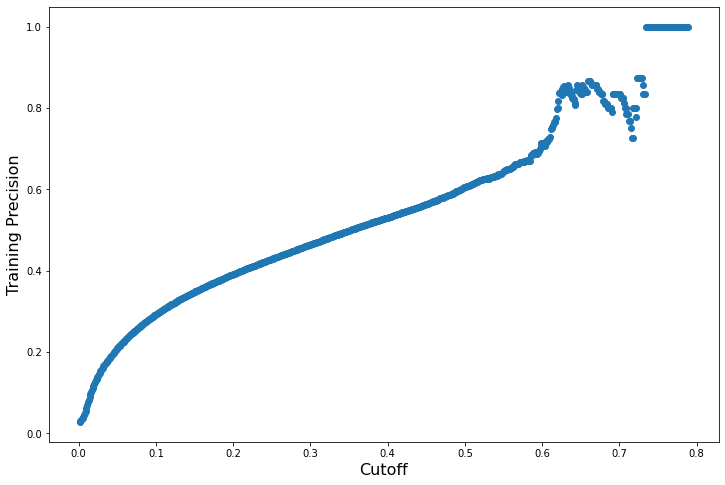

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,precs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Precision",fontsize=16)

plt.show()

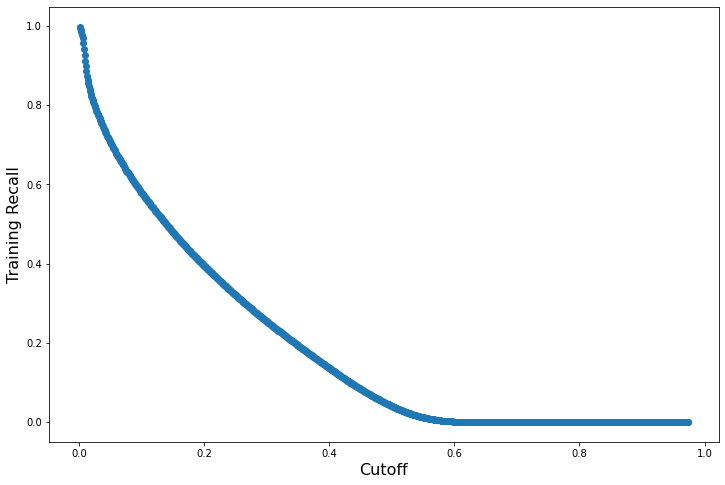

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,recs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Recall",fontsize=16)

plt.show()

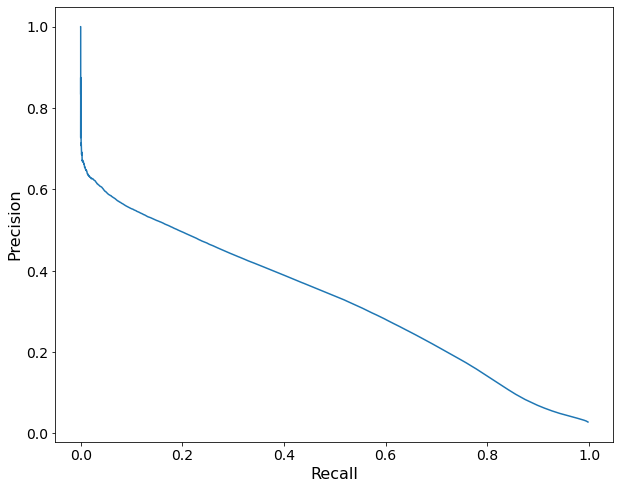

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(recs, precs)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Remember, we report precision and recall that maximize the F1-score, which usually involves a relatively low threshold for fire.

<ipython-input-31-6bd9b1a1fe46>:3: RuntimeWarning: invalid value encountered in true_divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


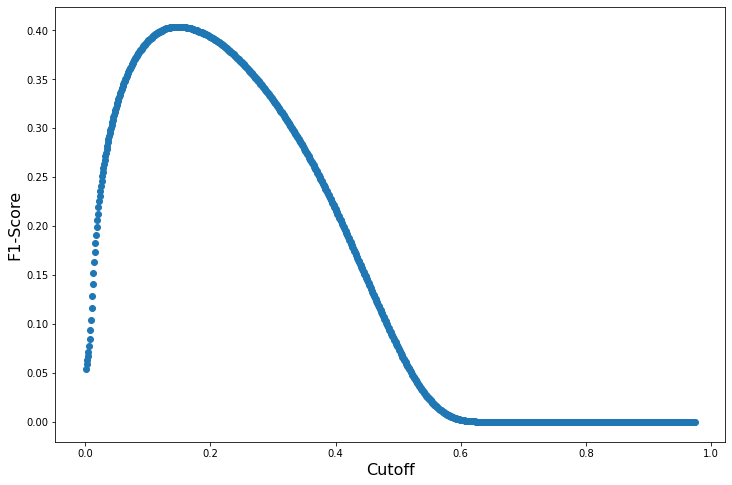

In [ ]:
plt.figure(figsize=(12,8))

f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
plt.scatter(cutoffs,f1s)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("F1-Score",fontsize=16)

plt.show()

# 7. Plotting function

Visualize the predicions on a few new inputs

In [ ]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

53/53 [==============================] - 1s 17ms/step


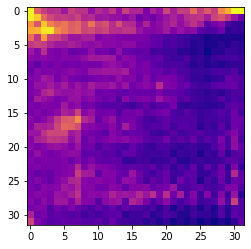

In [ ]:
pred = model.predict(inputs_test).reshape((len(inputs_test),32,32))
plt.imshow(pred[0], cmap='plasma') 

Plot the Last fire, Actual fire, and Predicted fire for comparison to see how well this model did in predicting fire.

Note that for inputs with no fire (presumably, it was cropped out), it generally predicts there will be no fire (<2% chance).

For all other inputs, it generally predicts a larger bubble around the fire, accounting for wind/terrain.

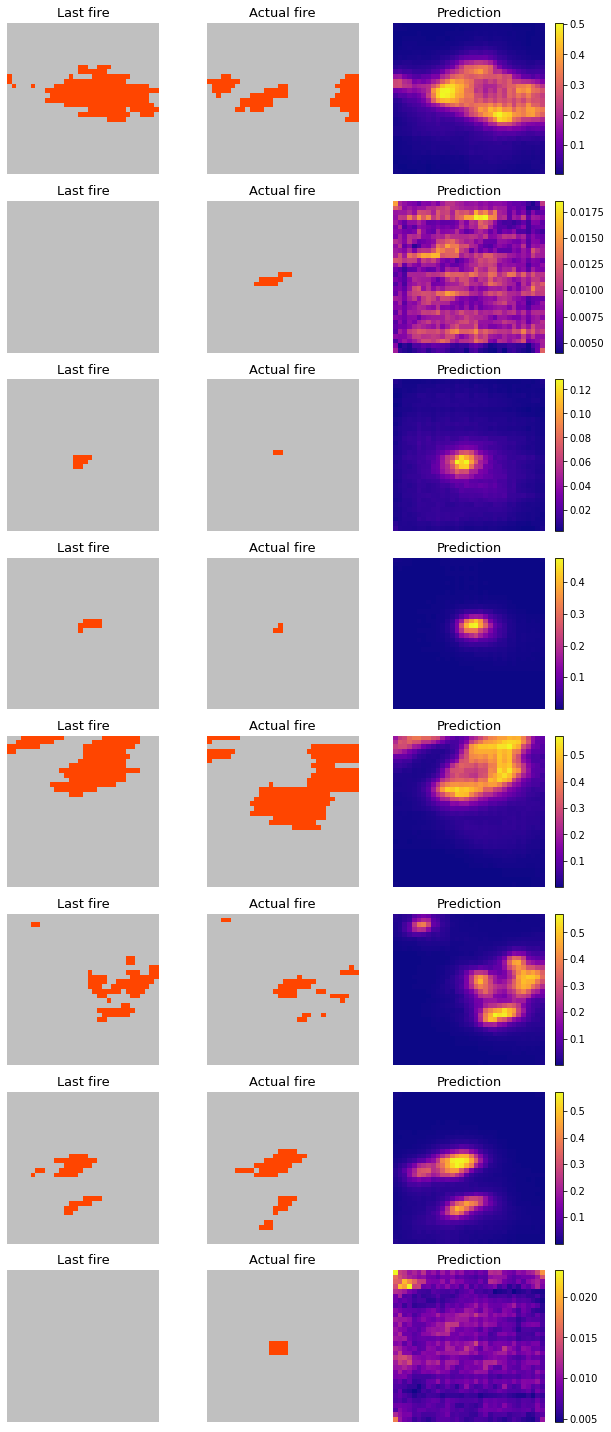

In [ ]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  fire_index = i +1000
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma') 
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()